In [1]:
%matplotlib inline


# 1) Wipe out your namespace
%reset -f

# 2) Clear Jupyter’s stored outputs (and inputs if you like)
try:
    Out.clear()
except NameError:
    pass

try:
    In.clear()
except NameError:
    pass

# 3) Force Python GC
import gc
gc.collect()

# 4) Free any GPU buffers
import torch
if torch.cuda.is_available():
    torch.cuda.empty_cache()


import importlib
from libs import params, trades, feats, plots, models_core
from libs.models import dual_lstm
importlib.reload(params)
importlib.reload(trades)
importlib.reload(feats)
importlib.reload(plots)
importlib.reload(models_core)
importlib.reload(dual_lstm)

<module 'libs.models.dual_lstm' from '/workspace/my_models/Trading/_Stock_Analysis_/libs/models/dual_lstm.py'>

In [2]:
# Turn off interactive plotting globally (we’ll manage our own display)
import matplotlib
matplotlib.use("Agg")  # safe, headless-friendly
import matplotlib.pyplot as plt
plt.ioff()

import os
import json
import numpy as np
import pandas as pd
import datetime as dt
from pathlib import Path

from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingWarmRestarts
from torch.cuda.amp import GradScaler, autocast

import optuna
from optuna.pruners import MedianPruner
from optuna.exceptions import TrialPruned
from optuna.importance import get_param_importances

from tqdm.auto import tqdm


In [3]:
df_feat_sel = pd.read_csv(params.feat_all_csv, index_col=0, parse_dates=True)[params.features_cols_tick + ['close_raw'] + [params.label_col]]
    
df_feat_sel

,sma_pct_14,atr_pct_14,rsi_14,bb_w_20,plus_di_14,range_pct,eng_ma,minus_di_14,macd_diff_12_26_9,ret,eng_macd,macd_line_12_26_9,obv_diff_14,eng_atr_div,eng_adx,hour,adx_14,close_raw,signal
2004-01-02 09:33:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.301415e-09
2004-01-02 09:34:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.405474e-09
2004-01-02 09:35:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.517855e-09
2004-01-02 09:36:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.639221e-09
2004-01-02 09:37:00,0.499798,0.000000,1.000000,0.000000,0.000000,0.000000,0.516453,0.000000,0.506696,0.499891,0.624765,0.489532,0.488177,0.353456,0.519392,1.002425,0.000000,0.764286,1.770291e-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-06-18 20:56:00,0.751690,0.323886,0.672166,0.273759,0.363125,0.254109,0.532431,0.074852,0.888941,0.642346,0.634772,0.971125,1.000000,0.664288,0.537709,-0.975989,0.301944,196.815000,6.849078e-01
2025-06-18 20:57:00,0.650094,0.336016,0.616686,0.290460,0.347207,0.420131,0.532016,0.067044,0.840741,0.340442,0.633511,0.981544,0.000000,0.676887,0.541855,-0.975989,0.328685,196.675000,6.122057e-01
2025-06-18 20:58:00,0.631153,0.322169,0.614734,0.304199,0.336272,0.121620,0.531618,0.064933,0.777896,0.494192,0.631866,0.983006,0.000000,0.584662,0.545337,-0.975989,0.353515,196.670000,6.104678e-01
2025-06-18 20:59:00,0.375519,0.346959,0.475401,0.305249,0.290578,0.565110,0.531157,0.160021,0.456523,0.009795,0.623450,0.884486,0.000000,0.645760,0.531521,-0.975989,0.348960,196.240000,4.770902e-01


In [4]:
# calculate look_backs under half the interval between the day’s first and sess_start

first_time = (
    df_feat_sel.index
        .to_series()
        .groupby(df_feat_sel.index.normalize())
        .min()
        .dt.time
        .mode()[0]
)

# convert both times to minutes since midnight
fm = first_time.hour * 60 + first_time.minute
sm = params.sess_start.hour * 60 + params.sess_start.minute

# half the difference, count full 30-min slots, and build multiples
n_steps    = int(((sm - fm) / 2) // 30)      # e.g. floor(165/30) = 5
look_backs = [30 * i for i in range(1, n_steps + 1)]
look_backs


[30, 60, 90, 120]

In [5]:
# ──────────────────────────────────────────────────────────────────────────────
# Optuna objective definition
# ──────────────────────────────────────────────────────────────────────────────

# look_backs = [30, 45, 60, 75, 90] ################################

def objective(trial):
    
    hp = {
    # ── Architecture ────────────────────────────────────────────────
    "look_back"    : trial.suggest_categorical("look_back", look_backs),
    "DROPOUT_SHORT": trial.suggest_float("DROPOUT_SHORT", 0.05, 0.35),
    "DROPOUT_LONG":  trial.suggest_float("DROPOUT_LONG",  0.05, 0.35),
    "ATT_DROPOUT":   trial.suggest_float("ATT_DROPOUT",   0.05, 0.35),
    
    # ── Optimizer & Scheduler ──────────────────────────────────────
    "INITIAL_LR":    trial.suggest_float("INITIAL_LR",    1e-5, 1e-3,   log=True),
    "ETA_MIN":       trial.suggest_float("ETA_MIN",       1e-6, 1e-5,   log=True),
    "WEIGHT_DECAY":  trial.suggest_float("WEIGHT_DECAY",  1e-5, 1e-2,  log=True),
    "CLIPNORM":      trial.suggest_float("CLIPNORM",      0.1, 10),
    }

    print(f"\n▶ Trial {trial.number} starting with:\n{hp}\n")

    sess_start_pred = dt.time(*divmod((params.sess_start.hour * 60 + params.sess_start.minute) - hp["look_back"], 60))
    
    print('Build LSTM input tensors (disk-backed memmaps)...')
    X, y_sig, y_ret, raw_close, end_times = models_core.build_tensors(
        df            = df_feat_sel,
        sess_start    = sess_start_pred 
    )
    
    print('Split into train/val/test by calendar day...')
    (
    (X_tr,  y_sig_tr,  y_ret_tr),
    (X_val, y_sig_val, y_ret_val),
    (X_te,  y_sig_te,  y_ret_te,  raw_close_te),
    samples_per_day,
    day_id_tr, day_id_val, day_id_te
    ) = models_core.chronological_split(
        X, y_sig, y_ret, raw_close,
        end_times   = end_times,
        train_prop  = params.train_prop,
        val_prop    = params.val_prop,
        train_batch = params.hparams['TRAIN_BATCH']
    )

    print('Carve `end_times` into the same three splits...')
    n_tr  = day_id_tr .shape[0] 
    n_val = day_id_val.shape[0]
    i_tr  = n_tr
    i_val = n_tr + n_val
    
    end_times_tr  = end_times[:i_tr]
    end_times_val = end_times[i_tr:i_val]
    end_times_te  = end_times[i_val:]
    
    print('Build DataLoaders over calendar‐days...')
    train_loader, val_loader, test_loader = models_core.split_to_day_datasets(
        # train split:   
        X_tr,       y_sig_tr,     y_ret_tr,   end_times_tr,
        # val split:
        X_val,      y_sig_val,    y_ret_val,  end_times_val,
        # test split + raw‐prices
        X_te,       y_sig_te,     y_ret_te,   end_times_te,    raw_close_te, 
        
        sess_start_time       = sess_start_pred,
        signal_thresh         = params.best_optuna_params["buy_threshold"],
        return_thresh         = 0.01,  # flat‐zone threshold for returns (to tune)
        train_batch           = params.hparams["TRAIN_BATCH"],
        train_workers         = params.hparams["NUM_WORKERS"],
        train_prefetch_factor = params.hparams["TRAIN_PREFETCH_FACTOR"]
    )

    print('Instantiate the stateful DualMemoryLSTM...')
    model = dual_lstm.DualMemoryLSTM(
        n_feats        = X.shape[-1],                          
        short_units    = params.hparams['SHORT_UNITS'],    
        long_units     = params.hparams['LONG_UNITS'],     
        dropout_short  = hp["DROPOUT_SHORT"],  
        dropout_long   = hp["DROPOUT_LONG"],   
        att_heads      = params.hparams['ATT_HEADS'],
        att_drop       = hp['ATT_DROPOUT']
    )
    model.to(params.device)  

    print('Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...')
    optimizer, plateau_sched, _ , scaler, clipnorm = \
        models_core.make_optimizer_and_scheduler(
            model            = model,
            initial_lr       = hp["INITIAL_LR"],
            weight_decay     = hp["WEIGHT_DECAY"],
            clipnorm         = hp["CLIPNORM"]
        )
    cosine_sched = CosineAnnealingWarmRestarts(
        optimizer, 
        T_0=params.hparams['T_0'], 
        T_mult=params.hparams['T_MULT'], 
        eta_min=hp['ETA_MIN']
    )
    
    print('Run the custom stateful training loop...')
    best_val_rmse  = dual_lstm.lstm_training_loop(
        model               = model,
        optimizer           = optimizer,
        cosine_sched        = cosine_sched,
        plateau_sched       = plateau_sched,
        scaler              = scaler,
        train_loader        = train_loader,
        val_loader          = val_loader,
        max_epochs          = params.hparams['MAX_EPOCHS'],
        early_stop_patience = params.hparams['EARLY_STOP_PATIENCE'],
        clipnorm            = hp["CLIPNORM"],
        device              = params.device
    )

    print('Delete variables to free memory...')
    del model, optimizer, plateau_sched, cosine_sched, scaler
    del X, y_sig, y_ret, raw_close, raw_close_te
    del X_tr,  y_sig_tr,  y_ret_tr, X_val, y_sig_val, y_ret_val, X_te,  y_sig_te,  y_ret_te
    del train_loader, val_loader, test_loader

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    
    return best_val_rmse


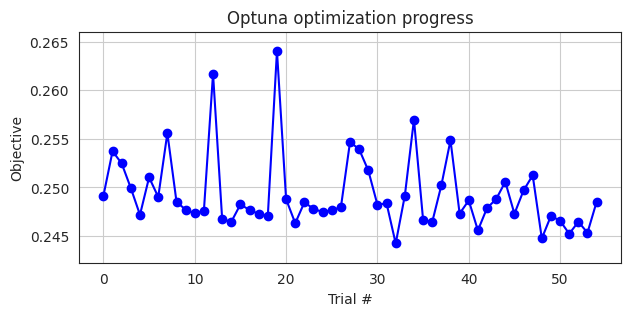

In [6]:
# build blank figure & line
fig, ax = plt.subplots(figsize=(7,3))
line, = ax.plot([], [], "bo-")
ax.set(xlabel="Trial #", ylabel="Objective",
       title="Optuna optimization progress")
ax.grid(True)

# display once and grab the handle
handle = display(fig, display_id=True)
plt.close(fig)

# ask plots.py for a callback bound to these objects
live_cb = plots.make_live_plot_callback(fig, ax, line, handle)

[I 2025-09-22 16:56:48,338] A new study created in RDB with name: no-name-4e73fa53-e87f-4988-8187-0b9fddb4f83b



▶ Trial 0 starting with:
{'look_back': 90, 'DROPOUT_SHORT': 0.058925138104696, 'DROPOUT_LONG': 0.15893604082413224, 'ATT_DROPOUT': 0.12861216494566413, 'INITIAL_LR': 3.084067537390925e-05, 'ETA_MIN': 2.9146458882681766e-06, 'WEIGHT_DECAY': 0.00020808708122170726, 'CLIPNORM': 6.97405241436584}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


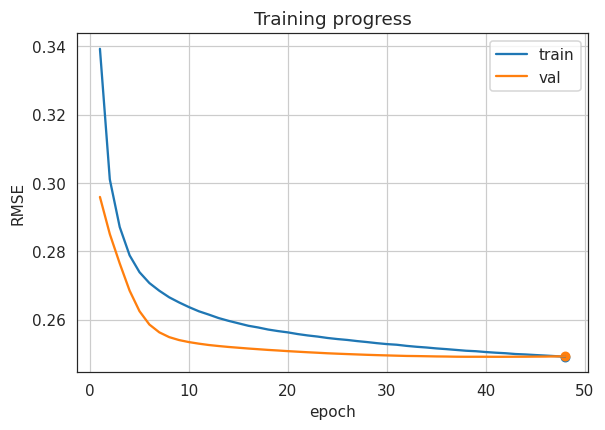

Epoch 1:   0%|          | 0/60 [00:02<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.3392 MAE=0.2799 R2=-0.3699 | Acc=0.4764 Prec=0.2821 Rec=0.5957 F1=0.3829 AUROC=0.5207
VALID→ RMSE=0.2959 MAE=0.2155 R2=-0.0777 | Acc=0.6960 Prec=0.4215 Rec=0.2259 F1=0.2941 AUROC=0.6139


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.3010 MAE=0.2280 R2=-0.0786 | Acc=0.7092 Prec=0.3324 Rec=0.0659 F1=0.1100 AUROC=0.5317
VALID→ RMSE=0.2850 MAE=0.2039 R2=-0.0000 | Acc=0.7197 Prec=0.7381 Rec=0.0006 F1=0.0012 AUROC=0.6251


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2871 MAE=0.2188 R2=0.0187 | Acc=0.7263 Prec=0.3576 Rec=0.0047 F1=0.0093 AUROC=0.5168
VALID→ RMSE=0.2765 MAE=0.1970 R2=0.0592 | Acc=0.7196 Prec=0.7647 Rec=0.0001 F1=0.0003 AUROC=0.6408


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2788 MAE=0.2129 R2=0.0746 | Acc=0.7270 Prec=0.4262 Rec=0.0041 F1=0.0081 AUROC=0.5367
VALID→ RMSE=0.2685 MAE=0.1921 R2=0.1127 | Acc=0.7197 Prec=0.7789 Rec=0.0007 F1=0.0015 AUROC=0.6581


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2739 MAE=0.2095 R2=0.1070 | Acc=0.7274 Prec=0.5022 Rec=0.0072 F1=0.0142 AUROC=0.5651
VALID→ RMSE=0.2625 MAE=0.1886 R2=0.1520 | Acc=0.7209 Prec=0.8220 Rec=0.0058 F1=0.0116 AUROC=0.6739


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2707 MAE=0.2069 R2=0.1276 | Acc=0.7283 Prec=0.5635 Rec=0.0154 F1=0.0299 AUROC=0.5951
VALID→ RMSE=0.2586 MAE=0.1867 R2=0.1770 | Acc=0.7236 Prec=0.7952 Rec=0.0191 F1=0.0374 AUROC=0.6882


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2685 MAE=0.2050 R2=0.1420 | Acc=0.7301 Prec=0.5971 Rec=0.0306 F1=0.0582 AUROC=0.6198
VALID→ RMSE=0.2563 MAE=0.1858 R2=0.1914 | Acc=0.7282 Prec=0.7753 Rec=0.0434 F1=0.0822 AUROC=0.7005


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2666 MAE=0.2035 R2=0.1542 | Acc=0.7329 Prec=0.6156 Rec=0.0539 F1=0.0991 AUROC=0.6402
VALID→ RMSE=0.2549 MAE=0.1855 R2=0.2003 | Acc=0.7345 Prec=0.7578 Rec=0.0784 F1=0.1422 AUROC=0.7105


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2651 MAE=0.2024 R2=0.1638 | Acc=0.7364 Prec=0.6237 Rec=0.0840 F1=0.1481 AUROC=0.6561
VALID→ RMSE=0.2540 MAE=0.1856 R2=0.2057 | Acc=0.7409 Prec=0.7384 Rec=0.1179 F1=0.2034 AUROC=0.7179


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2637 MAE=0.2013 R2=0.1724 | Acc=0.7403 Prec=0.6294 Rec=0.1157 F1=0.1955 AUROC=0.6696
VALID→ RMSE=0.2534 MAE=0.1858 R2=0.2094 | Acc=0.7459 Prec=0.7164 Rec=0.1552 F1=0.2551 AUROC=0.7233


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2625 MAE=0.2004 R2=0.1800 | Acc=0.7433 Prec=0.6278 Rec=0.1440 F1=0.2342 AUROC=0.6805
VALID→ RMSE=0.2530 MAE=0.1860 R2=0.2122 | Acc=0.7495 Prec=0.7022 Rec=0.1854 F1=0.2934 AUROC=0.7272


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.2615 MAE=0.1996 R2=0.1860 | Acc=0.7460 Prec=0.6272 Rec=0.1685 F1=0.2657 AUROC=0.6886
VALID→ RMSE=0.2526 MAE=0.1863 R2=0.2147 | Acc=0.7521 Prec=0.6908 Rec=0.2100 F1=0.3220 AUROC=0.7300


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.2605 MAE=0.1988 R2=0.1924 | Acc=0.7481 Prec=0.6263 Rec=0.1890 F1=0.2904 AUROC=0.6964
VALID→ RMSE=0.2523 MAE=0.1866 R2=0.2165 | Acc=0.7537 Prec=0.6810 Rec=0.2290 F1=0.3428 AUROC=0.7320


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ RMSE=0.2597 MAE=0.1980 R2=0.1974 | Acc=0.7499 Prec=0.6267 Rec=0.2045 F1=0.3084 AUROC=0.7022
VALID→ RMSE=0.2520 MAE=0.1870 R2=0.2182 | Acc=0.7546 Prec=0.6725 Rec=0.2436 F1=0.3576 AUROC=0.7333


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ RMSE=0.2589 MAE=0.1973 R2=0.2018 | Acc=0.7514 Prec=0.6286 Rec=0.2152 F1=0.3207 AUROC=0.7075
VALID→ RMSE=0.2518 MAE=0.1872 R2=0.2196 | Acc=0.7552 Prec=0.6668 Rec=0.2542 F1=0.3681 AUROC=0.7342


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ RMSE=0.2582 MAE=0.1966 R2=0.2063 | Acc=0.7525 Prec=0.6293 Rec=0.2244 F1=0.3308 AUROC=0.7119
VALID→ RMSE=0.2516 MAE=0.1874 R2=0.2211 | Acc=0.7557 Prec=0.6622 Rec=0.2633 F1=0.3767 AUROC=0.7350


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ RMSE=0.2577 MAE=0.1961 R2=0.2094 | Acc=0.7535 Prec=0.6308 Rec=0.2313 F1=0.3385 AUROC=0.7160
VALID→ RMSE=0.2514 MAE=0.1876 R2=0.2223 | Acc=0.7559 Prec=0.6582 Rec=0.2692 F1=0.3821 AUROC=0.7355


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ RMSE=0.2571 MAE=0.1955 R2=0.2130 | Acc=0.7542 Prec=0.6302 Rec=0.2379 F1=0.3454 AUROC=0.7192
VALID→ RMSE=0.2512 MAE=0.1878 R2=0.2236 | Acc=0.7561 Prec=0.6547 Rec=0.2756 F1=0.3879 AUROC=0.7360


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ RMSE=0.2567 MAE=0.1951 R2=0.2158 | Acc=0.7550 Prec=0.6312 Rec=0.2436 F1=0.3515 AUROC=0.7221
VALID→ RMSE=0.2510 MAE=0.1879 R2=0.2246 | Acc=0.7562 Prec=0.6519 Rec=0.2806 F1=0.3923 AUROC=0.7364


Epoch 20:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ RMSE=0.2563 MAE=0.1948 R2=0.2181 | Acc=0.7555 Prec=0.6310 Rec=0.2490 F1=0.3571 AUROC=0.7246
VALID→ RMSE=0.2508 MAE=0.1880 R2=0.2258 | Acc=0.7564 Prec=0.6498 Rec=0.2848 F1=0.3960 AUROC=0.7368


Epoch 21:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ RMSE=0.2558 MAE=0.1944 R2=0.2211 | Acc=0.7560 Prec=0.6306 Rec=0.2535 F1=0.3616 AUROC=0.7268
VALID→ RMSE=0.2506 MAE=0.1881 R2=0.2268 | Acc=0.7564 Prec=0.6472 Rec=0.2890 F1=0.3995 AUROC=0.7372


Epoch 22:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ RMSE=0.2554 MAE=0.1940 R2=0.2236 | Acc=0.7567 Prec=0.6318 Rec=0.2581 F1=0.3665 AUROC=0.7293
VALID→ RMSE=0.2505 MAE=0.1883 R2=0.2278 | Acc=0.7565 Prec=0.6461 Rec=0.2913 F1=0.4016 AUROC=0.7375


Epoch 23:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ RMSE=0.2551 MAE=0.1937 R2=0.2256 | Acc=0.7572 Prec=0.6321 Rec=0.2616 F1=0.3701 AUROC=0.7308
VALID→ RMSE=0.2503 MAE=0.1884 R2=0.2287 | Acc=0.7565 Prec=0.6439 Rec=0.2942 F1=0.4039 AUROC=0.7379


Epoch 24:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ RMSE=0.2547 MAE=0.1934 R2=0.2281 | Acc=0.7577 Prec=0.6320 Rec=0.2663 F1=0.3747 AUROC=0.7327
VALID→ RMSE=0.2502 MAE=0.1885 R2=0.2296 | Acc=0.7564 Prec=0.6423 Rec=0.2966 F1=0.4058 AUROC=0.7382


Epoch 25:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ RMSE=0.2543 MAE=0.1931 R2=0.2300 | Acc=0.7580 Prec=0.6326 Rec=0.2686 F1=0.3771 AUROC=0.7343
VALID→ RMSE=0.2501 MAE=0.1887 R2=0.2304 | Acc=0.7565 Prec=0.6414 Rec=0.2986 F1=0.4075 AUROC=0.7385


Epoch 26:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 026
TRAIN→ RMSE=0.2541 MAE=0.1929 R2=0.2316 | Acc=0.7586 Prec=0.6332 Rec=0.2721 F1=0.3806 AUROC=0.7359
VALID→ RMSE=0.2499 MAE=0.1888 R2=0.2311 | Acc=0.7565 Prec=0.6400 Rec=0.3006 F1=0.4091 AUROC=0.7387


Epoch 27:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 027
TRAIN→ RMSE=0.2537 MAE=0.1927 R2=0.2336 | Acc=0.7587 Prec=0.6323 Rec=0.2748 F1=0.3832 AUROC=0.7372
VALID→ RMSE=0.2498 MAE=0.1890 R2=0.2317 | Acc=0.7564 Prec=0.6384 Rec=0.3030 F1=0.4109 AUROC=0.7390


Epoch 28:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 028
TRAIN→ RMSE=0.2535 MAE=0.1924 R2=0.2353 | Acc=0.7593 Prec=0.6334 Rec=0.2782 F1=0.3866 AUROC=0.7387
VALID→ RMSE=0.2497 MAE=0.1891 R2=0.2324 | Acc=0.7565 Prec=0.6381 Rec=0.3045 F1=0.4123 AUROC=0.7393


Epoch 29:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 029
TRAIN→ RMSE=0.2531 MAE=0.1922 R2=0.2373 | Acc=0.7597 Prec=0.6332 Rec=0.2816 F1=0.3898 AUROC=0.7398
VALID→ RMSE=0.2496 MAE=0.1893 R2=0.2330 | Acc=0.7566 Prec=0.6374 Rec=0.3064 F1=0.4138 AUROC=0.7395


Epoch 30:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 030
TRAIN→ RMSE=0.2529 MAE=0.1920 R2=0.2389 | Acc=0.7600 Prec=0.6335 Rec=0.2838 F1=0.3920 AUROC=0.7408
VALID→ RMSE=0.2496 MAE=0.1895 R2=0.2335 | Acc=0.7568 Prec=0.6373 Rec=0.3079 F1=0.4152 AUROC=0.7398


Epoch 31:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 031
TRAIN→ RMSE=0.2527 MAE=0.1918 R2=0.2400 | Acc=0.7605 Prec=0.6345 Rec=0.2866 F1=0.3949 AUROC=0.7422
VALID→ RMSE=0.2495 MAE=0.1896 R2=0.2340 | Acc=0.7568 Prec=0.6368 Rec=0.3091 F1=0.4162 AUROC=0.7400


Epoch 32:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 032
TRAIN→ RMSE=0.2523 MAE=0.1916 R2=0.2420 | Acc=0.7607 Prec=0.6342 Rec=0.2891 F1=0.3971 AUROC=0.7434
VALID→ RMSE=0.2494 MAE=0.1897 R2=0.2344 | Acc=0.7568 Prec=0.6365 Rec=0.3099 F1=0.4168 AUROC=0.7402


Epoch 33:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 033
TRAIN→ RMSE=0.2521 MAE=0.1914 R2=0.2436 | Acc=0.7610 Prec=0.6344 Rec=0.2912 F1=0.3991 AUROC=0.7443
VALID→ RMSE=0.2494 MAE=0.1899 R2=0.2347 | Acc=0.7568 Prec=0.6357 Rec=0.3109 F1=0.4176 AUROC=0.7404


Epoch 34:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 034
TRAIN→ RMSE=0.2519 MAE=0.1912 R2=0.2449 | Acc=0.7612 Prec=0.6341 Rec=0.2932 F1=0.4010 AUROC=0.7453
VALID→ RMSE=0.2493 MAE=0.1901 R2=0.2350 | Acc=0.7568 Prec=0.6348 Rec=0.3121 F1=0.4185 AUROC=0.7405


Epoch 35:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 035
TRAIN→ RMSE=0.2516 MAE=0.1910 R2=0.2465 | Acc=0.7615 Prec=0.6341 Rec=0.2960 F1=0.4036 AUROC=0.7461
VALID→ RMSE=0.2493 MAE=0.1903 R2=0.2353 | Acc=0.7570 Prec=0.6349 Rec=0.3138 F1=0.4200 AUROC=0.7407


Epoch 36:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 036
TRAIN→ RMSE=0.2514 MAE=0.1908 R2=0.2477 | Acc=0.7617 Prec=0.6343 Rec=0.2976 F1=0.4051 AUROC=0.7470
VALID→ RMSE=0.2492 MAE=0.1904 R2=0.2355 | Acc=0.7569 Prec=0.6342 Rec=0.3144 F1=0.4204 AUROC=0.7409


Epoch 37:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 037
TRAIN→ RMSE=0.2512 MAE=0.1906 R2=0.2491 | Acc=0.7619 Prec=0.6346 Rec=0.2990 F1=0.4065 AUROC=0.7480
VALID→ RMSE=0.2492 MAE=0.1905 R2=0.2358 | Acc=0.7569 Prec=0.6338 Rec=0.3148 F1=0.4207 AUROC=0.7411


Epoch 38:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 038
TRAIN→ RMSE=0.2509 MAE=0.1904 R2=0.2505 | Acc=0.7623 Prec=0.6351 Rec=0.3010 F1=0.4085 AUROC=0.7487
VALID→ RMSE=0.2492 MAE=0.1906 R2=0.2359 | Acc=0.7569 Prec=0.6335 Rec=0.3154 F1=0.4211 AUROC=0.7411


Epoch 39:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 039
TRAIN→ RMSE=0.2508 MAE=0.1903 R2=0.2514 | Acc=0.7624 Prec=0.6347 Rec=0.3031 F1=0.4103 AUROC=0.7496
VALID→ RMSE=0.2492 MAE=0.1908 R2=0.2359 | Acc=0.7568 Prec=0.6327 Rec=0.3162 F1=0.4216 AUROC=0.7412


Epoch 40:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 040
TRAIN→ RMSE=0.2505 MAE=0.1901 R2=0.2528 | Acc=0.7628 Prec=0.6352 Rec=0.3055 F1=0.4126 AUROC=0.7504
VALID→ RMSE=0.2492 MAE=0.1909 R2=0.2359 | Acc=0.7568 Prec=0.6323 Rec=0.3170 F1=0.4223 AUROC=0.7412


Epoch 41:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 041
TRAIN→ RMSE=0.2503 MAE=0.1900 R2=0.2540 | Acc=0.7633 Prec=0.6364 Rec=0.3073 F1=0.4145 AUROC=0.7512
VALID→ RMSE=0.2492 MAE=0.1911 R2=0.2360 | Acc=0.7568 Prec=0.6320 Rec=0.3175 F1=0.4227 AUROC=0.7414


Epoch 42:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 042
TRAIN→ RMSE=0.2502 MAE=0.1899 R2=0.2549 | Acc=0.7631 Prec=0.6348 Rec=0.3083 F1=0.4150 AUROC=0.7518
VALID→ RMSE=0.2492 MAE=0.1911 R2=0.2359 | Acc=0.7568 Prec=0.6318 Rec=0.3180 F1=0.4230 AUROC=0.7413


Epoch 43:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 043
TRAIN→ RMSE=0.2500 MAE=0.1897 R2=0.2563 | Acc=0.7635 Prec=0.6362 Rec=0.3099 F1=0.4168 AUROC=0.7524
VALID→ RMSE=0.2492 MAE=0.1912 R2=0.2359 | Acc=0.7567 Prec=0.6313 Rec=0.3184 F1=0.4233 AUROC=0.7414


Epoch 44:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 044
TRAIN→ RMSE=0.2498 MAE=0.1896 R2=0.2570 | Acc=0.7637 Prec=0.6359 Rec=0.3117 F1=0.4184 AUROC=0.7532
VALID→ RMSE=0.2492 MAE=0.1913 R2=0.2358 | Acc=0.7567 Prec=0.6308 Rec=0.3189 F1=0.4237 AUROC=0.7414


Epoch 45:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 045
TRAIN→ RMSE=0.2497 MAE=0.1895 R2=0.2580 | Acc=0.7638 Prec=0.6359 Rec=0.3131 F1=0.4196 AUROC=0.7537
VALID→ RMSE=0.2492 MAE=0.1914 R2=0.2356 | Acc=0.7568 Prec=0.6311 Rec=0.3193 F1=0.4240 AUROC=0.7415


Epoch 46:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 046
TRAIN→ RMSE=0.2495 MAE=0.1893 R2=0.2589 | Acc=0.7640 Prec=0.6359 Rec=0.3143 F1=0.4207 AUROC=0.7543
VALID→ RMSE=0.2492 MAE=0.1914 R2=0.2356 | Acc=0.7566 Prec=0.6303 Rec=0.3196 F1=0.4241 AUROC=0.7414


Epoch 47:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 047
TRAIN→ RMSE=0.2493 MAE=0.1892 R2=0.2599 | Acc=0.7644 Prec=0.6369 Rec=0.3157 F1=0.4222 AUROC=0.7547
VALID→ RMSE=0.2493 MAE=0.1915 R2=0.2352 | Acc=0.7566 Prec=0.6301 Rec=0.3200 F1=0.4244 AUROC=0.7414


Epoch 48:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 048
TRAIN→ RMSE=0.2492 MAE=0.1891 R2=0.2610 | Acc=0.7643 Prec=0.6361 Rec=0.3169 F1=0.4231 AUROC=0.7552
VALID→ RMSE=0.2493 MAE=0.1915 R2=0.2352 | Acc=0.7566 Prec=0.6296 Rec=0.3203 F1=0.4246 AUROC=0.7415
Early stopping at epoch 48
✅ Final best model (_fin) saved: AAPL_0.24915_fin.pth
Delete variables to free memory...


[I 2025-09-22 17:34:55,282] Trial 0 finished with value: 0.24915120005607605 and parameters: {'look_back': 90, 'DROPOUT_SHORT': 0.058925138104696, 'DROPOUT_LONG': 0.15893604082413224, 'ATT_DROPOUT': 0.12861216494566413, 'INITIAL_LR': 3.084067537390925e-05, 'ETA_MIN': 2.9146458882681766e-06, 'WEIGHT_DECAY': 0.00020808708122170726, 'CLIPNORM': 6.97405241436584}. Best is trial 0 with value: 0.24915120005607605.



▶ Trial 1 starting with:
{'look_back': 30, 'DROPOUT_SHORT': 0.1311208702523886, 'DROPOUT_LONG': 0.32583310497151163, 'ATT_DROPOUT': 0.33273343618229484, 'INITIAL_LR': 8.716283933607206e-05, 'ETA_MIN': 1.320486679662627e-06, 'WEIGHT_DECAY': 3.032428577056443e-05, 'CLIPNORM': 7.149672186124798}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


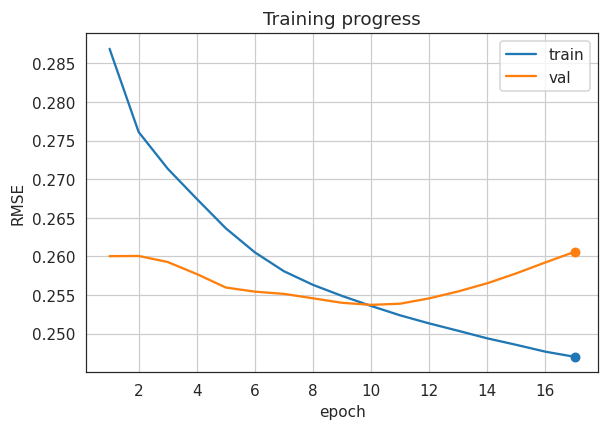

Epoch 1:   0%|          | 0/60 [00:02<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2869 MAE=0.2210 R2=0.0355 | Acc=0.6799 Prec=0.3585 Rec=0.1706 F1=0.2312 AUROC=0.5839
VALID→ RMSE=0.2600 MAE=0.1853 R2=0.1906 | Acc=0.7049 Prec=0.3333 Rec=0.0000 F1=0.0000 AUROC=0.6943


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2761 MAE=0.2116 R2=0.1065 | Acc=0.7075 Prec=0.4439 Rec=0.1448 F1=0.2183 AUROC=0.5957
VALID→ RMSE=0.2601 MAE=0.1856 R2=0.1904 | Acc=0.7243 Prec=0.7824 Rec=0.0912 F1=0.1633 AUROC=0.7321


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2714 MAE=0.2079 R2=0.1370 | Acc=0.7240 Prec=0.5337 Rec=0.1725 F1=0.2607 AUROC=0.6402
VALID→ RMSE=0.2593 MAE=0.1859 R2=0.1953 | Acc=0.7371 Prec=0.7133 Rec=0.1826 F1=0.2908 AUROC=0.7389


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2674 MAE=0.2046 R2=0.1617 | Acc=0.7325 Prec=0.5662 Rec=0.2220 F1=0.3189 AUROC=0.6699
VALID→ RMSE=0.2577 MAE=0.1865 R2=0.2049 | Acc=0.7409 Prec=0.6954 Rec=0.2171 F1=0.3309 AUROC=0.7411


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2636 MAE=0.2015 R2=0.1854 | Acc=0.7391 Prec=0.5878 Rec=0.2521 F1=0.3529 AUROC=0.6905
VALID→ RMSE=0.2560 MAE=0.1875 R2=0.2156 | Acc=0.7426 Prec=0.6876 Rec=0.2340 F1=0.3492 AUROC=0.7421


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2605 MAE=0.1993 R2=0.2045 | Acc=0.7448 Prec=0.6059 Rec=0.2731 F1=0.3765 AUROC=0.7076
VALID→ RMSE=0.2554 MAE=0.1876 R2=0.2189 | Acc=0.7437 Prec=0.6841 Rec=0.2443 F1=0.3600 AUROC=0.7427


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2581 MAE=0.1971 R2=0.2193 | Acc=0.7485 Prec=0.6144 Rec=0.2913 F1=0.3952 AUROC=0.7212
VALID→ RMSE=0.2552 MAE=0.1875 R2=0.2207 | Acc=0.7444 Prec=0.6835 Rec=0.2491 F1=0.3651 AUROC=0.7435


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2563 MAE=0.1955 R2=0.2300 | Acc=0.7509 Prec=0.6176 Rec=0.3071 F1=0.4102 AUROC=0.7305
VALID→ RMSE=0.2546 MAE=0.1878 R2=0.2242 | Acc=0.7447 Prec=0.6790 Rec=0.2557 F1=0.3715 AUROC=0.7443


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2549 MAE=0.1943 R2=0.2386 | Acc=0.7526 Prec=0.6201 Rec=0.3175 F1=0.4200 AUROC=0.7369
VALID→ RMSE=0.2540 MAE=0.1886 R2=0.2277 | Acc=0.7450 Prec=0.6726 Rec=0.2651 F1=0.3803 AUROC=0.7448


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2536 MAE=0.1932 R2=0.2463 | Acc=0.7544 Prec=0.6243 Rec=0.3250 F1=0.4275 AUROC=0.7418
VALID→ RMSE=0.2537 MAE=0.1897 R2=0.2293 | Acc=0.7454 Prec=0.6661 Rec=0.2756 F1=0.3898 AUROC=0.7447


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2524 MAE=0.1922 R2=0.2535 | Acc=0.7557 Prec=0.6269 Rec=0.3309 F1=0.4332 AUROC=0.7464
VALID→ RMSE=0.2539 MAE=0.1911 R2=0.2284 | Acc=0.7454 Prec=0.6558 Rec=0.2890 F1=0.4011 AUROC=0.7443


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.2513 MAE=0.1914 R2=0.2597 | Acc=0.7572 Prec=0.6299 Rec=0.3380 F1=0.4400 AUROC=0.7503
VALID→ RMSE=0.2546 MAE=0.1925 R2=0.2242 | Acc=0.7446 Prec=0.6444 Rec=0.3004 F1=0.4098 AUROC=0.7434


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.2504 MAE=0.1906 R2=0.2653 | Acc=0.7589 Prec=0.6333 Rec=0.3455 F1=0.4471 AUROC=0.7542
VALID→ RMSE=0.2555 MAE=0.1939 R2=0.2187 | Acc=0.7434 Prec=0.6328 Rec=0.3112 F1=0.4172 AUROC=0.7424


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ RMSE=0.2494 MAE=0.1899 R2=0.2710 | Acc=0.7600 Prec=0.6354 Rec=0.3504 F1=0.4517 AUROC=0.7573
VALID→ RMSE=0.2565 MAE=0.1952 R2=0.2122 | Acc=0.7414 Prec=0.6192 Rec=0.3217 F1=0.4234 AUROC=0.7410


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ RMSE=0.2486 MAE=0.1892 R2=0.2759 | Acc=0.7612 Prec=0.6375 Rec=0.3564 F1=0.4572 AUROC=0.7599
VALID→ RMSE=0.2578 MAE=0.1965 R2=0.2043 | Acc=0.7391 Prec=0.6055 Rec=0.3331 F1=0.4298 AUROC=0.7395


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ RMSE=0.2477 MAE=0.1885 R2=0.2811 | Acc=0.7629 Prec=0.6415 Rec=0.3618 F1=0.4627 AUROC=0.7630
VALID→ RMSE=0.2592 MAE=0.1978 R2=0.1956 | Acc=0.7367 Prec=0.5938 Rec=0.3415 F1=0.4336 AUROC=0.7375


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ RMSE=0.2470 MAE=0.1880 R2=0.2849 | Acc=0.7638 Prec=0.6427 Rec=0.3668 F1=0.4671 AUROC=0.7653
VALID→ RMSE=0.2606 MAE=0.1987 R2=0.1871 | Acc=0.7341 Prec=0.5835 Rec=0.3460 F1=0.4344 AUROC=0.7353
Early stopping at epoch 17
✅ Final best model (_fin) saved: AAPL_0.25373_fin.pth
Delete variables to free memory...


[I 2025-09-22 17:49:03,704] Trial 1 finished with value: 0.25372982025146484 and parameters: {'look_back': 30, 'DROPOUT_SHORT': 0.1311208702523886, 'DROPOUT_LONG': 0.32583310497151163, 'ATT_DROPOUT': 0.33273343618229484, 'INITIAL_LR': 8.716283933607206e-05, 'ETA_MIN': 1.320486679662627e-06, 'WEIGHT_DECAY': 3.032428577056443e-05, 'CLIPNORM': 7.149672186124798}. Best is trial 0 with value: 0.24915120005607605.



▶ Trial 2 starting with:
{'look_back': 30, 'DROPOUT_SHORT': 0.13876828236595196, 'DROPOUT_LONG': 0.13210468871986952, 'ATT_DROPOUT': 0.17586179185381973, 'INITIAL_LR': 0.0007607683891612984, 'ETA_MIN': 6.032911708216451e-06, 'WEIGHT_DECAY': 0.00012642136281333467, 'CLIPNORM': 5.448004298253486}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


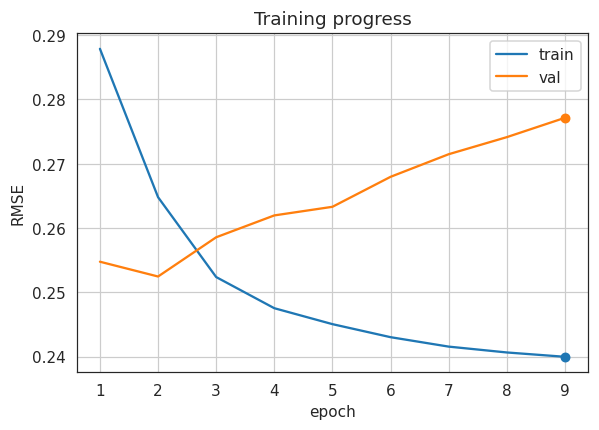

Epoch 1:   0%|          | 0/60 [00:02<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2879 MAE=0.2215 R2=0.0287 | Acc=0.7174 Prec=0.4982 Rec=0.2130 F1=0.2984 AUROC=0.6604
VALID→ RMSE=0.2548 MAE=0.1965 R2=0.2230 | Acc=0.7434 Prec=0.6481 Rec=0.2852 F1=0.3961 AUROC=0.7396


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2648 MAE=0.2054 R2=0.1782 | Acc=0.7470 Prec=0.6019 Rec=0.3045 F1=0.4044 AUROC=0.7188
VALID→ RMSE=0.2525 MAE=0.1941 R2=0.2370 | Acc=0.7439 Prec=0.6333 Rec=0.3140 F1=0.4198 AUROC=0.7421


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2524 MAE=0.1932 R2=0.2535 | Acc=0.7573 Prec=0.6287 Rec=0.3414 F1=0.4426 AUROC=0.7545
VALID→ RMSE=0.2586 MAE=0.1907 R2=0.1997 | Acc=0.7377 Prec=0.6308 Rec=0.2681 F1=0.3763 AUROC=0.7375


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2475 MAE=0.1879 R2=0.2818 | Acc=0.7636 Prec=0.6452 Rec=0.3597 F1=0.4619 AUROC=0.7690
VALID→ RMSE=0.2620 MAE=0.1933 R2=0.1785 | Acc=0.7292 Prec=0.5920 Rec=0.2652 F1=0.3663 AUROC=0.7276


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2451 MAE=0.1867 R2=0.2962 | Acc=0.7674 Prec=0.6470 Rec=0.3862 F1=0.4837 AUROC=0.7762
VALID→ RMSE=0.2633 MAE=0.1969 R2=0.1701 | Acc=0.7241 Prec=0.5625 Rec=0.2926 F1=0.3849 AUROC=0.7158


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2430 MAE=0.1839 R2=0.3078 | Acc=0.7700 Prec=0.6555 Rec=0.3892 F1=0.4884 AUROC=0.7816
VALID→ RMSE=0.2680 MAE=0.1993 R2=0.1404 | Acc=0.7181 Prec=0.5425 Rec=0.2854 F1=0.3740 AUROC=0.7047


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2416 MAE=0.1839 R2=0.3161 | Acc=0.7719 Prec=0.6545 Rec=0.4058 F1=0.5010 AUROC=0.7853
VALID→ RMSE=0.2715 MAE=0.2035 R2=0.1177 | Acc=0.7111 Prec=0.5174 Rec=0.3148 F1=0.3915 AUROC=0.6986


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2407 MAE=0.1828 R2=0.3212 | Acc=0.7735 Prec=0.6595 Rec=0.4075 F1=0.5037 AUROC=0.7875
VALID→ RMSE=0.2741 MAE=0.2075 R2=0.1004 | Acc=0.7053 Prec=0.5011 Rec=0.3341 F1=0.4009 AUROC=0.6922


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2400 MAE=0.1814 R2=0.3250 | Acc=0.7739 Prec=0.6558 Rec=0.4179 F1=0.5105 AUROC=0.7898
VALID→ RMSE=0.2772 MAE=0.2015 R2=0.0805 | Acc=0.7115 Prec=0.5250 Rec=0.2360 F1=0.3256 AUROC=0.6854
Early stopping at epoch 9
✅ Final best model (_fin) saved: AAPL_0.25247_fin.pth
Delete variables to free memory...


[I 2025-09-22 17:57:35,949] Trial 2 finished with value: 0.2524653971195221 and parameters: {'look_back': 30, 'DROPOUT_SHORT': 0.13876828236595196, 'DROPOUT_LONG': 0.13210468871986952, 'ATT_DROPOUT': 0.17586179185381973, 'INITIAL_LR': 0.0007607683891612984, 'ETA_MIN': 6.032911708216451e-06, 'WEIGHT_DECAY': 0.00012642136281333467, 'CLIPNORM': 5.448004298253486}. Best is trial 0 with value: 0.24915120005607605.



▶ Trial 3 starting with:
{'look_back': 60, 'DROPOUT_SHORT': 0.10368048498841126, 'DROPOUT_LONG': 0.25217001032657316, 'ATT_DROPOUT': 0.1482064844690726, 'INITIAL_LR': 0.00022776483772193762, 'ETA_MIN': 8.00681591344093e-06, 'WEIGHT_DECAY': 1.2109701288680165e-05, 'CLIPNORM': 3.0753057231958563}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


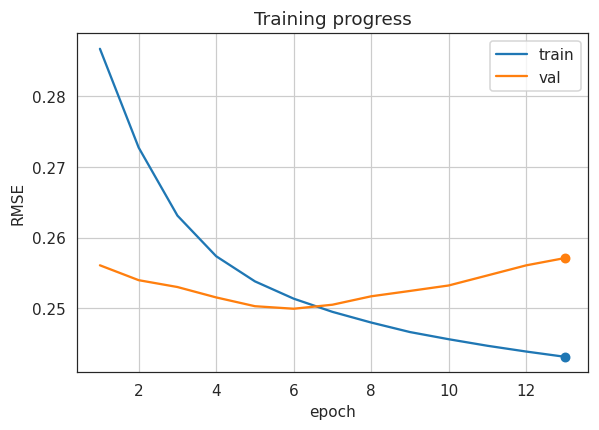

Epoch 1:   0%|          | 0/60 [00:07<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2868 MAE=0.2216 R2=0.0254 | Acc=0.7099 Prec=0.3173 Rec=0.0423 F1=0.0746 AUROC=0.5779
VALID→ RMSE=0.2561 MAE=0.1832 R2=0.2039 | Acc=0.7134 Prec=0.9675 Rec=0.0024 F1=0.0049 AUROC=0.7201


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2728 MAE=0.2109 R2=0.1183 | Acc=0.7242 Prec=0.5045 Rec=0.1695 F1=0.2538 AUROC=0.6428
VALID→ RMSE=0.2540 MAE=0.1848 R2=0.2170 | Acc=0.7436 Prec=0.7580 Rec=0.1578 F1=0.2612 AUROC=0.7400


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2631 MAE=0.2018 R2=0.1794 | Acc=0.7447 Prec=0.5935 Rec=0.2452 F1=0.3470 AUROC=0.6953
VALID→ RMSE=0.2530 MAE=0.1893 R2=0.2229 | Acc=0.7543 Prec=0.6706 Rec=0.2844 F1=0.3994 AUROC=0.7405


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2574 MAE=0.1974 R2=0.2149 | Acc=0.7535 Prec=0.6120 Rec=0.2975 F1=0.4003 AUROC=0.7264
VALID→ RMSE=0.2515 MAE=0.1932 R2=0.2319 | Acc=0.7552 Prec=0.6494 Rec=0.3211 F1=0.4297 AUROC=0.7403


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2538 MAE=0.1944 R2=0.2365 | Acc=0.7583 Prec=0.6253 Rec=0.3154 F1=0.4193 AUROC=0.7417
VALID→ RMSE=0.2503 MAE=0.1926 R2=0.2395 | Acc=0.7560 Prec=0.6436 Rec=0.3374 F1=0.4427 AUROC=0.7425


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2514 MAE=0.1916 R2=0.2512 | Acc=0.7612 Prec=0.6321 Rec=0.3272 F1=0.4312 AUROC=0.7515
VALID→ RMSE=0.2499 MAE=0.1933 R2=0.2417 | Acc=0.7562 Prec=0.6399 Rec=0.3459 F1=0.4490 AUROC=0.7445


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2495 MAE=0.1901 R2=0.2623 | Acc=0.7638 Prec=0.6352 Rec=0.3432 F1=0.4456 AUROC=0.7577
VALID→ RMSE=0.2505 MAE=0.1931 R2=0.2382 | Acc=0.7549 Prec=0.6342 Rec=0.3475 F1=0.4490 AUROC=0.7446


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2480 MAE=0.1887 R2=0.2712 | Acc=0.7656 Prec=0.6387 Rec=0.3517 F1=0.4536 AUROC=0.7624
VALID→ RMSE=0.2517 MAE=0.1941 R2=0.2310 | Acc=0.7526 Prec=0.6250 Rec=0.3471 F1=0.4464 AUROC=0.7424


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2466 MAE=0.1873 R2=0.2791 | Acc=0.7673 Prec=0.6421 Rec=0.3589 F1=0.4605 AUROC=0.7665
VALID→ RMSE=0.2525 MAE=0.1942 R2=0.2263 | Acc=0.7509 Prec=0.6200 Rec=0.3435 F1=0.4421 AUROC=0.7426


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2456 MAE=0.1864 R2=0.2850 | Acc=0.7684 Prec=0.6431 Rec=0.3659 F1=0.4664 AUROC=0.7696
VALID→ RMSE=0.2532 MAE=0.1926 R2=0.2216 | Acc=0.7503 Prec=0.6265 Rec=0.3243 F1=0.4274 AUROC=0.7417


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2447 MAE=0.1858 R2=0.2904 | Acc=0.7700 Prec=0.6441 Rec=0.3764 F1=0.4751 AUROC=0.7726
VALID→ RMSE=0.2546 MAE=0.1952 R2=0.2128 | Acc=0.7466 Prec=0.6048 Rec=0.3402 F1=0.4355 AUROC=0.7395


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.2439 MAE=0.1851 R2=0.2951 | Acc=0.7709 Prec=0.6445 Rec=0.3830 F1=0.4805 AUROC=0.7750
VALID→ RMSE=0.2561 MAE=0.1964 R2=0.2039 | Acc=0.7436 Prec=0.5918 Rec=0.3466 F1=0.4372 AUROC=0.7367


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.2431 MAE=0.1844 R2=0.2994 | Acc=0.7721 Prec=0.6474 Rec=0.3868 F1=0.4843 AUROC=0.7771
VALID→ RMSE=0.2571 MAE=0.1975 R2=0.1975 | Acc=0.7418 Prec=0.5852 Rec=0.3476 F1=0.4362 AUROC=0.7347
Early stopping at epoch 13
✅ Final best model (_fin) saved: AAPL_0.24993_fin.pth
Delete variables to free memory...


[I 2025-09-22 18:09:10,113] Trial 3 finished with value: 0.24993133544921875 and parameters: {'look_back': 60, 'DROPOUT_SHORT': 0.10368048498841126, 'DROPOUT_LONG': 0.25217001032657316, 'ATT_DROPOUT': 0.1482064844690726, 'INITIAL_LR': 0.00022776483772193762, 'ETA_MIN': 8.00681591344093e-06, 'WEIGHT_DECAY': 1.2109701288680165e-05, 'CLIPNORM': 3.0753057231958563}. Best is trial 0 with value: 0.24915120005607605.



▶ Trial 4 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.2783816105460393, 'DROPOUT_LONG': 0.19290312549230992, 'ATT_DROPOUT': 0.2561970297036895, 'INITIAL_LR': 0.00013212525276602217, 'ETA_MIN': 7.522513871615166e-06, 'WEIGHT_DECAY': 0.00011624659795437956, 'CLIPNORM': 0.1432683835708431}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


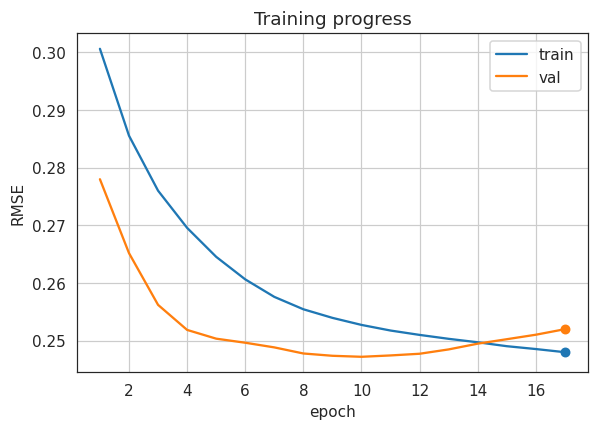

Epoch 1:   0%|          | 0/60 [00:03<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.3006 MAE=0.2333 R2=-0.0747 | Acc=0.7134 Prec=0.3886 Rec=0.1184 F1=0.1815 AUROC=0.5970
VALID→ RMSE=0.2780 MAE=0.1888 R2=0.0365 | Acc=0.7266 Prec=0.7368 Rec=0.0005 F1=0.0011 AUROC=0.7062


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2855 MAE=0.2215 R2=0.0303 | Acc=0.7181 Prec=0.4108 Rec=0.1164 F1=0.1814 AUROC=0.5665
VALID→ RMSE=0.2652 MAE=0.1843 R2=0.1233 | Acc=0.7288 Prec=0.8137 Rec=0.0109 F1=0.0214 AUROC=0.7311


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2760 MAE=0.2138 R2=0.0940 | Acc=0.7345 Prec=0.5248 Rec=0.1134 F1=0.1866 AUROC=0.6046
VALID→ RMSE=0.2562 MAE=0.1811 R2=0.1817 | Acc=0.7456 Prec=0.7550 Rec=0.1029 F1=0.1811 AUROC=0.7425


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2695 MAE=0.2083 R2=0.1359 | Acc=0.7440 Prec=0.5745 Rec=0.1784 F1=0.2723 AUROC=0.6542
VALID→ RMSE=0.2518 MAE=0.1806 R2=0.2092 | Acc=0.7542 Prec=0.7144 Rec=0.1687 F1=0.2730 AUROC=0.7473


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2645 MAE=0.2039 R2=0.1678 | Acc=0.7511 Prec=0.5954 Rec=0.2261 F1=0.3278 AUROC=0.6879
VALID→ RMSE=0.2503 MAE=0.1805 R2=0.2187 | Acc=0.7581 Prec=0.6976 Rec=0.2037 F1=0.3154 AUROC=0.7487


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2606 MAE=0.2005 R2=0.1922 | Acc=0.7564 Prec=0.6093 Rec=0.2575 F1=0.3620 AUROC=0.7105
VALID→ RMSE=0.2496 MAE=0.1800 R2=0.2231 | Acc=0.7600 Prec=0.6917 Rec=0.2210 F1=0.3350 AUROC=0.7499


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2576 MAE=0.1970 R2=0.2109 | Acc=0.7600 Prec=0.6188 Rec=0.2754 F1=0.3812 AUROC=0.7259
VALID→ RMSE=0.2488 MAE=0.1796 R2=0.2281 | Acc=0.7620 Prec=0.6846 Rec=0.2402 F1=0.3557 AUROC=0.7521


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2554 MAE=0.1944 R2=0.2241 | Acc=0.7626 Prec=0.6260 Rec=0.2867 F1=0.3933 AUROC=0.7361
VALID→ RMSE=0.2477 MAE=0.1804 R2=0.2347 | Acc=0.7630 Prec=0.6785 Rec=0.2534 F1=0.3690 AUROC=0.7533


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2539 MAE=0.1928 R2=0.2331 | Acc=0.7638 Prec=0.6270 Rec=0.2961 F1=0.4023 AUROC=0.7431
VALID→ RMSE=0.2473 MAE=0.1808 R2=0.2371 | Acc=0.7633 Prec=0.6757 Rec=0.2587 F1=0.3741 AUROC=0.7538


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2527 MAE=0.1917 R2=0.2405 | Acc=0.7649 Prec=0.6287 Rec=0.3029 F1=0.4088 AUROC=0.7480
VALID→ RMSE=0.2472 MAE=0.1814 R2=0.2382 | Acc=0.7633 Prec=0.6713 Rec=0.2631 F1=0.3780 AUROC=0.7535


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2517 MAE=0.1910 R2=0.2463 | Acc=0.7656 Prec=0.6281 Rec=0.3106 F1=0.4157 AUROC=0.7515
VALID→ RMSE=0.2474 MAE=0.1820 R2=0.2368 | Acc=0.7629 Prec=0.6668 Rec=0.2661 F1=0.3804 AUROC=0.7527


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.2510 MAE=0.1902 R2=0.2508 | Acc=0.7663 Prec=0.6280 Rec=0.3174 F1=0.4216 AUROC=0.7544
VALID→ RMSE=0.2477 MAE=0.1825 R2=0.2349 | Acc=0.7622 Prec=0.6605 Rec=0.2681 F1=0.3814 AUROC=0.7514


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.2503 MAE=0.1897 R2=0.2549 | Acc=0.7669 Prec=0.6287 Rec=0.3210 F1=0.4250 AUROC=0.7566
VALID→ RMSE=0.2485 MAE=0.1829 R2=0.2303 | Acc=0.7613 Prec=0.6592 Rec=0.2634 F1=0.3764 AUROC=0.7501


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ RMSE=0.2497 MAE=0.1891 R2=0.2585 | Acc=0.7675 Prec=0.6297 Rec=0.3248 F1=0.4286 AUROC=0.7587
VALID→ RMSE=0.2495 MAE=0.1828 R2=0.2241 | Acc=0.7603 Prec=0.6600 Rec=0.2543 F1=0.3671 AUROC=0.7488


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ RMSE=0.2490 MAE=0.1884 R2=0.2625 | Acc=0.7685 Prec=0.6325 Rec=0.3276 F1=0.4316 AUROC=0.7608
VALID→ RMSE=0.2502 MAE=0.1831 R2=0.2193 | Acc=0.7594 Prec=0.6587 Rec=0.2495 F1=0.3619 AUROC=0.7476


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ RMSE=0.2485 MAE=0.1878 R2=0.2654 | Acc=0.7687 Prec=0.6329 Rec=0.3291 F1=0.4331 AUROC=0.7623
VALID→ RMSE=0.2510 MAE=0.1832 R2=0.2144 | Acc=0.7586 Prec=0.6551 Rec=0.2472 F1=0.3589 AUROC=0.7466


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ RMSE=0.2480 MAE=0.1872 R2=0.2686 | Acc=0.7697 Prec=0.6356 Rec=0.3325 F1=0.4366 AUROC=0.7641
VALID→ RMSE=0.2520 MAE=0.1834 R2=0.2084 | Acc=0.7575 Prec=0.6543 Rec=0.2399 F1=0.3511 AUROC=0.7454
Early stopping at epoch 17
✅ Final best model (_fin) saved: AAPL_0.24717_fin.pth
Delete variables to free memory...


[I 2025-09-22 18:24:40,813] Trial 4 finished with value: 0.2471747100353241 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.2783816105460393, 'DROPOUT_LONG': 0.19290312549230992, 'ATT_DROPOUT': 0.2561970297036895, 'INITIAL_LR': 0.00013212525276602217, 'ETA_MIN': 7.522513871615166e-06, 'WEIGHT_DECAY': 0.00011624659795437956, 'CLIPNORM': 0.1432683835708431}. Best is trial 4 with value: 0.2471747100353241.



▶ Trial 5 starting with:
{'look_back': 60, 'DROPOUT_SHORT': 0.24950837705113055, 'DROPOUT_LONG': 0.17869525692702087, 'ATT_DROPOUT': 0.24995898428394597, 'INITIAL_LR': 0.0001141782687222364, 'ETA_MIN': 2.4620249812181806e-06, 'WEIGHT_DECAY': 6.995345738022024e-05, 'CLIPNORM': 2.82488578997751}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


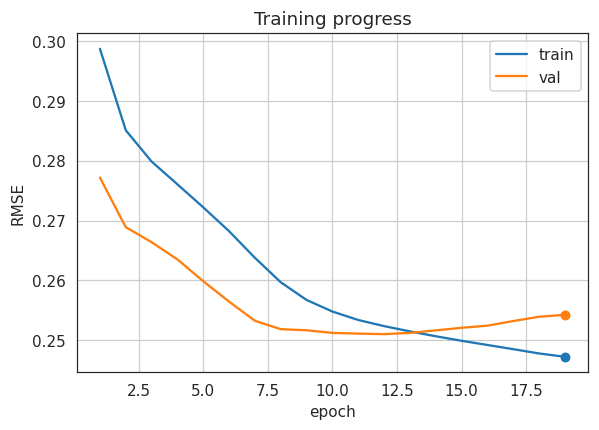

Epoch 1:   0%|          | 0/60 [00:02<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2987 MAE=0.2317 R2=-0.0572 | Acc=0.7098 Prec=0.4017 Rec=0.1000 F1=0.1601 AUROC=0.5985
VALID→ RMSE=0.2772 MAE=0.1912 R2=0.0674 | Acc=0.7128 Prec=0.7800 Rec=0.0004 F1=0.0008 AUROC=0.6841


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2851 MAE=0.2211 R2=0.0368 | Acc=0.7213 Prec=0.4618 Rec=0.0461 F1=0.0839 AUROC=0.5624
VALID→ RMSE=0.2689 MAE=0.1873 R2=0.1223 | Acc=0.7176 Prec=0.8140 Rec=0.0219 F1=0.0427 AUROC=0.7177


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2798 MAE=0.2172 R2=0.0718 | Acc=0.7269 Prec=0.5471 Rec=0.0744 F1=0.1309 AUROC=0.6050
VALID→ RMSE=0.2664 MAE=0.1856 R2=0.1385 | Acc=0.7327 Prec=0.7373 Rec=0.1079 F1=0.1882 AUROC=0.7311


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2760 MAE=0.2139 R2=0.0969 | Acc=0.7319 Prec=0.5628 Rec=0.1384 F1=0.2222 AUROC=0.6397
VALID→ RMSE=0.2635 MAE=0.1845 R2=0.1570 | Acc=0.7411 Prec=0.7060 Rec=0.1696 F1=0.2735 AUROC=0.7369


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2722 MAE=0.2110 R2=0.1218 | Acc=0.7364 Prec=0.5704 Rec=0.1911 F1=0.2862 AUROC=0.6607
VALID→ RMSE=0.2599 MAE=0.1840 R2=0.1802 | Acc=0.7459 Prec=0.6962 Rec=0.2052 F1=0.3170 AUROC=0.7404


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2682 MAE=0.2084 R2=0.1473 | Acc=0.7401 Prec=0.5744 Rec=0.2337 F1=0.3322 AUROC=0.6772
VALID→ RMSE=0.2565 MAE=0.1842 R2=0.2015 | Acc=0.7484 Prec=0.6858 Rec=0.2291 F1=0.3434 AUROC=0.7426


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2638 MAE=0.2044 R2=0.1754 | Acc=0.7439 Prec=0.5800 Rec=0.2696 F1=0.3681 AUROC=0.6944
VALID→ RMSE=0.2533 MAE=0.1859 R2=0.2214 | Acc=0.7506 Prec=0.6756 Rec=0.2538 F1=0.3690 AUROC=0.7436


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2597 MAE=0.1999 R2=0.2007 | Acc=0.7497 Prec=0.6005 Rec=0.2843 F1=0.3859 AUROC=0.7137
VALID→ RMSE=0.2519 MAE=0.1884 R2=0.2300 | Acc=0.7518 Prec=0.6721 Rec=0.2661 F1=0.3812 AUROC=0.7433


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2567 MAE=0.1965 R2=0.2188 | Acc=0.7541 Prec=0.6211 Rec=0.2850 F1=0.3907 AUROC=0.7284
VALID→ RMSE=0.2517 MAE=0.1882 R2=0.2310 | Acc=0.7528 Prec=0.6670 Rec=0.2787 F1=0.3931 AUROC=0.7436


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2548 MAE=0.1942 R2=0.2305 | Acc=0.7569 Prec=0.6294 Rec=0.2951 F1=0.4018 AUROC=0.7389
VALID→ RMSE=0.2512 MAE=0.1883 R2=0.2337 | Acc=0.7538 Prec=0.6619 Rec=0.2927 F1=0.4059 AUROC=0.7442


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2534 MAE=0.1932 R2=0.2390 | Acc=0.7586 Prec=0.6307 Rec=0.3075 F1=0.4135 AUROC=0.7450
VALID→ RMSE=0.2511 MAE=0.1886 R2=0.2344 | Acc=0.7540 Prec=0.6582 Rec=0.2993 F1=0.4115 AUROC=0.7445


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.2524 MAE=0.1921 R2=0.2451 | Acc=0.7598 Prec=0.6315 Rec=0.3165 F1=0.4217 AUROC=0.7491
VALID→ RMSE=0.2510 MAE=0.1890 R2=0.2350 | Acc=0.7536 Prec=0.6532 Rec=0.3037 F1=0.4147 AUROC=0.7447


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.2515 MAE=0.1913 R2=0.2504 | Acc=0.7608 Prec=0.6317 Rec=0.3244 F1=0.4287 AUROC=0.7526
VALID→ RMSE=0.2512 MAE=0.1899 R2=0.2337 | Acc=0.7535 Prec=0.6476 Rec=0.3115 F1=0.4206 AUROC=0.7446


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ RMSE=0.2507 MAE=0.1905 R2=0.2552 | Acc=0.7616 Prec=0.6324 Rec=0.3305 F1=0.4341 AUROC=0.7556
VALID→ RMSE=0.2517 MAE=0.1911 R2=0.2311 | Acc=0.7527 Prec=0.6404 Rec=0.3179 F1=0.4249 AUROC=0.7443


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ RMSE=0.2499 MAE=0.1899 R2=0.2597 | Acc=0.7624 Prec=0.6320 Rec=0.3381 F1=0.4405 AUROC=0.7579
VALID→ RMSE=0.2521 MAE=0.1917 R2=0.2285 | Acc=0.7525 Prec=0.6367 Rec=0.3228 F1=0.4284 AUROC=0.7439


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ RMSE=0.2492 MAE=0.1895 R2=0.2638 | Acc=0.7633 Prec=0.6327 Rec=0.3444 F1=0.4460 AUROC=0.7601
VALID→ RMSE=0.2525 MAE=0.1921 R2=0.2263 | Acc=0.7521 Prec=0.6339 Rec=0.3249 F1=0.4296 AUROC=0.7437


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ RMSE=0.2485 MAE=0.1889 R2=0.2679 | Acc=0.7640 Prec=0.6328 Rec=0.3498 F1=0.4506 AUROC=0.7621
VALID→ RMSE=0.2532 MAE=0.1923 R2=0.2216 | Acc=0.7510 Prec=0.6292 Rec=0.3247 F1=0.4283 AUROC=0.7426


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ RMSE=0.2478 MAE=0.1885 R2=0.2722 | Acc=0.7646 Prec=0.6328 Rec=0.3555 F1=0.4552 AUROC=0.7642
VALID→ RMSE=0.2539 MAE=0.1931 R2=0.2172 | Acc=0.7501 Prec=0.6238 Rec=0.3277 F1=0.4296 AUROC=0.7416


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ RMSE=0.2473 MAE=0.1881 R2=0.2754 | Acc=0.7656 Prec=0.6338 Rec=0.3614 F1=0.4603 AUROC=0.7660
VALID→ RMSE=0.2543 MAE=0.1929 R2=0.2152 | Acc=0.7492 Prec=0.6194 Rec=0.3291 F1=0.4298 AUROC=0.7413
Early stopping at epoch 19
✅ Final best model (_fin) saved: AAPL_0.25104_fin.pth
Delete variables to free memory...


[I 2025-09-22 18:40:32,248] Trial 5 finished with value: 0.2510370910167694 and parameters: {'look_back': 60, 'DROPOUT_SHORT': 0.24950837705113055, 'DROPOUT_LONG': 0.17869525692702087, 'ATT_DROPOUT': 0.24995898428394597, 'INITIAL_LR': 0.0001141782687222364, 'ETA_MIN': 2.4620249812181806e-06, 'WEIGHT_DECAY': 6.995345738022024e-05, 'CLIPNORM': 2.82488578997751}. Best is trial 4 with value: 0.2471747100353241.



▶ Trial 6 starting with:
{'look_back': 90, 'DROPOUT_SHORT': 0.18143795194641404, 'DROPOUT_LONG': 0.08322300561526358, 'ATT_DROPOUT': 0.15955529623895923, 'INITIAL_LR': 3.756153640116853e-05, 'ETA_MIN': 1.1837022984727954e-06, 'WEIGHT_DECAY': 4.028463003086175e-05, 'CLIPNORM': 6.560048129964715}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


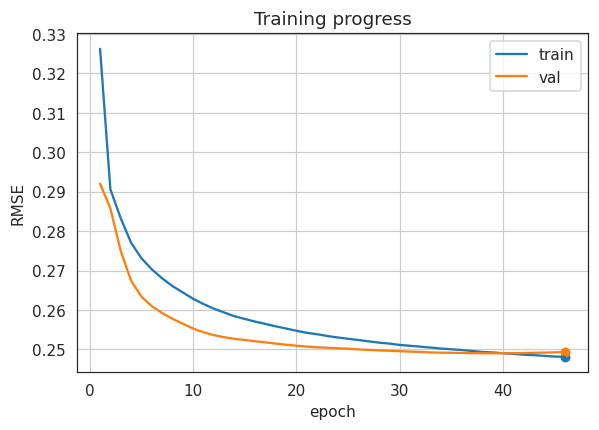

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.3263 MAE=0.2758 R2=-0.2670 | Acc=0.3444 Prec=0.2730 Rec=0.8445 F1=0.4126 AUROC=0.5031
VALID→ RMSE=0.2920 MAE=0.2064 R2=-0.0497 | Acc=0.4899 Prec=0.2454 Rec=0.3946 F1=0.3026 AUROC=0.4523


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2906 MAE=0.2224 R2=-0.0054 | Acc=0.6967 Prec=0.3053 Rec=0.0881 F1=0.1368 AUROC=0.5249
VALID→ RMSE=0.2858 MAE=0.1975 R2=-0.0050 | Acc=0.7196 Prec=0.6265 Rec=0.0005 F1=0.0010 AUROC=0.5335


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2833 MAE=0.2151 R2=0.0448 | Acc=0.7263 Prec=0.3775 Rec=0.0060 F1=0.0118 AUROC=0.5068
VALID→ RMSE=0.2750 MAE=0.1907 R2=0.0695 | Acc=0.7198 Prec=0.8846 Rec=0.0009 F1=0.0018 AUROC=0.6117


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2771 MAE=0.2117 R2=0.0862 | Acc=0.7274 Prec=0.5011 Rec=0.0101 F1=0.0198 AUROC=0.5323
VALID→ RMSE=0.2675 MAE=0.1864 R2=0.1196 | Acc=0.7224 Prec=0.8847 Rec=0.0117 F1=0.0230 AUROC=0.6568


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2731 MAE=0.2094 R2=0.1120 | Acc=0.7287 Prec=0.5641 Rec=0.0212 F1=0.0409 AUROC=0.5629
VALID→ RMSE=0.2634 MAE=0.1842 R2=0.1461 | Acc=0.7287 Prec=0.8401 Rec=0.0401 F1=0.0766 AUROC=0.6862


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2703 MAE=0.2074 R2=0.1302 | Acc=0.7312 Prec=0.6022 Rec=0.0415 F1=0.0777 AUROC=0.5899
VALID→ RMSE=0.2610 MAE=0.1832 R2=0.1617 | Acc=0.7366 Prec=0.7996 Rec=0.0812 F1=0.1474 AUROC=0.7052


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2680 MAE=0.2057 R2=0.1447 | Acc=0.7343 Prec=0.6149 Rec=0.0685 F1=0.1233 AUROC=0.6127
VALID→ RMSE=0.2592 MAE=0.1827 R2=0.1728 | Acc=0.7433 Prec=0.7606 Rec=0.1236 F1=0.2127 AUROC=0.7174


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2661 MAE=0.2044 R2=0.1573 | Acc=0.7378 Prec=0.6179 Rec=0.1002 F1=0.1725 AUROC=0.6321
VALID→ RMSE=0.2578 MAE=0.1825 R2=0.1822 | Acc=0.7485 Prec=0.7364 Rec=0.1607 F1=0.2638 AUROC=0.7254


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2645 MAE=0.2034 R2=0.1675 | Acc=0.7415 Prec=0.6209 Rec=0.1332 F1=0.2194 AUROC=0.6474
VALID→ RMSE=0.2565 MAE=0.1825 R2=0.1901 | Acc=0.7518 Prec=0.7151 Rec=0.1912 F1=0.3017 AUROC=0.7308


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2629 MAE=0.2022 R2=0.1775 | Acc=0.7442 Prec=0.6178 Rec=0.1623 F1=0.2570 AUROC=0.6615
VALID→ RMSE=0.2553 MAE=0.1827 R2=0.1978 | Acc=0.7543 Prec=0.7010 Rec=0.2157 F1=0.3298 AUROC=0.7346


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2615 MAE=0.2007 R2=0.1859 | Acc=0.7469 Prec=0.6213 Rec=0.1841 F1=0.2840 AUROC=0.6741
VALID→ RMSE=0.2544 MAE=0.1830 R2=0.2036 | Acc=0.7556 Prec=0.6922 Rec=0.2315 F1=0.3470 AUROC=0.7372


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.2603 MAE=0.1993 R2=0.1932 | Acc=0.7494 Prec=0.6267 Rec=0.2002 F1=0.3035 AUROC=0.6839
VALID→ RMSE=0.2536 MAE=0.1835 R2=0.2083 | Acc=0.7566 Prec=0.6859 Rec=0.2438 F1=0.3597 AUROC=0.7392


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.2594 MAE=0.1983 R2=0.1992 | Acc=0.7512 Prec=0.6292 Rec=0.2127 F1=0.3179 AUROC=0.6929
VALID→ RMSE=0.2531 MAE=0.1838 R2=0.2116 | Acc=0.7572 Prec=0.6806 Rec=0.2529 F1=0.3688 AUROC=0.7407


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ RMSE=0.2584 MAE=0.1972 R2=0.2051 | Acc=0.7526 Prec=0.6312 Rec=0.2230 F1=0.3296 AUROC=0.7003
VALID→ RMSE=0.2527 MAE=0.1841 R2=0.2141 | Acc=0.7580 Prec=0.6772 Rec=0.2617 F1=0.3775 AUROC=0.7420


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ RMSE=0.2577 MAE=0.1966 R2=0.2093 | Acc=0.7540 Prec=0.6336 Rec=0.2316 F1=0.3393 AUROC=0.7066
VALID→ RMSE=0.2524 MAE=0.1843 R2=0.2160 | Acc=0.7586 Prec=0.6742 Rec=0.2689 F1=0.3845 AUROC=0.7429


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ RMSE=0.2571 MAE=0.1959 R2=0.2134 | Acc=0.7549 Prec=0.6342 Rec=0.2388 F1=0.3470 AUROC=0.7115
VALID→ RMSE=0.2521 MAE=0.1845 R2=0.2179 | Acc=0.7587 Prec=0.6707 Rec=0.2743 F1=0.3893 AUROC=0.7437


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ RMSE=0.2565 MAE=0.1954 R2=0.2171 | Acc=0.7557 Prec=0.6349 Rec=0.2451 F1=0.3536 AUROC=0.7160
VALID→ RMSE=0.2518 MAE=0.1845 R2=0.2197 | Acc=0.7590 Prec=0.6687 Rec=0.2785 F1=0.3932 AUROC=0.7445


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ RMSE=0.2559 MAE=0.1949 R2=0.2208 | Acc=0.7565 Prec=0.6350 Rec=0.2518 F1=0.3606 AUROC=0.7198
VALID→ RMSE=0.2515 MAE=0.1846 R2=0.2217 | Acc=0.7593 Prec=0.6672 Rec=0.2827 F1=0.3971 AUROC=0.7452


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ RMSE=0.2553 MAE=0.1944 R2=0.2242 | Acc=0.7571 Prec=0.6350 Rec=0.2569 F1=0.3658 AUROC=0.7237
VALID→ RMSE=0.2512 MAE=0.1845 R2=0.2234 | Acc=0.7595 Prec=0.6658 Rec=0.2859 F1=0.4000 AUROC=0.7461


Epoch 20:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ RMSE=0.2547 MAE=0.1940 R2=0.2277 | Acc=0.7579 Prec=0.6354 Rec=0.2626 F1=0.3716 AUROC=0.7266
VALID→ RMSE=0.2509 MAE=0.1846 R2=0.2251 | Acc=0.7598 Prec=0.6644 Rec=0.2899 F1=0.4037 AUROC=0.7470


Epoch 21:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ RMSE=0.2542 MAE=0.1935 R2=0.2308 | Acc=0.7583 Prec=0.6344 Rec=0.2675 F1=0.3763 AUROC=0.7301
VALID→ RMSE=0.2507 MAE=0.1846 R2=0.2263 | Acc=0.7600 Prec=0.6637 Rec=0.2919 F1=0.4055 AUROC=0.7478


Epoch 22:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ RMSE=0.2539 MAE=0.1932 R2=0.2329 | Acc=0.7589 Prec=0.6353 Rec=0.2720 F1=0.3809 AUROC=0.7328
VALID→ RMSE=0.2505 MAE=0.1846 R2=0.2274 | Acc=0.7602 Prec=0.6633 Rec=0.2939 F1=0.4073 AUROC=0.7485


Epoch 23:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ RMSE=0.2534 MAE=0.1929 R2=0.2357 | Acc=0.7595 Prec=0.6356 Rec=0.2763 F1=0.3852 AUROC=0.7356
VALID→ RMSE=0.2504 MAE=0.1846 R2=0.2282 | Acc=0.7602 Prec=0.6623 Rec=0.2955 F1=0.4086 AUROC=0.7491


Epoch 24:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ RMSE=0.2530 MAE=0.1926 R2=0.2379 | Acc=0.7598 Prec=0.6351 Rec=0.2802 F1=0.3888 AUROC=0.7377
VALID→ RMSE=0.2503 MAE=0.1848 R2=0.2290 | Acc=0.7603 Prec=0.6615 Rec=0.2975 F1=0.4104 AUROC=0.7495


Epoch 25:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ RMSE=0.2527 MAE=0.1923 R2=0.2399 | Acc=0.7602 Prec=0.6347 Rec=0.2843 F1=0.3927 AUROC=0.7395
VALID→ RMSE=0.2502 MAE=0.1848 R2=0.2297 | Acc=0.7603 Prec=0.6612 Rec=0.2981 F1=0.4110 AUROC=0.7500


Epoch 26:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 026
TRAIN→ RMSE=0.2524 MAE=0.1921 R2=0.2418 | Acc=0.7607 Prec=0.6352 Rec=0.2876 F1=0.3959 AUROC=0.7414
VALID→ RMSE=0.2500 MAE=0.1847 R2=0.2308 | Acc=0.7604 Prec=0.6604 Rec=0.2994 F1=0.4121 AUROC=0.7505


Epoch 27:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 027
TRAIN→ RMSE=0.2520 MAE=0.1918 R2=0.2438 | Acc=0.7609 Prec=0.6343 Rec=0.2908 F1=0.3987 AUROC=0.7433
VALID→ RMSE=0.2499 MAE=0.1847 R2=0.2315 | Acc=0.7605 Prec=0.6603 Rec=0.3003 F1=0.4128 AUROC=0.7509


Epoch 28:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 028
TRAIN→ RMSE=0.2517 MAE=0.1915 R2=0.2458 | Acc=0.7612 Prec=0.6345 Rec=0.2933 F1=0.4011 AUROC=0.7448
VALID→ RMSE=0.2498 MAE=0.1848 R2=0.2323 | Acc=0.7604 Prec=0.6592 Rec=0.3011 F1=0.4134 AUROC=0.7511


Epoch 29:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 029
TRAIN→ RMSE=0.2515 MAE=0.1913 R2=0.2472 | Acc=0.7616 Prec=0.6344 Rec=0.2965 F1=0.4041 AUROC=0.7462
VALID→ RMSE=0.2497 MAE=0.1846 R2=0.2329 | Acc=0.7603 Prec=0.6591 Rec=0.3006 F1=0.4129 AUROC=0.7515


Epoch 30:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 030
TRAIN→ RMSE=0.2511 MAE=0.1910 R2=0.2493 | Acc=0.7619 Prec=0.6349 Rec=0.2984 F1=0.4060 AUROC=0.7475
VALID→ RMSE=0.2496 MAE=0.1847 R2=0.2335 | Acc=0.7603 Prec=0.6588 Rec=0.3013 F1=0.4135 AUROC=0.7517


Epoch 31:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 031
TRAIN→ RMSE=0.2509 MAE=0.1908 R2=0.2506 | Acc=0.7622 Prec=0.6350 Rec=0.3006 F1=0.4080 AUROC=0.7490
VALID→ RMSE=0.2494 MAE=0.1846 R2=0.2342 | Acc=0.7603 Prec=0.6582 Rec=0.3021 F1=0.4142 AUROC=0.7520


Epoch 32:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 032
TRAIN→ RMSE=0.2507 MAE=0.1906 R2=0.2519 | Acc=0.7626 Prec=0.6352 Rec=0.3034 F1=0.4107 AUROC=0.7498
VALID→ RMSE=0.2494 MAE=0.1847 R2=0.2347 | Acc=0.7603 Prec=0.6579 Rec=0.3024 F1=0.4144 AUROC=0.7522


Epoch 33:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 033
TRAIN→ RMSE=0.2505 MAE=0.1904 R2=0.2533 | Acc=0.7629 Prec=0.6354 Rec=0.3064 F1=0.4134 AUROC=0.7511
VALID→ RMSE=0.2492 MAE=0.1846 R2=0.2355 | Acc=0.7602 Prec=0.6574 Rec=0.3024 F1=0.4142 AUROC=0.7525


Epoch 34:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 034
TRAIN→ RMSE=0.2502 MAE=0.1902 R2=0.2548 | Acc=0.7631 Prec=0.6352 Rec=0.3083 F1=0.4151 AUROC=0.7519
VALID→ RMSE=0.2492 MAE=0.1847 R2=0.2359 | Acc=0.7601 Prec=0.6567 Rec=0.3029 F1=0.4145 AUROC=0.7525


Epoch 35:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 035
TRAIN→ RMSE=0.2500 MAE=0.1901 R2=0.2558 | Acc=0.7634 Prec=0.6354 Rec=0.3101 F1=0.4168 AUROC=0.7528
VALID→ RMSE=0.2491 MAE=0.1846 R2=0.2360 | Acc=0.7601 Prec=0.6568 Rec=0.3024 F1=0.4142 AUROC=0.7526


Epoch 36:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 036
TRAIN→ RMSE=0.2498 MAE=0.1899 R2=0.2570 | Acc=0.7637 Prec=0.6362 Rec=0.3114 F1=0.4181 AUROC=0.7536
VALID→ RMSE=0.2491 MAE=0.1846 R2=0.2363 | Acc=0.7600 Prec=0.6560 Rec=0.3028 F1=0.4144 AUROC=0.7527


Epoch 37:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 037
TRAIN→ RMSE=0.2496 MAE=0.1897 R2=0.2584 | Acc=0.7639 Prec=0.6358 Rec=0.3134 F1=0.4198 AUROC=0.7547
VALID→ RMSE=0.2491 MAE=0.1846 R2=0.2366 | Acc=0.7599 Prec=0.6560 Rec=0.3026 F1=0.4142 AUROC=0.7527


Epoch 38:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 038
TRAIN→ RMSE=0.2493 MAE=0.1895 R2=0.2599 | Acc=0.7639 Prec=0.6350 Rec=0.3153 F1=0.4213 AUROC=0.7554
VALID→ RMSE=0.2490 MAE=0.1847 R2=0.2367 | Acc=0.7599 Prec=0.6555 Rec=0.3029 F1=0.4143 AUROC=0.7526


Epoch 39:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 039
TRAIN→ RMSE=0.2492 MAE=0.1893 R2=0.2606 | Acc=0.7644 Prec=0.6365 Rec=0.3166 F1=0.4228 AUROC=0.7562
VALID→ RMSE=0.2490 MAE=0.1847 R2=0.2368 | Acc=0.7598 Prec=0.6545 Rec=0.3035 F1=0.4147 AUROC=0.7526


Epoch 40:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 040
TRAIN→ RMSE=0.2490 MAE=0.1892 R2=0.2618 | Acc=0.7647 Prec=0.6367 Rec=0.3187 F1=0.4247 AUROC=0.7568
VALID→ RMSE=0.2490 MAE=0.1848 R2=0.2367 | Acc=0.7596 Prec=0.6538 Rec=0.3035 F1=0.4146 AUROC=0.7526


Epoch 41:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 041
TRAIN→ RMSE=0.2489 MAE=0.1890 R2=0.2628 | Acc=0.7646 Prec=0.6361 Rec=0.3196 F1=0.4254 AUROC=0.7573
VALID→ RMSE=0.2490 MAE=0.1848 R2=0.2366 | Acc=0.7595 Prec=0.6535 Rec=0.3033 F1=0.4143 AUROC=0.7525


Epoch 42:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 042
TRAIN→ RMSE=0.2486 MAE=0.1888 R2=0.2641 | Acc=0.7648 Prec=0.6363 Rec=0.3208 F1=0.4266 AUROC=0.7580
VALID→ RMSE=0.2491 MAE=0.1849 R2=0.2364 | Acc=0.7595 Prec=0.6527 Rec=0.3038 F1=0.4147 AUROC=0.7523


Epoch 43:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 043
TRAIN→ RMSE=0.2485 MAE=0.1887 R2=0.2647 | Acc=0.7653 Prec=0.6372 Rec=0.3230 F1=0.4287 AUROC=0.7586
VALID→ RMSE=0.2491 MAE=0.1849 R2=0.2360 | Acc=0.7593 Prec=0.6522 Rec=0.3037 F1=0.4144 AUROC=0.7522


Epoch 44:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 044
TRAIN→ RMSE=0.2484 MAE=0.1886 R2=0.2657 | Acc=0.7654 Prec=0.6372 Rec=0.3238 F1=0.4294 AUROC=0.7592
VALID→ RMSE=0.2492 MAE=0.1849 R2=0.2357 | Acc=0.7593 Prec=0.6517 Rec=0.3042 F1=0.4148 AUROC=0.7521


Epoch 45:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 045
TRAIN→ RMSE=0.2482 MAE=0.1884 R2=0.2668 | Acc=0.7657 Prec=0.6381 Rec=0.3251 F1=0.4307 AUROC=0.7600
VALID→ RMSE=0.2493 MAE=0.1850 R2=0.2353 | Acc=0.7592 Prec=0.6511 Rec=0.3041 F1=0.4146 AUROC=0.7518


Epoch 46:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 046
TRAIN→ RMSE=0.2481 MAE=0.1884 R2=0.2671 | Acc=0.7657 Prec=0.6374 Rec=0.3264 F1=0.4318 AUROC=0.7602
VALID→ RMSE=0.2493 MAE=0.1850 R2=0.2350 | Acc=0.7590 Prec=0.6505 Rec=0.3036 F1=0.4140 AUROC=0.7517
Early stopping at epoch 46
✅ Final best model (_fin) saved: AAPL_0.24901_fin.pth
Delete variables to free memory...


[I 2025-09-22 19:16:23,831] Trial 6 finished with value: 0.24901330471038818 and parameters: {'look_back': 90, 'DROPOUT_SHORT': 0.18143795194641404, 'DROPOUT_LONG': 0.08322300561526358, 'ATT_DROPOUT': 0.15955529623895923, 'INITIAL_LR': 3.756153640116853e-05, 'ETA_MIN': 1.1837022984727954e-06, 'WEIGHT_DECAY': 4.028463003086175e-05, 'CLIPNORM': 6.560048129964715}. Best is trial 4 with value: 0.2471747100353241.



▶ Trial 7 starting with:
{'look_back': 60, 'DROPOUT_SHORT': 0.15527086214728614, 'DROPOUT_LONG': 0.12545861145887346, 'ATT_DROPOUT': 0.07741363733036165, 'INITIAL_LR': 9.936312489662217e-05, 'ETA_MIN': 2.026990085258023e-06, 'WEIGHT_DECAY': 0.0011149595820260216, 'CLIPNORM': 3.9775235433073894}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


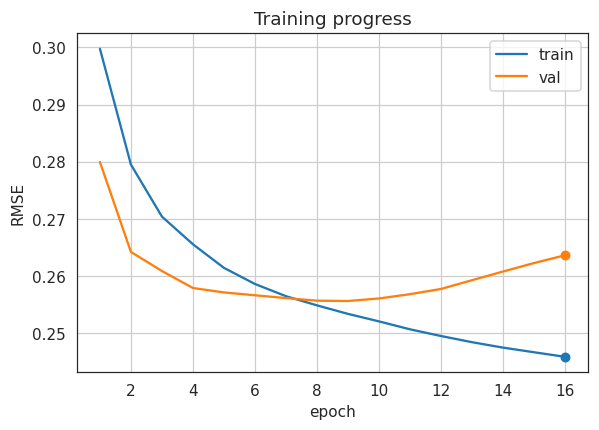

Epoch 1:   0%|          | 0/60 [00:02<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2998 MAE=0.2324 R2=-0.0650 | Acc=0.6717 Prec=0.3673 Rec=0.2584 F1=0.3034 AUROC=0.5952
VALID→ RMSE=0.2799 MAE=0.1931 R2=0.0487 | Acc=0.7127 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6440


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2795 MAE=0.2160 R2=0.0742 | Acc=0.7219 Prec=0.4605 Rec=0.0299 F1=0.0561 AUROC=0.5500
VALID→ RMSE=0.2642 MAE=0.1881 R2=0.1527 | Acc=0.7132 Prec=0.9541 Rec=0.0019 F1=0.0038 AUROC=0.7147


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2704 MAE=0.2091 R2=0.1336 | Acc=0.7302 Prec=0.5993 Rec=0.0741 F1=0.1319 AUROC=0.6231
VALID→ RMSE=0.2608 MAE=0.1862 R2=0.1740 | Acc=0.7273 Prec=0.8460 Rec=0.0620 F1=0.1156 AUROC=0.7354


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2655 MAE=0.2045 R2=0.1643 | Acc=0.7399 Prec=0.6115 Rec=0.1637 F1=0.2582 AUROC=0.6673
VALID→ RMSE=0.2579 MAE=0.1863 R2=0.1928 | Acc=0.7404 Prec=0.7656 Rec=0.1392 F1=0.2355 AUROC=0.7399


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2614 MAE=0.2009 R2=0.1901 | Acc=0.7472 Prec=0.6191 Rec=0.2241 F1=0.3291 AUROC=0.6949
VALID→ RMSE=0.2571 MAE=0.1864 R2=0.1976 | Acc=0.7459 Prec=0.7195 Rec=0.1892 F1=0.2997 AUROC=0.7411


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2586 MAE=0.1981 R2=0.2075 | Acc=0.7520 Prec=0.6253 Rec=0.2579 F1=0.3652 AUROC=0.7125
VALID→ RMSE=0.2566 MAE=0.1866 R2=0.2007 | Acc=0.7487 Prec=0.6941 Rec=0.2238 F1=0.3384 AUROC=0.7414


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2564 MAE=0.1959 R2=0.2206 | Acc=0.7554 Prec=0.6298 Rec=0.2810 F1=0.3886 AUROC=0.7263
VALID→ RMSE=0.2561 MAE=0.1868 R2=0.2038 | Acc=0.7505 Prec=0.6785 Rec=0.2502 F1=0.3656 AUROC=0.7412


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2548 MAE=0.1946 R2=0.2303 | Acc=0.7575 Prec=0.6300 Rec=0.2987 F1=0.4053 AUROC=0.7358
VALID→ RMSE=0.2557 MAE=0.1873 R2=0.2066 | Acc=0.7511 Prec=0.6670 Rec=0.2669 F1=0.3812 AUROC=0.7405


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2533 MAE=0.1934 R2=0.2393 | Acc=0.7594 Prec=0.6317 Rec=0.3121 F1=0.4177 AUROC=0.7422
VALID→ RMSE=0.2556 MAE=0.1877 R2=0.2070 | Acc=0.7514 Prec=0.6602 Rec=0.2774 F1=0.3907 AUROC=0.7396


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2520 MAE=0.1924 R2=0.2472 | Acc=0.7602 Prec=0.6320 Rec=0.3184 F1=0.4235 AUROC=0.7472
VALID→ RMSE=0.2560 MAE=0.1880 R2=0.2042 | Acc=0.7513 Prec=0.6565 Rec=0.2817 F1=0.3942 AUROC=0.7386


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2506 MAE=0.1912 R2=0.2555 | Acc=0.7616 Prec=0.6360 Rec=0.3235 F1=0.4289 AUROC=0.7517
VALID→ RMSE=0.2568 MAE=0.1886 R2=0.1995 | Acc=0.7508 Prec=0.6510 Rec=0.2862 F1=0.3976 AUROC=0.7372


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.2495 MAE=0.1900 R2=0.2624 | Acc=0.7627 Prec=0.6379 Rec=0.3288 F1=0.4339 AUROC=0.7552
VALID→ RMSE=0.2577 MAE=0.1896 R2=0.1938 | Acc=0.7502 Prec=0.6443 Rec=0.2914 F1=0.4013 AUROC=0.7357


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.2484 MAE=0.1890 R2=0.2688 | Acc=0.7639 Prec=0.6396 Rec=0.3353 F1=0.4400 AUROC=0.7589
VALID→ RMSE=0.2592 MAE=0.1910 R2=0.1842 | Acc=0.7485 Prec=0.6344 Rec=0.2944 F1=0.4022 AUROC=0.7334


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ RMSE=0.2474 MAE=0.1879 R2=0.2744 | Acc=0.7651 Prec=0.6417 Rec=0.3414 F1=0.4457 AUROC=0.7621
VALID→ RMSE=0.2608 MAE=0.1922 R2=0.1746 | Acc=0.7465 Prec=0.6235 Rec=0.2972 F1=0.4025 AUROC=0.7312


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ RMSE=0.2466 MAE=0.1870 R2=0.2791 | Acc=0.7658 Prec=0.6425 Rec=0.3456 F1=0.4495 AUROC=0.7648
VALID→ RMSE=0.2622 MAE=0.1930 R2=0.1652 | Acc=0.7443 Prec=0.6150 Rec=0.2942 F1=0.3980 AUROC=0.7290


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ RMSE=0.2458 MAE=0.1862 R2=0.2838 | Acc=0.7667 Prec=0.6434 Rec=0.3513 F1=0.4544 AUROC=0.7676
VALID→ RMSE=0.2636 MAE=0.1940 R2=0.1565 | Acc=0.7417 Prec=0.6040 Rec=0.2929 F1=0.3945 AUROC=0.7267
Early stopping at epoch 16
✅ Final best model (_fin) saved: AAPL_0.25559_fin.pth
Delete variables to free memory...


[I 2025-09-22 19:31:07,335] Trial 7 finished with value: 0.25559359788894653 and parameters: {'look_back': 60, 'DROPOUT_SHORT': 0.15527086214728614, 'DROPOUT_LONG': 0.12545861145887346, 'ATT_DROPOUT': 0.07741363733036165, 'INITIAL_LR': 9.936312489662217e-05, 'ETA_MIN': 2.026990085258023e-06, 'WEIGHT_DECAY': 0.0011149595820260216, 'CLIPNORM': 3.9775235433073894}. Best is trial 4 with value: 0.2471747100353241.



▶ Trial 8 starting with:
{'look_back': 90, 'DROPOUT_SHORT': 0.06427201117521163, 'DROPOUT_LONG': 0.23925968253964486, 'ATT_DROPOUT': 0.1364965551436319, 'INITIAL_LR': 5.332005914382629e-05, 'ETA_MIN': 8.021674877104272e-06, 'WEIGHT_DECAY': 1.9173388965298366e-05, 'CLIPNORM': 6.046087479328989}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


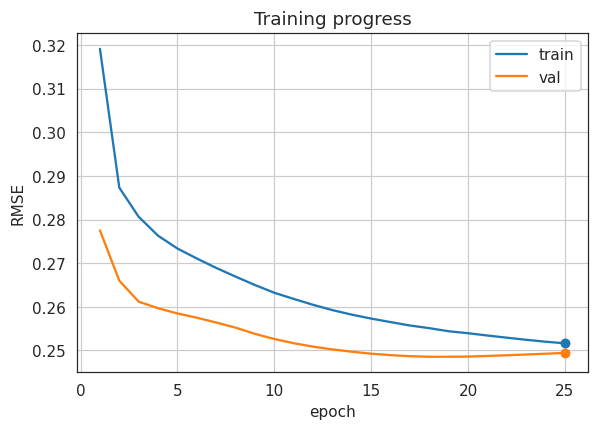

Epoch 1:   0%|          | 0/60 [00:04<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.3191 MAE=0.2606 R2=-0.2124 | Acc=0.7160 Prec=0.3031 Rec=0.0319 F1=0.0577 AUROC=0.5254
VALID→ RMSE=0.2775 MAE=0.1954 R2=0.0521 | Acc=0.7196 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6001


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2873 MAE=0.2178 R2=0.0175 | Acc=0.7267 Prec=0.3538 Rec=0.0028 F1=0.0056 AUROC=0.5174
VALID→ RMSE=0.2660 MAE=0.1893 R2=0.1293 | Acc=0.7196 Prec=0.6667 Rec=0.0003 F1=0.0006 AUROC=0.6673


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2806 MAE=0.2131 R2=0.0627 | Acc=0.7271 Prec=0.4803 Rec=0.0090 F1=0.0177 AUROC=0.5643
VALID→ RMSE=0.2612 MAE=0.1867 R2=0.1605 | Acc=0.7206 Prec=0.6899 Rec=0.0067 F1=0.0134 AUROC=0.7033


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2763 MAE=0.2108 R2=0.0913 | Acc=0.7292 Prec=0.5737 Rec=0.0263 F1=0.0504 AUROC=0.6015
VALID→ RMSE=0.2597 MAE=0.1855 R2=0.1702 | Acc=0.7282 Prec=0.7399 Rec=0.0477 F1=0.0896 AUROC=0.7179


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2733 MAE=0.2088 R2=0.1106 | Acc=0.7331 Prec=0.6068 Rec=0.0600 F1=0.1092 AUROC=0.6301
VALID→ RMSE=0.2585 MAE=0.1849 R2=0.1778 | Acc=0.7385 Prec=0.7176 Rec=0.1110 F1=0.1923 AUROC=0.7249


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2711 MAE=0.2076 R2=0.1254 | Acc=0.7380 Prec=0.6181 Rec=0.1022 F1=0.1754 AUROC=0.6502
VALID→ RMSE=0.2575 MAE=0.1844 R2=0.1840 | Acc=0.7448 Prec=0.6912 Rec=0.1627 F1=0.2634 AUROC=0.7289


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2689 MAE=0.2062 R2=0.1393 | Acc=0.7421 Prec=0.6175 Rec=0.1417 F1=0.2305 AUROC=0.6661
VALID→ RMSE=0.2564 MAE=0.1842 R2=0.1910 | Acc=0.7481 Prec=0.6734 Rec=0.1975 F1=0.3055 AUROC=0.7318


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2669 MAE=0.2048 R2=0.1520 | Acc=0.7451 Prec=0.6155 Rec=0.1739 F1=0.2712 AUROC=0.6779
VALID→ RMSE=0.2552 MAE=0.1841 R2=0.1984 | Acc=0.7503 Prec=0.6644 Rec=0.2216 F1=0.3323 AUROC=0.7339


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2650 MAE=0.2034 R2=0.1642 | Acc=0.7479 Prec=0.6135 Rec=0.2037 F1=0.3059 AUROC=0.6883
VALID→ RMSE=0.2538 MAE=0.1845 R2=0.2073 | Acc=0.7519 Prec=0.6569 Rec=0.2411 F1=0.3527 AUROC=0.7359


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2632 MAE=0.2021 R2=0.1754 | Acc=0.7501 Prec=0.6119 Rec=0.2284 F1=0.3326 AUROC=0.6977
VALID→ RMSE=0.2526 MAE=0.1850 R2=0.2147 | Acc=0.7530 Prec=0.6525 Rec=0.2546 F1=0.3663 AUROC=0.7376


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2618 MAE=0.2011 R2=0.1842 | Acc=0.7519 Prec=0.6116 Rec=0.2465 F1=0.3514 AUROC=0.7054
VALID→ RMSE=0.2516 MAE=0.1855 R2=0.2206 | Acc=0.7534 Prec=0.6478 Rec=0.2647 F1=0.3758 AUROC=0.7393


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.2604 MAE=0.1996 R2=0.1926 | Acc=0.7534 Prec=0.6136 Rec=0.2580 F1=0.3632 AUROC=0.7121
VALID→ RMSE=0.2508 MAE=0.1861 R2=0.2256 | Acc=0.7541 Prec=0.6474 Rec=0.2706 F1=0.3817 AUROC=0.7406


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.2592 MAE=0.1981 R2=0.2001 | Acc=0.7551 Prec=0.6195 Rec=0.2635 F1=0.3697 AUROC=0.7176
VALID→ RMSE=0.2502 MAE=0.1867 R2=0.2294 | Acc=0.7546 Prec=0.6468 Rec=0.2748 F1=0.3857 AUROC=0.7419


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ RMSE=0.2582 MAE=0.1969 R2=0.2065 | Acc=0.7557 Prec=0.6209 Rec=0.2669 F1=0.3734 AUROC=0.7217
VALID→ RMSE=0.2497 MAE=0.1871 R2=0.2327 | Acc=0.7551 Prec=0.6468 Rec=0.2789 F1=0.3897 AUROC=0.7433


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ RMSE=0.2573 MAE=0.1959 R2=0.2121 | Acc=0.7570 Prec=0.6251 Rec=0.2714 F1=0.3784 AUROC=0.7262
VALID→ RMSE=0.2492 MAE=0.1874 R2=0.2354 | Acc=0.7555 Prec=0.6474 Rec=0.2816 F1=0.3925 AUROC=0.7451


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ RMSE=0.2565 MAE=0.1951 R2=0.2170 | Acc=0.7573 Prec=0.6250 Rec=0.2744 F1=0.3814 AUROC=0.7296
VALID→ RMSE=0.2489 MAE=0.1876 R2=0.2375 | Acc=0.7558 Prec=0.6477 Rec=0.2831 F1=0.3940 AUROC=0.7466


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ RMSE=0.2557 MAE=0.1942 R2=0.2218 | Acc=0.7582 Prec=0.6270 Rec=0.2797 F1=0.3868 AUROC=0.7329
VALID→ RMSE=0.2487 MAE=0.1878 R2=0.2389 | Acc=0.7562 Prec=0.6498 Rec=0.2832 F1=0.3945 AUROC=0.7482


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ RMSE=0.2551 MAE=0.1937 R2=0.2255 | Acc=0.7587 Prec=0.6271 Rec=0.2833 F1=0.3902 AUROC=0.7359
VALID→ RMSE=0.2485 MAE=0.1881 R2=0.2398 | Acc=0.7566 Prec=0.6525 Rec=0.2826 F1=0.3944 AUROC=0.7496


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ RMSE=0.2544 MAE=0.1931 R2=0.2297 | Acc=0.7594 Prec=0.6284 Rec=0.2876 F1=0.3946 AUROC=0.7389
VALID→ RMSE=0.2485 MAE=0.1886 R2=0.2398 | Acc=0.7570 Prec=0.6549 Rec=0.2819 F1=0.3942 AUROC=0.7505


Epoch 20:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ RMSE=0.2539 MAE=0.1926 R2=0.2325 | Acc=0.7599 Prec=0.6284 Rec=0.2921 F1=0.3988 AUROC=0.7409
VALID→ RMSE=0.2486 MAE=0.1891 R2=0.2396 | Acc=0.7572 Prec=0.6556 Rec=0.2825 F1=0.3948 AUROC=0.7513


Epoch 21:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ RMSE=0.2534 MAE=0.1922 R2=0.2357 | Acc=0.7602 Prec=0.6277 Rec=0.2960 F1=0.4023 AUROC=0.7433
VALID→ RMSE=0.2487 MAE=0.1897 R2=0.2386 | Acc=0.7573 Prec=0.6572 Rec=0.2815 F1=0.3941 AUROC=0.7518


Epoch 22:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ RMSE=0.2529 MAE=0.1919 R2=0.2387 | Acc=0.7609 Prec=0.6287 Rec=0.3003 F1=0.4065 AUROC=0.7454
VALID→ RMSE=0.2489 MAE=0.1903 R2=0.2377 | Acc=0.7577 Prec=0.6576 Rec=0.2836 F1=0.3963 AUROC=0.7521


Epoch 23:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ RMSE=0.2524 MAE=0.1915 R2=0.2416 | Acc=0.7611 Prec=0.6274 Rec=0.3047 F1=0.4102 AUROC=0.7472
VALID→ RMSE=0.2490 MAE=0.1908 R2=0.2366 | Acc=0.7580 Prec=0.6578 Rec=0.2857 F1=0.3984 AUROC=0.7523


Epoch 24:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ RMSE=0.2520 MAE=0.1912 R2=0.2442 | Acc=0.7617 Prec=0.6283 Rec=0.3087 F1=0.4140 AUROC=0.7490
VALID→ RMSE=0.2492 MAE=0.1912 R2=0.2355 | Acc=0.7582 Prec=0.6579 Rec=0.2867 F1=0.3993 AUROC=0.7524


Epoch 25:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ RMSE=0.2516 MAE=0.1909 R2=0.2464 | Acc=0.7621 Prec=0.6286 Rec=0.3113 F1=0.4164 AUROC=0.7503
VALID→ RMSE=0.2494 MAE=0.1916 R2=0.2344 | Acc=0.7583 Prec=0.6572 Rec=0.2884 F1=0.4009 AUROC=0.7523
Early stopping at epoch 25
✅ Final best model (_fin) saved: AAPL_0.24852_fin.pth
Delete variables to free memory...


[I 2025-09-22 19:56:57,285] Trial 8 finished with value: 0.24852165579795837 and parameters: {'look_back': 90, 'DROPOUT_SHORT': 0.06427201117521163, 'DROPOUT_LONG': 0.23925968253964486, 'ATT_DROPOUT': 0.1364965551436319, 'INITIAL_LR': 5.332005914382629e-05, 'ETA_MIN': 8.021674877104272e-06, 'WEIGHT_DECAY': 1.9173388965298366e-05, 'CLIPNORM': 6.046087479328989}. Best is trial 4 with value: 0.2471747100353241.



▶ Trial 9 starting with:
{'look_back': 90, 'DROPOUT_SHORT': 0.1292691356576724, 'DROPOUT_LONG': 0.2840570526336714, 'ATT_DROPOUT': 0.17091441541450975, 'INITIAL_LR': 0.0007444573249084587, 'ETA_MIN': 1.232864935628612e-06, 'WEIGHT_DECAY': 0.00012015670815744401, 'CLIPNORM': 9.117560782850198}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


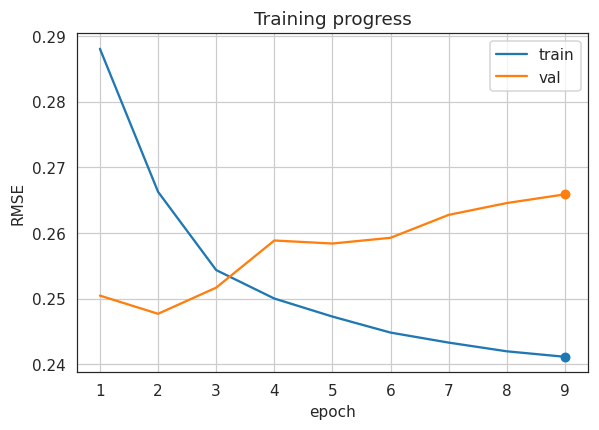

Epoch 1:   0%|          | 0/60 [00:02<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2880 MAE=0.2216 R2=0.0125 | Acc=0.6993 Prec=0.3784 Rec=0.1600 F1=0.2249 AUROC=0.6091
VALID→ RMSE=0.2505 MAE=0.1830 R2=0.2279 | Acc=0.7523 Prec=0.7096 Rec=0.1978 F1=0.3093 AUROC=0.7414


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2663 MAE=0.2054 R2=0.1561 | Acc=0.7487 Prec=0.5803 Rec=0.2826 F1=0.3801 AUROC=0.7031
VALID→ RMSE=0.2477 MAE=0.1885 R2=0.2448 | Acc=0.7596 Prec=0.6770 Rec=0.2730 F1=0.3891 AUROC=0.7495


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2544 MAE=0.1941 R2=0.2299 | Acc=0.7605 Prec=0.6222 Rec=0.3096 F1=0.4135 AUROC=0.7386
VALID→ RMSE=0.2517 MAE=0.1938 R2=0.2204 | Acc=0.7552 Prec=0.6295 Rec=0.3083 F1=0.4139 AUROC=0.7399


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2500 MAE=0.1899 R2=0.2559 | Acc=0.7655 Prec=0.6357 Rec=0.3281 F1=0.4328 AUROC=0.7549
VALID→ RMSE=0.2589 MAE=0.1929 R2=0.1753 | Acc=0.7448 Prec=0.6004 Rec=0.2686 F1=0.3711 AUROC=0.7186


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2473 MAE=0.1869 R2=0.2721 | Acc=0.7684 Prec=0.6414 Rec=0.3418 F1=0.4460 AUROC=0.7647
VALID→ RMSE=0.2584 MAE=0.1987 R2=0.1782 | Acc=0.7381 Prec=0.5554 Rec=0.3302 F1=0.4142 AUROC=0.7185


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2448 MAE=0.1854 R2=0.2864 | Acc=0.7712 Prec=0.6446 Rec=0.3587 F1=0.4609 AUROC=0.7725
VALID→ RMSE=0.2593 MAE=0.1995 R2=0.1727 | Acc=0.7335 Prec=0.5381 Rec=0.3506 F1=0.4246 AUROC=0.7196


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2433 MAE=0.1843 R2=0.2953 | Acc=0.7732 Prec=0.6473 Rec=0.3695 F1=0.4705 AUROC=0.7773
VALID→ RMSE=0.2628 MAE=0.2022 R2=0.1503 | Acc=0.7265 Prec=0.5175 Rec=0.3659 F1=0.4287 AUROC=0.7144


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2420 MAE=0.1829 R2=0.3029 | Acc=0.7754 Prec=0.6532 Rec=0.3757 F1=0.4770 AUROC=0.7810
VALID→ RMSE=0.2646 MAE=0.1998 R2=0.1386 | Acc=0.7262 Prec=0.5182 Rec=0.3366 F1=0.4081 AUROC=0.7121


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2412 MAE=0.1820 R2=0.3077 | Acc=0.7768 Prec=0.6566 Rec=0.3800 F1=0.4814 AUROC=0.7834
VALID→ RMSE=0.2659 MAE=0.1989 R2=0.1299 | Acc=0.7257 Prec=0.5179 Rec=0.3133 F1=0.3904 AUROC=0.7091
Early stopping at epoch 9
✅ Final best model (_fin) saved: AAPL_0.24770_fin.pth
Delete variables to free memory...


[I 2025-09-22 20:10:03,139] Trial 9 finished with value: 0.24770458042621613 and parameters: {'look_back': 90, 'DROPOUT_SHORT': 0.1292691356576724, 'DROPOUT_LONG': 0.2840570526336714, 'ATT_DROPOUT': 0.17091441541450975, 'INITIAL_LR': 0.0007444573249084587, 'ETA_MIN': 1.232864935628612e-06, 'WEIGHT_DECAY': 0.00012015670815744401, 'CLIPNORM': 9.117560782850198}. Best is trial 4 with value: 0.2471747100353241.



▶ Trial 10 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.34973427916083494, 'DROPOUT_LONG': 0.05374958522460577, 'ATT_DROPOUT': 0.2567467506778329, 'INITIAL_LR': 0.0002660658149726599, 'ETA_MIN': 4.774716617467251e-06, 'WEIGHT_DECAY': 0.006182338094018968, 'CLIPNORM': 0.12250080398432583}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


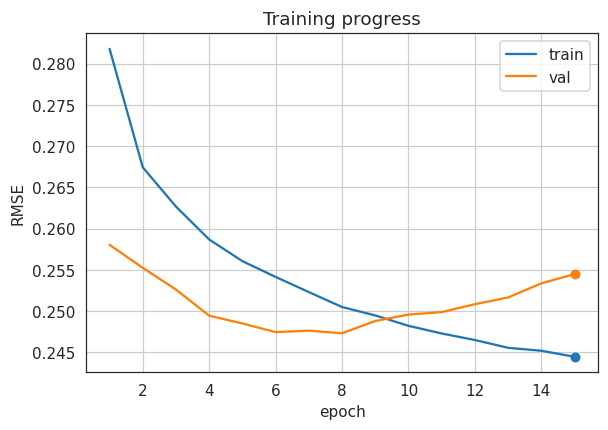

Epoch 1:   0%|          | 0/60 [00:05<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2818 MAE=0.2198 R2=0.0555 | Acc=0.7044 Prec=0.3500 Rec=0.1183 F1=0.1768 AUROC=0.5965
VALID→ RMSE=0.2580 MAE=0.1825 R2=0.1697 | Acc=0.7450 Prec=0.7818 Rec=0.0937 F1=0.1673 AUROC=0.7267


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2674 MAE=0.2073 R2=0.1494 | Acc=0.7469 Prec=0.5747 Rec=0.2196 F1=0.3178 AUROC=0.6876
VALID→ RMSE=0.2553 MAE=0.1828 R2=0.1875 | Acc=0.7602 Prec=0.6397 Rec=0.2822 F1=0.3917 AUROC=0.7335


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2627 MAE=0.2034 R2=0.1793 | Acc=0.7543 Prec=0.5882 Rec=0.2821 F1=0.3813 AUROC=0.7121
VALID→ RMSE=0.2526 MAE=0.1829 R2=0.2042 | Acc=0.7604 Prec=0.6195 Rec=0.3208 F1=0.4227 AUROC=0.7355


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2587 MAE=0.1993 R2=0.2040 | Acc=0.7589 Prec=0.6018 Rec=0.3002 F1=0.4005 AUROC=0.7270
VALID→ RMSE=0.2495 MAE=0.1823 R2=0.2241 | Acc=0.7611 Prec=0.6175 Rec=0.3324 F1=0.4321 AUROC=0.7394


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2561 MAE=0.1967 R2=0.2201 | Acc=0.7622 Prec=0.6140 Rec=0.3066 F1=0.4090 AUROC=0.7379
VALID→ RMSE=0.2485 MAE=0.1821 R2=0.2299 | Acc=0.7623 Prec=0.6291 Rec=0.3185 F1=0.4229 AUROC=0.7414


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2542 MAE=0.1945 R2=0.2317 | Acc=0.7642 Prec=0.6195 Rec=0.3145 F1=0.4172 AUROC=0.7459
VALID→ RMSE=0.2475 MAE=0.1822 R2=0.2364 | Acc=0.7630 Prec=0.6391 Rec=0.3059 F1=0.4138 AUROC=0.7447


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2523 MAE=0.1926 R2=0.2428 | Acc=0.7658 Prec=0.6253 Rec=0.3181 F1=0.4217 AUROC=0.7513
VALID→ RMSE=0.2476 MAE=0.1812 R2=0.2353 | Acc=0.7627 Prec=0.6381 Rec=0.3054 F1=0.4131 AUROC=0.7478


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2505 MAE=0.1899 R2=0.2536 | Acc=0.7670 Prec=0.6287 Rec=0.3217 F1=0.4256 AUROC=0.7580
VALID→ RMSE=0.2473 MAE=0.1803 R2=0.2373 | Acc=0.7631 Prec=0.6471 Rec=0.2941 F1=0.4044 AUROC=0.7524


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2495 MAE=0.1893 R2=0.2597 | Acc=0.7683 Prec=0.6325 Rec=0.3261 F1=0.4304 AUROC=0.7616
VALID→ RMSE=0.2488 MAE=0.1792 R2=0.2280 | Acc=0.7627 Prec=0.6596 Rec=0.2733 F1=0.3864 AUROC=0.7539


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2482 MAE=0.1880 R2=0.2671 | Acc=0.7695 Prec=0.6336 Rec=0.3345 F1=0.4379 AUROC=0.7655
VALID→ RMSE=0.2496 MAE=0.1801 R2=0.2232 | Acc=0.7615 Prec=0.6613 Rec=0.2618 F1=0.3751 AUROC=0.7525


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2473 MAE=0.1873 R2=0.2726 | Acc=0.7710 Prec=0.6375 Rec=0.3399 F1=0.4434 AUROC=0.7684
VALID→ RMSE=0.2499 MAE=0.1817 R2=0.2213 | Acc=0.7601 Prec=0.6510 Rec=0.2647 F1=0.3763 AUROC=0.7507


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.2465 MAE=0.1866 R2=0.2772 | Acc=0.7718 Prec=0.6385 Rec=0.3449 F1=0.4479 AUROC=0.7707
VALID→ RMSE=0.2509 MAE=0.1826 R2=0.2154 | Acc=0.7588 Prec=0.6456 Rec=0.2619 F1=0.3727 AUROC=0.7484


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.2456 MAE=0.1855 R2=0.2828 | Acc=0.7730 Prec=0.6415 Rec=0.3497 F1=0.4527 AUROC=0.7732
VALID→ RMSE=0.2517 MAE=0.1859 R2=0.2103 | Acc=0.7568 Prec=0.6216 Rec=0.2824 F1=0.3883 AUROC=0.7445


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ RMSE=0.2452 MAE=0.1855 R2=0.2848 | Acc=0.7736 Prec=0.6413 Rec=0.3552 F1=0.4572 AUROC=0.7746
VALID→ RMSE=0.2534 MAE=0.1846 R2=0.1995 | Acc=0.7558 Prec=0.6293 Rec=0.2603 F1=0.3683 AUROC=0.7423


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ RMSE=0.2445 MAE=0.1845 R2=0.2891 | Acc=0.7744 Prec=0.6437 Rec=0.3569 F1=0.4592 AUROC=0.7765
VALID→ RMSE=0.2545 MAE=0.1875 R2=0.1924 | Acc=0.7533 Prec=0.6059 Rec=0.2802 F1=0.3832 AUROC=0.7387
Early stopping at epoch 15
✅ Final best model (_fin) saved: AAPL_0.24733_fin.pth
Delete variables to free memory...


[I 2025-09-22 20:28:24,010] Trial 10 finished with value: 0.2473253458738327 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.34973427916083494, 'DROPOUT_LONG': 0.05374958522460577, 'ATT_DROPOUT': 0.2567467506778329, 'INITIAL_LR': 0.0002660658149726599, 'ETA_MIN': 4.774716617467251e-06, 'WEIGHT_DECAY': 0.006182338094018968, 'CLIPNORM': 0.12250080398432583}. Best is trial 4 with value: 0.2471747100353241.



▶ Trial 11 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.3440306348630027, 'DROPOUT_LONG': 0.06552088339788226, 'ATT_DROPOUT': 0.25923935446692575, 'INITIAL_LR': 0.00029451171276435786, 'ETA_MIN': 4.508778820796029e-06, 'WEIGHT_DECAY': 0.005232740664971647, 'CLIPNORM': 0.2153459797521397}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


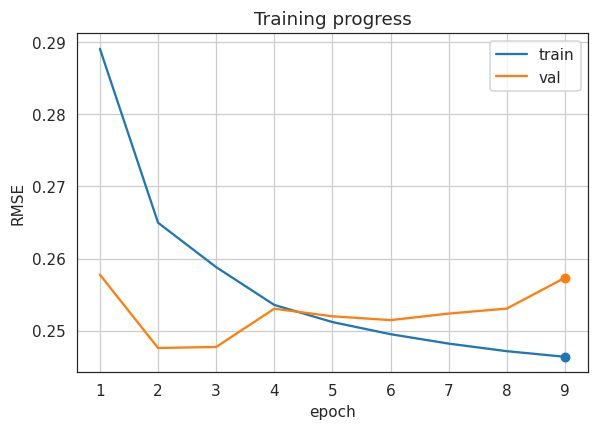

Epoch 1:   0%|          | 0/60 [00:02<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2891 MAE=0.2269 R2=0.0062 | Acc=0.6991 Prec=0.3354 Rec=0.1233 F1=0.1803 AUROC=0.6009
VALID→ RMSE=0.2578 MAE=0.1793 R2=0.1715 | Acc=0.7420 Prec=0.8017 Rec=0.0752 F1=0.1375 AUROC=0.7297


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2650 MAE=0.2014 R2=0.1650 | Acc=0.7509 Prec=0.6066 Rec=0.2039 F1=0.3052 AUROC=0.6976
VALID→ RMSE=0.2476 MAE=0.1830 R2=0.2355 | Acc=0.7626 Prec=0.6624 Rec=0.2685 F1=0.3821 AUROC=0.7479


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2588 MAE=0.1984 R2=0.2033 | Acc=0.7595 Prec=0.6057 Rec=0.2970 F1=0.3986 AUROC=0.7296
VALID→ RMSE=0.2477 MAE=0.1836 R2=0.2347 | Acc=0.7634 Prec=0.6722 Rec=0.2632 F1=0.3783 AUROC=0.7498


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2536 MAE=0.1930 R2=0.2352 | Acc=0.7648 Prec=0.6235 Rec=0.3119 F1=0.4158 AUROC=0.7467
VALID→ RMSE=0.2530 MAE=0.1814 R2=0.2016 | Acc=0.7605 Prec=0.6997 Rec=0.2173 F1=0.3316 AUROC=0.7455


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2512 MAE=0.1899 R2=0.2495 | Acc=0.7669 Prec=0.6286 Rec=0.3214 F1=0.4254 AUROC=0.7551
VALID→ RMSE=0.2520 MAE=0.1818 R2=0.2082 | Acc=0.7593 Prec=0.6823 Rec=0.2242 F1=0.3375 AUROC=0.7451


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2495 MAE=0.1887 R2=0.2595 | Acc=0.7682 Prec=0.6296 Rec=0.3313 F1=0.4341 AUROC=0.7602
VALID→ RMSE=0.2515 MAE=0.1847 R2=0.2115 | Acc=0.7578 Prec=0.6646 Rec=0.2305 F1=0.3423 AUROC=0.7420


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2482 MAE=0.1877 R2=0.2672 | Acc=0.7698 Prec=0.6337 Rec=0.3373 F1=0.4403 AUROC=0.7641
VALID→ RMSE=0.2524 MAE=0.1843 R2=0.2058 | Acc=0.7557 Prec=0.6524 Rec=0.2281 F1=0.3380 AUROC=0.7416


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2472 MAE=0.1868 R2=0.2734 | Acc=0.7709 Prec=0.6365 Rec=0.3407 F1=0.4439 AUROC=0.7673
VALID→ RMSE=0.2531 MAE=0.1850 R2=0.2015 | Acc=0.7534 Prec=0.6379 Rec=0.2270 F1=0.3348 AUROC=0.7395


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2464 MAE=0.1857 R2=0.2780 | Acc=0.7721 Prec=0.6402 Rec=0.3442 F1=0.4477 AUROC=0.7698
VALID→ RMSE=0.2573 MAE=0.1838 R2=0.1743 | Acc=0.7503 Prec=0.6346 Rec=0.2050 F1=0.3099 AUROC=0.7363
Early stopping at epoch 9
✅ Final best model (_fin) saved: AAPL_0.24761_fin.pth
Delete variables to free memory...


[I 2025-09-22 20:39:45,031] Trial 11 finished with value: 0.2476073056459427 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.3440306348630027, 'DROPOUT_LONG': 0.06552088339788226, 'ATT_DROPOUT': 0.25923935446692575, 'INITIAL_LR': 0.00029451171276435786, 'ETA_MIN': 4.508778820796029e-06, 'WEIGHT_DECAY': 0.005232740664971647, 'CLIPNORM': 0.2153459797521397}. Best is trial 4 with value: 0.2471747100353241.



▶ Trial 12 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.34756854464137626, 'DROPOUT_LONG': 0.21463975431143772, 'ATT_DROPOUT': 0.25084813421683827, 'INITIAL_LR': 1.3825252617214982e-05, 'ETA_MIN': 4.561239363460085e-06, 'WEIGHT_DECAY': 0.0005694708180220951, 'CLIPNORM': 0.15027738181279945}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


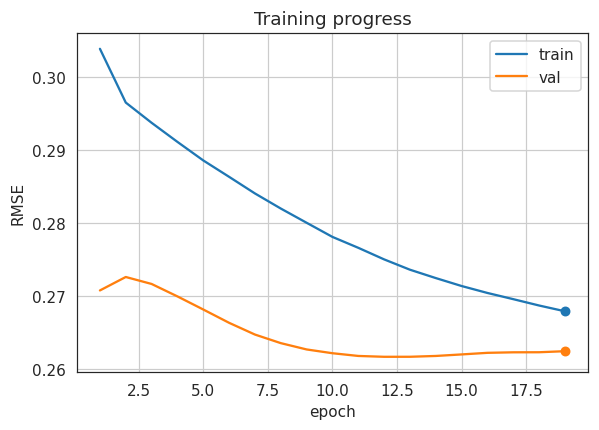

Epoch 1:   0%|          | 0/60 [00:03<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.3038 MAE=0.2481 R2=-0.0980 | Acc=0.3925 Prec=0.2791 Rec=0.7982 F1=0.4136 AUROC=0.5451
VALID→ RMSE=0.2708 MAE=0.1998 R2=0.0857 | Acc=0.2937 Prec=0.2776 Rec=0.9877 F1=0.4334 AUROC=0.6579


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2965 MAE=0.2317 R2=-0.0455 | Acc=0.5451 Prec=0.2998 Rec=0.5206 F1=0.3805 AUROC=0.5517
VALID→ RMSE=0.2726 MAE=0.1934 R2=0.0732 | Acc=0.7196 Prec=0.4817 Rec=0.3346 F1=0.3949 AUROC=0.6767


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2937 MAE=0.2254 R2=-0.0261 | Acc=0.6639 Prec=0.3299 Rec=0.2448 F1=0.2810 AUROC=0.5530
VALID→ RMSE=0.2717 MAE=0.1904 R2=0.0797 | Acc=0.7304 Prec=0.5751 Rec=0.0546 F1=0.0998 AUROC=0.6865


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2911 MAE=0.2212 R2=-0.0079 | Acc=0.7083 Prec=0.3615 Rec=0.1134 F1=0.1726 AUROC=0.5543
VALID→ RMSE=0.2700 MAE=0.1881 R2=0.0912 | Acc=0.7268 Prec=0.5382 Rec=0.0078 F1=0.0154 AUROC=0.6926


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2886 MAE=0.2177 R2=0.0096 | Acc=0.7221 Prec=0.3948 Rec=0.0666 F1=0.1140 AUROC=0.5568
VALID→ RMSE=0.2682 MAE=0.1862 R2=0.1032 | Acc=0.7269 Prec=0.6315 Rec=0.0028 F1=0.0056 AUROC=0.6979


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2863 MAE=0.2150 R2=0.0249 | Acc=0.7266 Prec=0.4188 Rec=0.0484 F1=0.0868 AUROC=0.5619
VALID→ RMSE=0.2664 MAE=0.1848 R2=0.1154 | Acc=0.7271 Prec=0.7659 Rec=0.0030 F1=0.0060 AUROC=0.7032


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2841 MAE=0.2127 R2=0.0403 | Acc=0.7287 Prec=0.4439 Rec=0.0434 F1=0.0791 AUROC=0.5679
VALID→ RMSE=0.2648 MAE=0.1836 R2=0.1260 | Acc=0.7285 Prec=0.8612 Rec=0.0086 F1=0.0170 AUROC=0.7084


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2820 MAE=0.2109 R2=0.0542 | Acc=0.7300 Prec=0.4684 Rec=0.0444 F1=0.0811 AUROC=0.5757
VALID→ RMSE=0.2636 MAE=0.1828 R2=0.1337 | Acc=0.7315 Prec=0.8680 Rec=0.0215 F1=0.0420 AUROC=0.7130


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2800 MAE=0.2094 R2=0.0672 | Acc=0.7313 Prec=0.4940 Rec=0.0487 F1=0.0887 AUROC=0.5846
VALID→ RMSE=0.2627 MAE=0.1821 R2=0.1394 | Acc=0.7361 Prec=0.8473 Rec=0.0426 F1=0.0811 AUROC=0.7171


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2781 MAE=0.2080 R2=0.0801 | Acc=0.7326 Prec=0.5164 Rec=0.0552 F1=0.0997 AUROC=0.5921
VALID→ RMSE=0.2622 MAE=0.1816 R2=0.1428 | Acc=0.7409 Prec=0.8220 Rec=0.0668 F1=0.1236 AUROC=0.7206


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2766 MAE=0.2069 R2=0.0899 | Acc=0.7338 Prec=0.5343 Rec=0.0631 F1=0.1129 AUROC=0.6015
VALID→ RMSE=0.2618 MAE=0.1812 R2=0.1452 | Acc=0.7450 Prec=0.7964 Rec=0.0905 F1=0.1625 AUROC=0.7238


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.2750 MAE=0.2058 R2=0.1003 | Acc=0.7348 Prec=0.5451 Rec=0.0721 F1=0.1273 AUROC=0.6085
VALID→ RMSE=0.2617 MAE=0.1809 R2=0.1460 | Acc=0.7483 Prec=0.7747 Rec=0.1124 F1=0.1963 AUROC=0.7265


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.2736 MAE=0.2048 R2=0.1095 | Acc=0.7362 Prec=0.5579 Rec=0.0820 F1=0.1430 AUROC=0.6163
VALID→ RMSE=0.2617 MAE=0.1807 R2=0.1459 | Acc=0.7511 Prec=0.7553 Rec=0.1328 F1=0.2259 AUROC=0.7288


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ RMSE=0.2725 MAE=0.2040 R2=0.1169 | Acc=0.7378 Prec=0.5709 Rec=0.0928 F1=0.1596 AUROC=0.6239
VALID→ RMSE=0.2618 MAE=0.1806 R2=0.1452 | Acc=0.7531 Prec=0.7415 Rec=0.1492 F1=0.2485 AUROC=0.7307


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ RMSE=0.2714 MAE=0.2032 R2=0.1240 | Acc=0.7393 Prec=0.5803 Rec=0.1039 F1=0.1762 AUROC=0.6307
VALID→ RMSE=0.2620 MAE=0.1805 R2=0.1438 | Acc=0.7546 Prec=0.7302 Rec=0.1624 F1=0.2658 AUROC=0.7323


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ RMSE=0.2704 MAE=0.2025 R2=0.1301 | Acc=0.7407 Prec=0.5874 Rec=0.1140 F1=0.1909 AUROC=0.6367
VALID→ RMSE=0.2623 MAE=0.1804 R2=0.1424 | Acc=0.7557 Prec=0.7221 Rec=0.1732 F1=0.2794 AUROC=0.7337


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ RMSE=0.2696 MAE=0.2018 R2=0.1355 | Acc=0.7422 Prec=0.5949 Rec=0.1235 F1=0.2046 AUROC=0.6440
VALID→ RMSE=0.2623 MAE=0.1804 R2=0.1419 | Acc=0.7568 Prec=0.7174 Rec=0.1827 F1=0.2912 AUROC=0.7349


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ RMSE=0.2687 MAE=0.2012 R2=0.1411 | Acc=0.7437 Prec=0.6007 Rec=0.1337 F1=0.2187 AUROC=0.6495
VALID→ RMSE=0.2623 MAE=0.1803 R2=0.1419 | Acc=0.7575 Prec=0.7125 Rec=0.1899 F1=0.2999 AUROC=0.7360


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ RMSE=0.2679 MAE=0.2007 R2=0.1461 | Acc=0.7452 Prec=0.6063 Rec=0.1438 F1=0.2324 AUROC=0.6559
VALID→ RMSE=0.2625 MAE=0.1803 R2=0.1409 | Acc=0.7580 Prec=0.7092 Rec=0.1950 F1=0.3059 AUROC=0.7369
Early stopping at epoch 19
✅ Final best model (_fin) saved: AAPL_0.26171_fin.pth
Delete variables to free memory...


[I 2025-09-22 20:59:19,451] Trial 12 finished with value: 0.2617128789424896 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.34756854464137626, 'DROPOUT_LONG': 0.21463975431143772, 'ATT_DROPOUT': 0.25084813421683827, 'INITIAL_LR': 1.3825252617214982e-05, 'ETA_MIN': 4.561239363460085e-06, 'WEIGHT_DECAY': 0.0005694708180220951, 'CLIPNORM': 0.15027738181279945}. Best is trial 4 with value: 0.2471747100353241.



▶ Trial 13 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.26973904500084334, 'DROPOUT_LONG': 0.05675932137358411, 'ATT_DROPOUT': 0.29936557358761, 'INITIAL_LR': 0.00027357816544617793, 'ETA_MIN': 4.475510282004136e-06, 'WEIGHT_DECAY': 0.009490916353802434, 'CLIPNORM': 1.467226432884908}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


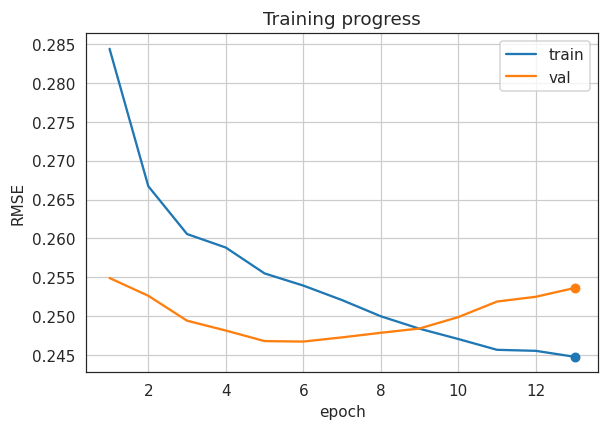

Epoch 1:   0%|          | 0/60 [00:03<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2844 MAE=0.2231 R2=0.0381 | Acc=0.7160 Prec=0.3829 Rec=0.0954 F1=0.1528 AUROC=0.5956
VALID→ RMSE=0.2549 MAE=0.1799 R2=0.1898 | Acc=0.7530 Prec=0.7028 Rec=0.1678 F1=0.2710 AUROC=0.7323


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2667 MAE=0.2056 R2=0.1539 | Acc=0.7389 Prec=0.5316 Rec=0.2287 F1=0.3198 AUROC=0.6634
VALID→ RMSE=0.2526 MAE=0.1810 R2=0.2043 | Acc=0.7581 Prec=0.6618 Rec=0.2363 F1=0.3483 AUROC=0.7420


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2606 MAE=0.2008 R2=0.1925 | Acc=0.7537 Prec=0.5904 Rec=0.2682 F1=0.3688 AUROC=0.7057
VALID→ RMSE=0.2494 MAE=0.1819 R2=0.2243 | Acc=0.7603 Prec=0.6452 Rec=0.2739 F1=0.3846 AUROC=0.7466


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2588 MAE=0.1998 R2=0.2032 | Acc=0.7583 Prec=0.5993 Rec=0.3003 F1=0.4001 AUROC=0.7268
VALID→ RMSE=0.2482 MAE=0.1812 R2=0.2322 | Acc=0.7614 Prec=0.6461 Rec=0.2816 F1=0.3922 AUROC=0.7501


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2555 MAE=0.1961 R2=0.2236 | Acc=0.7625 Prec=0.6136 Rec=0.3101 F1=0.4120 AUROC=0.7407
VALID→ RMSE=0.2468 MAE=0.1842 R2=0.2405 | Acc=0.7631 Prec=0.6547 Rec=0.2832 F1=0.3954 AUROC=0.7507


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2539 MAE=0.1939 R2=0.2331 | Acc=0.7645 Prec=0.6209 Rec=0.3141 F1=0.4172 AUROC=0.7476
VALID→ RMSE=0.2467 MAE=0.1860 R2=0.2409 | Acc=0.7638 Prec=0.6554 Rec=0.2871 F1=0.3992 AUROC=0.7512


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2521 MAE=0.1917 R2=0.2443 | Acc=0.7663 Prec=0.6283 Rec=0.3164 F1=0.4209 AUROC=0.7534
VALID→ RMSE=0.2473 MAE=0.1863 R2=0.2376 | Acc=0.7648 Prec=0.6565 Rec=0.2935 F1=0.4056 AUROC=0.7519


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2500 MAE=0.1893 R2=0.2567 | Acc=0.7685 Prec=0.6359 Rec=0.3212 F1=0.4268 AUROC=0.7595
VALID→ RMSE=0.2479 MAE=0.1869 R2=0.2340 | Acc=0.7638 Prec=0.6417 Rec=0.3089 F1=0.4171 AUROC=0.7515


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2484 MAE=0.1882 R2=0.2662 | Acc=0.7700 Prec=0.6376 Rec=0.3311 F1=0.4358 AUROC=0.7642
VALID→ RMSE=0.2484 MAE=0.1877 R2=0.2306 | Acc=0.7621 Prec=0.6257 Rec=0.3237 F1=0.4266 AUROC=0.7513


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2471 MAE=0.1869 R2=0.2740 | Acc=0.7719 Prec=0.6431 Rec=0.3369 F1=0.4422 AUROC=0.7677
VALID→ RMSE=0.2499 MAE=0.1875 R2=0.2214 | Acc=0.7587 Prec=0.6016 Rec=0.3481 F1=0.4410 AUROC=0.7494


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2457 MAE=0.1853 R2=0.2822 | Acc=0.7733 Prec=0.6462 Rec=0.3428 F1=0.4480 AUROC=0.7718
VALID→ RMSE=0.2519 MAE=0.1915 R2=0.2089 | Acc=0.7547 Prec=0.5797 Rec=0.3746 F1=0.4551 AUROC=0.7475


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.2455 MAE=0.1851 R2=0.2829 | Acc=0.7737 Prec=0.6461 Rec=0.3463 F1=0.4509 AUROC=0.7728
VALID→ RMSE=0.2525 MAE=0.1881 R2=0.2051 | Acc=0.7545 Prec=0.5827 Rec=0.3602 F1=0.4452 AUROC=0.7474


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.2448 MAE=0.1843 R2=0.2874 | Acc=0.7747 Prec=0.6479 Rec=0.3516 F1=0.4558 AUROC=0.7749
VALID→ RMSE=0.2536 MAE=0.1897 R2=0.1979 | Acc=0.7520 Prec=0.5724 Rec=0.3673 F1=0.4475 AUROC=0.7456
Early stopping at epoch 13
✅ Final best model (_fin) saved: AAPL_0.24673_fin.pth
Delete variables to free memory...


[I 2025-09-22 21:13:51,263] Trial 13 finished with value: 0.24673087894916534 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.26973904500084334, 'DROPOUT_LONG': 0.05675932137358411, 'ATT_DROPOUT': 0.29936557358761, 'INITIAL_LR': 0.00027357816544617793, 'ETA_MIN': 4.475510282004136e-06, 'WEIGHT_DECAY': 0.009490916353802434, 'CLIPNORM': 1.467226432884908}. Best is trial 13 with value: 0.24673087894916534.



▶ Trial 14 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.2601823730122985, 'DROPOUT_LONG': 0.3471570849316483, 'ATT_DROPOUT': 0.3362682891162997, 'INITIAL_LR': 0.00041821923693060415, 'ETA_MIN': 9.38254605252271e-06, 'WEIGHT_DECAY': 0.002306828352763804, 'CLIPNORM': 2.092661643236098}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


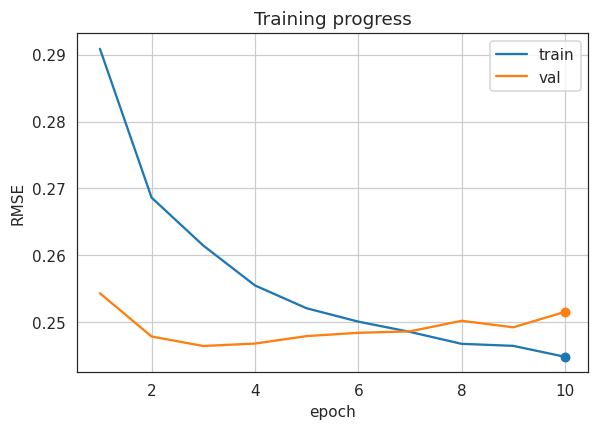

Epoch 1:   0%|          | 0/60 [00:04<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2909 MAE=0.2225 R2=-0.0063 | Acc=0.7075 Prec=0.4068 Rec=0.1962 F1=0.2648 AUROC=0.6198
VALID→ RMSE=0.2543 MAE=0.1773 R2=0.1934 | Acc=0.7569 Prec=0.7240 Rec=0.1792 F1=0.2873 AUROC=0.7425


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2686 MAE=0.2056 R2=0.1417 | Acc=0.7491 Prec=0.5777 Rec=0.2419 F1=0.3410 AUROC=0.6875
VALID→ RMSE=0.2479 MAE=0.1827 R2=0.2339 | Acc=0.7621 Prec=0.6920 Rec=0.2346 F1=0.3504 AUROC=0.7438


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2615 MAE=0.2011 R2=0.1869 | Acc=0.7558 Prec=0.5928 Rec=0.2871 F1=0.3869 AUROC=0.7141
VALID→ RMSE=0.2465 MAE=0.1855 R2=0.2426 | Acc=0.7646 Prec=0.6733 Rec=0.2704 F1=0.3859 AUROC=0.7455


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2555 MAE=0.1956 R2=0.2235 | Acc=0.7622 Prec=0.6137 Rec=0.3076 F1=0.4098 AUROC=0.7371
VALID→ RMSE=0.2468 MAE=0.1849 R2=0.2404 | Acc=0.7648 Prec=0.6787 Rec=0.2655 F1=0.3817 AUROC=0.7455


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2521 MAE=0.1916 R2=0.2441 | Acc=0.7658 Prec=0.6255 Rec=0.3174 F1=0.4211 AUROC=0.7503
VALID→ RMSE=0.2479 MAE=0.1840 R2=0.2335 | Acc=0.7640 Prec=0.6801 Rec=0.2587 F1=0.3748 AUROC=0.7434


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2501 MAE=0.1895 R2=0.2560 | Acc=0.7681 Prec=0.6302 Rec=0.3292 F1=0.4325 AUROC=0.7580
VALID→ RMSE=0.2484 MAE=0.1837 R2=0.2305 | Acc=0.7635 Prec=0.6758 Rec=0.2597 F1=0.3752 AUROC=0.7426


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2486 MAE=0.1883 R2=0.2652 | Acc=0.7699 Prec=0.6331 Rec=0.3391 F1=0.4416 AUROC=0.7632
VALID→ RMSE=0.2486 MAE=0.1853 R2=0.2292 | Acc=0.7623 Prec=0.6534 Rec=0.2782 F1=0.3903 AUROC=0.7415


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2468 MAE=0.1864 R2=0.2757 | Acc=0.7724 Prec=0.6437 Rec=0.3403 F1=0.4453 AUROC=0.7687
VALID→ RMSE=0.2502 MAE=0.1820 R2=0.2193 | Acc=0.7607 Prec=0.6530 Rec=0.2666 F1=0.3786 AUROC=0.7424


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2465 MAE=0.1860 R2=0.2774 | Acc=0.7724 Prec=0.6356 Rec=0.3563 F1=0.4566 AUROC=0.7702
VALID→ RMSE=0.2492 MAE=0.1885 R2=0.2254 | Acc=0.7598 Prec=0.6252 Rec=0.3033 F1=0.4084 AUROC=0.7379


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2448 MAE=0.1845 R2=0.2870 | Acc=0.7748 Prec=0.6471 Rec=0.3542 F1=0.4578 AUROC=0.7747
VALID→ RMSE=0.2516 MAE=0.1823 R2=0.2110 | Acc=0.7580 Prec=0.6524 Rec=0.2459 F1=0.3572 AUROC=0.7398
Early stopping at epoch 10
✅ Final best model (_fin) saved: AAPL_0.24646_fin.pth
Delete variables to free memory...


[I 2025-09-22 21:25:45,028] Trial 14 finished with value: 0.24645718932151794 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.2601823730122985, 'DROPOUT_LONG': 0.3471570849316483, 'ATT_DROPOUT': 0.3362682891162997, 'INITIAL_LR': 0.00041821923693060415, 'ETA_MIN': 9.38254605252271e-06, 'WEIGHT_DECAY': 0.002306828352763804, 'CLIPNORM': 2.092661643236098}. Best is trial 14 with value: 0.24645718932151794.



▶ Trial 15 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.24362192997191895, 'DROPOUT_LONG': 0.34809811902375987, 'ATT_DROPOUT': 0.34299516901154187, 'INITIAL_LR': 0.00044961908421629, 'ETA_MIN': 9.707872274190509e-06, 'WEIGHT_DECAY': 0.00206483790461355, 'CLIPNORM': 1.8261404510337074}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


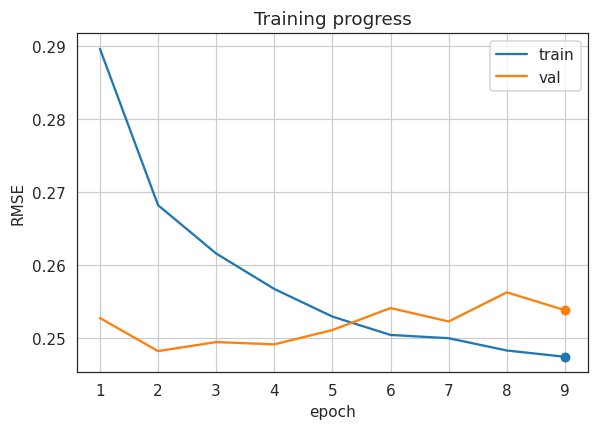

Epoch 1:   0%|          | 0/60 [00:05<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2896 MAE=0.2205 R2=0.0022 | Acc=0.7112 Prec=0.4216 Rec=0.2046 F1=0.2755 AUROC=0.6302
VALID→ RMSE=0.2528 MAE=0.1813 R2=0.2033 | Acc=0.7595 Prec=0.6840 Rec=0.2237 F1=0.3371 AUROC=0.7397


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2682 MAE=0.2051 R2=0.1443 | Acc=0.7491 Prec=0.5720 Rec=0.2592 F1=0.3567 AUROC=0.6920
VALID→ RMSE=0.2483 MAE=0.1873 R2=0.2316 | Acc=0.7625 Prec=0.6577 Rec=0.2743 F1=0.3872 AUROC=0.7450


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2616 MAE=0.2008 R2=0.1860 | Acc=0.7563 Prec=0.5932 Rec=0.2928 F1=0.3920 AUROC=0.7186
VALID→ RMSE=0.2495 MAE=0.1861 R2=0.2239 | Acc=0.7600 Prec=0.6800 Rec=0.2311 F1=0.3449 AUROC=0.7461


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2568 MAE=0.1963 R2=0.2159 | Acc=0.7610 Prec=0.6096 Rec=0.3040 F1=0.4057 AUROC=0.7353
VALID→ RMSE=0.2492 MAE=0.1916 R2=0.2258 | Acc=0.7594 Prec=0.6642 Rec=0.2427 F1=0.3555 AUROC=0.7453


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2530 MAE=0.1928 R2=0.2388 | Acc=0.7648 Prec=0.6238 Rec=0.3111 F1=0.4151 AUROC=0.7467
VALID→ RMSE=0.2511 MAE=0.1872 R2=0.2136 | Acc=0.7560 Prec=0.6768 Rec=0.2061 F1=0.3159 AUROC=0.7434


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2505 MAE=0.1890 R2=0.2539 | Acc=0.7678 Prec=0.6400 Rec=0.3079 F1=0.4158 AUROC=0.7551
VALID→ RMSE=0.2541 MAE=0.1831 R2=0.1946 | Acc=0.7540 Prec=0.6490 Rec=0.2188 F1=0.3272 AUROC=0.7413


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2500 MAE=0.1894 R2=0.2565 | Acc=0.7687 Prec=0.6320 Rec=0.3303 F1=0.4338 AUROC=0.7576
VALID→ RMSE=0.2523 MAE=0.1878 R2=0.2062 | Acc=0.7532 Prec=0.6316 Rec=0.2340 F1=0.3415 AUROC=0.7393


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2483 MAE=0.1878 R2=0.2665 | Acc=0.7705 Prec=0.6393 Rec=0.3327 F1=0.4376 AUROC=0.7631
VALID→ RMSE=0.2563 MAE=0.1842 R2=0.1810 | Acc=0.7503 Prec=0.6244 Rec=0.2181 F1=0.3233 AUROC=0.7390


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2475 MAE=0.1871 R2=0.2716 | Acc=0.7718 Prec=0.6391 Rec=0.3443 F1=0.4475 AUROC=0.7655
VALID→ RMSE=0.2539 MAE=0.1865 R2=0.1965 | Acc=0.7493 Prec=0.5940 Rec=0.2626 F1=0.3642 AUROC=0.7378
Early stopping at epoch 9
✅ Final best model (_fin) saved: AAPL_0.24825_fin.pth
Delete variables to free memory...


[I 2025-09-22 21:36:46,791] Trial 15 finished with value: 0.24825122952461243 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.24362192997191895, 'DROPOUT_LONG': 0.34809811902375987, 'ATT_DROPOUT': 0.34299516901154187, 'INITIAL_LR': 0.00044961908421629, 'ETA_MIN': 9.707872274190509e-06, 'WEIGHT_DECAY': 0.00206483790461355, 'CLIPNORM': 1.8261404510337074}. Best is trial 14 with value: 0.24645718932151794.



▶ Trial 16 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.2910330298111208, 'DROPOUT_LONG': 0.29836132760172784, 'ATT_DROPOUT': 0.3054419110193558, 'INITIAL_LR': 0.00046057930075086537, 'ETA_MIN': 3.6684007767247516e-06, 'WEIGHT_DECAY': 0.008940676435166328, 'CLIPNORM': 1.6476652986229916}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


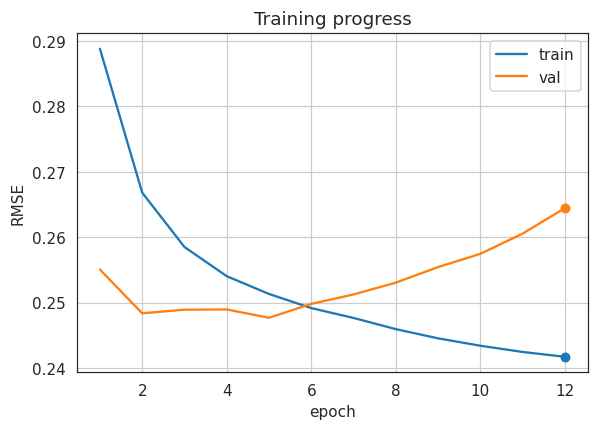

Epoch 1:   0%|          | 0/60 [00:05<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2888 MAE=0.2224 R2=0.0079 | Acc=0.6822 Prec=0.3437 Rec=0.2025 F1=0.2549 AUROC=0.5947
VALID→ RMSE=0.2551 MAE=0.1772 R2=0.1889 | Acc=0.7573 Prec=0.6902 Rec=0.2044 F1=0.3154 AUROC=0.7441


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2668 MAE=0.2048 R2=0.1533 | Acc=0.7504 Prec=0.5789 Rec=0.2565 F1=0.3555 AUROC=0.6964
VALID→ RMSE=0.2484 MAE=0.1848 R2=0.2309 | Acc=0.7630 Prec=0.6423 Rec=0.3009 F1=0.4098 AUROC=0.7464


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2585 MAE=0.1979 R2=0.2053 | Acc=0.7584 Prec=0.5982 Rec=0.3034 F1=0.4026 AUROC=0.7255
VALID→ RMSE=0.2489 MAE=0.1820 R2=0.2275 | Acc=0.7631 Prec=0.6591 Rec=0.2770 F1=0.3901 AUROC=0.7467


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2540 MAE=0.1934 R2=0.2325 | Acc=0.7631 Prec=0.6147 Rec=0.3137 F1=0.4154 AUROC=0.7417
VALID→ RMSE=0.2489 MAE=0.1829 R2=0.2273 | Acc=0.7631 Prec=0.6578 Rec=0.2787 F1=0.3915 AUROC=0.7451


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2513 MAE=0.1909 R2=0.2488 | Acc=0.7655 Prec=0.6201 Rec=0.3260 F1=0.4273 AUROC=0.7518
VALID→ RMSE=0.2477 MAE=0.1860 R2=0.2351 | Acc=0.7633 Prec=0.6476 Rec=0.2944 F1=0.4048 AUROC=0.7472


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2492 MAE=0.1887 R2=0.2617 | Acc=0.7684 Prec=0.6306 Rec=0.3308 F1=0.4339 AUROC=0.7592
VALID→ RMSE=0.2498 MAE=0.1824 R2=0.2219 | Acc=0.7625 Prec=0.6527 Rec=0.2813 F1=0.3932 AUROC=0.7475


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2476 MAE=0.1869 R2=0.2706 | Acc=0.7704 Prec=0.6364 Rec=0.3369 F1=0.4406 AUROC=0.7647
VALID→ RMSE=0.2512 MAE=0.1852 R2=0.2130 | Acc=0.7596 Prec=0.6310 Rec=0.2915 F1=0.3987 AUROC=0.7442


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2459 MAE=0.1856 R2=0.2806 | Acc=0.7725 Prec=0.6407 Rec=0.3471 F1=0.4503 AUROC=0.7701
VALID→ RMSE=0.2530 MAE=0.1885 R2=0.2016 | Acc=0.7537 Prec=0.5917 Rec=0.3203 F1=0.4156 AUROC=0.7407


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2445 MAE=0.1842 R2=0.2888 | Acc=0.7745 Prec=0.6468 Rec=0.3518 F1=0.4558 AUROC=0.7740
VALID→ RMSE=0.2554 MAE=0.1909 R2=0.1865 | Acc=0.7478 Prec=0.5643 Rec=0.3417 F1=0.4256 AUROC=0.7372


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2434 MAE=0.1831 R2=0.2954 | Acc=0.7763 Prec=0.6508 Rec=0.3595 F1=0.4632 AUROC=0.7773
VALID→ RMSE=0.2574 MAE=0.1923 R2=0.1736 | Acc=0.7445 Prec=0.5526 Rec=0.3451 F1=0.4249 AUROC=0.7350


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2424 MAE=0.1826 R2=0.3009 | Acc=0.7777 Prec=0.6524 Rec=0.3674 F1=0.4700 AUROC=0.7803
VALID→ RMSE=0.2606 MAE=0.1952 R2=0.1535 | Acc=0.7400 Prec=0.5365 Rec=0.3608 F1=0.4315 AUROC=0.7320


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.2417 MAE=0.1817 R2=0.3052 | Acc=0.7789 Prec=0.6559 Rec=0.3702 F1=0.4733 AUROC=0.7820
VALID→ RMSE=0.2645 MAE=0.1967 R2=0.1280 | Acc=0.7359 Prec=0.5245 Rec=0.3672 F1=0.4320 AUROC=0.7276
Early stopping at epoch 12
✅ Final best model (_fin) saved: AAPL_0.24767_fin.pth
Delete variables to free memory...


[I 2025-09-22 21:51:01,366] Trial 16 finished with value: 0.2476714849472046 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.2910330298111208, 'DROPOUT_LONG': 0.29836132760172784, 'ATT_DROPOUT': 0.3054419110193558, 'INITIAL_LR': 0.00046057930075086537, 'ETA_MIN': 3.6684007767247516e-06, 'WEIGHT_DECAY': 0.008940676435166328, 'CLIPNORM': 1.6476652986229916}. Best is trial 14 with value: 0.24645718932151794.



▶ Trial 17 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.21137326087760036, 'DROPOUT_LONG': 0.10358672857348597, 'ATT_DROPOUT': 0.30324636235510427, 'INITIAL_LR': 0.00044132239491303084, 'ETA_MIN': 5.9189831517708194e-06, 'WEIGHT_DECAY': 0.0024981184553617823, 'CLIPNORM': 4.4283351512390405}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


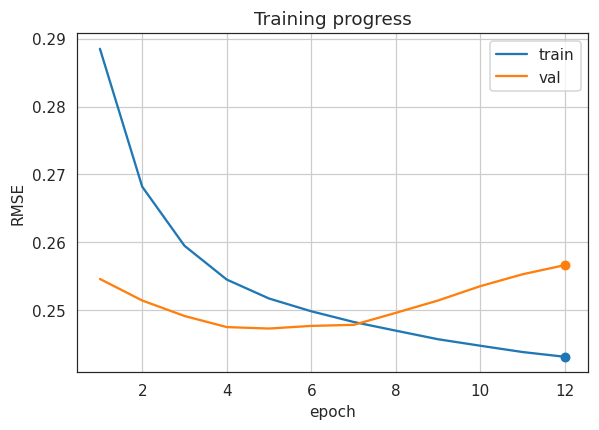

Epoch 1:   0%|          | 0/60 [00:03<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2885 MAE=0.2232 R2=0.0099 | Acc=0.7056 Prec=0.3348 Rec=0.0981 F1=0.1517 AUROC=0.5918
VALID→ RMSE=0.2546 MAE=0.1797 R2=0.1918 | Acc=0.7466 Prec=0.7736 Rec=0.1036 F1=0.1827 AUROC=0.7340


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2682 MAE=0.2047 R2=0.1445 | Acc=0.7506 Prec=0.5973 Rec=0.2166 F1=0.3179 AUROC=0.6875
VALID→ RMSE=0.2514 MAE=0.1821 R2=0.2119 | Acc=0.7611 Prec=0.6807 Rec=0.2383 F1=0.3530 AUROC=0.7433


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2595 MAE=0.1990 R2=0.1992 | Acc=0.7588 Prec=0.6103 Rec=0.2798 F1=0.3837 AUROC=0.7208
VALID→ RMSE=0.2491 MAE=0.1857 R2=0.2261 | Acc=0.7626 Prec=0.6575 Rec=0.2751 F1=0.3879 AUROC=0.7465


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2545 MAE=0.1941 R2=0.2297 | Acc=0.7639 Prec=0.6269 Rec=0.2971 F1=0.4031 AUROC=0.7440
VALID→ RMSE=0.2475 MAE=0.1847 R2=0.2363 | Acc=0.7631 Prec=0.6464 Rec=0.2951 F1=0.4052 AUROC=0.7529


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2517 MAE=0.1915 R2=0.2465 | Acc=0.7660 Prec=0.6272 Rec=0.3162 F1=0.4204 AUROC=0.7540
VALID→ RMSE=0.2473 MAE=0.1843 R2=0.2376 | Acc=0.7637 Prec=0.6542 Rec=0.2884 F1=0.4003 AUROC=0.7558


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2498 MAE=0.1894 R2=0.2577 | Acc=0.7681 Prec=0.6326 Rec=0.3243 F1=0.4288 AUROC=0.7607
VALID→ RMSE=0.2477 MAE=0.1835 R2=0.2352 | Acc=0.7629 Prec=0.6576 Rec=0.2771 F1=0.3899 AUROC=0.7565


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2482 MAE=0.1880 R2=0.2670 | Acc=0.7700 Prec=0.6366 Rec=0.3331 F1=0.4374 AUROC=0.7654
VALID→ RMSE=0.2478 MAE=0.1858 R2=0.2342 | Acc=0.7606 Prec=0.6284 Rec=0.3045 F1=0.4102 AUROC=0.7542


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2470 MAE=0.1867 R2=0.2746 | Acc=0.7718 Prec=0.6405 Rec=0.3410 F1=0.4450 AUROC=0.7695
VALID→ RMSE=0.2496 MAE=0.1838 R2=0.2232 | Acc=0.7586 Prec=0.6293 Rec=0.2848 F1=0.3922 AUROC=0.7507


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2457 MAE=0.1856 R2=0.2820 | Acc=0.7735 Prec=0.6443 Rec=0.3481 F1=0.4520 AUROC=0.7729
VALID→ RMSE=0.2514 MAE=0.1843 R2=0.2119 | Acc=0.7563 Prec=0.6220 Rec=0.2776 F1=0.3838 AUROC=0.7462


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2447 MAE=0.1848 R2=0.2876 | Acc=0.7748 Prec=0.6468 Rec=0.3543 F1=0.4579 AUROC=0.7759
VALID→ RMSE=0.2535 MAE=0.1843 R2=0.1985 | Acc=0.7538 Prec=0.6145 Rec=0.2680 F1=0.3732 AUROC=0.7404


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2438 MAE=0.1840 R2=0.2930 | Acc=0.7761 Prec=0.6484 Rec=0.3619 F1=0.4645 AUROC=0.7784
VALID→ RMSE=0.2553 MAE=0.1860 R2=0.1874 | Acc=0.7510 Prec=0.5989 Rec=0.2705 F1=0.3727 AUROC=0.7347


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.2431 MAE=0.1835 R2=0.2970 | Acc=0.7769 Prec=0.6498 Rec=0.3658 F1=0.4681 AUROC=0.7804
VALID→ RMSE=0.2566 MAE=0.1865 R2=0.1788 | Acc=0.7488 Prec=0.5907 Rec=0.2655 F1=0.3663 AUROC=0.7305
Early stopping at epoch 12
✅ Final best model (_fin) saved: AAPL_0.24728_fin.pth
Delete variables to free memory...


[I 2025-09-22 22:05:20,563] Trial 17 finished with value: 0.24727672338485718 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.21137326087760036, 'DROPOUT_LONG': 0.10358672857348597, 'ATT_DROPOUT': 0.30324636235510427, 'INITIAL_LR': 0.00044132239491303084, 'ETA_MIN': 5.9189831517708194e-06, 'WEIGHT_DECAY': 0.0024981184553617823, 'CLIPNORM': 4.4283351512390405}. Best is trial 14 with value: 0.24645718932151794.



▶ Trial 18 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.3002891274981368, 'DROPOUT_LONG': 0.2531892141565202, 'ATT_DROPOUT': 0.20939440043060584, 'INITIAL_LR': 0.0009991497593183605, 'ETA_MIN': 1.8913234236773305e-06, 'WEIGHT_DECAY': 0.002798099997633317, 'CLIPNORM': 1.8807487190992909}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


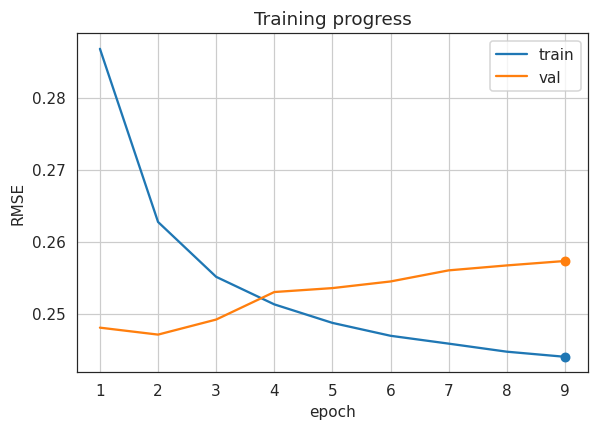

Epoch 1:   0%|          | 0/60 [00:06<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2868 MAE=0.2205 R2=0.0219 | Acc=0.7131 Prec=0.4419 Rec=0.2623 F1=0.3292 AUROC=0.6498
VALID→ RMSE=0.2481 MAE=0.1872 R2=0.2328 | Acc=0.7641 Prec=0.6638 Rec=0.2782 F1=0.3921 AUROC=0.7384


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2627 MAE=0.2017 R2=0.1790 | Acc=0.7565 Prec=0.5975 Rec=0.2839 F1=0.3849 AUROC=0.7082
VALID→ RMSE=0.2471 MAE=0.1837 R2=0.2387 | Acc=0.7649 Prec=0.6685 Rec=0.2780 F1=0.3927 AUROC=0.7501


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2551 MAE=0.1944 R2=0.2259 | Acc=0.7624 Prec=0.6139 Rec=0.3094 F1=0.4114 AUROC=0.7404
VALID→ RMSE=0.2492 MAE=0.1826 R2=0.2258 | Acc=0.7635 Prec=0.7026 Rec=0.2344 F1=0.3515 AUROC=0.7470


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2513 MAE=0.1908 R2=0.2490 | Acc=0.7667 Prec=0.6306 Rec=0.3154 F1=0.4205 AUROC=0.7536
VALID→ RMSE=0.2530 MAE=0.1848 R2=0.2019 | Acc=0.7597 Prec=0.7044 Rec=0.2088 F1=0.3221 AUROC=0.7342


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2487 MAE=0.1879 R2=0.2642 | Acc=0.7697 Prec=0.6414 Rec=0.3218 F1=0.4286 AUROC=0.7619
VALID→ RMSE=0.2535 MAE=0.1880 R2=0.1984 | Acc=0.7575 Prec=0.6796 Rec=0.2145 F1=0.3261 AUROC=0.7287


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2469 MAE=0.1864 R2=0.2748 | Acc=0.7716 Prec=0.6433 Rec=0.3341 F1=0.4398 AUROC=0.7682
VALID→ RMSE=0.2545 MAE=0.1879 R2=0.1926 | Acc=0.7551 Prec=0.6549 Rec=0.2209 F1=0.3304 AUROC=0.7263


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2458 MAE=0.1849 R2=0.2812 | Acc=0.7730 Prec=0.6488 Rec=0.3359 F1=0.4427 AUROC=0.7713
VALID→ RMSE=0.2560 MAE=0.1903 R2=0.1828 | Acc=0.7512 Prec=0.6258 Rec=0.2241 F1=0.3300 AUROC=0.7213


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2447 MAE=0.1843 R2=0.2877 | Acc=0.7746 Prec=0.6503 Rec=0.3463 F1=0.4519 AUROC=0.7748
VALID→ RMSE=0.2567 MAE=0.1924 R2=0.1784 | Acc=0.7467 Prec=0.5855 Rec=0.2528 F1=0.3531 AUROC=0.7211


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2440 MAE=0.1841 R2=0.2918 | Acc=0.7756 Prec=0.6492 Rec=0.3566 F1=0.4603 AUROC=0.7771
VALID→ RMSE=0.2573 MAE=0.1893 R2=0.1745 | Acc=0.7486 Prec=0.6107 Rec=0.2230 F1=0.3267 AUROC=0.7244
Early stopping at epoch 9
✅ Final best model (_fin) saved: AAPL_0.24709_fin.pth
Delete variables to free memory...


[I 2025-09-22 22:17:36,360] Trial 18 finished with value: 0.24709168076515198 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.3002891274981368, 'DROPOUT_LONG': 0.2531892141565202, 'ATT_DROPOUT': 0.20939440043060584, 'INITIAL_LR': 0.0009991497593183605, 'ETA_MIN': 1.8913234236773305e-06, 'WEIGHT_DECAY': 0.002798099997633317, 'CLIPNORM': 1.8807487190992909}. Best is trial 14 with value: 0.24645718932151794.



▶ Trial 19 starting with:
{'look_back': 30, 'DROPOUT_SHORT': 0.22001044013374096, 'DROPOUT_LONG': 0.1549277814989586, 'ATT_DROPOUT': 0.30128606189642215, 'INITIAL_LR': 0.0002192366667071169, 'ETA_MIN': 3.5733490111331296e-06, 'WEIGHT_DECAY': 0.0006986047707978678, 'CLIPNORM': 2.987935859885551}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


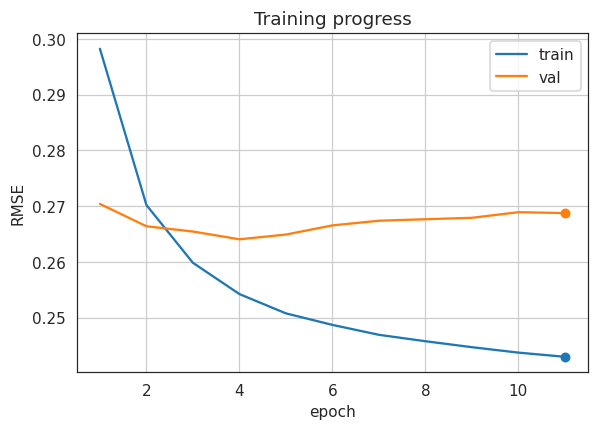

Epoch 1:   0%|          | 0/60 [00:02<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2982 MAE=0.2339 R2=-0.0422 | Acc=0.7058 Prec=0.4125 Rec=0.1005 F1=0.1616 AUROC=0.5994
VALID→ RMSE=0.2704 MAE=0.1919 R2=0.1248 | Acc=0.7060 Prec=0.7217 Rec=0.0064 F1=0.0126 AUROC=0.7252


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2702 MAE=0.2084 R2=0.1444 | Acc=0.7197 Prec=0.5090 Rec=0.1864 F1=0.2729 AUROC=0.6516
VALID→ RMSE=0.2664 MAE=0.1908 R2=0.1505 | Acc=0.7329 Prec=0.7222 Rec=0.1541 F1=0.2540 AUROC=0.7423


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2598 MAE=0.1989 R2=0.2087 | Acc=0.7447 Prec=0.6016 Rec=0.2812 F1=0.3832 AUROC=0.7130
VALID→ RMSE=0.2654 MAE=0.1954 R2=0.1565 | Acc=0.7422 Prec=0.6302 Rec=0.3056 F1=0.4116 AUROC=0.7405


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2542 MAE=0.1948 R2=0.2424 | Acc=0.7555 Prec=0.6229 Rec=0.3378 F1=0.4380 AUROC=0.7426
VALID→ RMSE=0.2641 MAE=0.1975 R2=0.1653 | Acc=0.7372 Prec=0.5906 Rec=0.3568 F1=0.4449 AUROC=0.7367


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2508 MAE=0.1920 R2=0.2629 | Acc=0.7605 Prec=0.6335 Rec=0.3581 F1=0.4575 AUROC=0.7552
VALID→ RMSE=0.2649 MAE=0.1990 R2=0.1599 | Acc=0.7317 Prec=0.5686 Rec=0.3761 F1=0.4527 AUROC=0.7322


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2487 MAE=0.1896 R2=0.2750 | Acc=0.7634 Prec=0.6431 Rec=0.3625 F1=0.4636 AUROC=0.7628
VALID→ RMSE=0.2665 MAE=0.2002 R2=0.1495 | Acc=0.7275 Prec=0.5554 Rec=0.3847 F1=0.4546 AUROC=0.7285


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2469 MAE=0.1880 R2=0.2853 | Acc=0.7655 Prec=0.6459 Rec=0.3739 F1=0.4737 AUROC=0.7680
VALID→ RMSE=0.2674 MAE=0.2014 R2=0.1441 | Acc=0.7250 Prec=0.5487 Rec=0.3833 F1=0.4513 AUROC=0.7250


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2458 MAE=0.1870 R2=0.2920 | Acc=0.7669 Prec=0.6492 Rec=0.3780 F1=0.4778 AUROC=0.7713
VALID→ RMSE=0.2677 MAE=0.2014 R2=0.1425 | Acc=0.7235 Prec=0.5457 Rec=0.3760 F1=0.4452 AUROC=0.7226


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2447 MAE=0.1861 R2=0.2981 | Acc=0.7685 Prec=0.6511 Rec=0.3868 F1=0.4853 AUROC=0.7747
VALID→ RMSE=0.2679 MAE=0.2017 R2=0.1408 | Acc=0.7226 Prec=0.5441 Rec=0.3707 F1=0.4409 AUROC=0.7208


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2437 MAE=0.1853 R2=0.3037 | Acc=0.7700 Prec=0.6539 Rec=0.3925 F1=0.4906 AUROC=0.7770
VALID→ RMSE=0.2689 MAE=0.2021 R2=0.1343 | Acc=0.7207 Prec=0.5396 Rec=0.3660 F1=0.4362 AUROC=0.7181


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2430 MAE=0.1850 R2=0.3079 | Acc=0.7707 Prec=0.6521 Rec=0.4011 F1=0.4967 AUROC=0.7792
VALID→ RMSE=0.2688 MAE=0.2023 R2=0.1354 | Acc=0.7201 Prec=0.5378 Rec=0.3671 F1=0.4364 AUROC=0.7168
Early stopping at epoch 11
✅ Final best model (_fin) saved: AAPL_0.26406_fin.pth
Delete variables to free memory...


[I 2025-09-22 22:29:42,959] Trial 19 finished with value: 0.2640577256679535 and parameters: {'look_back': 30, 'DROPOUT_SHORT': 0.22001044013374096, 'DROPOUT_LONG': 0.1549277814989586, 'ATT_DROPOUT': 0.30128606189642215, 'INITIAL_LR': 0.0002192366667071169, 'ETA_MIN': 3.5733490111331296e-06, 'WEIGHT_DECAY': 0.0006986047707978678, 'CLIPNORM': 2.987935859885551}. Best is trial 14 with value: 0.24645718932151794.



▶ Trial 20 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.2598919707328328, 'DROPOUT_LONG': 0.2142875957873102, 'ATT_DROPOUT': 0.21070201992901255, 'INITIAL_LR': 1.0800300091523645e-05, 'ETA_MIN': 5.91222988078688e-06, 'WEIGHT_DECAY': 0.004125508190593269, 'CLIPNORM': 1.1898961892833617}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


/workspace/my_models/Trading/_Stock_Analysis_/libs/plots.py:69: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  self.fig, self.ax = plt.subplots(figsize=(6, 4), dpi=110)


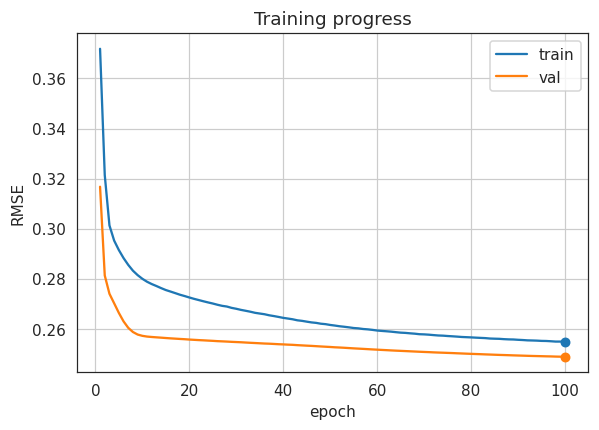

Epoch 1:   0%|          | 0/60 [00:04<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.3719 MAE=0.3316 R2=-0.6447 | Acc=0.4915 Prec=0.2444 Rec=0.4279 F1=0.3112 AUROC=0.4688
VALID→ RMSE=0.3167 MAE=0.2793 R2=-0.2510 | Acc=0.4865 Prec=0.2069 Rec=0.3098 F1=0.2481 AUROC=0.4397


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.3214 MAE=0.2738 R2=-0.2287 | Acc=0.5466 Prec=0.2433 Rec=0.3266 F1=0.2789 AUROC=0.4760
VALID→ RMSE=0.2813 MAE=0.2278 R2=0.0134 | Acc=0.5721 Prec=0.1859 Rec=0.1670 F1=0.1759 AUROC=0.4467


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.3013 MAE=0.2426 R2=-0.0797 | Acc=0.6302 Prec=0.2460 Rec=0.1830 F1=0.2099 AUROC=0.4865
VALID→ RMSE=0.2740 MAE=0.2060 R2=0.0640 | Acc=0.7247 Prec=0.2873 Rec=0.0046 F1=0.0090 AUROC=0.4606


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2952 MAE=0.2298 R2=-0.0367 | Acc=0.6941 Prec=0.2504 Rec=0.0701 F1=0.1095 AUROC=0.4962
VALID→ RMSE=0.2702 MAE=0.1979 R2=0.0898 | Acc=0.7265 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.4907


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2915 MAE=0.2237 R2=-0.0103 | Acc=0.7193 Prec=0.2626 Rec=0.0253 F1=0.0462 AUROC=0.5069
VALID→ RMSE=0.2663 MAE=0.1932 R2=0.1155 | Acc=0.7265 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.5436


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2882 MAE=0.2197 R2=0.0118 | Acc=0.7272 Prec=0.3030 Rec=0.0128 F1=0.0246 AUROC=0.5223
VALID→ RMSE=0.2630 MAE=0.1899 R2=0.1378 | Acc=0.7265 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.5957


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2855 MAE=0.2168 R2=0.0304 | Acc=0.7295 Prec=0.3579 Rec=0.0098 F1=0.0190 AUROC=0.5388
VALID→ RMSE=0.2604 MAE=0.1875 R2=0.1547 | Acc=0.7265 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6357


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2832 MAE=0.2144 R2=0.0461 | Acc=0.7309 Prec=0.4420 Rec=0.0108 F1=0.0211 AUROC=0.5554
VALID→ RMSE=0.2587 MAE=0.1859 R2=0.1655 | Acc=0.7265 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6635


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2814 MAE=0.2125 R2=0.0580 | Acc=0.7317 Prec=0.5060 Rec=0.0141 F1=0.0273 AUROC=0.5722
VALID→ RMSE=0.2577 MAE=0.1848 R2=0.1720 | Acc=0.7266 Prec=0.7143 Rec=0.0000 F1=0.0001 AUROC=0.6820


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2800 MAE=0.2110 R2=0.0677 | Acc=0.7324 Prec=0.5444 Rec=0.0185 F1=0.0359 AUROC=0.5857
VALID→ RMSE=0.2572 MAE=0.1841 R2=0.1753 | Acc=0.7266 Prec=0.7429 Rec=0.0005 F1=0.0010 AUROC=0.6942


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2788 MAE=0.2097 R2=0.0756 | Acc=0.7335 Prec=0.5813 Rec=0.0248 F1=0.0476 AUROC=0.5984
VALID→ RMSE=0.2569 MAE=0.1837 R2=0.1772 | Acc=0.7273 Prec=0.8211 Rec=0.0037 F1=0.0074 AUROC=0.7027


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.2779 MAE=0.2087 R2=0.0817 | Acc=0.7343 Prec=0.5930 Rec=0.0313 F1=0.0595 AUROC=0.6084
VALID→ RMSE=0.2567 MAE=0.1834 R2=0.1783 | Acc=0.7310 Prec=0.8513 Rec=0.0196 F1=0.0383 AUROC=0.7087


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.2771 MAE=0.2079 R2=0.0869 | Acc=0.7353 Prec=0.6046 Rec=0.0393 F1=0.0739 AUROC=0.6175
VALID→ RMSE=0.2566 MAE=0.1833 R2=0.1792 | Acc=0.7370 Prec=0.8208 Rec=0.0488 F1=0.0921 AUROC=0.7133


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ RMSE=0.2762 MAE=0.2072 R2=0.0924 | Acc=0.7365 Prec=0.6155 Rec=0.0481 F1=0.0893 AUROC=0.6252
VALID→ RMSE=0.2564 MAE=0.1832 R2=0.1800 | Acc=0.7426 Prec=0.7919 Rec=0.0796 F1=0.1446 AUROC=0.7166


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ RMSE=0.2755 MAE=0.2066 R2=0.0975 | Acc=0.7374 Prec=0.6163 Rec=0.0572 F1=0.1048 AUROC=0.6317
VALID→ RMSE=0.2563 MAE=0.1832 R2=0.1809 | Acc=0.7466 Prec=0.7675 Rec=0.1051 F1=0.1849 AUROC=0.7193


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ RMSE=0.2749 MAE=0.2062 R2=0.1014 | Acc=0.7385 Prec=0.6207 Rec=0.0661 F1=0.1195 AUROC=0.6372
VALID→ RMSE=0.2562 MAE=0.1832 R2=0.1818 | Acc=0.7492 Prec=0.7476 Rec=0.1250 F1=0.2141 AUROC=0.7214


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ RMSE=0.2742 MAE=0.2058 R2=0.1055 | Acc=0.7396 Prec=0.6230 Rec=0.0752 F1=0.1342 AUROC=0.6423
VALID→ RMSE=0.2560 MAE=0.1832 R2=0.1826 | Acc=0.7512 Prec=0.7327 Rec=0.1420 F1=0.2379 AUROC=0.7230


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ RMSE=0.2736 MAE=0.2054 R2=0.1097 | Acc=0.7407 Prec=0.6250 Rec=0.0845 F1=0.1489 AUROC=0.6462
VALID→ RMSE=0.2559 MAE=0.1832 R2=0.1833 | Acc=0.7528 Prec=0.7197 Rec=0.1570 F1=0.2578 AUROC=0.7244


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ RMSE=0.2731 MAE=0.2050 R2=0.1131 | Acc=0.7416 Prec=0.6242 Rec=0.0930 F1=0.1618 AUROC=0.6503
VALID→ RMSE=0.2558 MAE=0.1832 R2=0.1840 | Acc=0.7539 Prec=0.7092 Rec=0.1693 F1=0.2734 AUROC=0.7256


Epoch 20:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ RMSE=0.2725 MAE=0.2046 R2=0.1168 | Acc=0.7423 Prec=0.6231 Rec=0.1011 F1=0.1739 AUROC=0.6535
VALID→ RMSE=0.2557 MAE=0.1832 R2=0.1849 | Acc=0.7551 Prec=0.7018 Rec=0.1817 F1=0.2886 AUROC=0.7266


Epoch 21:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ RMSE=0.2720 MAE=0.2043 R2=0.1203 | Acc=0.7430 Prec=0.6220 Rec=0.1083 F1=0.1844 AUROC=0.6568
VALID→ RMSE=0.2556 MAE=0.1832 R2=0.1856 | Acc=0.7558 Prec=0.6933 Rec=0.1915 F1=0.3001 AUROC=0.7275


Epoch 22:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ RMSE=0.2715 MAE=0.2040 R2=0.1235 | Acc=0.7440 Prec=0.6246 Rec=0.1159 F1=0.1955 AUROC=0.6596
VALID→ RMSE=0.2555 MAE=0.1833 R2=0.1863 | Acc=0.7563 Prec=0.6868 Rec=0.2002 F1=0.3100 AUROC=0.7282


Epoch 23:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ RMSE=0.2710 MAE=0.2037 R2=0.1266 | Acc=0.7446 Prec=0.6228 Rec=0.1227 F1=0.2050 AUROC=0.6617
VALID→ RMSE=0.2554 MAE=0.1833 R2=0.1868 | Acc=0.7571 Prec=0.6824 Rec=0.2087 F1=0.3197 AUROC=0.7288


Epoch 24:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ RMSE=0.2705 MAE=0.2035 R2=0.1296 | Acc=0.7452 Prec=0.6218 Rec=0.1292 F1=0.2139 AUROC=0.6643
VALID→ RMSE=0.2553 MAE=0.1833 R2=0.1875 | Acc=0.7577 Prec=0.6784 Rec=0.2167 F1=0.3285 AUROC=0.7294


Epoch 25:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ RMSE=0.2701 MAE=0.2032 R2=0.1324 | Acc=0.7461 Prec=0.6238 Rec=0.1356 F1=0.2228 AUROC=0.6664
VALID→ RMSE=0.2552 MAE=0.1834 R2=0.1882 | Acc=0.7581 Prec=0.6740 Rec=0.2232 F1=0.3353 AUROC=0.7299


Epoch 26:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 026
TRAIN→ RMSE=0.2696 MAE=0.2029 R2=0.1356 | Acc=0.7468 Prec=0.6243 Rec=0.1417 F1=0.2309 AUROC=0.6688
VALID→ RMSE=0.2550 MAE=0.1834 R2=0.1889 | Acc=0.7584 Prec=0.6709 Rec=0.2289 F1=0.3413 AUROC=0.7304


Epoch 27:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 027
TRAIN→ RMSE=0.2692 MAE=0.2027 R2=0.1384 | Acc=0.7472 Prec=0.6231 Rec=0.1472 F1=0.2382 AUROC=0.6714
VALID→ RMSE=0.2550 MAE=0.1834 R2=0.1894 | Acc=0.7586 Prec=0.6676 Rec=0.2337 F1=0.3462 AUROC=0.7309


Epoch 28:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 028
TRAIN→ RMSE=0.2689 MAE=0.2025 R2=0.1401 | Acc=0.7476 Prec=0.6219 Rec=0.1520 F1=0.2444 AUROC=0.6727
VALID→ RMSE=0.2549 MAE=0.1834 R2=0.1900 | Acc=0.7588 Prec=0.6642 Rec=0.2387 F1=0.3512 AUROC=0.7313


Epoch 29:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 029
TRAIN→ RMSE=0.2683 MAE=0.2021 R2=0.1436 | Acc=0.7482 Prec=0.6224 Rec=0.1567 F1=0.2503 AUROC=0.6747
VALID→ RMSE=0.2548 MAE=0.1835 R2=0.1907 | Acc=0.7590 Prec=0.6618 Rec=0.2425 F1=0.3549 AUROC=0.7317


Epoch 30:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 030
TRAIN→ RMSE=0.2680 MAE=0.2020 R2=0.1459 | Acc=0.7486 Prec=0.6228 Rec=0.1605 F1=0.2552 AUROC=0.6766
VALID→ RMSE=0.2547 MAE=0.1835 R2=0.1912 | Acc=0.7591 Prec=0.6593 Rec=0.2463 F1=0.3586 AUROC=0.7321


Epoch 31:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 031
TRAIN→ RMSE=0.2675 MAE=0.2016 R2=0.1487 | Acc=0.7493 Prec=0.6240 Rec=0.1655 F1=0.2616 AUROC=0.6785
VALID→ RMSE=0.2546 MAE=0.1835 R2=0.1917 | Acc=0.7591 Prec=0.6571 Rec=0.2494 F1=0.3615 AUROC=0.7325


Epoch 32:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 032
TRAIN→ RMSE=0.2672 MAE=0.2014 R2=0.1510 | Acc=0.7497 Prec=0.6239 Rec=0.1693 F1=0.2664 AUROC=0.6802
VALID→ RMSE=0.2545 MAE=0.1836 R2=0.1924 | Acc=0.7592 Prec=0.6548 Rec=0.2529 F1=0.3649 AUROC=0.7329


Epoch 33:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 033
TRAIN→ RMSE=0.2668 MAE=0.2012 R2=0.1533 | Acc=0.7497 Prec=0.6219 Rec=0.1723 F1=0.2698 AUROC=0.6818
VALID→ RMSE=0.2544 MAE=0.1836 R2=0.1931 | Acc=0.7594 Prec=0.6530 Rec=0.2561 F1=0.3679 AUROC=0.7333


Epoch 34:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 034
TRAIN→ RMSE=0.2664 MAE=0.2009 R2=0.1561 | Acc=0.7502 Prec=0.6218 Rec=0.1763 F1=0.2747 AUROC=0.6835
VALID→ RMSE=0.2543 MAE=0.1836 R2=0.1937 | Acc=0.7595 Prec=0.6519 Rec=0.2583 F1=0.3700 AUROC=0.7337


Epoch 35:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 035
TRAIN→ RMSE=0.2661 MAE=0.2008 R2=0.1579 | Acc=0.7505 Prec=0.6220 Rec=0.1789 F1=0.2779 AUROC=0.6853
VALID→ RMSE=0.2542 MAE=0.1836 R2=0.1943 | Acc=0.7596 Prec=0.6505 Rec=0.2610 F1=0.3725 AUROC=0.7341


Epoch 36:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 036
TRAIN→ RMSE=0.2658 MAE=0.2006 R2=0.1597 | Acc=0.7510 Prec=0.6231 Rec=0.1828 F1=0.2827 AUROC=0.6866
VALID→ RMSE=0.2541 MAE=0.1836 R2=0.1950 | Acc=0.7597 Prec=0.6495 Rec=0.2631 F1=0.3745 AUROC=0.7344


Epoch 37:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 037
TRAIN→ RMSE=0.2654 MAE=0.2003 R2=0.1623 | Acc=0.7515 Prec=0.6244 Rec=0.1860 F1=0.2866 AUROC=0.6886
VALID→ RMSE=0.2540 MAE=0.1836 R2=0.1954 | Acc=0.7598 Prec=0.6487 Rec=0.2653 F1=0.3766 AUROC=0.7347


Epoch 38:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 038
TRAIN→ RMSE=0.2651 MAE=0.2001 R2=0.1643 | Acc=0.7518 Prec=0.6247 Rec=0.1883 F1=0.2894 AUROC=0.6903
VALID→ RMSE=0.2539 MAE=0.1836 R2=0.1960 | Acc=0.7599 Prec=0.6477 Rec=0.2676 F1=0.3787 AUROC=0.7351


Epoch 39:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 039
TRAIN→ RMSE=0.2647 MAE=0.1999 R2=0.1665 | Acc=0.7522 Prec=0.6249 Rec=0.1923 F1=0.2941 AUROC=0.6915
VALID→ RMSE=0.2538 MAE=0.1836 R2=0.1967 | Acc=0.7599 Prec=0.6466 Rec=0.2694 F1=0.3803 AUROC=0.7355


Epoch 40:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 040
TRAIN→ RMSE=0.2643 MAE=0.1996 R2=0.1688 | Acc=0.7524 Prec=0.6244 Rec=0.1943 F1=0.2964 AUROC=0.6927
VALID→ RMSE=0.2537 MAE=0.1836 R2=0.1972 | Acc=0.7601 Prec=0.6458 Rec=0.2714 F1=0.3822 AUROC=0.7358


Epoch 41:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 041
TRAIN→ RMSE=0.2641 MAE=0.1994 R2=0.1706 | Acc=0.7526 Prec=0.6237 Rec=0.1970 F1=0.2994 AUROC=0.6941
VALID→ RMSE=0.2536 MAE=0.1836 R2=0.1978 | Acc=0.7602 Prec=0.6454 Rec=0.2728 F1=0.3835 AUROC=0.7362


Epoch 42:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 042
TRAIN→ RMSE=0.2638 MAE=0.1992 R2=0.1724 | Acc=0.7531 Prec=0.6261 Rec=0.1988 F1=0.3018 AUROC=0.6957
VALID→ RMSE=0.2536 MAE=0.1836 R2=0.1983 | Acc=0.7602 Prec=0.6445 Rec=0.2745 F1=0.3850 AUROC=0.7366


Epoch 43:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 043
TRAIN→ RMSE=0.2634 MAE=0.1989 R2=0.1750 | Acc=0.7534 Prec=0.6258 Rec=0.2016 F1=0.3049 AUROC=0.6973
VALID→ RMSE=0.2534 MAE=0.1836 R2=0.1991 | Acc=0.7602 Prec=0.6438 Rec=0.2758 F1=0.3862 AUROC=0.7370


Epoch 44:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 044
TRAIN→ RMSE=0.2632 MAE=0.1988 R2=0.1764 | Acc=0.7535 Prec=0.6250 Rec=0.2034 F1=0.3069 AUROC=0.6983
VALID→ RMSE=0.2533 MAE=0.1836 R2=0.1997 | Acc=0.7603 Prec=0.6431 Rec=0.2772 F1=0.3874 AUROC=0.7373


Epoch 45:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 045
TRAIN→ RMSE=0.2628 MAE=0.1985 R2=0.1783 | Acc=0.7537 Prec=0.6249 Rec=0.2056 F1=0.3094 AUROC=0.6998
VALID→ RMSE=0.2532 MAE=0.1836 R2=0.2003 | Acc=0.7603 Prec=0.6425 Rec=0.2784 F1=0.3885 AUROC=0.7377


Epoch 46:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 046
TRAIN→ RMSE=0.2625 MAE=0.1983 R2=0.1802 | Acc=0.7542 Prec=0.6265 Rec=0.2079 F1=0.3122 AUROC=0.7013
VALID→ RMSE=0.2532 MAE=0.1836 R2=0.2009 | Acc=0.7604 Prec=0.6420 Rec=0.2797 F1=0.3897 AUROC=0.7381


Epoch 47:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 047
TRAIN→ RMSE=0.2623 MAE=0.1981 R2=0.1814 | Acc=0.7544 Prec=0.6264 Rec=0.2106 F1=0.3152 AUROC=0.7025
VALID→ RMSE=0.2530 MAE=0.1836 R2=0.2016 | Acc=0.7605 Prec=0.6419 Rec=0.2812 F1=0.3910 AUROC=0.7384


Epoch 48:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 048
TRAIN→ RMSE=0.2620 MAE=0.1979 R2=0.1835 | Acc=0.7546 Prec=0.6260 Rec=0.2123 F1=0.3171 AUROC=0.7038
VALID→ RMSE=0.2529 MAE=0.1836 R2=0.2024 | Acc=0.7606 Prec=0.6415 Rec=0.2824 F1=0.3921 AUROC=0.7388


Epoch 49:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 049
TRAIN→ RMSE=0.2618 MAE=0.1978 R2=0.1846 | Acc=0.7548 Prec=0.6262 Rec=0.2144 F1=0.3194 AUROC=0.7050
VALID→ RMSE=0.2528 MAE=0.1836 R2=0.2030 | Acc=0.7607 Prec=0.6412 Rec=0.2835 F1=0.3932 AUROC=0.7391


Epoch 50:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 050
TRAIN→ RMSE=0.2615 MAE=0.1976 R2=0.1866 | Acc=0.7550 Prec=0.6264 Rec=0.2159 F1=0.3211 AUROC=0.7061
VALID→ RMSE=0.2527 MAE=0.1836 R2=0.2037 | Acc=0.7607 Prec=0.6406 Rec=0.2846 F1=0.3941 AUROC=0.7395


Epoch 51:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 051
TRAIN→ RMSE=0.2613 MAE=0.1974 R2=0.1881 | Acc=0.7552 Prec=0.6263 Rec=0.2178 F1=0.3232 AUROC=0.7077
VALID→ RMSE=0.2526 MAE=0.1836 R2=0.2045 | Acc=0.7607 Prec=0.6401 Rec=0.2855 F1=0.3949 AUROC=0.7399


Epoch 52:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 052
TRAIN→ RMSE=0.2610 MAE=0.1972 R2=0.1898 | Acc=0.7555 Prec=0.6267 Rec=0.2204 F1=0.3261 AUROC=0.7086
VALID→ RMSE=0.2525 MAE=0.1836 R2=0.2050 | Acc=0.7607 Prec=0.6396 Rec=0.2865 F1=0.3958 AUROC=0.7402


Epoch 53:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 053
TRAIN→ RMSE=0.2608 MAE=0.1971 R2=0.1911 | Acc=0.7557 Prec=0.6268 Rec=0.2213 F1=0.3271 AUROC=0.7099
VALID→ RMSE=0.2524 MAE=0.1836 R2=0.2057 | Acc=0.7608 Prec=0.6392 Rec=0.2873 F1=0.3964 AUROC=0.7405


Epoch 54:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 054
TRAIN→ RMSE=0.2606 MAE=0.1968 R2=0.1925 | Acc=0.7560 Prec=0.6278 Rec=0.2232 F1=0.3293 AUROC=0.7114
VALID→ RMSE=0.2523 MAE=0.1836 R2=0.2064 | Acc=0.7609 Prec=0.6392 Rec=0.2882 F1=0.3973 AUROC=0.7409


Epoch 55:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 055
TRAIN→ RMSE=0.2603 MAE=0.1967 R2=0.1942 | Acc=0.7565 Prec=0.6293 Rec=0.2255 F1=0.3321 AUROC=0.7126
VALID→ RMSE=0.2522 MAE=0.1836 R2=0.2072 | Acc=0.7609 Prec=0.6389 Rec=0.2892 F1=0.3982 AUROC=0.7411


Epoch 56:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 056
TRAIN→ RMSE=0.2602 MAE=0.1966 R2=0.1950 | Acc=0.7565 Prec=0.6280 Rec=0.2272 F1=0.3337 AUROC=0.7133
VALID→ RMSE=0.2521 MAE=0.1836 R2=0.2078 | Acc=0.7610 Prec=0.6388 Rec=0.2899 F1=0.3988 AUROC=0.7414


Epoch 57:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 057
TRAIN→ RMSE=0.2599 MAE=0.1964 R2=0.1966 | Acc=0.7567 Prec=0.6279 Rec=0.2293 F1=0.3359 AUROC=0.7145
VALID→ RMSE=0.2520 MAE=0.1836 R2=0.2084 | Acc=0.7610 Prec=0.6386 Rec=0.2907 F1=0.3995 AUROC=0.7418


Epoch 58:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 058
TRAIN→ RMSE=0.2598 MAE=0.1962 R2=0.1975 | Acc=0.7568 Prec=0.6278 Rec=0.2304 F1=0.3371 AUROC=0.7155
VALID→ RMSE=0.2518 MAE=0.1836 R2=0.2091 | Acc=0.7612 Prec=0.6386 Rec=0.2915 F1=0.4003 AUROC=0.7420


Epoch 59:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 059
TRAIN→ RMSE=0.2595 MAE=0.1961 R2=0.1988 | Acc=0.7569 Prec=0.6277 Rec=0.2319 F1=0.3387 AUROC=0.7162
VALID→ RMSE=0.2517 MAE=0.1836 R2=0.2098 | Acc=0.7612 Prec=0.6386 Rec=0.2922 F1=0.4010 AUROC=0.7423


Epoch 60:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 060
TRAIN→ RMSE=0.2593 MAE=0.1960 R2=0.2004 | Acc=0.7572 Prec=0.6279 Rec=0.2337 F1=0.3406 AUROC=0.7178
VALID→ RMSE=0.2516 MAE=0.1836 R2=0.2104 | Acc=0.7613 Prec=0.6382 Rec=0.2932 F1=0.4018 AUROC=0.7425


Epoch 61:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 061
TRAIN→ RMSE=0.2591 MAE=0.1958 R2=0.2014 | Acc=0.7573 Prec=0.6279 Rec=0.2351 F1=0.3421 AUROC=0.7187
VALID→ RMSE=0.2515 MAE=0.1836 R2=0.2111 | Acc=0.7613 Prec=0.6381 Rec=0.2938 F1=0.4023 AUROC=0.7428


Epoch 62:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 062
TRAIN→ RMSE=0.2590 MAE=0.1957 R2=0.2022 | Acc=0.7574 Prec=0.6275 Rec=0.2366 F1=0.3437 AUROC=0.7193
VALID→ RMSE=0.2514 MAE=0.1836 R2=0.2117 | Acc=0.7613 Prec=0.6379 Rec=0.2944 F1=0.4028 AUROC=0.7430


Epoch 63:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 063
TRAIN→ RMSE=0.2588 MAE=0.1955 R2=0.2032 | Acc=0.7577 Prec=0.6281 Rec=0.2379 F1=0.3450 AUROC=0.7203
VALID→ RMSE=0.2513 MAE=0.1836 R2=0.2123 | Acc=0.7614 Prec=0.6379 Rec=0.2946 F1=0.4031 AUROC=0.7433


Epoch 64:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 064
TRAIN→ RMSE=0.2586 MAE=0.1954 R2=0.2044 | Acc=0.7578 Prec=0.6280 Rec=0.2392 F1=0.3464 AUROC=0.7211
VALID→ RMSE=0.2512 MAE=0.1836 R2=0.2129 | Acc=0.7614 Prec=0.6378 Rec=0.2951 F1=0.4035 AUROC=0.7434


Epoch 65:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 065
TRAIN→ RMSE=0.2584 MAE=0.1952 R2=0.2056 | Acc=0.7581 Prec=0.6289 Rec=0.2403 F1=0.3477 AUROC=0.7220
VALID→ RMSE=0.2512 MAE=0.1836 R2=0.2134 | Acc=0.7615 Prec=0.6377 Rec=0.2956 F1=0.4039 AUROC=0.7436


Epoch 66:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 066
TRAIN→ RMSE=0.2583 MAE=0.1952 R2=0.2062 | Acc=0.7583 Prec=0.6293 Rec=0.2416 F1=0.3492 AUROC=0.7225
VALID→ RMSE=0.2511 MAE=0.1836 R2=0.2140 | Acc=0.7614 Prec=0.6374 Rec=0.2959 F1=0.4042 AUROC=0.7438


Epoch 67:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 067
TRAIN→ RMSE=0.2582 MAE=0.1950 R2=0.2072 | Acc=0.7584 Prec=0.6298 Rec=0.2424 F1=0.3501 AUROC=0.7237
VALID→ RMSE=0.2510 MAE=0.1836 R2=0.2145 | Acc=0.7615 Prec=0.6373 Rec=0.2963 F1=0.4045 AUROC=0.7440


Epoch 68:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 068
TRAIN→ RMSE=0.2580 MAE=0.1949 R2=0.2081 | Acc=0.7586 Prec=0.6298 Rec=0.2442 F1=0.3519 AUROC=0.7243
VALID→ RMSE=0.2509 MAE=0.1836 R2=0.2151 | Acc=0.7614 Prec=0.6368 Rec=0.2969 F1=0.4050 AUROC=0.7442


Epoch 69:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 069
TRAIN→ RMSE=0.2578 MAE=0.1948 R2=0.2094 | Acc=0.7585 Prec=0.6286 Rec=0.2449 F1=0.3525 AUROC=0.7251
VALID→ RMSE=0.2508 MAE=0.1836 R2=0.2156 | Acc=0.7615 Prec=0.6369 Rec=0.2976 F1=0.4057 AUROC=0.7443


Epoch 70:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 070
TRAIN→ RMSE=0.2577 MAE=0.1947 R2=0.2098 | Acc=0.7588 Prec=0.6291 Rec=0.2465 F1=0.3543 AUROC=0.7257
VALID→ RMSE=0.2507 MAE=0.1836 R2=0.2161 | Acc=0.7616 Prec=0.6373 Rec=0.2975 F1=0.4056 AUROC=0.7445


Epoch 71:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 071
TRAIN→ RMSE=0.2576 MAE=0.1946 R2=0.2106 | Acc=0.7590 Prec=0.6301 Rec=0.2472 F1=0.3551 AUROC=0.7265
VALID→ RMSE=0.2507 MAE=0.1836 R2=0.2166 | Acc=0.7616 Prec=0.6371 Rec=0.2980 F1=0.4061 AUROC=0.7446


Epoch 72:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 072
TRAIN→ RMSE=0.2575 MAE=0.1945 R2=0.2116 | Acc=0.7590 Prec=0.6291 Rec=0.2482 F1=0.3560 AUROC=0.7269
VALID→ RMSE=0.2506 MAE=0.1836 R2=0.2172 | Acc=0.7616 Prec=0.6367 Rec=0.2989 F1=0.4068 AUROC=0.7447


Epoch 73:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 073
TRAIN→ RMSE=0.2573 MAE=0.1944 R2=0.2125 | Acc=0.7590 Prec=0.6288 Rec=0.2493 F1=0.3571 AUROC=0.7278
VALID→ RMSE=0.2505 MAE=0.1836 R2=0.2176 | Acc=0.7618 Prec=0.6372 Rec=0.2990 F1=0.4070 AUROC=0.7449


Epoch 74:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 074
TRAIN→ RMSE=0.2572 MAE=0.1943 R2=0.2130 | Acc=0.7591 Prec=0.6289 Rec=0.2502 F1=0.3579 AUROC=0.7286
VALID→ RMSE=0.2504 MAE=0.1836 R2=0.2181 | Acc=0.7618 Prec=0.6373 Rec=0.2995 F1=0.4075 AUROC=0.7450


Epoch 75:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 075
TRAIN→ RMSE=0.2571 MAE=0.1942 R2=0.2138 | Acc=0.7594 Prec=0.6297 Rec=0.2515 F1=0.3594 AUROC=0.7292
VALID→ RMSE=0.2504 MAE=0.1836 R2=0.2185 | Acc=0.7619 Prec=0.6373 Rec=0.3000 F1=0.4080 AUROC=0.7451


Epoch 76:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 076
TRAIN→ RMSE=0.2570 MAE=0.1941 R2=0.2145 | Acc=0.7594 Prec=0.6291 Rec=0.2523 F1=0.3601 AUROC=0.7294
VALID→ RMSE=0.2503 MAE=0.1836 R2=0.2189 | Acc=0.7619 Prec=0.6375 Rec=0.3000 F1=0.4080 AUROC=0.7452


Epoch 77:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 077
TRAIN→ RMSE=0.2569 MAE=0.1939 R2=0.2153 | Acc=0.7599 Prec=0.6314 Rec=0.2530 F1=0.3613 AUROC=0.7301
VALID→ RMSE=0.2502 MAE=0.1836 R2=0.2195 | Acc=0.7620 Prec=0.6373 Rec=0.3006 F1=0.4085 AUROC=0.7453


Epoch 78:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 078
TRAIN→ RMSE=0.2567 MAE=0.1938 R2=0.2162 | Acc=0.7595 Prec=0.6292 Rec=0.2533 F1=0.3612 AUROC=0.7306
VALID→ RMSE=0.2501 MAE=0.1836 R2=0.2199 | Acc=0.7620 Prec=0.6374 Rec=0.3009 F1=0.4088 AUROC=0.7454


Epoch 79:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 079
TRAIN→ RMSE=0.2566 MAE=0.1937 R2=0.2167 | Acc=0.7600 Prec=0.6302 Rec=0.2555 F1=0.3636 AUROC=0.7312
VALID→ RMSE=0.2500 MAE=0.1836 R2=0.2204 | Acc=0.7621 Prec=0.6377 Rec=0.3012 F1=0.4091 AUROC=0.7456


Epoch 80:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 080
TRAIN→ RMSE=0.2565 MAE=0.1937 R2=0.2172 | Acc=0.7599 Prec=0.6296 Rec=0.2557 F1=0.3637 AUROC=0.7316
VALID→ RMSE=0.2500 MAE=0.1836 R2=0.2209 | Acc=0.7621 Prec=0.6375 Rec=0.3017 F1=0.4095 AUROC=0.7457


Epoch 81:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 081
TRAIN→ RMSE=0.2564 MAE=0.1936 R2=0.2178 | Acc=0.7601 Prec=0.6304 Rec=0.2569 F1=0.3650 AUROC=0.7321
VALID→ RMSE=0.2499 MAE=0.1836 R2=0.2213 | Acc=0.7621 Prec=0.6373 Rec=0.3022 F1=0.4099 AUROC=0.7457


Epoch 82:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 082
TRAIN→ RMSE=0.2563 MAE=0.1935 R2=0.2184 | Acc=0.7601 Prec=0.6300 Rec=0.2575 F1=0.3656 AUROC=0.7328
VALID→ RMSE=0.2498 MAE=0.1836 R2=0.2217 | Acc=0.7622 Prec=0.6374 Rec=0.3024 F1=0.4102 AUROC=0.7458


Epoch 83:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 083
TRAIN→ RMSE=0.2563 MAE=0.1935 R2=0.2189 | Acc=0.7602 Prec=0.6298 Rec=0.2587 F1=0.3667 AUROC=0.7334
VALID→ RMSE=0.2498 MAE=0.1836 R2=0.2222 | Acc=0.7623 Prec=0.6374 Rec=0.3029 F1=0.4106 AUROC=0.7459


Epoch 84:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 084
TRAIN→ RMSE=0.2561 MAE=0.1934 R2=0.2200 | Acc=0.7602 Prec=0.6290 Rec=0.2592 F1=0.3671 AUROC=0.7339
VALID→ RMSE=0.2497 MAE=0.1836 R2=0.2226 | Acc=0.7623 Prec=0.6377 Rec=0.3031 F1=0.4109 AUROC=0.7460


Epoch 85:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 085
TRAIN→ RMSE=0.2560 MAE=0.1933 R2=0.2204 | Acc=0.7606 Prec=0.6305 Rec=0.2605 F1=0.3687 AUROC=0.7342
VALID→ RMSE=0.2496 MAE=0.1836 R2=0.2231 | Acc=0.7624 Prec=0.6376 Rec=0.3035 F1=0.4113 AUROC=0.7461


Epoch 86:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 086
TRAIN→ RMSE=0.2560 MAE=0.1932 R2=0.2207 | Acc=0.7605 Prec=0.6300 Rec=0.2608 F1=0.3689 AUROC=0.7347
VALID→ RMSE=0.2495 MAE=0.1836 R2=0.2235 | Acc=0.7624 Prec=0.6376 Rec=0.3039 F1=0.4116 AUROC=0.7462


Epoch 87:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 087
TRAIN→ RMSE=0.2558 MAE=0.1932 R2=0.2215 | Acc=0.7607 Prec=0.6303 Rec=0.2620 F1=0.3701 AUROC=0.7349
VALID→ RMSE=0.2495 MAE=0.1836 R2=0.2238 | Acc=0.7625 Prec=0.6380 Rec=0.3042 F1=0.4120 AUROC=0.7462


Epoch 88:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 088
TRAIN→ RMSE=0.2558 MAE=0.1931 R2=0.2220 | Acc=0.7608 Prec=0.6301 Rec=0.2632 F1=0.3713 AUROC=0.7356
VALID→ RMSE=0.2494 MAE=0.1836 R2=0.2242 | Acc=0.7626 Prec=0.6380 Rec=0.3047 F1=0.4124 AUROC=0.7463


Epoch 89:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 089
TRAIN→ RMSE=0.2557 MAE=0.1930 R2=0.2223 | Acc=0.7608 Prec=0.6299 Rec=0.2637 F1=0.3718 AUROC=0.7357
VALID→ RMSE=0.2494 MAE=0.1836 R2=0.2247 | Acc=0.7626 Prec=0.6378 Rec=0.3049 F1=0.4126 AUROC=0.7464


Epoch 90:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 090
TRAIN→ RMSE=0.2556 MAE=0.1929 R2=0.2231 | Acc=0.7609 Prec=0.6299 Rec=0.2643 F1=0.3724 AUROC=0.7363
VALID→ RMSE=0.2493 MAE=0.1836 R2=0.2250 | Acc=0.7626 Prec=0.6378 Rec=0.3051 F1=0.4127 AUROC=0.7465


Epoch 91:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 091
TRAIN→ RMSE=0.2555 MAE=0.1929 R2=0.2236 | Acc=0.7608 Prec=0.6290 Rec=0.2650 F1=0.3729 AUROC=0.7371
VALID→ RMSE=0.2492 MAE=0.1836 R2=0.2254 | Acc=0.7626 Prec=0.6378 Rec=0.3055 F1=0.4131 AUROC=0.7466


Epoch 92:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 092
TRAIN→ RMSE=0.2554 MAE=0.1928 R2=0.2244 | Acc=0.7612 Prec=0.6306 Rec=0.2663 F1=0.3745 AUROC=0.7371
VALID→ RMSE=0.2492 MAE=0.1836 R2=0.2258 | Acc=0.7627 Prec=0.6377 Rec=0.3059 F1=0.4135 AUROC=0.7466


Epoch 93:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 093
TRAIN→ RMSE=0.2553 MAE=0.1927 R2=0.2247 | Acc=0.7612 Prec=0.6301 Rec=0.2667 F1=0.3748 AUROC=0.7376
VALID→ RMSE=0.2491 MAE=0.1836 R2=0.2261 | Acc=0.7627 Prec=0.6379 Rec=0.3060 F1=0.4136 AUROC=0.7467


Epoch 94:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 094
TRAIN→ RMSE=0.2553 MAE=0.1927 R2=0.2251 | Acc=0.7612 Prec=0.6292 Rec=0.2681 F1=0.3760 AUROC=0.7383
VALID→ RMSE=0.2491 MAE=0.1836 R2=0.2264 | Acc=0.7628 Prec=0.6382 Rec=0.3061 F1=0.4137 AUROC=0.7468


Epoch 95:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 095
TRAIN→ RMSE=0.2551 MAE=0.1926 R2=0.2257 | Acc=0.7614 Prec=0.6304 Rec=0.2685 F1=0.3766 AUROC=0.7382
VALID→ RMSE=0.2490 MAE=0.1836 R2=0.2267 | Acc=0.7628 Prec=0.6381 Rec=0.3065 F1=0.4141 AUROC=0.7468


Epoch 96:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 096
TRAIN→ RMSE=0.2551 MAE=0.1926 R2=0.2259 | Acc=0.7616 Prec=0.6305 Rec=0.2694 F1=0.3775 AUROC=0.7388
VALID→ RMSE=0.2490 MAE=0.1836 R2=0.2270 | Acc=0.7629 Prec=0.6380 Rec=0.3069 F1=0.4145 AUROC=0.7469


Epoch 97:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 097
TRAIN→ RMSE=0.2550 MAE=0.1925 R2=0.2266 | Acc=0.7615 Prec=0.6296 Rec=0.2700 F1=0.3779 AUROC=0.7391
VALID→ RMSE=0.2489 MAE=0.1836 R2=0.2273 | Acc=0.7629 Prec=0.6381 Rec=0.3070 F1=0.4146 AUROC=0.7469


Epoch 98:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 098
TRAIN→ RMSE=0.2549 MAE=0.1924 R2=0.2274 | Acc=0.7617 Prec=0.6301 Rec=0.2713 F1=0.3793 AUROC=0.7396
VALID→ RMSE=0.2489 MAE=0.1836 R2=0.2277 | Acc=0.7629 Prec=0.6380 Rec=0.3075 F1=0.4150 AUROC=0.7470


Epoch 99:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 099
TRAIN→ RMSE=0.2549 MAE=0.1924 R2=0.2274 | Acc=0.7613 Prec=0.6284 Rec=0.2710 F1=0.3787 AUROC=0.7397
VALID→ RMSE=0.2488 MAE=0.1836 R2=0.2279 | Acc=0.7630 Prec=0.6381 Rec=0.3077 F1=0.4152 AUROC=0.7471


Epoch 100:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 100
TRAIN→ RMSE=0.2548 MAE=0.1924 R2=0.2278 | Acc=0.7618 Prec=0.6302 Rec=0.2725 F1=0.3805 AUROC=0.7400
VALID→ RMSE=0.2488 MAE=0.1836 R2=0.2282 | Acc=0.7631 Prec=0.6385 Rec=0.3079 F1=0.4155 AUROC=0.7471
✅ Final best model (_fin) saved: AAPL_0.24879_fin.pth
Delete variables to free memory...


[I 2025-09-22 23:51:43,431] Trial 20 finished with value: 0.24879375100135803 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.2598919707328328, 'DROPOUT_LONG': 0.2142875957873102, 'ATT_DROPOUT': 0.21070201992901255, 'INITIAL_LR': 1.0800300091523645e-05, 'ETA_MIN': 5.91222988078688e-06, 'WEIGHT_DECAY': 0.004125508190593269, 'CLIPNORM': 1.1898961892833617}. Best is trial 14 with value: 0.24645718932151794.



▶ Trial 21 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.30677403564017103, 'DROPOUT_LONG': 0.26812708144618064, 'ATT_DROPOUT': 0.21436798289325643, 'INITIAL_LR': 0.0008760299895578285, 'ETA_MIN': 1.7279910337411943e-06, 'WEIGHT_DECAY': 0.002208975815877006, 'CLIPNORM': 2.235787488603406}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


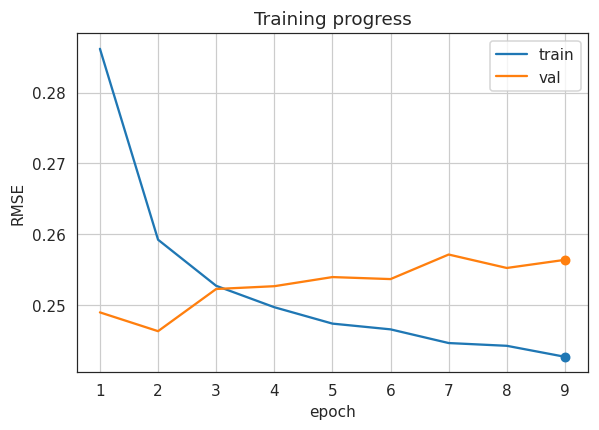

Epoch 1:   0%|          | 0/60 [00:04<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2862 MAE=0.2183 R2=0.0258 | Acc=0.7216 Prec=0.4512 Rec=0.1717 F1=0.2488 AUROC=0.6454
VALID→ RMSE=0.2490 MAE=0.1882 R2=0.2271 | Acc=0.7629 Prec=0.6629 Rec=0.2704 F1=0.3841 AUROC=0.7401


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2592 MAE=0.1985 R2=0.2007 | Acc=0.7604 Prec=0.6139 Rec=0.2894 F1=0.3934 AUROC=0.7241
VALID→ RMSE=0.2463 MAE=0.1836 R2=0.2435 | Acc=0.7653 Prec=0.6409 Rec=0.3223 F1=0.4289 AUROC=0.7495


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2527 MAE=0.1915 R2=0.2404 | Acc=0.7657 Prec=0.6253 Rec=0.3167 F1=0.4204 AUROC=0.7496
VALID→ RMSE=0.2523 MAE=0.1785 R2=0.2065 | Acc=0.7641 Prec=0.7049 Rec=0.2362 F1=0.3538 AUROC=0.7462


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2497 MAE=0.1886 R2=0.2584 | Acc=0.7690 Prec=0.6350 Rec=0.3275 F1=0.4321 AUROC=0.7602
VALID→ RMSE=0.2527 MAE=0.1797 R2=0.2040 | Acc=0.7623 Prec=0.7021 Rec=0.2272 F1=0.3433 AUROC=0.7416


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2474 MAE=0.1864 R2=0.2721 | Acc=0.7714 Prec=0.6387 Rec=0.3411 F1=0.4447 AUROC=0.7677
VALID→ RMSE=0.2540 MAE=0.1799 R2=0.1958 | Acc=0.7607 Prec=0.6976 Rec=0.2202 F1=0.3347 AUROC=0.7392


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2466 MAE=0.1852 R2=0.2769 | Acc=0.7731 Prec=0.6456 Rec=0.3424 F1=0.4475 AUROC=0.7702
VALID→ RMSE=0.2537 MAE=0.1819 R2=0.1976 | Acc=0.7602 Prec=0.6672 Rec=0.2454 F1=0.3588 AUROC=0.7330


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2446 MAE=0.1844 R2=0.2882 | Acc=0.7757 Prec=0.6503 Rec=0.3550 F1=0.4593 AUROC=0.7753
VALID→ RMSE=0.2571 MAE=0.1814 R2=0.1756 | Acc=0.7577 Prec=0.6724 Rec=0.2222 F1=0.3340 AUROC=0.7269


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2442 MAE=0.1831 R2=0.2905 | Acc=0.7762 Prec=0.6529 Rec=0.3547 F1=0.4597 AUROC=0.7765
VALID→ RMSE=0.2552 MAE=0.1830 R2=0.1877 | Acc=0.7574 Prec=0.6524 Rec=0.2418 F1=0.3528 AUROC=0.7264


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2427 MAE=0.1830 R2=0.2994 | Acc=0.7778 Prec=0.6511 Rec=0.3709 F1=0.4726 AUROC=0.7811
VALID→ RMSE=0.2564 MAE=0.1887 R2=0.1804 | Acc=0.7505 Prec=0.5943 Rec=0.2755 F1=0.3765 AUROC=0.7174
Early stopping at epoch 9
✅ Final best model (_fin) saved: AAPL_0.24631_fin.pth
Delete variables to free memory...


[I 2025-09-23 00:01:46,745] Trial 21 finished with value: 0.24631395936012268 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.30677403564017103, 'DROPOUT_LONG': 0.26812708144618064, 'ATT_DROPOUT': 0.21436798289325643, 'INITIAL_LR': 0.0008760299895578285, 'ETA_MIN': 1.7279910337411943e-06, 'WEIGHT_DECAY': 0.002208975815877006, 'CLIPNORM': 2.235787488603406}. Best is trial 21 with value: 0.24631395936012268.



▶ Trial 22 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.3136103046031929, 'DROPOUT_LONG': 0.2927333051663058, 'ATT_DROPOUT': 0.2833933786733215, 'INITIAL_LR': 0.0005685797442981763, 'ETA_MIN': 1.6437991459354376e-06, 'WEIGHT_DECAY': 0.0015704342651329806, 'CLIPNORM': 3.8648364758235125}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


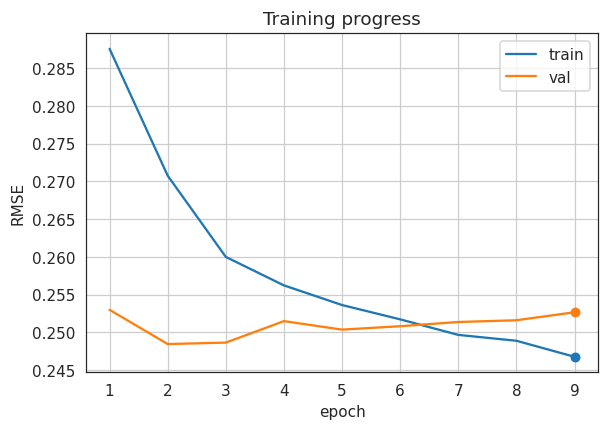

Epoch 1:   0%|          | 0/60 [00:04<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2875 MAE=0.2208 R2=0.0166 | Acc=0.6974 Prec=0.3704 Rec=0.1822 F1=0.2443 AUROC=0.6032
VALID→ RMSE=0.2530 MAE=0.1852 R2=0.2020 | Acc=0.7602 Prec=0.6396 Rec=0.2815 F1=0.3910 AUROC=0.7304


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2707 MAE=0.2092 R2=0.1281 | Acc=0.7447 Prec=0.5484 Rec=0.2757 F1=0.3670 AUROC=0.6886
VALID→ RMSE=0.2485 MAE=0.1869 R2=0.2303 | Acc=0.7641 Prec=0.6388 Rec=0.3157 F1=0.4226 AUROC=0.7402


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2600 MAE=0.1980 R2=0.1961 | Acc=0.7581 Prec=0.6031 Rec=0.2890 F1=0.3907 AUROC=0.7219
VALID→ RMSE=0.2486 MAE=0.1808 R2=0.2291 | Acc=0.7667 Prec=0.6730 Rec=0.2855 F1=0.4010 AUROC=0.7498


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2562 MAE=0.1957 R2=0.2192 | Acc=0.7619 Prec=0.6122 Rec=0.3077 F1=0.4095 AUROC=0.7351
VALID→ RMSE=0.2515 MAE=0.1787 R2=0.2114 | Acc=0.7658 Prec=0.7029 Rec=0.2485 F1=0.3672 AUROC=0.7527


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2536 MAE=0.1913 R2=0.2350 | Acc=0.7647 Prec=0.6296 Rec=0.2998 F1=0.4062 AUROC=0.7457
VALID→ RMSE=0.2504 MAE=0.1793 R2=0.2184 | Acc=0.7646 Prec=0.6914 Rec=0.2512 F1=0.3685 AUROC=0.7541


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2517 MAE=0.1911 R2=0.2464 | Acc=0.7666 Prec=0.6264 Rec=0.3228 F1=0.4260 AUROC=0.7518
VALID→ RMSE=0.2508 MAE=0.1801 R2=0.2156 | Acc=0.7629 Prec=0.6814 Rec=0.2498 F1=0.3656 AUROC=0.7530


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2497 MAE=0.1894 R2=0.2586 | Acc=0.7687 Prec=0.6324 Rec=0.3301 F1=0.4337 AUROC=0.7582
VALID→ RMSE=0.2514 MAE=0.1800 R2=0.2121 | Acc=0.7615 Prec=0.6666 Rec=0.2555 F1=0.3694 AUROC=0.7528


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2489 MAE=0.1886 R2=0.2632 | Acc=0.7700 Prec=0.6341 Rec=0.3380 F1=0.4409 AUROC=0.7615
VALID→ RMSE=0.2516 MAE=0.1812 R2=0.2107 | Acc=0.7592 Prec=0.6570 Rec=0.2496 F1=0.3618 AUROC=0.7519


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2468 MAE=0.1866 R2=0.2758 | Acc=0.7722 Prec=0.6419 Rec=0.3423 F1=0.4465 AUROC=0.7676
VALID→ RMSE=0.2527 MAE=0.1826 R2=0.2040 | Acc=0.7571 Prec=0.6351 Rec=0.2622 F1=0.3712 AUROC=0.7479
Early stopping at epoch 9
✅ Final best model (_fin) saved: AAPL_0.24845_fin.pth
Delete variables to free memory...


[I 2025-09-23 00:14:52,228] Trial 22 finished with value: 0.24845273792743683 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.3136103046031929, 'DROPOUT_LONG': 0.2927333051663058, 'ATT_DROPOUT': 0.2833933786733215, 'INITIAL_LR': 0.0005685797442981763, 'ETA_MIN': 1.6437991459354376e-06, 'WEIGHT_DECAY': 0.0015704342651329806, 'CLIPNORM': 3.8648364758235125}. Best is trial 21 with value: 0.24631395936012268.



▶ Trial 23 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.3164421808826725, 'DROPOUT_LONG': 0.343037179610923, 'ATT_DROPOUT': 0.3288454257124759, 'INITIAL_LR': 0.00015753283549194805, 'ETA_MIN': 2.718695285261868e-06, 'WEIGHT_DECAY': 0.007933158997712405, 'CLIPNORM': 2.3954291200605082}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


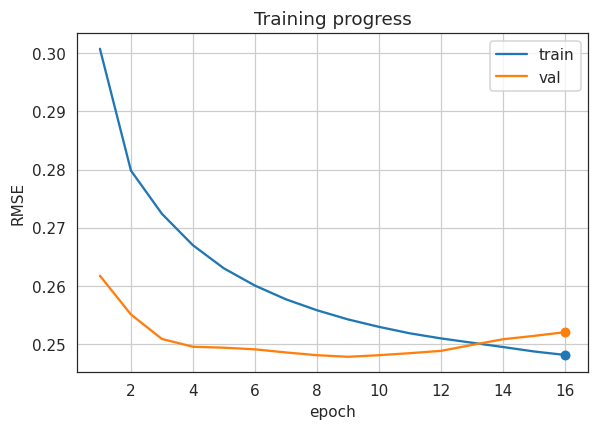

Epoch 1:   0%|          | 0/60 [00:03<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.3008 MAE=0.2294 R2=-0.0758 | Acc=0.6850 Prec=0.3470 Rec=0.1972 F1=0.2515 AUROC=0.5802
VALID→ RMSE=0.2617 MAE=0.1802 R2=0.1457 | Acc=0.7265 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.7112


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2798 MAE=0.2126 R2=0.0687 | Acc=0.7270 Prec=0.4651 Rec=0.1148 F1=0.1842 AUROC=0.6029
VALID→ RMSE=0.2551 MAE=0.1779 R2=0.1887 | Acc=0.7402 Prec=0.8214 Rec=0.0637 F1=0.1182 AUROC=0.7412


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2724 MAE=0.2075 R2=0.1175 | Acc=0.7378 Prec=0.5314 Rec=0.1951 F1=0.2854 AUROC=0.6514
VALID→ RMSE=0.2509 MAE=0.1780 R2=0.2152 | Acc=0.7548 Prec=0.7465 Rec=0.1566 F1=0.2589 AUROC=0.7479


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2670 MAE=0.2039 R2=0.1522 | Acc=0.7470 Prec=0.5697 Rec=0.2349 F1=0.3326 AUROC=0.6806
VALID→ RMSE=0.2495 MAE=0.1779 R2=0.2236 | Acc=0.7604 Prec=0.7188 Rec=0.2031 F1=0.3167 AUROC=0.7514


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2630 MAE=0.2012 R2=0.1773 | Acc=0.7524 Prec=0.5869 Rec=0.2612 F1=0.3615 AUROC=0.7004
VALID→ RMSE=0.2494 MAE=0.1778 R2=0.2246 | Acc=0.7630 Prec=0.7045 Rec=0.2298 F1=0.3466 AUROC=0.7535


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2601 MAE=0.1985 R2=0.1956 | Acc=0.7566 Prec=0.6011 Rec=0.2765 F1=0.3787 AUROC=0.7146
VALID→ RMSE=0.2491 MAE=0.1781 R2=0.2263 | Acc=0.7640 Prec=0.6950 Rec=0.2442 F1=0.3614 AUROC=0.7547


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2577 MAE=0.1966 R2=0.2102 | Acc=0.7596 Prec=0.6096 Rec=0.2902 F1=0.3932 AUROC=0.7251
VALID→ RMSE=0.2486 MAE=0.1787 R2=0.2297 | Acc=0.7648 Prec=0.6872 Rec=0.2567 F1=0.3737 AUROC=0.7555


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2558 MAE=0.1949 R2=0.2217 | Acc=0.7614 Prec=0.6137 Rec=0.2994 F1=0.4025 AUROC=0.7333
VALID→ RMSE=0.2481 MAE=0.1795 R2=0.2326 | Acc=0.7648 Prec=0.6801 Rec=0.2644 F1=0.3808 AUROC=0.7562


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2542 MAE=0.1935 R2=0.2312 | Acc=0.7631 Prec=0.6178 Rec=0.3074 F1=0.4106 AUROC=0.7393
VALID→ RMSE=0.2478 MAE=0.1804 R2=0.2343 | Acc=0.7647 Prec=0.6729 Rec=0.2712 F1=0.3866 AUROC=0.7561


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2530 MAE=0.1923 R2=0.2389 | Acc=0.7645 Prec=0.6215 Rec=0.3136 F1=0.4169 AUROC=0.7447
VALID→ RMSE=0.2481 MAE=0.1810 R2=0.2326 | Acc=0.7644 Prec=0.6699 Rec=0.2728 F1=0.3877 AUROC=0.7554


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2518 MAE=0.1912 R2=0.2456 | Acc=0.7658 Prec=0.6248 Rec=0.3192 F1=0.4225 AUROC=0.7489
VALID→ RMSE=0.2484 MAE=0.1817 R2=0.2304 | Acc=0.7641 Prec=0.6681 Rec=0.2731 F1=0.3877 AUROC=0.7541


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.2510 MAE=0.1905 R2=0.2508 | Acc=0.7664 Prec=0.6253 Rec=0.3230 F1=0.4260 AUROC=0.7521
VALID→ RMSE=0.2488 MAE=0.1820 R2=0.2280 | Acc=0.7639 Prec=0.6657 Rec=0.2741 F1=0.3883 AUROC=0.7529


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.2502 MAE=0.1898 R2=0.2553 | Acc=0.7677 Prec=0.6286 Rec=0.3284 F1=0.4314 AUROC=0.7554
VALID→ RMSE=0.2498 MAE=0.1821 R2=0.2217 | Acc=0.7629 Prec=0.6664 Rec=0.2662 F1=0.3805 AUROC=0.7509


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ RMSE=0.2495 MAE=0.1891 R2=0.2596 | Acc=0.7684 Prec=0.6295 Rec=0.3332 F1=0.4358 AUROC=0.7580
VALID→ RMSE=0.2508 MAE=0.1817 R2=0.2155 | Acc=0.7621 Prec=0.6677 Rec=0.2589 F1=0.3732 AUROC=0.7497


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ RMSE=0.2487 MAE=0.1885 R2=0.2642 | Acc=0.7691 Prec=0.6304 Rec=0.3375 F1=0.4396 AUROC=0.7605
VALID→ RMSE=0.2514 MAE=0.1819 R2=0.2119 | Acc=0.7614 Prec=0.6624 Rec=0.2600 F1=0.3734 AUROC=0.7484


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ RMSE=0.2481 MAE=0.1880 R2=0.2677 | Acc=0.7699 Prec=0.6320 Rec=0.3412 F1=0.4431 AUROC=0.7626
VALID→ RMSE=0.2520 MAE=0.1820 R2=0.2079 | Acc=0.7610 Prec=0.6637 Rec=0.2553 F1=0.3687 AUROC=0.7465
Early stopping at epoch 16
✅ Final best model (_fin) saved: AAPL_0.24781_fin.pth
Delete variables to free memory...


[I 2025-09-23 00:31:51,710] Trial 23 finished with value: 0.24781112372875214 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.3164421808826725, 'DROPOUT_LONG': 0.343037179610923, 'ATT_DROPOUT': 0.3288454257124759, 'INITIAL_LR': 0.00015753283549194805, 'ETA_MIN': 2.718695285261868e-06, 'WEIGHT_DECAY': 0.007933158997712405, 'CLIPNORM': 2.3954291200605082}. Best is trial 21 with value: 0.24631395936012268.



▶ Trial 24 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.2706509088316741, 'DROPOUT_LONG': 0.3147179652093827, 'ATT_DROPOUT': 0.09792737771590083, 'INITIAL_LR': 0.00033634070565476544, 'ETA_MIN': 2.2369419162662175e-06, 'WEIGHT_DECAY': 0.0004595618850234283, 'CLIPNORM': 0.959367432027501}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


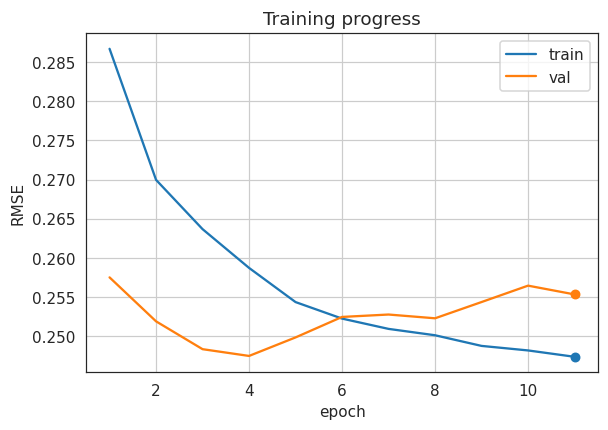

Epoch 1:   0%|          | 0/60 [00:05<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2867 MAE=0.2219 R2=0.0223 | Acc=0.6829 Prec=0.3046 Rec=0.1416 F1=0.1933 AUROC=0.5588
VALID→ RMSE=0.2575 MAE=0.1791 R2=0.1733 | Acc=0.7437 Prec=0.7717 Rec=0.0889 F1=0.1595 AUROC=0.7355


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2700 MAE=0.2051 R2=0.1332 | Acc=0.7438 Prec=0.5630 Rec=0.2030 F1=0.2985 AUROC=0.6653
VALID→ RMSE=0.2519 MAE=0.1811 R2=0.2090 | Acc=0.7597 Prec=0.6903 Rec=0.2200 F1=0.3337 AUROC=0.7432


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2637 MAE=0.2032 R2=0.1732 | Acc=0.7528 Prec=0.5839 Rec=0.2744 F1=0.3734 AUROC=0.6984
VALID→ RMSE=0.2483 MAE=0.1841 R2=0.2312 | Acc=0.7625 Prec=0.6691 Rec=0.2598 F1=0.3743 AUROC=0.7439


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2587 MAE=0.1992 R2=0.2040 | Acc=0.7589 Prec=0.6026 Rec=0.2987 F1=0.3994 AUROC=0.7218
VALID→ RMSE=0.2474 MAE=0.1833 R2=0.2365 | Acc=0.7633 Prec=0.6729 Rec=0.2615 F1=0.3767 AUROC=0.7468


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2543 MAE=0.1938 R2=0.2306 | Acc=0.7638 Prec=0.6245 Rec=0.3003 F1=0.4056 AUROC=0.7395
VALID→ RMSE=0.2498 MAE=0.1810 R2=0.2218 | Acc=0.7620 Prec=0.6848 Rec=0.2403 F1=0.3557 AUROC=0.7470


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2522 MAE=0.1915 R2=0.2434 | Acc=0.7661 Prec=0.6289 Rec=0.3134 F1=0.4183 AUROC=0.7479
VALID→ RMSE=0.2524 MAE=0.1809 R2=0.2054 | Acc=0.7609 Prec=0.6907 Rec=0.2273 F1=0.3421 AUROC=0.7457


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2509 MAE=0.1894 R2=0.2512 | Acc=0.7676 Prec=0.6331 Rec=0.3186 F1=0.4239 AUROC=0.7539
VALID→ RMSE=0.2527 MAE=0.1829 R2=0.2035 | Acc=0.7595 Prec=0.6744 Rec=0.2331 F1=0.3464 AUROC=0.7417


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2501 MAE=0.1900 R2=0.2561 | Acc=0.7687 Prec=0.6310 Rec=0.3328 F1=0.4358 AUROC=0.7565
VALID→ RMSE=0.2523 MAE=0.1851 R2=0.2065 | Acc=0.7588 Prec=0.6767 Rec=0.2261 F1=0.3390 AUROC=0.7378


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2487 MAE=0.1881 R2=0.2642 | Acc=0.7705 Prec=0.6389 Rec=0.3329 F1=0.4377 AUROC=0.7606
VALID→ RMSE=0.2543 MAE=0.1859 R2=0.1934 | Acc=0.7558 Prec=0.6350 Rec=0.2520 F1=0.3608 AUROC=0.7326


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2482 MAE=0.1880 R2=0.2676 | Acc=0.7711 Prec=0.6364 Rec=0.3433 F1=0.4460 AUROC=0.7629
VALID→ RMSE=0.2564 MAE=0.1869 R2=0.1801 | Acc=0.7535 Prec=0.6367 Rec=0.2298 F1=0.3377 AUROC=0.7264


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2473 MAE=0.1872 R2=0.2724 | Acc=0.7721 Prec=0.6380 Rec=0.3483 F1=0.4506 AUROC=0.7652
VALID→ RMSE=0.2553 MAE=0.1897 R2=0.1872 | Acc=0.7513 Prec=0.6017 Rec=0.2684 F1=0.3712 AUROC=0.7254
Early stopping at epoch 11
✅ Final best model (_fin) saved: AAPL_0.24745_fin.pth
Delete variables to free memory...


[I 2025-09-23 00:45:24,733] Trial 24 finished with value: 0.2474489063024521 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.2706509088316741, 'DROPOUT_LONG': 0.3147179652093827, 'ATT_DROPOUT': 0.09792737771590083, 'INITIAL_LR': 0.00033634070565476544, 'ETA_MIN': 2.2369419162662175e-06, 'WEIGHT_DECAY': 0.0004595618850234283, 'CLIPNORM': 0.959367432027501}. Best is trial 21 with value: 0.24631395936012268.



▶ Trial 25 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.23801741780636174, 'DROPOUT_LONG': 0.24037694228500295, 'ATT_DROPOUT': 0.2799558466307243, 'INITIAL_LR': 0.0007351608318836929, 'ETA_MIN': 1.5844531853078992e-06, 'WEIGHT_DECAY': 0.0010572428101008153, 'CLIPNORM': 3.509606369060463}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


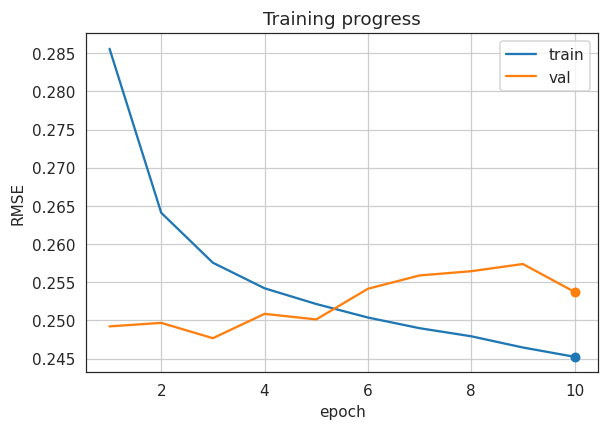

Epoch 1:   0%|          | 0/60 [00:04<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2856 MAE=0.2168 R2=0.0300 | Acc=0.7178 Prec=0.4438 Rec=0.2035 F1=0.2791 AUROC=0.6454
VALID→ RMSE=0.2492 MAE=0.1877 R2=0.2256 | Acc=0.7636 Prec=0.6514 Rec=0.2917 F1=0.4029 AUROC=0.7522


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2641 MAE=0.2006 R2=0.1705 | Acc=0.7563 Prec=0.5970 Rec=0.2830 F1=0.3840 AUROC=0.7151
VALID→ RMSE=0.2497 MAE=0.1795 R2=0.2227 | Acc=0.7646 Prec=0.6794 Rec=0.2637 F1=0.3799 AUROC=0.7522


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2576 MAE=0.1947 R2=0.2111 | Acc=0.7618 Prec=0.6140 Rec=0.3027 F1=0.4055 AUROC=0.7359
VALID→ RMSE=0.2477 MAE=0.1800 R2=0.2352 | Acc=0.7652 Prec=0.6718 Rec=0.2760 F1=0.3913 AUROC=0.7544


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2542 MAE=0.1926 R2=0.2314 | Acc=0.7643 Prec=0.6202 Rec=0.3138 F1=0.4167 AUROC=0.7458
VALID→ RMSE=0.2509 MAE=0.1800 R2=0.2154 | Acc=0.7611 Prec=0.6900 Rec=0.2295 F1=0.3444 AUROC=0.7513


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2521 MAE=0.1915 R2=0.2438 | Acc=0.7660 Prec=0.6195 Rec=0.3319 F1=0.4322 AUROC=0.7533
VALID→ RMSE=0.2501 MAE=0.1811 R2=0.2199 | Acc=0.7607 Prec=0.6754 Rec=0.2406 F1=0.3548 AUROC=0.7499


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2504 MAE=0.1895 R2=0.2544 | Acc=0.7675 Prec=0.6257 Rec=0.3332 F1=0.4348 AUROC=0.7592
VALID→ RMSE=0.2541 MAE=0.1808 R2=0.1947 | Acc=0.7567 Prec=0.6797 Rec=0.2087 F1=0.3193 AUROC=0.7437


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2490 MAE=0.1876 R2=0.2627 | Acc=0.7686 Prec=0.6302 Rec=0.3334 F1=0.4361 AUROC=0.7636
VALID→ RMSE=0.2559 MAE=0.1826 R2=0.1836 | Acc=0.7526 Prec=0.6510 Rec=0.2054 F1=0.3123 AUROC=0.7384


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2479 MAE=0.1867 R2=0.2690 | Acc=0.7703 Prec=0.6352 Rec=0.3383 F1=0.4415 AUROC=0.7663
VALID→ RMSE=0.2564 MAE=0.1835 R2=0.1800 | Acc=0.7498 Prec=0.6277 Rec=0.2092 F1=0.3138 AUROC=0.7350


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2464 MAE=0.1858 R2=0.2776 | Acc=0.7718 Prec=0.6371 Rec=0.3482 F1=0.4503 AUROC=0.7707
VALID→ RMSE=0.2574 MAE=0.1843 R2=0.1740 | Acc=0.7485 Prec=0.6217 Rec=0.2046 F1=0.3079 AUROC=0.7313


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2452 MAE=0.1846 R2=0.2847 | Acc=0.7736 Prec=0.6436 Rec=0.3505 F1=0.4538 AUROC=0.7740
VALID→ RMSE=0.2537 MAE=0.1878 R2=0.1973 | Acc=0.7507 Prec=0.5986 Rec=0.2682 F1=0.3704 AUROC=0.7321
Early stopping at epoch 10
✅ Final best model (_fin) saved: AAPL_0.24767_fin.pth
Delete variables to free memory...


[I 2025-09-23 00:57:27,595] Trial 25 finished with value: 0.24766719341278076 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.23801741780636174, 'DROPOUT_LONG': 0.24037694228500295, 'ATT_DROPOUT': 0.2799558466307243, 'INITIAL_LR': 0.0007351608318836929, 'ETA_MIN': 1.5844531853078992e-06, 'WEIGHT_DECAY': 0.0010572428101008153, 'CLIPNORM': 3.509606369060463}. Best is trial 21 with value: 0.24631395936012268.



▶ Trial 26 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.18616462098729453, 'DROPOUT_LONG': 0.26672774398013366, 'ATT_DROPOUT': 0.223072427621133, 'INITIAL_LR': 0.0009665148032615947, 'ETA_MIN': 9.822477520552412e-06, 'WEIGHT_DECAY': 0.003967450030785253, 'CLIPNORM': 4.7015699093429575}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


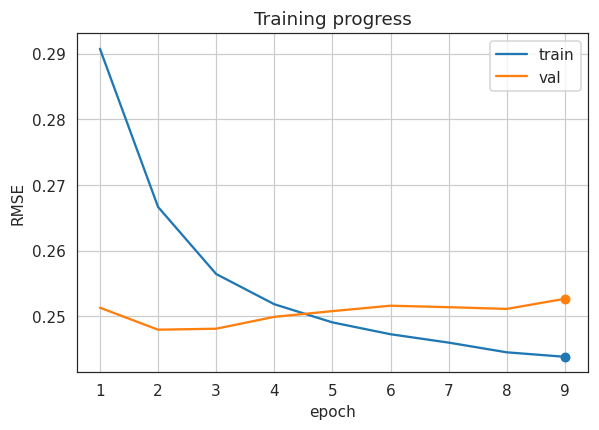

Epoch 1:   0%|          | 0/60 [00:04<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2907 MAE=0.2201 R2=-0.0053 | Acc=0.7070 Prec=0.4015 Rec=0.1870 F1=0.2552 AUROC=0.6251
VALID→ RMSE=0.2513 MAE=0.1857 R2=0.2125 | Acc=0.7619 Prec=0.6585 Rec=0.2685 F1=0.3815 AUROC=0.7331


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2666 MAE=0.2054 R2=0.1543 | Acc=0.7541 Prec=0.5883 Rec=0.2791 F1=0.3786 AUROC=0.7068
VALID→ RMSE=0.2480 MAE=0.1886 R2=0.2334 | Acc=0.7626 Prec=0.6161 Rec=0.3502 F1=0.4466 AUROC=0.7431


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2564 MAE=0.1964 R2=0.2179 | Acc=0.7632 Prec=0.6169 Rec=0.3103 F1=0.4129 AUROC=0.7375
VALID→ RMSE=0.2481 MAE=0.1884 R2=0.2325 | Acc=0.7612 Prec=0.6108 Rec=0.3489 F1=0.4441 AUROC=0.7419


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2518 MAE=0.1912 R2=0.2457 | Acc=0.7667 Prec=0.6269 Rec=0.3225 F1=0.4259 AUROC=0.7514
VALID→ RMSE=0.2499 MAE=0.1837 R2=0.2212 | Acc=0.7624 Prec=0.6680 Rec=0.2606 F1=0.3750 AUROC=0.7425


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2491 MAE=0.1883 R2=0.2622 | Acc=0.7696 Prec=0.6378 Rec=0.3274 F1=0.4327 AUROC=0.7608
VALID→ RMSE=0.2508 MAE=0.1857 R2=0.2158 | Acc=0.7589 Prec=0.6552 Rec=0.2494 F1=0.3613 AUROC=0.7407


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2473 MAE=0.1869 R2=0.2728 | Acc=0.7714 Prec=0.6403 Rec=0.3384 F1=0.4428 AUROC=0.7664
VALID→ RMSE=0.2516 MAE=0.1845 R2=0.2106 | Acc=0.7580 Prec=0.6693 Rec=0.2274 F1=0.3395 AUROC=0.7412


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2460 MAE=0.1857 R2=0.2803 | Acc=0.7726 Prec=0.6425 Rec=0.3440 F1=0.4481 AUROC=0.7709
VALID→ RMSE=0.2514 MAE=0.1846 R2=0.2120 | Acc=0.7576 Prec=0.6540 Rec=0.2409 F1=0.3521 AUROC=0.7405


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2445 MAE=0.1843 R2=0.2889 | Acc=0.7745 Prec=0.6481 Rec=0.3493 F1=0.4539 AUROC=0.7752
VALID→ RMSE=0.2511 MAE=0.1839 R2=0.2137 | Acc=0.7586 Prec=0.6582 Rec=0.2439 F1=0.3559 AUROC=0.7404


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2438 MAE=0.1837 R2=0.2929 | Acc=0.7752 Prec=0.6472 Rec=0.3569 F1=0.4601 AUROC=0.7772
VALID→ RMSE=0.2527 MAE=0.1829 R2=0.2040 | Acc=0.7568 Prec=0.6539 Rec=0.2348 F1=0.3455 AUROC=0.7378
Early stopping at epoch 9
✅ Final best model (_fin) saved: AAPL_0.24796_fin.pth
Delete variables to free memory...


[I 2025-09-23 01:09:35,092] Trial 26 finished with value: 0.24795547127723694 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.18616462098729453, 'DROPOUT_LONG': 0.26672774398013366, 'ATT_DROPOUT': 0.223072427621133, 'INITIAL_LR': 0.0009665148032615947, 'ETA_MIN': 9.822477520552412e-06, 'WEIGHT_DECAY': 0.003967450030785253, 'CLIPNORM': 4.7015699093429575}. Best is trial 21 with value: 0.24631395936012268.



▶ Trial 27 starting with:
{'look_back': 30, 'DROPOUT_SHORT': 0.32012677523519545, 'DROPOUT_LONG': 0.3162129169934207, 'ATT_DROPOUT': 0.3481947343732073, 'INITIAL_LR': 0.0001822645194926698, 'ETA_MIN': 3.2946210570914603e-06, 'WEIGHT_DECAY': 0.0012732273807687276, 'CLIPNORM': 2.3257295382536958}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


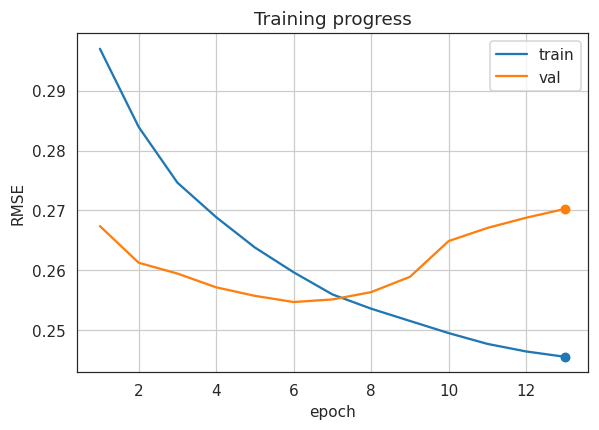

Epoch 1:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2970 MAE=0.2283 R2=-0.0338 | Acc=0.6817 Prec=0.3719 Rec=0.1862 F1=0.2481 AUROC=0.5926
VALID→ RMSE=0.2674 MAE=0.1875 R2=0.1442 | Acc=0.7222 Prec=0.7274 Rec=0.0937 F1=0.1660 AUROC=0.7283


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2839 MAE=0.2186 R2=0.0551 | Acc=0.6992 Prec=0.4264 Rec=0.1918 F1=0.2646 AUROC=0.5979
VALID→ RMSE=0.2612 MAE=0.1865 R2=0.1830 | Acc=0.7332 Prec=0.7262 Rec=0.1540 F1=0.2541 AUROC=0.7410


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2746 MAE=0.2114 R2=0.1160 | Acc=0.7217 Prec=0.5186 Rec=0.1905 F1=0.2786 AUROC=0.6373
VALID→ RMSE=0.2594 MAE=0.1863 R2=0.1942 | Acc=0.7419 Prec=0.6885 Rec=0.2288 F1=0.3434 AUROC=0.7439


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2689 MAE=0.2073 R2=0.1527 | Acc=0.7332 Prec=0.5641 Rec=0.2383 F1=0.3351 AUROC=0.6724
VALID→ RMSE=0.2571 MAE=0.1866 R2=0.2085 | Acc=0.7448 Prec=0.6747 Rec=0.2613 F1=0.3767 AUROC=0.7455


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2638 MAE=0.2035 R2=0.1844 | Acc=0.7420 Prec=0.5976 Rec=0.2617 F1=0.3640 AUROC=0.6986
VALID→ RMSE=0.2557 MAE=0.1862 R2=0.2172 | Acc=0.7459 Prec=0.6798 Rec=0.2626 F1=0.3789 AUROC=0.7474


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2597 MAE=0.1998 R2=0.2098 | Acc=0.7476 Prec=0.6107 Rec=0.2911 F1=0.3942 AUROC=0.7172
VALID→ RMSE=0.2547 MAE=0.1866 R2=0.2235 | Acc=0.7473 Prec=0.6747 Rec=0.2773 F1=0.3931 AUROC=0.7496


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2560 MAE=0.1960 R2=0.2321 | Acc=0.7524 Prec=0.6231 Rec=0.3100 F1=0.4140 AUROC=0.7340
VALID→ RMSE=0.2551 MAE=0.1882 R2=0.2209 | Acc=0.7461 Prec=0.6626 Rec=0.2847 F1=0.3983 AUROC=0.7492


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2536 MAE=0.1942 R2=0.2464 | Acc=0.7560 Prec=0.6280 Rec=0.3320 F1=0.4344 AUROC=0.7438
VALID→ RMSE=0.2563 MAE=0.1905 R2=0.2134 | Acc=0.7433 Prec=0.6386 Rec=0.2998 F1=0.4080 AUROC=0.7459


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2515 MAE=0.1925 R2=0.2585 | Acc=0.7587 Prec=0.6309 Rec=0.3488 F1=0.4492 AUROC=0.7515
VALID→ RMSE=0.2589 MAE=0.1932 R2=0.1976 | Acc=0.7374 Prec=0.6038 Rec=0.3203 F1=0.4186 AUROC=0.7405


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2495 MAE=0.1905 R2=0.2704 | Acc=0.7617 Prec=0.6371 Rec=0.3606 F1=0.4605 AUROC=0.7585
VALID→ RMSE=0.2649 MAE=0.1981 R2=0.1601 | Acc=0.7238 Prec=0.5516 Rec=0.3425 F1=0.4226 AUROC=0.7295


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2477 MAE=0.1884 R2=0.2809 | Acc=0.7644 Prec=0.6434 Rec=0.3698 F1=0.4697 AUROC=0.7648
VALID→ RMSE=0.2671 MAE=0.1987 R2=0.1462 | Acc=0.7205 Prec=0.5426 Rec=0.3367 F1=0.4155 AUROC=0.7249


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.2464 MAE=0.1876 R2=0.2883 | Acc=0.7661 Prec=0.6460 Rec=0.3784 F1=0.4772 AUROC=0.7685
VALID→ RMSE=0.2688 MAE=0.1989 R2=0.1352 | Acc=0.7177 Prec=0.5369 Rec=0.3151 F1=0.3971 AUROC=0.7195


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.2455 MAE=0.1869 R2=0.2934 | Acc=0.7671 Prec=0.6462 Rec=0.3854 F1=0.4829 AUROC=0.7713
VALID→ RMSE=0.2702 MAE=0.1986 R2=0.1258 | Acc=0.7163 Prec=0.5355 Rec=0.2928 F1=0.3786 AUROC=0.7159
Early stopping at epoch 13
✅ Final best model (_fin) saved: AAPL_0.25469_fin.pth
Delete variables to free memory...


[I 2025-09-23 01:20:49,854] Trial 27 finished with value: 0.2546873986721039 and parameters: {'look_back': 30, 'DROPOUT_SHORT': 0.32012677523519545, 'DROPOUT_LONG': 0.3162129169934207, 'ATT_DROPOUT': 0.3481947343732073, 'INITIAL_LR': 0.0001822645194926698, 'ETA_MIN': 3.2946210570914603e-06, 'WEIGHT_DECAY': 0.0012732273807687276, 'CLIPNORM': 2.3257295382536958}. Best is trial 21 with value: 0.24631395936012268.



▶ Trial 28 starting with:
{'look_back': 60, 'DROPOUT_SHORT': 0.22946434060734877, 'DROPOUT_LONG': 0.2737971168016115, 'ATT_DROPOUT': 0.31649047589739787, 'INITIAL_LR': 0.0003601467558710691, 'ETA_MIN': 3.955924545777431e-06, 'WEIGHT_DECAY': 0.003425586172368018, 'CLIPNORM': 1.330292860156674}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


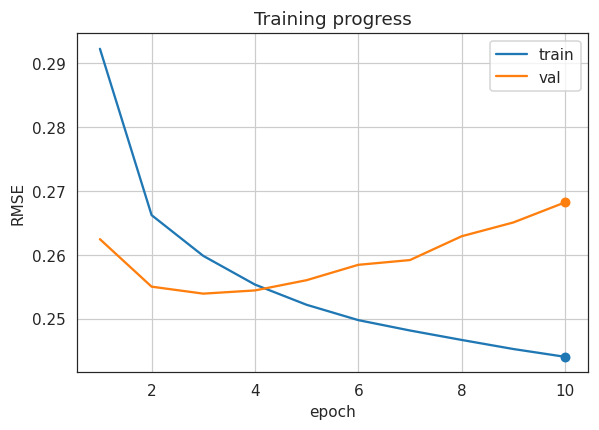

Epoch 1:   0%|          | 0/60 [00:03<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2923 MAE=0.2255 R2=-0.0125 | Acc=0.6904 Prec=0.3472 Rec=0.1355 F1=0.1950 AUROC=0.5810
VALID→ RMSE=0.2625 MAE=0.1832 R2=0.1638 | Acc=0.7419 Prec=0.7225 Rec=0.1652 F1=0.2689 AUROC=0.7342


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2662 MAE=0.2018 R2=0.1600 | Acc=0.7455 Prec=0.5935 Rec=0.2545 F1=0.3562 AUROC=0.6915
VALID→ RMSE=0.2550 MAE=0.1857 R2=0.2105 | Acc=0.7514 Prec=0.6730 Rec=0.2622 F1=0.3773 AUROC=0.7420


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2598 MAE=0.1993 R2=0.1998 | Acc=0.7530 Prec=0.6083 Rec=0.3005 F1=0.4023 AUROC=0.7176
VALID→ RMSE=0.2539 MAE=0.1900 R2=0.2173 | Acc=0.7514 Prec=0.6591 Rec=0.2789 F1=0.3919 AUROC=0.7433


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2553 MAE=0.1957 R2=0.2272 | Acc=0.7570 Prec=0.6172 Rec=0.3202 F1=0.4217 AUROC=0.7374
VALID→ RMSE=0.2544 MAE=0.1891 R2=0.2142 | Acc=0.7500 Prec=0.6533 Rec=0.2764 F1=0.3884 AUROC=0.7458


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2522 MAE=0.1922 R2=0.2463 | Acc=0.7601 Prec=0.6229 Rec=0.3364 F1=0.4368 AUROC=0.7498
VALID→ RMSE=0.2560 MAE=0.1903 R2=0.2042 | Acc=0.7464 Prec=0.6382 Rec=0.2706 F1=0.3801 AUROC=0.7410


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2498 MAE=0.1897 R2=0.2606 | Acc=0.7630 Prec=0.6320 Rec=0.3429 F1=0.4446 AUROC=0.7583
VALID→ RMSE=0.2584 MAE=0.1946 R2=0.1892 | Acc=0.7400 Prec=0.5969 Rec=0.2929 F1=0.3930 AUROC=0.7335


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2482 MAE=0.1892 R2=0.2702 | Acc=0.7650 Prec=0.6326 Rec=0.3591 F1=0.4581 AUROC=0.7631
VALID→ RMSE=0.2592 MAE=0.1945 R2=0.1845 | Acc=0.7370 Prec=0.5787 Rec=0.3108 F1=0.4044 AUROC=0.7312


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2467 MAE=0.1881 R2=0.2788 | Acc=0.7670 Prec=0.6346 Rec=0.3718 F1=0.4689 AUROC=0.7674
VALID→ RMSE=0.2629 MAE=0.1977 R2=0.1609 | Acc=0.7302 Prec=0.5536 Rec=0.3146 F1=0.4012 AUROC=0.7233


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2453 MAE=0.1866 R2=0.2871 | Acc=0.7692 Prec=0.6416 Rec=0.3756 F1=0.4738 AUROC=0.7712
VALID→ RMSE=0.2651 MAE=0.2003 R2=0.1471 | Acc=0.7255 Prec=0.5380 Rec=0.3143 F1=0.3968 AUROC=0.7174


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2440 MAE=0.1852 R2=0.2942 | Acc=0.7709 Prec=0.6474 Rec=0.3770 F1=0.4765 AUROC=0.7745
VALID→ RMSE=0.2682 MAE=0.1991 R2=0.1267 | Acc=0.7240 Prec=0.5369 Rec=0.2872 F1=0.3742 AUROC=0.7118
Early stopping at epoch 10
✅ Final best model (_fin) saved: AAPL_0.25392_fin.pth
Delete variables to free memory...


[I 2025-09-23 01:31:51,455] Trial 28 finished with value: 0.2539229691028595 and parameters: {'look_back': 60, 'DROPOUT_SHORT': 0.22946434060734877, 'DROPOUT_LONG': 0.2737971168016115, 'ATT_DROPOUT': 0.31649047589739787, 'INITIAL_LR': 0.0003601467558710691, 'ETA_MIN': 3.955924545777431e-06, 'WEIGHT_DECAY': 0.003425586172368018, 'CLIPNORM': 1.330292860156674}. Best is trial 21 with value: 0.24631395936012268.



▶ Trial 29 starting with:
{'look_back': 90, 'DROPOUT_SHORT': 0.28532500502533437, 'DROPOUT_LONG': 0.15922279554134405, 'ATT_DROPOUT': 0.28217487612352093, 'INITIAL_LR': 6.301782919497151e-05, 'ETA_MIN': 1.0301313210040519e-06, 'WEIGHT_DECAY': 0.0002557657962286835, 'CLIPNORM': 9.27163778199057}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


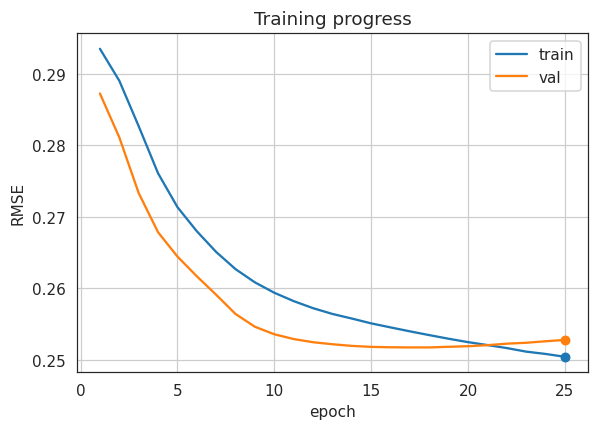

Epoch 1:   0%|          | 0/60 [00:01<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2935 MAE=0.2321 R2=-0.0255 | Acc=0.6221 Prec=0.3234 Rec=0.3537 F1=0.3379 AUROC=0.5616
VALID→ RMSE=0.2873 MAE=0.1982 R2=-0.0156 | Acc=0.7197 Prec=0.5239 Rec=0.0055 F1=0.0109 AUROC=0.5900


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2890 MAE=0.2196 R2=0.0055 | Acc=0.7259 Prec=0.3632 Rec=0.0073 F1=0.0142 AUROC=0.5228
VALID→ RMSE=0.2811 MAE=0.1947 R2=0.0272 | Acc=0.7210 Prec=0.6246 Rec=0.0126 F1=0.0246 AUROC=0.6383


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2827 MAE=0.2151 R2=0.0487 | Acc=0.7269 Prec=0.4752 Rec=0.0163 F1=0.0316 AUROC=0.5657
VALID→ RMSE=0.2733 MAE=0.1904 R2=0.0804 | Acc=0.7245 Prec=0.6704 Rec=0.0342 F1=0.0650 AUROC=0.6795


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2761 MAE=0.2113 R2=0.0925 | Acc=0.7301 Prec=0.5696 Rec=0.0411 F1=0.0766 AUROC=0.6085
VALID→ RMSE=0.2679 MAE=0.1865 R2=0.1169 | Acc=0.7297 Prec=0.6871 Rec=0.0663 F1=0.1209 AUROC=0.7103


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2714 MAE=0.2077 R2=0.1234 | Acc=0.7367 Prec=0.6154 Rec=0.0916 F1=0.1595 AUROC=0.6443
VALID→ RMSE=0.2645 MAE=0.1843 R2=0.1392 | Acc=0.7362 Prec=0.7076 Rec=0.1013 F1=0.1772 AUROC=0.7283


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2680 MAE=0.2052 R2=0.1450 | Acc=0.7433 Prec=0.6219 Rec=0.1493 F1=0.2408 AUROC=0.6694
VALID→ RMSE=0.2617 MAE=0.1832 R2=0.1571 | Acc=0.7416 Prec=0.7128 Rec=0.1316 F1=0.2221 AUROC=0.7376


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2651 MAE=0.2031 R2=0.1635 | Acc=0.7478 Prec=0.6185 Rec=0.1955 F1=0.2970 AUROC=0.6878
VALID→ RMSE=0.2591 MAE=0.1826 R2=0.1737 | Acc=0.7457 Prec=0.7122 Rec=0.1564 F1=0.2564 AUROC=0.7421


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2627 MAE=0.2009 R2=0.1786 | Acc=0.7507 Prec=0.6169 Rec=0.2255 F1=0.3303 AUROC=0.7011
VALID→ RMSE=0.2564 MAE=0.1824 R2=0.1907 | Acc=0.7486 Prec=0.7077 Rec=0.1765 F1=0.2825 AUROC=0.7441


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2608 MAE=0.1993 R2=0.1901 | Acc=0.7528 Prec=0.6169 Rec=0.2459 F1=0.3517 AUROC=0.7112
VALID→ RMSE=0.2546 MAE=0.1824 R2=0.2019 | Acc=0.7512 Prec=0.7018 Rec=0.1960 F1=0.3064 AUROC=0.7447


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2594 MAE=0.1978 R2=0.1991 | Acc=0.7548 Prec=0.6202 Rec=0.2593 F1=0.3657 AUROC=0.7182
VALID→ RMSE=0.2536 MAE=0.1826 R2=0.2085 | Acc=0.7526 Prec=0.6960 Rec=0.2092 F1=0.3217 AUROC=0.7445


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2582 MAE=0.1967 R2=0.2063 | Acc=0.7555 Prec=0.6194 Rec=0.2682 F1=0.3743 AUROC=0.7232
VALID→ RMSE=0.2529 MAE=0.1829 R2=0.2127 | Acc=0.7537 Prec=0.6913 Rec=0.2198 F1=0.3336 AUROC=0.7441


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.2572 MAE=0.1957 R2=0.2123 | Acc=0.7564 Prec=0.6201 Rec=0.2755 F1=0.3815 AUROC=0.7277
VALID→ RMSE=0.2525 MAE=0.1831 R2=0.2155 | Acc=0.7542 Prec=0.6864 Rec=0.2273 F1=0.3415 AUROC=0.7437


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.2564 MAE=0.1950 R2=0.2173 | Acc=0.7573 Prec=0.6211 Rec=0.2813 F1=0.3872 AUROC=0.7311
VALID→ RMSE=0.2522 MAE=0.1833 R2=0.2172 | Acc=0.7545 Prec=0.6820 Rec=0.2336 F1=0.3479 AUROC=0.7435


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ RMSE=0.2558 MAE=0.1944 R2=0.2212 | Acc=0.7581 Prec=0.6222 Rec=0.2871 F1=0.3929 AUROC=0.7341
VALID→ RMSE=0.2520 MAE=0.1837 R2=0.2186 | Acc=0.7546 Prec=0.6772 Rec=0.2386 F1=0.3528 AUROC=0.7431


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ RMSE=0.2551 MAE=0.1939 R2=0.2253 | Acc=0.7585 Prec=0.6222 Rec=0.2910 F1=0.3965 AUROC=0.7367
VALID→ RMSE=0.2518 MAE=0.1840 R2=0.2195 | Acc=0.7547 Prec=0.6721 Rec=0.2444 F1=0.3585 AUROC=0.7428


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ RMSE=0.2545 MAE=0.1934 R2=0.2287 | Acc=0.7590 Prec=0.6222 Rec=0.2952 F1=0.4004 AUROC=0.7390
VALID→ RMSE=0.2518 MAE=0.1843 R2=0.2198 | Acc=0.7545 Prec=0.6682 Rec=0.2474 F1=0.3611 AUROC=0.7424


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ RMSE=0.2540 MAE=0.1930 R2=0.2321 | Acc=0.7597 Prec=0.6239 Rec=0.2989 F1=0.4042 AUROC=0.7410
VALID→ RMSE=0.2517 MAE=0.1847 R2=0.2200 | Acc=0.7544 Prec=0.6645 Rec=0.2507 F1=0.3641 AUROC=0.7419


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ RMSE=0.2535 MAE=0.1926 R2=0.2352 | Acc=0.7602 Prec=0.6245 Rec=0.3022 F1=0.4073 AUROC=0.7431
VALID→ RMSE=0.2517 MAE=0.1851 R2=0.2200 | Acc=0.7544 Prec=0.6613 Rec=0.2543 F1=0.3673 AUROC=0.7415


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ RMSE=0.2530 MAE=0.1921 R2=0.2383 | Acc=0.7609 Prec=0.6262 Rec=0.3051 F1=0.4103 AUROC=0.7450
VALID→ RMSE=0.2518 MAE=0.1854 R2=0.2194 | Acc=0.7541 Prec=0.6590 Rec=0.2551 F1=0.3678 AUROC=0.7411


Epoch 20:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ RMSE=0.2525 MAE=0.1917 R2=0.2412 | Acc=0.7614 Prec=0.6267 Rec=0.3085 F1=0.4135 AUROC=0.7469
VALID→ RMSE=0.2519 MAE=0.1858 R2=0.2189 | Acc=0.7538 Prec=0.6554 Rec=0.2575 F1=0.3698 AUROC=0.7407


Epoch 21:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ RMSE=0.2521 MAE=0.1914 R2=0.2436 | Acc=0.7617 Prec=0.6274 Rec=0.3103 F1=0.4152 AUROC=0.7480
VALID→ RMSE=0.2521 MAE=0.1861 R2=0.2180 | Acc=0.7536 Prec=0.6533 Rec=0.2585 F1=0.3705 AUROC=0.7402


Epoch 22:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ RMSE=0.2517 MAE=0.1911 R2=0.2461 | Acc=0.7619 Prec=0.6272 Rec=0.3127 F1=0.4173 AUROC=0.7497
VALID→ RMSE=0.2523 MAE=0.1864 R2=0.2167 | Acc=0.7532 Prec=0.6505 Rec=0.2594 F1=0.3709 AUROC=0.7398


Epoch 23:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ RMSE=0.2512 MAE=0.1907 R2=0.2491 | Acc=0.7625 Prec=0.6284 Rec=0.3155 F1=0.4201 AUROC=0.7512
VALID→ RMSE=0.2524 MAE=0.1868 R2=0.2159 | Acc=0.7529 Prec=0.6466 Rec=0.2621 F1=0.3730 AUROC=0.7393


Epoch 24:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ RMSE=0.2508 MAE=0.1904 R2=0.2511 | Acc=0.7628 Prec=0.6288 Rec=0.3169 F1=0.4215 AUROC=0.7526
VALID→ RMSE=0.2526 MAE=0.1871 R2=0.2146 | Acc=0.7526 Prec=0.6439 Rec=0.2632 F1=0.3737 AUROC=0.7388


Epoch 25:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ RMSE=0.2504 MAE=0.1901 R2=0.2534 | Acc=0.7634 Prec=0.6299 Rec=0.3206 F1=0.4249 AUROC=0.7534
VALID→ RMSE=0.2528 MAE=0.1874 R2=0.2134 | Acc=0.7522 Prec=0.6409 Rec=0.2649 F1=0.3748 AUROC=0.7384
Early stopping at epoch 25
✅ Final best model (_fin) saved: AAPL_0.25175_fin.pth
Delete variables to free memory...


[I 2025-09-23 01:54:41,068] Trial 29 finished with value: 0.2517475187778473 and parameters: {'look_back': 90, 'DROPOUT_SHORT': 0.28532500502533437, 'DROPOUT_LONG': 0.15922279554134405, 'ATT_DROPOUT': 0.28217487612352093, 'INITIAL_LR': 6.301782919497151e-05, 'ETA_MIN': 1.0301313210040519e-06, 'WEIGHT_DECAY': 0.0002557657962286835, 'CLIPNORM': 9.27163778199057}. Best is trial 21 with value: 0.24631395936012268.



▶ Trial 30 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.26246050476982774, 'DROPOUT_LONG': 0.2190677599062982, 'ATT_DROPOUT': 0.23227863185545058, 'INITIAL_LR': 0.0005373100100559391, 'ETA_MIN': 2.9867947690129307e-06, 'WEIGHT_DECAY': 0.0019212701964817648, 'CLIPNORM': 0.7297090760230418}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


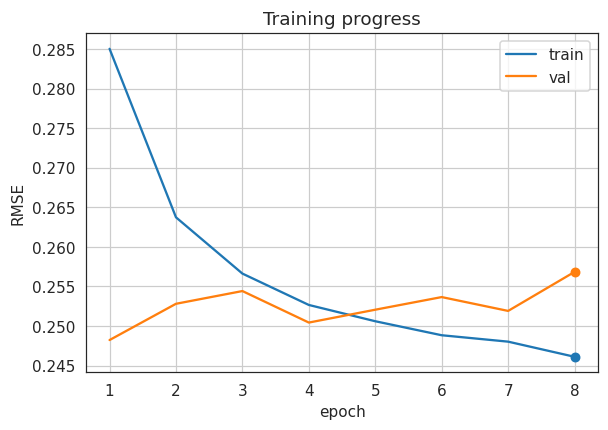

Epoch 1:   0%|          | 0/60 [00:04<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2850 MAE=0.2188 R2=0.0337 | Acc=0.7079 Prec=0.3993 Rec=0.1755 F1=0.2439 AUROC=0.6273
VALID→ RMSE=0.2482 MAE=0.1836 R2=0.2318 | Acc=0.7613 Prec=0.6778 Rec=0.2420 F1=0.3567 AUROC=0.7504


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2637 MAE=0.2024 R2=0.1728 | Acc=0.7569 Prec=0.6052 Rec=0.2704 F1=0.3738 AUROC=0.7116
VALID→ RMSE=0.2528 MAE=0.1857 R2=0.2031 | Acc=0.7577 Prec=0.6925 Rec=0.2050 F1=0.3163 AUROC=0.7389


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2566 MAE=0.1951 R2=0.2168 | Acc=0.7627 Prec=0.6252 Rec=0.2891 F1=0.3954 AUROC=0.7371
VALID→ RMSE=0.2544 MAE=0.1840 R2=0.1930 | Acc=0.7554 Prec=0.7004 Rec=0.1847 F1=0.2923 AUROC=0.7323


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2527 MAE=0.1913 R2=0.2408 | Acc=0.7653 Prec=0.6291 Rec=0.3057 F1=0.4114 AUROC=0.7496
VALID→ RMSE=0.2504 MAE=0.1854 R2=0.2180 | Acc=0.7591 Prec=0.6611 Rec=0.2445 F1=0.3570 AUROC=0.7355


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2506 MAE=0.1902 R2=0.2531 | Acc=0.7673 Prec=0.6303 Rec=0.3213 F1=0.4256 AUROC=0.7565
VALID→ RMSE=0.2521 MAE=0.1820 R2=0.2078 | Acc=0.7588 Prec=0.6685 Rec=0.2341 F1=0.3467 AUROC=0.7408


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2488 MAE=0.1877 R2=0.2636 | Acc=0.7695 Prec=0.6390 Rec=0.3244 F1=0.4304 AUROC=0.7623
VALID→ RMSE=0.2536 MAE=0.1828 R2=0.1978 | Acc=0.7554 Prec=0.6303 Rec=0.2556 F1=0.3637 AUROC=0.7386


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2480 MAE=0.1873 R2=0.2684 | Acc=0.7703 Prec=0.6374 Rec=0.3341 F1=0.4384 AUROC=0.7649
VALID→ RMSE=0.2519 MAE=0.1868 R2=0.2088 | Acc=0.7513 Prec=0.5883 Rec=0.3020 F1=0.3991 AUROC=0.7403


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2461 MAE=0.1858 R2=0.2796 | Acc=0.7729 Prec=0.6459 Rec=0.3400 F1=0.4455 AUROC=0.7706
VALID→ RMSE=0.2568 MAE=0.1847 R2=0.1775 | Acc=0.7482 Prec=0.5853 Rec=0.2716 F1=0.3710 AUROC=0.7388
Early stopping at epoch 8
✅ Final best model (_fin) saved: AAPL_0.24822_fin.pth
Delete variables to free memory...


[I 2025-09-23 02:06:03,825] Trial 30 finished with value: 0.24821767210960388 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.26246050476982774, 'DROPOUT_LONG': 0.2190677599062982, 'ATT_DROPOUT': 0.23227863185545058, 'INITIAL_LR': 0.0005373100100559391, 'ETA_MIN': 2.9867947690129307e-06, 'WEIGHT_DECAY': 0.0019212701964817648, 'CLIPNORM': 0.7297090760230418}. Best is trial 21 with value: 0.24631395936012268.



▶ Trial 31 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.30331385752503875, 'DROPOUT_LONG': 0.2576848114726311, 'ATT_DROPOUT': 0.18762006712297974, 'INITIAL_LR': 0.0009014557019049414, 'ETA_MIN': 1.7758621710485724e-06, 'WEIGHT_DECAY': 0.0027360734874760633, 'CLIPNORM': 2.1513361096801646}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


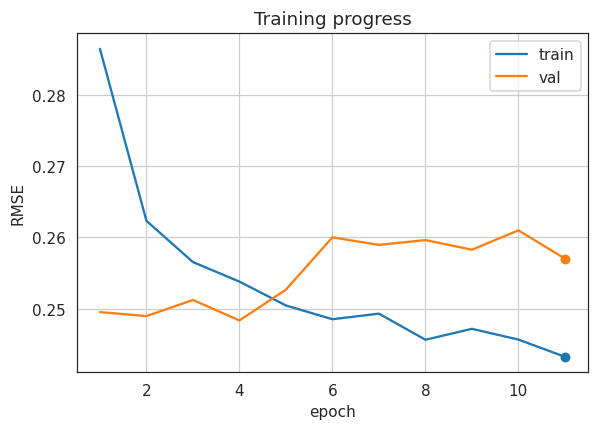

Epoch 1:   0%|          | 0/60 [00:01<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2864 MAE=0.2177 R2=0.0241 | Acc=0.7275 Prec=0.4811 Rec=0.1947 F1=0.2772 AUROC=0.6409
VALID→ RMSE=0.2495 MAE=0.1905 R2=0.2236 | Acc=0.7645 Prec=0.6446 Rec=0.3096 F1=0.4183 AUROC=0.7438


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2623 MAE=0.2003 R2=0.1815 | Acc=0.7590 Prec=0.6109 Rec=0.2806 F1=0.3845 AUROC=0.7198
VALID→ RMSE=0.2490 MAE=0.1806 R2=0.2271 | Acc=0.7649 Prec=0.6544 Rec=0.2974 F1=0.4089 AUROC=0.7450


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2565 MAE=0.1957 R2=0.2172 | Acc=0.7626 Prec=0.6133 Rec=0.3121 F1=0.4137 AUROC=0.7382
VALID→ RMSE=0.2512 MAE=0.1782 R2=0.2130 | Acc=0.7643 Prec=0.6939 Rec=0.2470 F1=0.3643 AUROC=0.7505


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2538 MAE=0.1921 R2=0.2338 | Acc=0.7651 Prec=0.6241 Rec=0.3140 F1=0.4178 AUROC=0.7462
VALID→ RMSE=0.2484 MAE=0.1846 R2=0.2309 | Acc=0.7614 Prec=0.6488 Rec=0.2778 F1=0.3891 AUROC=0.7480


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2505 MAE=0.1896 R2=0.2539 | Acc=0.7681 Prec=0.6295 Rec=0.3308 F1=0.4337 AUROC=0.7568
VALID→ RMSE=0.2527 MAE=0.1919 R2=0.2039 | Acc=0.7513 Prec=0.5881 Rec=0.3022 F1=0.3993 AUROC=0.7366


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2485 MAE=0.1881 R2=0.2654 | Acc=0.7702 Prec=0.6377 Rec=0.3325 F1=0.4371 AUROC=0.7622
VALID→ RMSE=0.2600 MAE=0.1880 R2=0.1570 | Acc=0.7432 Prec=0.5688 Rec=0.2510 F1=0.3483 AUROC=0.7297


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2493 MAE=0.1868 R2=0.2607 | Acc=0.7702 Prec=0.6460 Rec=0.3183 F1=0.4265 AUROC=0.7602
VALID→ RMSE=0.2590 MAE=0.1989 R2=0.1639 | Acc=0.7384 Prec=0.5373 Rec=0.3123 F1=0.3950 AUROC=0.7218


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2457 MAE=0.1857 R2=0.2823 | Acc=0.7734 Prec=0.6464 Rec=0.3434 F1=0.4486 AUROC=0.7707
VALID→ RMSE=0.2596 MAE=0.1967 R2=0.1595 | Acc=0.7366 Prec=0.5326 Rec=0.2995 F1=0.3834 AUROC=0.7215


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2472 MAE=0.1866 R2=0.2733 | Acc=0.7721 Prec=0.6407 Rec=0.3430 F1=0.4469 AUROC=0.7671
VALID→ RMSE=0.2583 MAE=0.1934 R2=0.1682 | Acc=0.7413 Prec=0.5541 Rec=0.2763 F1=0.3688 AUROC=0.7244


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2457 MAE=0.1846 R2=0.2821 | Acc=0.7741 Prec=0.6497 Rec=0.3430 F1=0.4490 AUROC=0.7710
VALID→ RMSE=0.2610 MAE=0.1986 R2=0.1507 | Acc=0.7337 Prec=0.5209 Rec=0.3246 F1=0.4000 AUROC=0.7196


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2433 MAE=0.1833 R2=0.2961 | Acc=0.7766 Prec=0.6547 Rec=0.3543 F1=0.4598 AUROC=0.7777
VALID→ RMSE=0.2570 MAE=0.1956 R2=0.1763 | Acc=0.7396 Prec=0.5404 Rec=0.3203 F1=0.4022 AUROC=0.7274
Early stopping at epoch 11
✅ Final best model (_fin) saved: AAPL_0.24836_fin.pth
Delete variables to free memory...


[I 2025-09-23 02:18:46,256] Trial 31 finished with value: 0.2483634501695633 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.30331385752503875, 'DROPOUT_LONG': 0.2576848114726311, 'ATT_DROPOUT': 0.18762006712297974, 'INITIAL_LR': 0.0009014557019049414, 'ETA_MIN': 1.7758621710485724e-06, 'WEIGHT_DECAY': 0.0027360734874760633, 'CLIPNORM': 2.1513361096801646}. Best is trial 21 with value: 0.24631395936012268.



▶ Trial 32 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.29900968705903475, 'DROPOUT_LONG': 0.30170391223872, 'ATT_DROPOUT': 0.20928386372172927, 'INITIAL_LR': 0.0006845049917928717, 'ETA_MIN': 1.8105312468217491e-06, 'WEIGHT_DECAY': 0.00542596115119255, 'CLIPNORM': 8.25992281961362}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


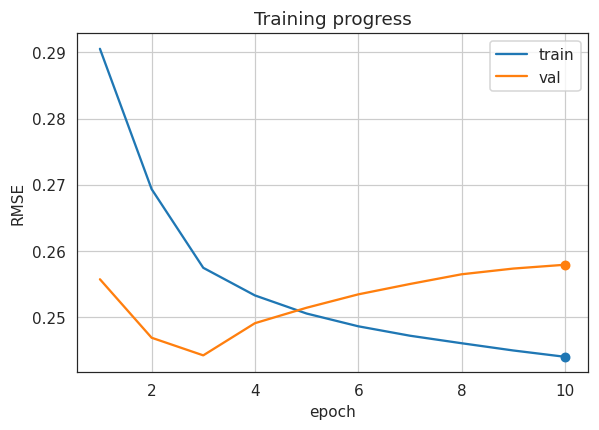

Epoch 1:   0%|          | 0/60 [00:03<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2905 MAE=0.2226 R2=-0.0039 | Acc=0.6974 Prec=0.3798 Rec=0.2017 F1=0.2635 AUROC=0.6117
VALID→ RMSE=0.2557 MAE=0.1808 R2=0.1846 | Acc=0.7608 Prec=0.6659 Rec=0.2515 F1=0.3651 AUROC=0.7383


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2693 MAE=0.2050 R2=0.1371 | Acc=0.7497 Prec=0.5836 Rec=0.2350 F1=0.3351 AUROC=0.6873
VALID→ RMSE=0.2469 MAE=0.1839 R2=0.2400 | Acc=0.7644 Prec=0.6507 Rec=0.2991 F1=0.4098 AUROC=0.7459


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2575 MAE=0.1959 R2=0.2117 | Acc=0.7609 Prec=0.6173 Rec=0.2869 F1=0.3917 AUROC=0.7285
VALID→ RMSE=0.2442 MAE=0.1849 R2=0.2563 | Acc=0.7664 Prec=0.6439 Rec=0.3265 F1=0.4333 AUROC=0.7577


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2533 MAE=0.1924 R2=0.2370 | Acc=0.7650 Prec=0.6257 Rec=0.3090 F1=0.4137 AUROC=0.7460
VALID→ RMSE=0.2491 MAE=0.1819 R2=0.2264 | Acc=0.7625 Prec=0.6739 Rec=0.2544 F1=0.3694 AUROC=0.7515


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2505 MAE=0.1897 R2=0.2534 | Acc=0.7678 Prec=0.6334 Rec=0.3203 F1=0.4255 AUROC=0.7558
VALID→ RMSE=0.2514 MAE=0.1837 R2=0.2118 | Acc=0.7578 Prec=0.6567 Rec=0.2398 F1=0.3513 AUROC=0.7460


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2486 MAE=0.1880 R2=0.2648 | Acc=0.7699 Prec=0.6393 Rec=0.3275 F1=0.4331 AUROC=0.7621
VALID→ RMSE=0.2534 MAE=0.1850 R2=0.1991 | Acc=0.7548 Prec=0.6353 Rec=0.2427 F1=0.3512 AUROC=0.7401


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2472 MAE=0.1867 R2=0.2732 | Acc=0.7716 Prec=0.6430 Rec=0.3346 F1=0.4401 AUROC=0.7669
VALID→ RMSE=0.2550 MAE=0.1862 R2=0.1892 | Acc=0.7530 Prec=0.6272 Rec=0.2384 F1=0.3455 AUROC=0.7332


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2461 MAE=0.1855 R2=0.2799 | Acc=0.7730 Prec=0.6454 Rec=0.3418 F1=0.4469 AUROC=0.7705
VALID→ RMSE=0.2565 MAE=0.1879 R2=0.1798 | Acc=0.7492 Prec=0.5990 Rec=0.2504 F1=0.3531 AUROC=0.7266


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2450 MAE=0.1846 R2=0.2863 | Acc=0.7743 Prec=0.6487 Rec=0.3469 F1=0.4521 AUROC=0.7738
VALID→ RMSE=0.2573 MAE=0.1893 R2=0.1743 | Acc=0.7470 Prec=0.5844 Rec=0.2591 F1=0.3590 AUROC=0.7225


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2440 MAE=0.1837 R2=0.2918 | Acc=0.7756 Prec=0.6508 Rec=0.3532 F1=0.4579 AUROC=0.7767
VALID→ RMSE=0.2579 MAE=0.1910 R2=0.1706 | Acc=0.7433 Prec=0.5614 Rec=0.2800 F1=0.3737 AUROC=0.7201
Early stopping at epoch 10
✅ Final best model (_fin) saved: AAPL_0.24423_fin.pth
Delete variables to free memory...


[I 2025-09-23 02:30:06,253] Trial 32 finished with value: 0.2442263513803482 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.29900968705903475, 'DROPOUT_LONG': 0.30170391223872, 'ATT_DROPOUT': 0.20928386372172927, 'INITIAL_LR': 0.0006845049917928717, 'ETA_MIN': 1.8105312468217491e-06, 'WEIGHT_DECAY': 0.00542596115119255, 'CLIPNORM': 8.25992281961362}. Best is trial 32 with value: 0.2442263513803482.



▶ Trial 33 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.3317810278773235, 'DROPOUT_LONG': 0.3051192897594639, 'ATT_DROPOUT': 0.19070164008475207, 'INITIAL_LR': 0.0005985922937218475, 'ETA_MIN': 1.4449567423414605e-06, 'WEIGHT_DECAY': 0.005758636519406168, 'CLIPNORM': 8.653708921500272}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


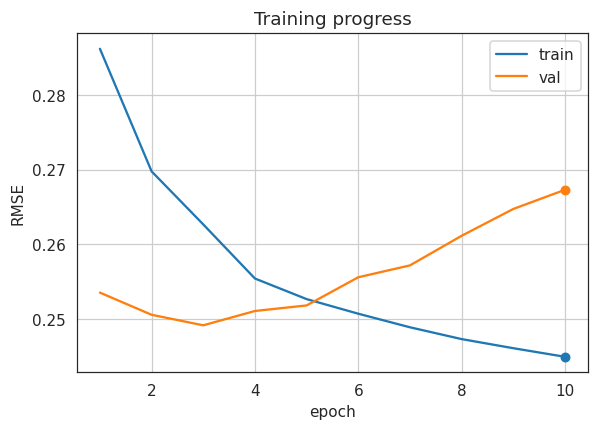

Epoch 1:   0%|          | 0/60 [00:03<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2862 MAE=0.2190 R2=0.0261 | Acc=0.7203 Prec=0.4282 Rec=0.1262 F1=0.1949 AUROC=0.6198
VALID→ RMSE=0.2535 MAE=0.1795 R2=0.1986 | Acc=0.7622 Prec=0.6762 Rec=0.2503 F1=0.3654 AUROC=0.7488


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2698 MAE=0.2055 R2=0.1345 | Acc=0.7473 Prec=0.5796 Rec=0.2132 F1=0.3117 AUROC=0.6851
VALID→ RMSE=0.2506 MAE=0.1832 R2=0.2172 | Acc=0.7640 Prec=0.6504 Rec=0.2963 F1=0.4071 AUROC=0.7454


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2627 MAE=0.2018 R2=0.1795 | Acc=0.7555 Prec=0.5961 Rec=0.2763 F1=0.3776 AUROC=0.7151
VALID→ RMSE=0.2491 MAE=0.1850 R2=0.2260 | Acc=0.7627 Prec=0.6375 Rec=0.3067 F1=0.4141 AUROC=0.7452


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2554 MAE=0.1945 R2=0.2241 | Acc=0.7630 Prec=0.6240 Rec=0.2941 F1=0.3998 AUROC=0.7385
VALID→ RMSE=0.2511 MAE=0.1822 R2=0.2140 | Acc=0.7615 Prec=0.6610 Rec=0.2624 F1=0.3757 AUROC=0.7436


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2527 MAE=0.1919 R2=0.2408 | Acc=0.7660 Prec=0.6317 Rec=0.3068 F1=0.4130 AUROC=0.7486
VALID→ RMSE=0.2518 MAE=0.1839 R2=0.2094 | Acc=0.7592 Prec=0.6565 Rec=0.2505 F1=0.3626 AUROC=0.7394


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2507 MAE=0.1900 R2=0.2525 | Acc=0.7680 Prec=0.6367 Rec=0.3152 F1=0.4217 AUROC=0.7552
VALID→ RMSE=0.2556 MAE=0.1833 R2=0.1855 | Acc=0.7560 Prec=0.6674 Rec=0.2149 F1=0.3251 AUROC=0.7329


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2489 MAE=0.1880 R2=0.2633 | Acc=0.7700 Prec=0.6429 Rec=0.3216 F1=0.4287 AUROC=0.7612
VALID→ RMSE=0.2572 MAE=0.1860 R2=0.1754 | Acc=0.7531 Prec=0.6447 Rec=0.2166 F1=0.3242 AUROC=0.7251


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2473 MAE=0.1868 R2=0.2726 | Acc=0.7718 Prec=0.6461 Rec=0.3314 F1=0.4381 AUROC=0.7668
VALID→ RMSE=0.2611 MAE=0.1889 R2=0.1498 | Acc=0.7481 Prec=0.6128 Rec=0.2144 F1=0.3176 AUROC=0.7108


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2461 MAE=0.1857 R2=0.2797 | Acc=0.7731 Prec=0.6470 Rec=0.3399 F1=0.4456 AUROC=0.7710
VALID→ RMSE=0.2647 MAE=0.1910 R2=0.1262 | Acc=0.7436 Prec=0.5864 Rec=0.2120 F1=0.3114 AUROC=0.6997


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2449 MAE=0.1848 R2=0.2865 | Acc=0.7746 Prec=0.6494 Rec=0.3479 F1=0.4531 AUROC=0.7743
VALID→ RMSE=0.2673 MAE=0.1919 R2=0.1092 | Acc=0.7405 Prec=0.5727 Rec=0.2015 F1=0.2981 AUROC=0.6923
Early stopping at epoch 10
✅ Final best model (_fin) saved: AAPL_0.24915_fin.pth
Delete variables to free memory...


[I 2025-09-23 02:42:38,193] Trial 33 finished with value: 0.24914668500423431 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.3317810278773235, 'DROPOUT_LONG': 0.3051192897594639, 'ATT_DROPOUT': 0.19070164008475207, 'INITIAL_LR': 0.0005985922937218475, 'ETA_MIN': 1.4449567423414605e-06, 'WEIGHT_DECAY': 0.005758636519406168, 'CLIPNORM': 8.653708921500272}. Best is trial 32 with value: 0.2442263513803482.



▶ Trial 34 starting with:
{'look_back': 30, 'DROPOUT_SHORT': 0.28322513277185235, 'DROPOUT_LONG': 0.3458328428333748, 'ATT_DROPOUT': 0.11932627367500655, 'INITIAL_LR': 0.00038223938890015637, 'ETA_MIN': 2.4197280902497976e-06, 'WEIGHT_DECAY': 0.00589469689450841, 'CLIPNORM': 7.417029725546979}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


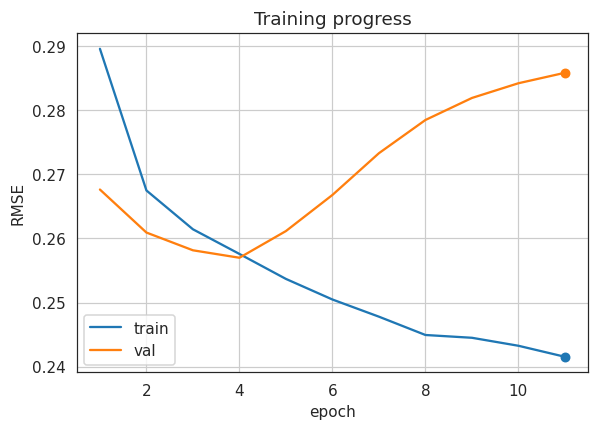

Epoch 1:   0%|          | 0/60 [00:02<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2896 MAE=0.2252 R2=0.0171 | Acc=0.6803 Prec=0.3566 Rec=0.1657 F1=0.2262 AUROC=0.5854
VALID→ RMSE=0.2676 MAE=0.1878 R2=0.1425 | Acc=0.7302 Prec=0.7290 Rec=0.1366 F1=0.2300 AUROC=0.7258


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2675 MAE=0.2039 R2=0.1614 | Acc=0.7353 Prec=0.5789 Rec=0.2269 F1=0.3260 AUROC=0.6874
VALID→ RMSE=0.2609 MAE=0.1885 R2=0.1850 | Acc=0.7421 Prec=0.6549 Rec=0.2667 F1=0.3790 AUROC=0.7336


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2614 MAE=0.2010 R2=0.1989 | Acc=0.7467 Prec=0.6079 Rec=0.2876 F1=0.3905 AUROC=0.7176
VALID→ RMSE=0.2582 MAE=0.1891 R2=0.2022 | Acc=0.7430 Prec=0.6444 Rec=0.2884 F1=0.3985 AUROC=0.7352


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2576 MAE=0.1985 R2=0.2223 | Acc=0.7508 Prec=0.6123 Rec=0.3178 F1=0.4184 AUROC=0.7335
VALID→ RMSE=0.2570 MAE=0.1912 R2=0.2094 | Acc=0.7422 Prec=0.6371 Rec=0.2935 F1=0.4019 AUROC=0.7364


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2537 MAE=0.1952 R2=0.2457 | Acc=0.7552 Prec=0.6208 Rec=0.3400 F1=0.4394 AUROC=0.7473
VALID→ RMSE=0.2612 MAE=0.1917 R2=0.1836 | Acc=0.7375 Prec=0.6279 Rec=0.2709 F1=0.3785 AUROC=0.7336


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2505 MAE=0.1918 R2=0.2647 | Acc=0.7595 Prec=0.6289 Rec=0.3597 F1=0.4576 AUROC=0.7577
VALID→ RMSE=0.2668 MAE=0.1980 R2=0.1480 | Acc=0.7230 Prec=0.5598 Rec=0.2870 F1=0.3795 AUROC=0.7218


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2478 MAE=0.1893 R2=0.2803 | Acc=0.7637 Prec=0.6391 Rec=0.3733 F1=0.4713 AUROC=0.7653
VALID→ RMSE=0.2733 MAE=0.2021 R2=0.1058 | Acc=0.7127 Prec=0.5247 Rec=0.2831 F1=0.3678 AUROC=0.7084


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2449 MAE=0.1867 R2=0.2968 | Acc=0.7679 Prec=0.6494 Rec=0.3849 F1=0.4834 AUROC=0.7732
VALID→ RMSE=0.2785 MAE=0.2083 R2=0.0716 | Acc=0.7042 Prec=0.4982 Rec=0.3019 F1=0.3760 AUROC=0.6924


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2445 MAE=0.1858 R2=0.2993 | Acc=0.7687 Prec=0.6514 Rec=0.3878 F1=0.4862 AUROC=0.7747
VALID→ RMSE=0.2819 MAE=0.2117 R2=0.0486 | Acc=0.6981 Prec=0.4817 Rec=0.3018 F1=0.3711 AUROC=0.6815


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2433 MAE=0.1848 R2=0.3064 | Acc=0.7706 Prec=0.6565 Rec=0.3921 F1=0.4910 AUROC=0.7780
VALID→ RMSE=0.2842 MAE=0.2123 R2=0.0330 | Acc=0.6973 Prec=0.4792 Rec=0.2968 F1=0.3666 AUROC=0.6769


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2415 MAE=0.1836 R2=0.3162 | Acc=0.7731 Prec=0.6610 Rec=0.4018 F1=0.4998 AUROC=0.7826
VALID→ RMSE=0.2859 MAE=0.2142 R2=0.0218 | Acc=0.6945 Prec=0.4732 Rec=0.3103 F1=0.3748 AUROC=0.6749
Early stopping at epoch 11
✅ Final best model (_fin) saved: AAPL_0.25699_fin.pth
Delete variables to free memory...


[I 2025-09-23 02:54:03,644] Trial 34 finished with value: 0.2569926977157593 and parameters: {'look_back': 30, 'DROPOUT_SHORT': 0.28322513277185235, 'DROPOUT_LONG': 0.3458328428333748, 'ATT_DROPOUT': 0.11932627367500655, 'INITIAL_LR': 0.00038223938890015637, 'ETA_MIN': 2.4197280902497976e-06, 'WEIGHT_DECAY': 0.00589469689450841, 'CLIPNORM': 7.417029725546979}. Best is trial 32 with value: 0.2442263513803482.



▶ Trial 35 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.2617930358993939, 'DROPOUT_LONG': 0.32487438769917154, 'ATT_DROPOUT': 0.3267159356509807, 'INITIAL_LR': 0.0006718220433261111, 'ETA_MIN': 6.8141864072539196e-06, 'WEIGHT_DECAY': 0.009487019204816085, 'CLIPNORM': 7.777269016763431}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


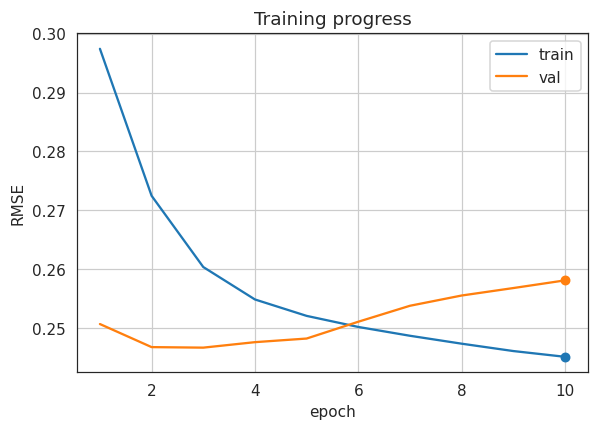

Epoch 1:   0%|          | 0/60 [00:05<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2974 MAE=0.2279 R2=-0.0522 | Acc=0.6966 Prec=0.3527 Rec=0.1564 F1=0.2167 AUROC=0.5942
VALID→ RMSE=0.2507 MAE=0.1821 R2=0.2165 | Acc=0.7611 Prec=0.6794 Rec=0.2391 F1=0.3537 AUROC=0.7465


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2725 MAE=0.2099 R2=0.1170 | Acc=0.7445 Prec=0.5523 Rec=0.2540 F1=0.3480 AUROC=0.6827
VALID→ RMSE=0.2468 MAE=0.1872 R2=0.2408 | Acc=0.7636 Prec=0.6284 Rec=0.3316 F1=0.4341 AUROC=0.7484


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2604 MAE=0.1987 R2=0.1938 | Acc=0.7584 Prec=0.6040 Rec=0.2901 F1=0.3920 AUROC=0.7214
VALID→ RMSE=0.2467 MAE=0.1849 R2=0.2414 | Acc=0.7642 Prec=0.6337 Rec=0.3261 F1=0.4306 AUROC=0.7507


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2548 MAE=0.1938 R2=0.2275 | Acc=0.7636 Prec=0.6202 Rec=0.3074 F1=0.4111 AUROC=0.7404
VALID→ RMSE=0.2476 MAE=0.1838 R2=0.2356 | Acc=0.7629 Prec=0.6278 Rec=0.3267 F1=0.4297 AUROC=0.7510


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2521 MAE=0.1914 R2=0.2443 | Acc=0.7663 Prec=0.6277 Rec=0.3178 F1=0.4220 AUROC=0.7508
VALID→ RMSE=0.2482 MAE=0.1870 R2=0.2318 | Acc=0.7600 Prec=0.6114 Rec=0.3358 F1=0.4335 AUROC=0.7485


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2502 MAE=0.1896 R2=0.2556 | Acc=0.7685 Prec=0.6344 Rec=0.3241 F1=0.4290 AUROC=0.7572
VALID→ RMSE=0.2511 MAE=0.1858 R2=0.2141 | Acc=0.7575 Prec=0.6123 Rec=0.3081 F1=0.4099 AUROC=0.7434


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2487 MAE=0.1880 R2=0.2645 | Acc=0.7706 Prec=0.6405 Rec=0.3307 F1=0.4362 AUROC=0.7622
VALID→ RMSE=0.2538 MAE=0.1881 R2=0.1970 | Acc=0.7521 Prec=0.5898 Rec=0.3068 F1=0.4036 AUROC=0.7359


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2473 MAE=0.1867 R2=0.2724 | Acc=0.7720 Prec=0.6438 Rec=0.3368 F1=0.4422 AUROC=0.7664
VALID→ RMSE=0.2555 MAE=0.1948 R2=0.1859 | Acc=0.7452 Prec=0.5533 Rec=0.3538 F1=0.4316 AUROC=0.7304


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2461 MAE=0.1859 R2=0.2797 | Acc=0.7735 Prec=0.6460 Rec=0.3449 F1=0.4497 AUROC=0.7704
VALID→ RMSE=0.2568 MAE=0.1977 R2=0.1778 | Acc=0.7417 Prec=0.5407 Rec=0.3684 F1=0.4382 AUROC=0.7272


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2451 MAE=0.1848 R2=0.2855 | Acc=0.7746 Prec=0.6491 Rec=0.3486 F1=0.4536 AUROC=0.7734
VALID→ RMSE=0.2581 MAE=0.1982 R2=0.1694 | Acc=0.7407 Prec=0.5383 Rec=0.3641 F1=0.4344 AUROC=0.7242
Early stopping at epoch 10
✅ Final best model (_fin) saved: AAPL_0.24666_fin.pth
Delete variables to free memory...


[I 2025-09-23 03:06:24,692] Trial 35 finished with value: 0.24666094779968262 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.2617930358993939, 'DROPOUT_LONG': 0.32487438769917154, 'ATT_DROPOUT': 0.3267159356509807, 'INITIAL_LR': 0.0006718220433261111, 'ETA_MIN': 6.8141864072539196e-06, 'WEIGHT_DECAY': 0.009487019204816085, 'CLIPNORM': 7.777269016763431}. Best is trial 32 with value: 0.2442263513803482.



▶ Trial 36 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.252894341679321, 'DROPOUT_LONG': 0.32479516944622844, 'ATT_DROPOUT': 0.3262021724632205, 'INITIAL_LR': 0.0006829323562929632, 'ETA_MIN': 6.72177217010382e-06, 'WEIGHT_DECAY': 0.0003914312414840023, 'CLIPNORM': 7.748043783788254}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


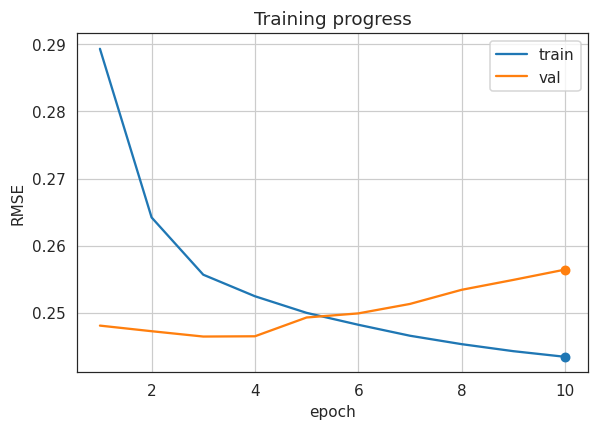

Epoch 1:   0%|          | 0/60 [00:02<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2893 MAE=0.2209 R2=0.0043 | Acc=0.7094 Prec=0.3705 Rec=0.1185 F1=0.1796 AUROC=0.6036
VALID→ RMSE=0.2481 MAE=0.1862 R2=0.2327 | Acc=0.7619 Prec=0.6354 Rec=0.3033 F1=0.4106 AUROC=0.7442


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2642 MAE=0.2025 R2=0.1698 | Acc=0.7543 Prec=0.5883 Rec=0.2812 F1=0.3805 AUROC=0.7081
VALID→ RMSE=0.2472 MAE=0.1832 R2=0.2378 | Acc=0.7650 Prec=0.6528 Rec=0.3006 F1=0.4116 AUROC=0.7493


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2557 MAE=0.1949 R2=0.2226 | Acc=0.7625 Prec=0.6153 Rec=0.3068 F1=0.4094 AUROC=0.7362
VALID→ RMSE=0.2464 MAE=0.1840 R2=0.2427 | Acc=0.7653 Prec=0.6538 Rec=0.3010 F1=0.4122 AUROC=0.7524


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2524 MAE=0.1919 R2=0.2420 | Acc=0.7656 Prec=0.6235 Rec=0.3191 F1=0.4221 AUROC=0.7474
VALID→ RMSE=0.2465 MAE=0.1847 R2=0.2425 | Acc=0.7654 Prec=0.6557 Rec=0.2990 F1=0.4108 AUROC=0.7516


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2500 MAE=0.1895 R2=0.2568 | Acc=0.7683 Prec=0.6336 Rec=0.3240 F1=0.4288 AUROC=0.7558
VALID→ RMSE=0.2493 MAE=0.1815 R2=0.2252 | Acc=0.7630 Prec=0.6671 Rec=0.2662 F1=0.3805 AUROC=0.7495


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2482 MAE=0.1878 R2=0.2673 | Acc=0.7702 Prec=0.6380 Rec=0.3323 F1=0.4370 AUROC=0.7624
VALID→ RMSE=0.2499 MAE=0.1849 R2=0.2214 | Acc=0.7610 Prec=0.6409 Rec=0.2868 F1=0.3962 AUROC=0.7441


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2466 MAE=0.1864 R2=0.2770 | Acc=0.7721 Prec=0.6428 Rec=0.3396 F1=0.4444 AUROC=0.7677
VALID→ RMSE=0.2513 MAE=0.1869 R2=0.2126 | Acc=0.7591 Prec=0.6273 Rec=0.2932 F1=0.3996 AUROC=0.7393


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2453 MAE=0.1852 R2=0.2843 | Acc=0.7740 Prec=0.6478 Rec=0.3456 F1=0.4508 AUROC=0.7719
VALID→ RMSE=0.2534 MAE=0.1885 R2=0.1993 | Acc=0.7559 Prec=0.6107 Rec=0.2960 F1=0.3987 AUROC=0.7330


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2443 MAE=0.1842 R2=0.2904 | Acc=0.7754 Prec=0.6500 Rec=0.3532 F1=0.4577 AUROC=0.7751
VALID→ RMSE=0.2549 MAE=0.1897 R2=0.1900 | Acc=0.7537 Prec=0.5987 Rec=0.3016 F1=0.4011 AUROC=0.7296


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2434 MAE=0.1834 R2=0.2953 | Acc=0.7764 Prec=0.6507 Rec=0.3604 F1=0.4639 AUROC=0.7779
VALID→ RMSE=0.2564 MAE=0.1915 R2=0.1802 | Acc=0.7512 Prec=0.5852 Rec=0.3095 F1=0.4049 AUROC=0.7262
Early stopping at epoch 10
✅ Final best model (_fin) saved: AAPL_0.24644_fin.pth
Delete variables to free memory...


[I 2025-09-23 03:18:43,263] Trial 36 finished with value: 0.24643772840499878 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.252894341679321, 'DROPOUT_LONG': 0.32479516944622844, 'ATT_DROPOUT': 0.3262021724632205, 'INITIAL_LR': 0.0006829323562929632, 'ETA_MIN': 6.72177217010382e-06, 'WEIGHT_DECAY': 0.0003914312414840023, 'CLIPNORM': 7.748043783788254}. Best is trial 32 with value: 0.2442263513803482.



▶ Trial 37 starting with:
{'look_back': 60, 'DROPOUT_SHORT': 0.20415608036714883, 'DROPOUT_LONG': 0.32957591666960073, 'ATT_DROPOUT': 0.23148496912720537, 'INITIAL_LR': 0.0007926305660434548, 'ETA_MIN': 8.82979226127415e-06, 'WEIGHT_DECAY': 0.0003119514295631928, 'CLIPNORM': 9.889320224427172}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


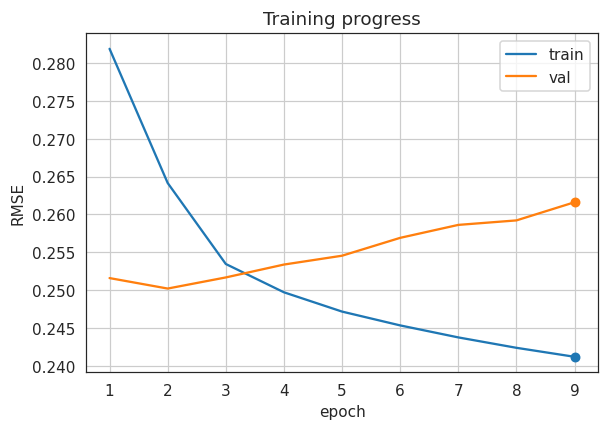

Epoch 1:   0%|          | 0/60 [00:09<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2819 MAE=0.2169 R2=0.0583 | Acc=0.7053 Prec=0.4348 Rec=0.2177 F1=0.2901 AUROC=0.6358
VALID→ RMSE=0.2516 MAE=0.1873 R2=0.2315 | Acc=0.7529 Prec=0.6780 Rec=0.2664 F1=0.3825 AUROC=0.7448


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2642 MAE=0.2042 R2=0.1730 | Acc=0.7479 Prec=0.5893 Rec=0.2929 F1=0.3913 AUROC=0.7106
VALID→ RMSE=0.2502 MAE=0.1906 R2=0.2400 | Acc=0.7553 Prec=0.6610 Rec=0.3043 F1=0.4167 AUROC=0.7467


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2535 MAE=0.1939 R2=0.2386 | Acc=0.7589 Prec=0.6229 Rec=0.3257 F1=0.4277 AUROC=0.7446
VALID→ RMSE=0.2517 MAE=0.1974 R2=0.2310 | Acc=0.7526 Prec=0.6249 Rec=0.3475 F1=0.4467 AUROC=0.7457


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2497 MAE=0.1906 R2=0.2609 | Acc=0.7628 Prec=0.6308 Rec=0.3441 F1=0.4453 AUROC=0.7574
VALID→ RMSE=0.2534 MAE=0.1896 R2=0.2206 | Acc=0.7492 Prec=0.6520 Rec=0.2722 F1=0.3841 AUROC=0.7433


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2472 MAE=0.1876 R2=0.2759 | Acc=0.7664 Prec=0.6429 Rec=0.3496 F1=0.4529 AUROC=0.7651
VALID→ RMSE=0.2546 MAE=0.1928 R2=0.2134 | Acc=0.7447 Prec=0.6221 Rec=0.2840 F1=0.3899 AUROC=0.7395


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2453 MAE=0.1861 R2=0.2866 | Acc=0.7686 Prec=0.6480 Rec=0.3579 F1=0.4611 AUROC=0.7705
VALID→ RMSE=0.2569 MAE=0.1941 R2=0.1987 | Acc=0.7414 Prec=0.6110 Rec=0.2751 F1=0.3794 AUROC=0.7335


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2438 MAE=0.1847 R2=0.2957 | Acc=0.7711 Prec=0.6535 Rec=0.3674 F1=0.4704 AUROC=0.7754
VALID→ RMSE=0.2586 MAE=0.1943 R2=0.1880 | Acc=0.7379 Prec=0.5983 Rec=0.2671 F1=0.3693 AUROC=0.7300


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2424 MAE=0.1831 R2=0.3037 | Acc=0.7732 Prec=0.6600 Rec=0.3717 F1=0.4756 AUROC=0.7791
VALID→ RMSE=0.2592 MAE=0.1953 R2=0.1843 | Acc=0.7366 Prec=0.5890 Rec=0.2751 F1=0.3751 AUROC=0.7284


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2412 MAE=0.1820 R2=0.3105 | Acc=0.7749 Prec=0.6646 Rec=0.3765 F1=0.4807 AUROC=0.7826
VALID→ RMSE=0.2616 MAE=0.1949 R2=0.1691 | Acc=0.7329 Prec=0.5767 Rec=0.2642 F1=0.3623 AUROC=0.7238
Early stopping at epoch 9
✅ Final best model (_fin) saved: AAPL_0.25022_fin.pth
Delete variables to free memory...


[I 2025-09-23 03:29:05,463] Trial 37 finished with value: 0.25021591782569885 and parameters: {'look_back': 60, 'DROPOUT_SHORT': 0.20415608036714883, 'DROPOUT_LONG': 0.32957591666960073, 'ATT_DROPOUT': 0.23148496912720537, 'INITIAL_LR': 0.0007926305660434548, 'ETA_MIN': 8.82979226127415e-06, 'WEIGHT_DECAY': 0.0003119514295631928, 'CLIPNORM': 9.889320224427172}. Best is trial 32 with value: 0.2442263513803482.



▶ Trial 38 starting with:
{'look_back': 30, 'DROPOUT_SHORT': 0.24896749383511024, 'DROPOUT_LONG': 0.302697850525167, 'ATT_DROPOUT': 0.1655266294793566, 'INITIAL_LR': 0.0005687980010906238, 'ETA_MIN': 6.908713643832469e-06, 'WEIGHT_DECAY': 0.0008149550877065926, 'CLIPNORM': 5.654877267868637}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


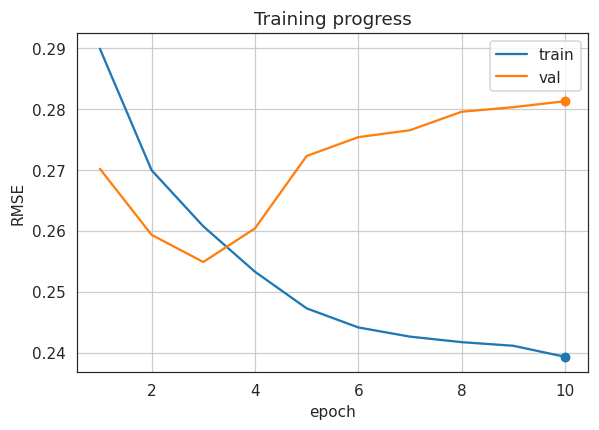

Epoch 1:   0%|          | 0/60 [00:01<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2899 MAE=0.2240 R2=0.0153 | Acc=0.6856 Prec=0.3613 Rec=0.1491 F1=0.2111 AUROC=0.5963
VALID→ RMSE=0.2702 MAE=0.1882 R2=0.1263 | Acc=0.7283 Prec=0.7158 Rec=0.1317 F1=0.2225 AUROC=0.7182


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2699 MAE=0.2058 R2=0.1461 | Acc=0.7350 Prec=0.5689 Rec=0.2503 F1=0.3476 AUROC=0.6936
VALID→ RMSE=0.2593 MAE=0.1870 R2=0.1950 | Acc=0.7415 Prec=0.6847 Rec=0.2297 F1=0.3440 AUROC=0.7364


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2607 MAE=0.1995 R2=0.2033 | Acc=0.7480 Prec=0.6089 Rec=0.2982 F1=0.4003 AUROC=0.7275
VALID→ RMSE=0.2549 MAE=0.1928 R2=0.2225 | Acc=0.7446 Prec=0.6383 Rec=0.3101 F1=0.4174 AUROC=0.7466


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2533 MAE=0.1936 R2=0.2482 | Acc=0.7567 Prec=0.6258 Rec=0.3426 F1=0.4428 AUROC=0.7518
VALID→ RMSE=0.2604 MAE=0.1989 R2=0.1885 | Acc=0.7348 Prec=0.5790 Rec=0.3718 F1=0.4528 AUROC=0.7418


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2473 MAE=0.1880 R2=0.2835 | Acc=0.7651 Prec=0.6492 Rec=0.3642 F1=0.4666 AUROC=0.7683
VALID→ RMSE=0.2723 MAE=0.2069 R2=0.1127 | Acc=0.7178 Prec=0.5292 Rec=0.3979 F1=0.4542 AUROC=0.7262


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2441 MAE=0.1853 R2=0.3015 | Acc=0.7694 Prec=0.6549 Rec=0.3863 F1=0.4859 AUROC=0.7767
VALID→ RMSE=0.2754 MAE=0.2090 R2=0.0924 | Acc=0.7108 Prec=0.5136 Rec=0.3771 F1=0.4349 AUROC=0.7174


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2426 MAE=0.1842 R2=0.3101 | Acc=0.7713 Prec=0.6577 Rec=0.3948 F1=0.4934 AUROC=0.7814
VALID→ RMSE=0.2765 MAE=0.2045 R2=0.0849 | Acc=0.7104 Prec=0.5149 Rec=0.3213 F1=0.3957 AUROC=0.7140


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2417 MAE=0.1826 R2=0.3153 | Acc=0.7730 Prec=0.6625 Rec=0.3986 F1=0.4977 AUROC=0.7835
VALID→ RMSE=0.2795 MAE=0.2106 R2=0.0647 | Acc=0.7035 Prec=0.4968 Rec=0.3560 F1=0.4148 AUROC=0.7087


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2411 MAE=0.1825 R2=0.3186 | Acc=0.7734 Prec=0.6610 Rec=0.4039 F1=0.5014 AUROC=0.7857
VALID→ RMSE=0.2803 MAE=0.2103 R2=0.0597 | Acc=0.7016 Prec=0.4922 Rec=0.3471 F1=0.4071 AUROC=0.7061


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2393 MAE=0.1809 R2=0.3288 | Acc=0.7757 Prec=0.6678 Rec=0.4077 F1=0.5063 AUROC=0.7896
VALID→ RMSE=0.2813 MAE=0.2107 R2=0.0531 | Acc=0.7022 Prec=0.4933 Rec=0.3351 F1=0.3991 AUROC=0.7045
Early stopping at epoch 10
✅ Final best model (_fin) saved: AAPL_0.25486_fin.pth
Delete variables to free memory...


[I 2025-09-23 03:38:41,681] Trial 38 finished with value: 0.25486013293266296 and parameters: {'look_back': 30, 'DROPOUT_SHORT': 0.24896749383511024, 'DROPOUT_LONG': 0.302697850525167, 'ATT_DROPOUT': 0.1655266294793566, 'INITIAL_LR': 0.0005687980010906238, 'ETA_MIN': 6.908713643832469e-06, 'WEIGHT_DECAY': 0.0008149550877065926, 'CLIPNORM': 5.654877267868637}. Best is trial 32 with value: 0.2442263513803482.



▶ Trial 39 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.29871760637902145, 'DROPOUT_LONG': 0.2785628230738585, 'ATT_DROPOUT': 0.0596630116009966, 'INITIAL_LR': 0.000462556684274253, 'ETA_MIN': 1.389637338194183e-06, 'WEIGHT_DECAY': 0.00017249327315827613, 'CLIPNORM': 8.375004276585612}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


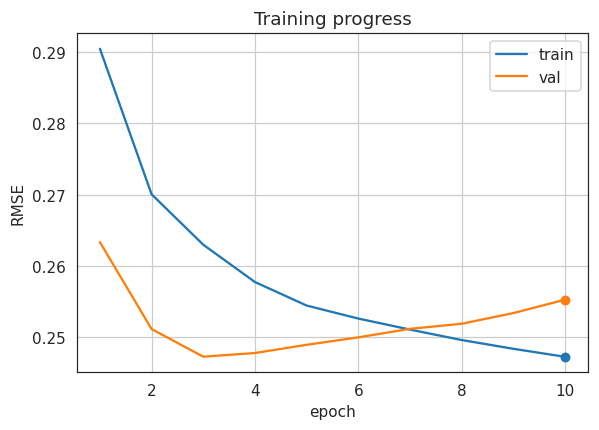

Epoch 1:   0%|          | 0/60 [00:02<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2905 MAE=0.2226 R2=-0.0035 | Acc=0.7081 Prec=0.3838 Rec=0.1447 F1=0.2102 AUROC=0.6060
VALID→ RMSE=0.2634 MAE=0.1796 R2=0.1352 | Acc=0.7573 Prec=0.7047 Rec=0.1933 F1=0.3034 AUROC=0.7405


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2701 MAE=0.2043 R2=0.1325 | Acc=0.7492 Prec=0.5808 Rec=0.2346 F1=0.3342 AUROC=0.6852
VALID→ RMSE=0.2512 MAE=0.1805 R2=0.2133 | Acc=0.7607 Prec=0.6884 Rec=0.2282 F1=0.3428 AUROC=0.7459


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2630 MAE=0.2010 R2=0.1773 | Acc=0.7563 Prec=0.6032 Rec=0.2683 F1=0.3714 AUROC=0.7106
VALID→ RMSE=0.2473 MAE=0.1824 R2=0.2374 | Acc=0.7631 Prec=0.6826 Rec=0.2499 F1=0.3659 AUROC=0.7508


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2578 MAE=0.1966 R2=0.2097 | Acc=0.7608 Prec=0.6160 Rec=0.2886 F1=0.3930 AUROC=0.7322
VALID→ RMSE=0.2478 MAE=0.1818 R2=0.2342 | Acc=0.7640 Prec=0.6898 Rec=0.2491 F1=0.3660 AUROC=0.7535


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2545 MAE=0.1933 R2=0.2298 | Acc=0.7637 Prec=0.6256 Rec=0.2979 F1=0.4036 AUROC=0.7444
VALID→ RMSE=0.2490 MAE=0.1816 R2=0.2271 | Acc=0.7625 Prec=0.6972 Rec=0.2326 F1=0.3488 AUROC=0.7546


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2527 MAE=0.1918 R2=0.2408 | Acc=0.7655 Prec=0.6293 Rec=0.3074 F1=0.4130 AUROC=0.7509
VALID→ RMSE=0.2500 MAE=0.1827 R2=0.2206 | Acc=0.7603 Prec=0.6878 Rec=0.2261 F1=0.3404 AUROC=0.7525


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2511 MAE=0.1905 R2=0.2500 | Acc=0.7669 Prec=0.6315 Rec=0.3159 F1=0.4211 AUROC=0.7562
VALID→ RMSE=0.2512 MAE=0.1844 R2=0.2131 | Acc=0.7576 Prec=0.6608 Rec=0.2334 F1=0.3450 AUROC=0.7489


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2496 MAE=0.1892 R2=0.2587 | Acc=0.7686 Prec=0.6352 Rec=0.3241 F1=0.4292 AUROC=0.7606
VALID→ RMSE=0.2519 MAE=0.1875 R2=0.2087 | Acc=0.7545 Prec=0.6205 Rec=0.2629 F1=0.3693 AUROC=0.7448


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2484 MAE=0.1883 R2=0.2660 | Acc=0.7703 Prec=0.6384 Rec=0.3324 F1=0.4372 AUROC=0.7642
VALID→ RMSE=0.2534 MAE=0.1896 R2=0.1993 | Acc=0.7503 Prec=0.5935 Rec=0.2756 F1=0.3764 AUROC=0.7416


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2473 MAE=0.1873 R2=0.2727 | Acc=0.7718 Prec=0.6412 Rec=0.3396 F1=0.4441 AUROC=0.7675
VALID→ RMSE=0.2553 MAE=0.1907 R2=0.1873 | Acc=0.7469 Prec=0.5793 Rec=0.2725 F1=0.3706 AUROC=0.7375
Early stopping at epoch 10
✅ Final best model (_fin) saved: AAPL_0.24731_fin.pth
Delete variables to free memory...


[I 2025-09-23 03:51:12,694] Trial 39 finished with value: 0.24730558693408966 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.29871760637902145, 'DROPOUT_LONG': 0.2785628230738585, 'ATT_DROPOUT': 0.0596630116009966, 'INITIAL_LR': 0.000462556684274253, 'ETA_MIN': 1.389637338194183e-06, 'WEIGHT_DECAY': 0.00017249327315827613, 'CLIPNORM': 8.375004276585612}. Best is trial 32 with value: 0.2442263513803482.



▶ Trial 40 starting with:
{'look_back': 90, 'DROPOUT_SHORT': 0.32864024338251707, 'DROPOUT_LONG': 0.32823869981354364, 'ATT_DROPOUT': 0.1507728111999877, 'INITIAL_LR': 0.000703450035432454, 'ETA_MIN': 2.118432795702872e-06, 'WEIGHT_DECAY': 8.496444145547712e-05, 'CLIPNORM': 6.426527411550932}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


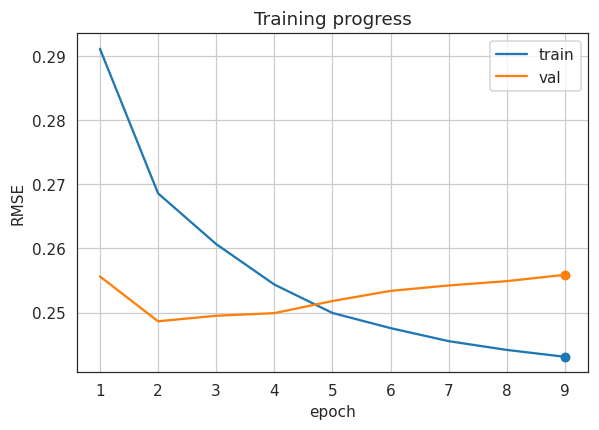

Epoch 1:   0%|          | 0/60 [00:04<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2911 MAE=0.2232 R2=-0.0087 | Acc=0.6966 Prec=0.4014 Rec=0.2296 F1=0.2921 AUROC=0.6253
VALID→ RMSE=0.2557 MAE=0.1824 R2=0.1956 | Acc=0.7584 Prec=0.6644 Rec=0.2798 F1=0.3938 AUROC=0.7449


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2686 MAE=0.2057 R2=0.1413 | Acc=0.7472 Prec=0.5812 Rec=0.2603 F1=0.3596 AUROC=0.6927
VALID→ RMSE=0.2487 MAE=0.1849 R2=0.2390 | Acc=0.7601 Prec=0.6511 Rec=0.3111 F1=0.4211 AUROC=0.7501


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2607 MAE=0.2004 R2=0.1911 | Acc=0.7541 Prec=0.5983 Rec=0.2987 F1=0.3984 AUROC=0.7183
VALID→ RMSE=0.2495 MAE=0.1873 R2=0.2337 | Acc=0.7585 Prec=0.6436 Rec=0.3112 F1=0.4195 AUROC=0.7487


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2544 MAE=0.1941 R2=0.2297 | Acc=0.7606 Prec=0.6200 Rec=0.3150 F1=0.4177 AUROC=0.7407
VALID→ RMSE=0.2499 MAE=0.1908 R2=0.2312 | Acc=0.7559 Prec=0.6128 Rec=0.3520 F1=0.4471 AUROC=0.7476


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2500 MAE=0.1901 R2=0.2563 | Acc=0.7648 Prec=0.6288 Rec=0.3355 F1=0.4375 AUROC=0.7556
VALID→ RMSE=0.2518 MAE=0.1907 R2=0.2195 | Acc=0.7516 Prec=0.5954 Rec=0.3564 F1=0.4459 AUROC=0.7434


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2476 MAE=0.1879 R2=0.2703 | Acc=0.7678 Prec=0.6372 Rec=0.3446 F1=0.4473 AUROC=0.7634
VALID→ RMSE=0.2534 MAE=0.1913 R2=0.2097 | Acc=0.7472 Prec=0.5812 Rec=0.3526 F1=0.4389 AUROC=0.7385


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2456 MAE=0.1862 R2=0.2822 | Acc=0.7706 Prec=0.6437 Rec=0.3551 F1=0.4577 AUROC=0.7699
VALID→ RMSE=0.2542 MAE=0.1909 R2=0.2044 | Acc=0.7450 Prec=0.5755 Rec=0.3461 F1=0.4322 AUROC=0.7358


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2442 MAE=0.1849 R2=0.2901 | Acc=0.7725 Prec=0.6486 Rec=0.3611 F1=0.4639 AUROC=0.7737
VALID→ RMSE=0.2549 MAE=0.1908 R2=0.2002 | Acc=0.7446 Prec=0.5748 Rec=0.3431 F1=0.4297 AUROC=0.7347


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2431 MAE=0.1838 R2=0.2963 | Acc=0.7741 Prec=0.6541 Rec=0.3642 F1=0.4679 AUROC=0.7769
VALID→ RMSE=0.2559 MAE=0.1923 R2=0.1940 | Acc=0.7418 Prec=0.5629 Rec=0.3547 F1=0.4352 AUROC=0.7338
Early stopping at epoch 9
✅ Final best model (_fin) saved: AAPL_0.24866_fin.pth
Delete variables to free memory...


[I 2025-09-23 04:03:11,037] Trial 40 finished with value: 0.24866238236427307 and parameters: {'look_back': 90, 'DROPOUT_SHORT': 0.32864024338251707, 'DROPOUT_LONG': 0.32823869981354364, 'ATT_DROPOUT': 0.1507728111999877, 'INITIAL_LR': 0.000703450035432454, 'ETA_MIN': 2.118432795702872e-06, 'WEIGHT_DECAY': 8.496444145547712e-05, 'CLIPNORM': 6.426527411550932}. Best is trial 32 with value: 0.2442263513803482.



▶ Trial 41 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.22681058734372422, 'DROPOUT_LONG': 0.32466948638545495, 'ATT_DROPOUT': 0.3287408892574024, 'INITIAL_LR': 0.0007079957702027867, 'ETA_MIN': 6.890845833286299e-06, 'WEIGHT_DECAY': 0.004639441085601309, 'CLIPNORM': 7.765791169927738}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


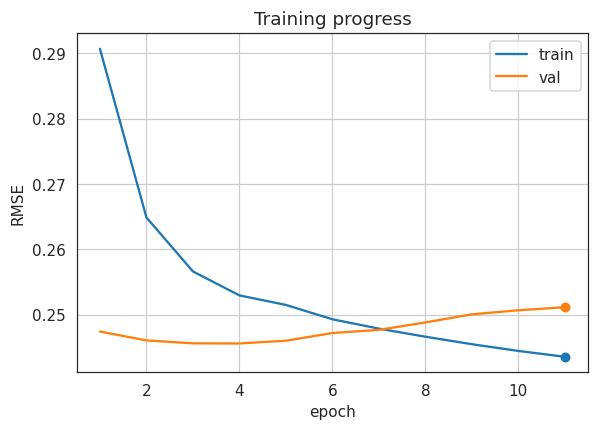

Epoch 1:   0%|          | 0/60 [00:03<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2907 MAE=0.2216 R2=-0.0050 | Acc=0.6961 Prec=0.3597 Rec=0.1698 F1=0.2307 AUROC=0.6039
VALID→ RMSE=0.2474 MAE=0.1862 R2=0.2368 | Acc=0.7618 Prec=0.6805 Rec=0.2427 F1=0.3578 AUROC=0.7418


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2649 MAE=0.2026 R2=0.1656 | Acc=0.7541 Prec=0.5932 Rec=0.2665 F1=0.3678 AUROC=0.7111
VALID→ RMSE=0.2460 MAE=0.1855 R2=0.2451 | Acc=0.7649 Prec=0.6547 Rec=0.2964 F1=0.4080 AUROC=0.7503


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2566 MAE=0.1951 R2=0.2168 | Acc=0.7617 Prec=0.6172 Rec=0.2951 F1=0.3993 AUROC=0.7366
VALID→ RMSE=0.2456 MAE=0.1864 R2=0.2479 | Acc=0.7649 Prec=0.6507 Rec=0.3028 F1=0.4133 AUROC=0.7526


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2529 MAE=0.1920 R2=0.2391 | Acc=0.7655 Prec=0.6309 Rec=0.3043 F1=0.4106 AUROC=0.7481
VALID→ RMSE=0.2456 MAE=0.1875 R2=0.2480 | Acc=0.7654 Prec=0.6523 Rec=0.3042 F1=0.4149 AUROC=0.7530


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2515 MAE=0.1907 R2=0.2478 | Acc=0.7671 Prec=0.6329 Rec=0.3147 F1=0.4203 AUROC=0.7541
VALID→ RMSE=0.2460 MAE=0.1887 R2=0.2455 | Acc=0.7647 Prec=0.6505 Rec=0.3016 F1=0.4121 AUROC=0.7519


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2493 MAE=0.1887 R2=0.2609 | Acc=0.7693 Prec=0.6397 Rec=0.3212 F1=0.4277 AUROC=0.7611
VALID→ RMSE=0.2472 MAE=0.1833 R2=0.2382 | Acc=0.7639 Prec=0.6573 Rec=0.2855 F1=0.3981 AUROC=0.7492


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2478 MAE=0.1869 R2=0.2694 | Acc=0.7708 Prec=0.6430 Rec=0.3279 F1=0.4343 AUROC=0.7655
VALID→ RMSE=0.2477 MAE=0.1843 R2=0.2352 | Acc=0.7624 Prec=0.6461 Rec=0.2898 F1=0.4001 AUROC=0.7479


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2466 MAE=0.1861 R2=0.2766 | Acc=0.7721 Prec=0.6420 Rec=0.3412 F1=0.4456 AUROC=0.7695
VALID→ RMSE=0.2488 MAE=0.1855 R2=0.2282 | Acc=0.7602 Prec=0.6309 Rec=0.2969 F1=0.4038 AUROC=0.7453


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2455 MAE=0.1853 R2=0.2834 | Acc=0.7734 Prec=0.6417 Rec=0.3522 F1=0.4548 AUROC=0.7732
VALID→ RMSE=0.2500 MAE=0.1863 R2=0.2205 | Acc=0.7579 Prec=0.6191 Rec=0.2983 F1=0.4026 AUROC=0.7426


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2444 MAE=0.1843 R2=0.2894 | Acc=0.7749 Prec=0.6463 Rec=0.3564 F1=0.4594 AUROC=0.7763
VALID→ RMSE=0.2507 MAE=0.1867 R2=0.2166 | Acc=0.7569 Prec=0.6151 Rec=0.2963 F1=0.3999 AUROC=0.7415


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2435 MAE=0.1835 R2=0.2946 | Acc=0.7763 Prec=0.6494 Rec=0.3614 F1=0.4644 AUROC=0.7786
VALID→ RMSE=0.2511 MAE=0.1872 R2=0.2137 | Acc=0.7552 Prec=0.6079 Rec=0.2948 F1=0.3970 AUROC=0.7406
Early stopping at epoch 11
✅ Final best model (_fin) saved: AAPL_0.24557_fin.pth
Delete variables to free memory...


[I 2025-09-23 04:18:21,896] Trial 41 finished with value: 0.24557483196258545 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.22681058734372422, 'DROPOUT_LONG': 0.32466948638545495, 'ATT_DROPOUT': 0.3287408892574024, 'INITIAL_LR': 0.0007079957702027867, 'ETA_MIN': 6.890845833286299e-06, 'WEIGHT_DECAY': 0.004639441085601309, 'CLIPNORM': 7.765791169927738}. Best is trial 32 with value: 0.2442263513803482.



▶ Trial 42 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.22525768066220048, 'DROPOUT_LONG': 0.331943903012119, 'ATT_DROPOUT': 0.32628754181732067, 'INITIAL_LR': 0.0008318900436750153, 'ETA_MIN': 5.404393221271348e-06, 'WEIGHT_DECAY': 0.0016773704274783332, 'CLIPNORM': 7.086244492153768}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


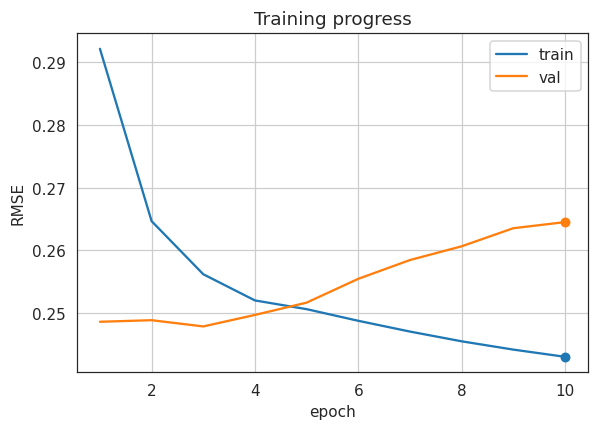

Epoch 1:   0%|          | 0/60 [00:03<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2922 MAE=0.2229 R2=-0.0153 | Acc=0.7083 Prec=0.4018 Rec=0.1778 F1=0.2466 AUROC=0.6221
VALID→ RMSE=0.2486 MAE=0.1844 R2=0.2293 | Acc=0.7646 Prec=0.6420 Rec=0.3148 F1=0.4224 AUROC=0.7416


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2647 MAE=0.2017 R2=0.1668 | Acc=0.7542 Prec=0.5891 Rec=0.2780 F1=0.3777 AUROC=0.7082
VALID→ RMSE=0.2489 MAE=0.1840 R2=0.2277 | Acc=0.7646 Prec=0.6461 Rec=0.3078 F1=0.4170 AUROC=0.7369


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2562 MAE=0.1950 R2=0.2193 | Acc=0.7620 Prec=0.6156 Rec=0.3019 F1=0.4051 AUROC=0.7354
VALID→ RMSE=0.2479 MAE=0.1834 R2=0.2339 | Acc=0.7653 Prec=0.6679 Rec=0.2819 F1=0.3965 AUROC=0.7449


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2520 MAE=0.1914 R2=0.2446 | Acc=0.7662 Prec=0.6296 Rec=0.3130 F1=0.4181 AUROC=0.7496
VALID→ RMSE=0.2497 MAE=0.1823 R2=0.2225 | Acc=0.7627 Prec=0.6785 Rec=0.2512 F1=0.3667 AUROC=0.7458


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2506 MAE=0.1901 R2=0.2529 | Acc=0.7680 Prec=0.6323 Rec=0.3242 F1=0.4286 AUROC=0.7551
VALID→ RMSE=0.2517 MAE=0.1839 R2=0.2102 | Acc=0.7592 Prec=0.6656 Rec=0.2397 F1=0.3525 AUROC=0.7416


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2488 MAE=0.1879 R2=0.2639 | Acc=0.7702 Prec=0.6419 Rec=0.3248 F1=0.4313 AUROC=0.7611
VALID→ RMSE=0.2555 MAE=0.1858 R2=0.1862 | Acc=0.7534 Prec=0.6337 Rec=0.2323 F1=0.3400 AUROC=0.7328


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2471 MAE=0.1865 R2=0.2740 | Acc=0.7721 Prec=0.6474 Rec=0.3310 F1=0.4380 AUROC=0.7666
VALID→ RMSE=0.2585 MAE=0.1935 R2=0.1670 | Acc=0.7452 Prec=0.5691 Rec=0.2816 F1=0.3767 AUROC=0.7214


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2455 MAE=0.1854 R2=0.2831 | Acc=0.7738 Prec=0.6517 Rec=0.3377 F1=0.4448 AUROC=0.7715
VALID→ RMSE=0.2607 MAE=0.1989 R2=0.1528 | Acc=0.7392 Prec=0.5397 Rec=0.3136 F1=0.3967 AUROC=0.7172


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2442 MAE=0.1842 R2=0.2909 | Acc=0.7751 Prec=0.6532 Rec=0.3451 F1=0.4516 AUROC=0.7753
VALID→ RMSE=0.2635 MAE=0.2027 R2=0.1340 | Acc=0.7338 Prec=0.5202 Rec=0.3406 F1=0.4117 AUROC=0.7132


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2430 MAE=0.1832 R2=0.2975 | Acc=0.7767 Prec=0.6556 Rec=0.3538 F1=0.4596 AUROC=0.7785
VALID→ RMSE=0.2645 MAE=0.2012 R2=0.1276 | Acc=0.7344 Prec=0.5229 Rec=0.3269 F1=0.4023 AUROC=0.7113
Early stopping at epoch 10
✅ Final best model (_fin) saved: AAPL_0.24787_fin.pth
Delete variables to free memory...


[I 2025-09-23 04:31:29,161] Trial 42 finished with value: 0.24787424504756927 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.22525768066220048, 'DROPOUT_LONG': 0.331943903012119, 'ATT_DROPOUT': 0.32628754181732067, 'INITIAL_LR': 0.0008318900436750153, 'ETA_MIN': 5.404393221271348e-06, 'WEIGHT_DECAY': 0.0016773704274783332, 'CLIPNORM': 7.086244492153768}. Best is trial 32 with value: 0.2442263513803482.



▶ Trial 43 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.19168497325323847, 'DROPOUT_LONG': 0.3113547530711778, 'ATT_DROPOUT': 0.2682705585751805, 'INITIAL_LR': 0.0006284817530563685, 'ETA_MIN': 7.870551709993818e-06, 'WEIGHT_DECAY': 4.767661679069424e-05, 'CLIPNORM': 7.966739549171994}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


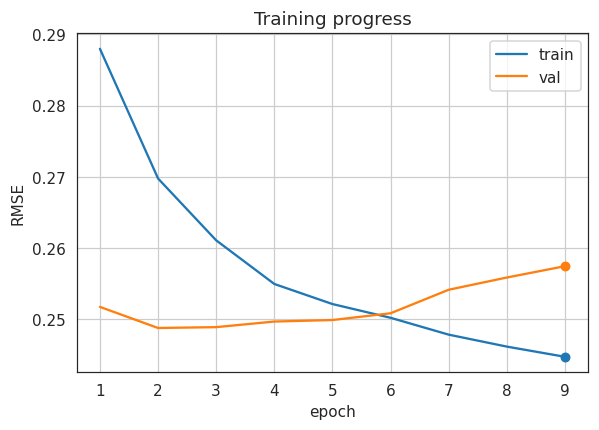

Epoch 1:   0%|          | 0/60 [00:04<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2880 MAE=0.2211 R2=0.0137 | Acc=0.7088 Prec=0.3969 Rec=0.1636 F1=0.2317 AUROC=0.6096
VALID→ RMSE=0.2518 MAE=0.1820 R2=0.2097 | Acc=0.7593 Prec=0.6728 Rec=0.2329 F1=0.3461 AUROC=0.7405


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2698 MAE=0.2084 R2=0.1344 | Acc=0.7473 Prec=0.5644 Rec=0.2563 F1=0.3526 AUROC=0.6769
VALID→ RMSE=0.2488 MAE=0.1851 R2=0.2282 | Acc=0.7621 Prec=0.6552 Rec=0.2746 F1=0.3870 AUROC=0.7462


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2611 MAE=0.2003 R2=0.1892 | Acc=0.7561 Prec=0.5941 Rec=0.2878 F1=0.3877 AUROC=0.7115
VALID→ RMSE=0.2489 MAE=0.1845 R2=0.2274 | Acc=0.7620 Prec=0.6597 Rec=0.2677 F1=0.3808 AUROC=0.7473


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2550 MAE=0.1943 R2=0.2268 | Acc=0.7620 Prec=0.6120 Rec=0.3088 F1=0.4104 AUROC=0.7372
VALID→ RMSE=0.2497 MAE=0.1877 R2=0.2225 | Acc=0.7603 Prec=0.6344 Rec=0.2914 F1=0.3993 AUROC=0.7448


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2522 MAE=0.1920 R2=0.2437 | Acc=0.7646 Prec=0.6170 Rec=0.3243 F1=0.4252 AUROC=0.7495
VALID→ RMSE=0.2499 MAE=0.1897 R2=0.2212 | Acc=0.7584 Prec=0.6194 Rec=0.3024 F1=0.4064 AUROC=0.7436


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2502 MAE=0.1903 R2=0.2553 | Acc=0.7669 Prec=0.6235 Rec=0.3322 F1=0.4335 AUROC=0.7568
VALID→ RMSE=0.2509 MAE=0.1878 R2=0.2153 | Acc=0.7572 Prec=0.6222 Rec=0.2853 F1=0.3912 AUROC=0.7425


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2479 MAE=0.1876 R2=0.2693 | Acc=0.7698 Prec=0.6345 Rec=0.3355 F1=0.4389 AUROC=0.7643
VALID→ RMSE=0.2542 MAE=0.1879 R2=0.1945 | Acc=0.7516 Prec=0.5978 Rec=0.2804 F1=0.3818 AUROC=0.7352


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2462 MAE=0.1860 R2=0.2791 | Acc=0.7719 Prec=0.6402 Rec=0.3431 F1=0.4467 AUROC=0.7697
VALID→ RMSE=0.2559 MAE=0.1911 R2=0.1836 | Acc=0.7473 Prec=0.5726 Rec=0.2988 F1=0.3927 AUROC=0.7299


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2448 MAE=0.1847 R2=0.2875 | Acc=0.7745 Prec=0.6468 Rec=0.3517 F1=0.4556 AUROC=0.7740
VALID→ RMSE=0.2575 MAE=0.1934 R2=0.1734 | Acc=0.7436 Prec=0.5560 Rec=0.3104 F1=0.3984 AUROC=0.7274
Early stopping at epoch 9
✅ Final best model (_fin) saved: AAPL_0.24880_fin.pth
Delete variables to free memory...


[I 2025-09-23 04:43:53,595] Trial 43 finished with value: 0.24879823625087738 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.19168497325323847, 'DROPOUT_LONG': 0.3113547530711778, 'ATT_DROPOUT': 0.2682705585751805, 'INITIAL_LR': 0.0006284817530563685, 'ETA_MIN': 7.870551709993818e-06, 'WEIGHT_DECAY': 4.767661679069424e-05, 'CLIPNORM': 7.966739549171994}. Best is trial 32 with value: 0.2442263513803482.



▶ Trial 44 starting with:
{'look_back': 60, 'DROPOUT_SHORT': 0.1553449654842987, 'DROPOUT_LONG': 0.28858292248434414, 'ATT_DROPOUT': 0.349742491472754, 'INITIAL_LR': 0.0005209779571016027, 'ETA_MIN': 6.847750048610951e-06, 'WEIGHT_DECAY': 0.004419888684156607, 'CLIPNORM': 8.48430373708063}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


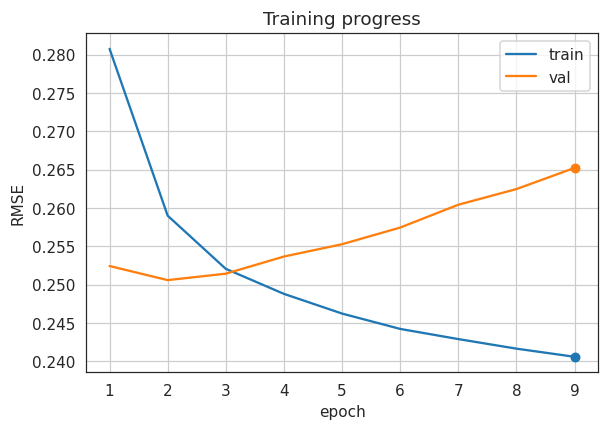

Epoch 1:   0%|          | 0/60 [00:03<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2807 MAE=0.2167 R2=0.0658 | Acc=0.6960 Prec=0.3976 Rec=0.1921 F1=0.2590 AUROC=0.6155
VALID→ RMSE=0.2524 MAE=0.1933 R2=0.2265 | Acc=0.7517 Prec=0.6423 Rec=0.3065 F1=0.4150 AUROC=0.7433


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2590 MAE=0.1980 R2=0.2051 | Acc=0.7502 Prec=0.6008 Rec=0.2889 F1=0.3902 AUROC=0.7192
VALID→ RMSE=0.2506 MAE=0.1902 R2=0.2378 | Acc=0.7528 Prec=0.6232 Rec=0.3532 F1=0.4508 AUROC=0.7469


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2520 MAE=0.1921 R2=0.2471 | Acc=0.7595 Prec=0.6251 Rec=0.3259 F1=0.4285 AUROC=0.7466
VALID→ RMSE=0.2514 MAE=0.1876 R2=0.2327 | Acc=0.7525 Prec=0.6358 Rec=0.3243 F1=0.4296 AUROC=0.7447


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2488 MAE=0.1889 R2=0.2664 | Acc=0.7630 Prec=0.6348 Rec=0.3372 F1=0.4404 AUROC=0.7580
VALID→ RMSE=0.2537 MAE=0.1862 R2=0.2189 | Acc=0.7506 Prec=0.6456 Rec=0.2926 F1=0.4027 AUROC=0.7433


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2462 MAE=0.1868 R2=0.2815 | Acc=0.7664 Prec=0.6421 Rec=0.3518 F1=0.4545 AUROC=0.7665
VALID→ RMSE=0.2553 MAE=0.1913 R2=0.2090 | Acc=0.7455 Prec=0.6047 Rec=0.3300 F1=0.4270 AUROC=0.7359


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2442 MAE=0.1850 R2=0.2931 | Acc=0.7693 Prec=0.6481 Rec=0.3634 F1=0.4657 AUROC=0.7724
VALID→ RMSE=0.2574 MAE=0.1946 R2=0.1955 | Acc=0.7402 Prec=0.5814 Rec=0.3412 F1=0.4300 AUROC=0.7307


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2429 MAE=0.1840 R2=0.3008 | Acc=0.7717 Prec=0.6533 Rec=0.3722 F1=0.4742 AUROC=0.7767
VALID→ RMSE=0.2604 MAE=0.1979 R2=0.1768 | Acc=0.7342 Prec=0.5584 Rec=0.3581 F1=0.4364 AUROC=0.7249


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2416 MAE=0.1828 R2=0.3080 | Acc=0.7735 Prec=0.6576 Rec=0.3781 F1=0.4801 AUROC=0.7801
VALID→ RMSE=0.2625 MAE=0.1984 R2=0.1638 | Acc=0.7308 Prec=0.5493 Rec=0.3511 F1=0.4284 AUROC=0.7204


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2406 MAE=0.1817 R2=0.3140 | Acc=0.7754 Prec=0.6622 Rec=0.3840 F1=0.4861 AUROC=0.7834
VALID→ RMSE=0.2652 MAE=0.1997 R2=0.1461 | Acc=0.7262 Prec=0.5354 Rec=0.3560 F1=0.4277 AUROC=0.7162
Early stopping at epoch 9
✅ Final best model (_fin) saved: AAPL_0.25058_fin.pth
Delete variables to free memory...


[I 2025-09-23 04:53:19,755] Trial 44 finished with value: 0.2505762279033661 and parameters: {'look_back': 60, 'DROPOUT_SHORT': 0.1553449654842987, 'DROPOUT_LONG': 0.28858292248434414, 'ATT_DROPOUT': 0.349742491472754, 'INITIAL_LR': 0.0005209779571016027, 'ETA_MIN': 6.847750048610951e-06, 'WEIGHT_DECAY': 0.004419888684156607, 'CLIPNORM': 8.48430373708063}. Best is trial 32 with value: 0.2442263513803482.



▶ Trial 45 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.16569919615813417, 'DROPOUT_LONG': 0.3333610170452577, 'ATT_DROPOUT': 0.23915338786298382, 'INITIAL_LR': 0.0003291631953391027, 'ETA_MIN': 5.305996503884042e-06, 'WEIGHT_DECAY': 0.0028546990436835486, 'CLIPNORM': 6.609648671371994}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


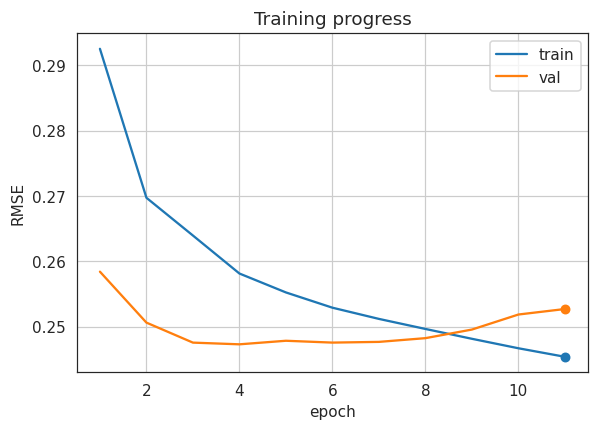

Epoch 1:   0%|          | 0/60 [00:05<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2925 MAE=0.2270 R2=-0.0177 | Acc=0.6811 Prec=0.3065 Rec=0.1489 F1=0.2005 AUROC=0.5635
VALID→ RMSE=0.2584 MAE=0.1804 R2=0.1674 | Acc=0.7493 Prec=0.7400 Rec=0.1284 F1=0.2189 AUROC=0.7386


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2697 MAE=0.2058 R2=0.1348 | Acc=0.7383 Prec=0.5300 Rec=0.2203 F1=0.3112 AUROC=0.6646
VALID→ RMSE=0.2506 MAE=0.1816 R2=0.2169 | Acc=0.7607 Prec=0.6519 Rec=0.2683 F1=0.3801 AUROC=0.7439


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2639 MAE=0.2027 R2=0.1714 | Acc=0.7494 Prec=0.5699 Rec=0.2698 F1=0.3662 AUROC=0.6988
VALID→ RMSE=0.2475 MAE=0.1837 R2=0.2359 | Acc=0.7620 Prec=0.6415 Rec=0.2941 F1=0.4033 AUROC=0.7447


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2581 MAE=0.1970 R2=0.2076 | Acc=0.7570 Prec=0.5958 Rec=0.2944 F1=0.3940 AUROC=0.7221
VALID→ RMSE=0.2473 MAE=0.1816 R2=0.2375 | Acc=0.7633 Prec=0.6591 Rec=0.2787 F1=0.3917 AUROC=0.7471


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2552 MAE=0.1944 R2=0.2252 | Acc=0.7609 Prec=0.6083 Rec=0.3066 F1=0.4077 AUROC=0.7346
VALID→ RMSE=0.2478 MAE=0.1810 R2=0.2342 | Acc=0.7634 Prec=0.6754 Rec=0.2595 F1=0.3749 AUROC=0.7483


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2529 MAE=0.1921 R2=0.2393 | Acc=0.7635 Prec=0.6165 Rec=0.3142 F1=0.4162 AUROC=0.7438
VALID→ RMSE=0.2475 MAE=0.1826 R2=0.2359 | Acc=0.7634 Prec=0.6729 Rec=0.2625 F1=0.3776 AUROC=0.7483


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2512 MAE=0.1908 R2=0.2496 | Acc=0.7655 Prec=0.6209 Rec=0.3236 F1=0.4255 AUROC=0.7504
VALID→ RMSE=0.2477 MAE=0.1848 R2=0.2352 | Acc=0.7630 Prec=0.6658 Rec=0.2678 F1=0.3820 AUROC=0.7463


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2496 MAE=0.1894 R2=0.2588 | Acc=0.7675 Prec=0.6265 Rec=0.3310 F1=0.4331 AUROC=0.7558
VALID→ RMSE=0.2482 MAE=0.1857 R2=0.2317 | Acc=0.7623 Prec=0.6599 Rec=0.2694 F1=0.3826 AUROC=0.7445


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2481 MAE=0.1881 R2=0.2677 | Acc=0.7693 Prec=0.6316 Rec=0.3371 F1=0.4396 AUROC=0.7609
VALID→ RMSE=0.2495 MAE=0.1851 R2=0.2235 | Acc=0.7608 Prec=0.6558 Rec=0.2634 F1=0.3759 AUROC=0.7432


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2467 MAE=0.1864 R2=0.2763 | Acc=0.7715 Prec=0.6388 Rec=0.3419 F1=0.4454 AUROC=0.7655
VALID→ RMSE=0.2518 MAE=0.1834 R2=0.2091 | Acc=0.7584 Prec=0.6553 Rec=0.2457 F1=0.3574 AUROC=0.7411


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2454 MAE=0.1850 R2=0.2839 | Acc=0.7730 Prec=0.6427 Rec=0.3468 F1=0.4505 AUROC=0.7695
VALID→ RMSE=0.2527 MAE=0.1852 R2=0.2038 | Acc=0.7565 Prec=0.6354 Rec=0.2571 F1=0.3661 AUROC=0.7375
Early stopping at epoch 11
✅ Final best model (_fin) saved: AAPL_0.24728_fin.pth
Delete variables to free memory...


[I 2025-09-23 05:07:17,357] Trial 45 finished with value: 0.24728411436080933 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.16569919615813417, 'DROPOUT_LONG': 0.3333610170452577, 'ATT_DROPOUT': 0.23915338786298382, 'INITIAL_LR': 0.0003291631953391027, 'ETA_MIN': 5.305996503884042e-06, 'WEIGHT_DECAY': 0.0028546990436835486, 'CLIPNORM': 6.609648671371994}. Best is trial 32 with value: 0.2442263513803482.



▶ Trial 46 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.23767561450566246, 'DROPOUT_LONG': 0.31774470474245864, 'ATT_DROPOUT': 0.3149170551011988, 'INITIAL_LR': 2.5225776343072592e-05, 'ETA_MIN': 8.561704123250506e-06, 'WEIGHT_DECAY': 1.1331069960691888e-05, 'CLIPNORM': 5.419410633496996}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


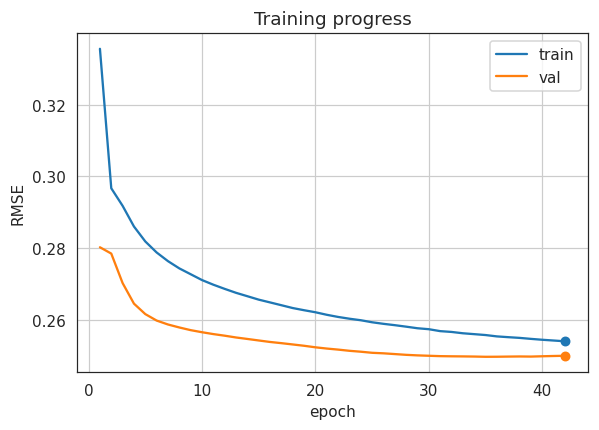

Epoch 1:   0%|          | 0/60 [00:03<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.3356 MAE=0.2870 R2=-0.3399 | Acc=0.6970 Prec=0.2411 Rec=0.0601 F1=0.0962 AUROC=0.4769
VALID→ RMSE=0.2803 MAE=0.2084 R2=0.0207 | Acc=0.7265 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.4633


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2967 MAE=0.2275 R2=-0.0471 | Acc=0.7168 Prec=0.2858 Rec=0.0369 F1=0.0654 AUROC=0.5070
VALID→ RMSE=0.2785 MAE=0.1946 R2=0.0330 | Acc=0.7265 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.5388


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2918 MAE=0.2190 R2=-0.0128 | Acc=0.7272 Prec=0.3041 Rec=0.0127 F1=0.0243 AUROC=0.5131
VALID→ RMSE=0.2703 MAE=0.1888 R2=0.0893 | Acc=0.7265 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6132


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2860 MAE=0.2147 R2=0.0268 | Acc=0.7287 Prec=0.3603 Rec=0.0142 F1=0.0273 AUROC=0.5285
VALID→ RMSE=0.2645 MAE=0.1847 R2=0.1276 | Acc=0.7265 Prec=1.0000 Rec=0.0000 F1=0.0000 AUROC=0.6636


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2819 MAE=0.2114 R2=0.0550 | Acc=0.7298 Prec=0.4293 Rec=0.0212 F1=0.0404 AUROC=0.5519
VALID→ RMSE=0.2616 MAE=0.1822 R2=0.1467 | Acc=0.7268 Prec=0.8909 Rec=0.0009 F1=0.0019 AUROC=0.6907


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2788 MAE=0.2086 R2=0.0755 | Acc=0.7314 Prec=0.4926 Rec=0.0320 F1=0.0600 AUROC=0.5748
VALID→ RMSE=0.2598 MAE=0.1808 R2=0.1584 | Acc=0.7285 Prec=0.8650 Rec=0.0085 F1=0.0168 AUROC=0.7069


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2764 MAE=0.2068 R2=0.0915 | Acc=0.7333 Prec=0.5347 Rec=0.0472 F1=0.0867 AUROC=0.5946
VALID→ RMSE=0.2587 MAE=0.1800 R2=0.1655 | Acc=0.7342 Prec=0.8549 Rec=0.0336 F1=0.0647 AUROC=0.7173


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2744 MAE=0.2052 R2=0.1047 | Acc=0.7358 Prec=0.5664 Rec=0.0664 F1=0.1189 AUROC=0.6113
VALID→ RMSE=0.2579 MAE=0.1795 R2=0.1709 | Acc=0.7415 Prec=0.8118 Rec=0.0710 F1=0.1306 AUROC=0.7245


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2727 MAE=0.2041 R2=0.1153 | Acc=0.7382 Prec=0.5826 Rec=0.0865 F1=0.1506 AUROC=0.6258
VALID→ RMSE=0.2571 MAE=0.1793 R2=0.1757 | Acc=0.7473 Prec=0.7799 Rec=0.1059 F1=0.1865 AUROC=0.7296


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2711 MAE=0.2032 R2=0.1259 | Acc=0.7404 Prec=0.5910 Rec=0.1064 F1=0.1803 AUROC=0.6369
VALID→ RMSE=0.2565 MAE=0.1791 R2=0.1794 | Acc=0.7511 Prec=0.7521 Rec=0.1341 F1=0.2277 AUROC=0.7333


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2698 MAE=0.2024 R2=0.1342 | Acc=0.7426 Prec=0.5974 Rec=0.1259 F1=0.2080 AUROC=0.6472
VALID→ RMSE=0.2560 MAE=0.1791 R2=0.1827 | Acc=0.7536 Prec=0.7336 Rec=0.1555 F1=0.2566 AUROC=0.7360


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.2686 MAE=0.2018 R2=0.1417 | Acc=0.7445 Prec=0.6008 Rec=0.1428 F1=0.2308 AUROC=0.6554
VALID→ RMSE=0.2556 MAE=0.1791 R2=0.1855 | Acc=0.7555 Prec=0.7231 Rec=0.1714 F1=0.2770 AUROC=0.7380


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.2675 MAE=0.2012 R2=0.1487 | Acc=0.7462 Prec=0.6035 Rec=0.1580 F1=0.2504 AUROC=0.6624
VALID→ RMSE=0.2551 MAE=0.1791 R2=0.1887 | Acc=0.7571 Prec=0.7158 Rec=0.1853 F1=0.2944 AUROC=0.7394


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ RMSE=0.2666 MAE=0.2006 R2=0.1547 | Acc=0.7477 Prec=0.6056 Rec=0.1720 F1=0.2679 AUROC=0.6693
VALID→ RMSE=0.2547 MAE=0.1792 R2=0.1913 | Acc=0.7581 Prec=0.7102 Rec=0.1949 F1=0.3058 AUROC=0.7406


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ RMSE=0.2656 MAE=0.2001 R2=0.1607 | Acc=0.7489 Prec=0.6070 Rec=0.1830 F1=0.2813 AUROC=0.6752
VALID→ RMSE=0.2542 MAE=0.1792 R2=0.1940 | Acc=0.7591 Prec=0.7075 Rec=0.2029 F1=0.3154 AUROC=0.7414


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ RMSE=0.2649 MAE=0.1997 R2=0.1656 | Acc=0.7499 Prec=0.6071 Rec=0.1930 F1=0.2929 AUROC=0.6804
VALID→ RMSE=0.2538 MAE=0.1793 R2=0.1967 | Acc=0.7599 Prec=0.7041 Rec=0.2103 F1=0.3239 AUROC=0.7421


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ RMSE=0.2641 MAE=0.1992 R2=0.1706 | Acc=0.7509 Prec=0.6082 Rec=0.2017 F1=0.3029 AUROC=0.6848
VALID→ RMSE=0.2535 MAE=0.1793 R2=0.1988 | Acc=0.7604 Prec=0.7016 Rec=0.2152 F1=0.3293 AUROC=0.7427


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ RMSE=0.2633 MAE=0.1987 R2=0.1755 | Acc=0.7519 Prec=0.6088 Rec=0.2109 F1=0.3132 AUROC=0.6896
VALID→ RMSE=0.2531 MAE=0.1794 R2=0.2011 | Acc=0.7608 Prec=0.6987 Rec=0.2200 F1=0.3347 AUROC=0.7433


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ RMSE=0.2627 MAE=0.1983 R2=0.1793 | Acc=0.7529 Prec=0.6110 Rec=0.2184 F1=0.3218 AUROC=0.6935
VALID→ RMSE=0.2528 MAE=0.1795 R2=0.2034 | Acc=0.7611 Prec=0.6963 Rec=0.2239 F1=0.3388 AUROC=0.7438


Epoch 20:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ RMSE=0.2621 MAE=0.1980 R2=0.1828 | Acc=0.7534 Prec=0.6107 Rec=0.2242 F1=0.3280 AUROC=0.6970
VALID→ RMSE=0.2523 MAE=0.1796 R2=0.2061 | Acc=0.7614 Prec=0.6948 Rec=0.2274 F1=0.3426 AUROC=0.7443


Epoch 21:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ RMSE=0.2614 MAE=0.1975 R2=0.1872 | Acc=0.7544 Prec=0.6121 Rec=0.2312 F1=0.3356 AUROC=0.7004
VALID→ RMSE=0.2520 MAE=0.1797 R2=0.2083 | Acc=0.7618 Prec=0.6936 Rec=0.2309 F1=0.3464 AUROC=0.7447


Epoch 22:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ RMSE=0.2608 MAE=0.1971 R2=0.1910 | Acc=0.7551 Prec=0.6133 Rec=0.2367 F1=0.3416 AUROC=0.7041
VALID→ RMSE=0.2517 MAE=0.1798 R2=0.2101 | Acc=0.7620 Prec=0.6926 Rec=0.2331 F1=0.3488 AUROC=0.7450


Epoch 23:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ RMSE=0.2603 MAE=0.1967 R2=0.1941 | Acc=0.7556 Prec=0.6135 Rec=0.2410 F1=0.3460 AUROC=0.7070
VALID→ RMSE=0.2514 MAE=0.1799 R2=0.2122 | Acc=0.7623 Prec=0.6909 Rec=0.2366 F1=0.3525 AUROC=0.7453


Epoch 24:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ RMSE=0.2599 MAE=0.1965 R2=0.1967 | Acc=0.7560 Prec=0.6133 Rec=0.2462 F1=0.3514 AUROC=0.7097
VALID→ RMSE=0.2511 MAE=0.1800 R2=0.2138 | Acc=0.7625 Prec=0.6898 Rec=0.2389 F1=0.3548 AUROC=0.7456


Epoch 25:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ RMSE=0.2593 MAE=0.1961 R2=0.2002 | Acc=0.7566 Prec=0.6141 Rec=0.2509 F1=0.3562 AUROC=0.7123
VALID→ RMSE=0.2508 MAE=0.1801 R2=0.2157 | Acc=0.7627 Prec=0.6887 Rec=0.2411 F1=0.3571 AUROC=0.7459


Epoch 26:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 026
TRAIN→ RMSE=0.2589 MAE=0.1958 R2=0.2029 | Acc=0.7573 Prec=0.6151 Rec=0.2553 F1=0.3608 AUROC=0.7148
VALID→ RMSE=0.2507 MAE=0.1801 R2=0.2166 | Acc=0.7628 Prec=0.6875 Rec=0.2430 F1=0.3590 AUROC=0.7462


Epoch 27:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 027
TRAIN→ RMSE=0.2585 MAE=0.1955 R2=0.2052 | Acc=0.7575 Prec=0.6147 Rec=0.2582 F1=0.3637 AUROC=0.7166
VALID→ RMSE=0.2504 MAE=0.1803 R2=0.2179 | Acc=0.7628 Prec=0.6861 Rec=0.2446 F1=0.3607 AUROC=0.7464


Epoch 28:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 028
TRAIN→ RMSE=0.2581 MAE=0.1952 R2=0.2077 | Acc=0.7581 Prec=0.6153 Rec=0.2636 F1=0.3691 AUROC=0.7189
VALID→ RMSE=0.2502 MAE=0.1804 R2=0.2192 | Acc=0.7629 Prec=0.6854 Rec=0.2457 F1=0.3617 AUROC=0.7467


Epoch 29:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 029
TRAIN→ RMSE=0.2577 MAE=0.1949 R2=0.2104 | Acc=0.7585 Prec=0.6157 Rec=0.2666 F1=0.3721 AUROC=0.7208
VALID→ RMSE=0.2501 MAE=0.1805 R2=0.2202 | Acc=0.7629 Prec=0.6843 Rec=0.2467 F1=0.3627 AUROC=0.7469


Epoch 30:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 030
TRAIN→ RMSE=0.2574 MAE=0.1947 R2=0.2121 | Acc=0.7587 Prec=0.6148 Rec=0.2700 F1=0.3752 AUROC=0.7225
VALID→ RMSE=0.2500 MAE=0.1805 R2=0.2209 | Acc=0.7628 Prec=0.6836 Rec=0.2471 F1=0.3630 AUROC=0.7470


Epoch 31:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 031
TRAIN→ RMSE=0.2568 MAE=0.1944 R2=0.2154 | Acc=0.7591 Prec=0.6150 Rec=0.2734 F1=0.3785 AUROC=0.7252
VALID→ RMSE=0.2499 MAE=0.1806 R2=0.2215 | Acc=0.7629 Prec=0.6828 Rec=0.2480 F1=0.3638 AUROC=0.7471


Epoch 32:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 032
TRAIN→ RMSE=0.2566 MAE=0.1942 R2=0.2167 | Acc=0.7599 Prec=0.6174 Rec=0.2772 F1=0.3826 AUROC=0.7267
VALID→ RMSE=0.2498 MAE=0.1807 R2=0.2218 | Acc=0.7629 Prec=0.6822 Rec=0.2488 F1=0.3646 AUROC=0.7473


Epoch 33:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 033
TRAIN→ RMSE=0.2563 MAE=0.1940 R2=0.2190 | Acc=0.7599 Prec=0.6160 Rec=0.2801 F1=0.3851 AUROC=0.7281
VALID→ RMSE=0.2498 MAE=0.1808 R2=0.2220 | Acc=0.7629 Prec=0.6828 Rec=0.2482 F1=0.3641 AUROC=0.7473


Epoch 34:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 034
TRAIN→ RMSE=0.2560 MAE=0.1938 R2=0.2205 | Acc=0.7602 Prec=0.6157 Rec=0.2836 F1=0.3884 AUROC=0.7296
VALID→ RMSE=0.2498 MAE=0.1809 R2=0.2222 | Acc=0.7629 Prec=0.6822 Rec=0.2487 F1=0.3645 AUROC=0.7473


Epoch 35:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 035
TRAIN→ RMSE=0.2558 MAE=0.1937 R2=0.2220 | Acc=0.7605 Prec=0.6162 Rec=0.2858 F1=0.3905 AUROC=0.7307
VALID→ RMSE=0.2497 MAE=0.1810 R2=0.2226 | Acc=0.7628 Prec=0.6819 Rec=0.2487 F1=0.3644 AUROC=0.7474


Epoch 36:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 036
TRAIN→ RMSE=0.2554 MAE=0.1934 R2=0.2243 | Acc=0.7608 Prec=0.6164 Rec=0.2879 F1=0.3925 AUROC=0.7322
VALID→ RMSE=0.2497 MAE=0.1811 R2=0.2226 | Acc=0.7628 Prec=0.6824 Rec=0.2480 F1=0.3638 AUROC=0.7474


Epoch 37:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 037
TRAIN→ RMSE=0.2552 MAE=0.1933 R2=0.2256 | Acc=0.7610 Prec=0.6162 Rec=0.2901 F1=0.3945 AUROC=0.7334
VALID→ RMSE=0.2497 MAE=0.1812 R2=0.2223 | Acc=0.7627 Prec=0.6824 Rec=0.2475 F1=0.3633 AUROC=0.7474


Epoch 38:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 038
TRAIN→ RMSE=0.2550 MAE=0.1932 R2=0.2268 | Acc=0.7613 Prec=0.6168 Rec=0.2924 F1=0.3968 AUROC=0.7346
VALID→ RMSE=0.2498 MAE=0.1813 R2=0.2221 | Acc=0.7627 Prec=0.6829 Rec=0.2470 F1=0.3628 AUROC=0.7474


Epoch 39:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 039
TRAIN→ RMSE=0.2547 MAE=0.1930 R2=0.2285 | Acc=0.7616 Prec=0.6168 Rec=0.2950 F1=0.3991 AUROC=0.7359
VALID→ RMSE=0.2497 MAE=0.1814 R2=0.2223 | Acc=0.7626 Prec=0.6822 Rec=0.2470 F1=0.3627 AUROC=0.7474


Epoch 40:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 040
TRAIN→ RMSE=0.2544 MAE=0.1928 R2=0.2300 | Acc=0.7621 Prec=0.6182 Rec=0.2967 F1=0.4010 AUROC=0.7370
VALID→ RMSE=0.2498 MAE=0.1815 R2=0.2217 | Acc=0.7625 Prec=0.6825 Rec=0.2462 F1=0.3619 AUROC=0.7473


Epoch 41:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 041
TRAIN→ RMSE=0.2542 MAE=0.1926 R2=0.2313 | Acc=0.7622 Prec=0.6177 Rec=0.2988 F1=0.4027 AUROC=0.7381
VALID→ RMSE=0.2499 MAE=0.1816 R2=0.2213 | Acc=0.7624 Prec=0.6824 Rec=0.2452 F1=0.3608 AUROC=0.7472


Epoch 42:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 042
TRAIN→ RMSE=0.2540 MAE=0.1925 R2=0.2326 | Acc=0.7624 Prec=0.6182 Rec=0.2998 F1=0.4038 AUROC=0.7388
VALID→ RMSE=0.2500 MAE=0.1817 R2=0.2209 | Acc=0.7624 Prec=0.6830 Rec=0.2444 F1=0.3600 AUROC=0.7470
Early stopping at epoch 42
✅ Final best model (_fin) saved: AAPL_0.24969_fin.pth
Delete variables to free memory...


[I 2025-09-23 05:45:45,375] Trial 46 finished with value: 0.24968594312667847 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.23767561450566246, 'DROPOUT_LONG': 0.31774470474245864, 'ATT_DROPOUT': 0.3149170551011988, 'INITIAL_LR': 2.5225776343072592e-05, 'ETA_MIN': 8.561704123250506e-06, 'WEIGHT_DECAY': 1.1331069960691888e-05, 'CLIPNORM': 5.419410633496996}. Best is trial 32 with value: 0.2442263513803482.



▶ Trial 47 starting with:
{'look_back': 90, 'DROPOUT_SHORT': 0.2759762497475127, 'DROPOUT_LONG': 0.2955892738598418, 'ATT_DROPOUT': 0.3373576396156296, 'INITIAL_LR': 0.00021656141919641889, 'ETA_MIN': 8.802049088629063e-06, 'WEIGHT_DECAY': 0.00040163076966945235, 'CLIPNORM': 7.611036138562495}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


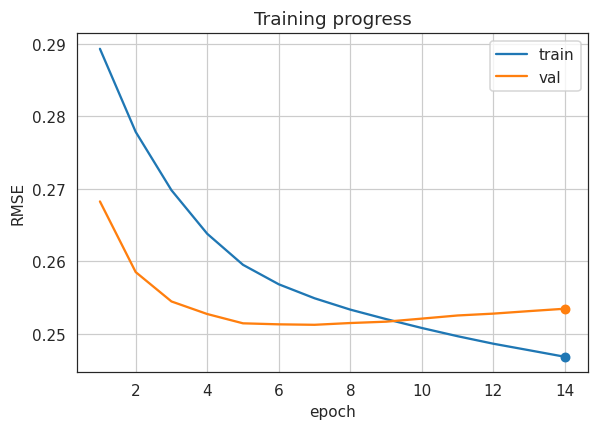

Epoch 1:   0%|          | 0/60 [00:02<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2893 MAE=0.2222 R2=0.0036 | Acc=0.7136 Prec=0.3772 Rec=0.0773 F1=0.1284 AUROC=0.5815
VALID→ RMSE=0.2683 MAE=0.1847 R2=0.1142 | Acc=0.7214 Prec=0.7668 Rec=0.0093 F1=0.0185 AUROC=0.7211


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2779 MAE=0.2128 R2=0.0810 | Acc=0.7225 Prec=0.4730 Rec=0.1568 F1=0.2356 AUROC=0.6119
VALID→ RMSE=0.2585 MAE=0.1814 R2=0.1775 | Acc=0.7375 Prec=0.7609 Rec=0.0930 F1=0.1658 AUROC=0.7405


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2698 MAE=0.2065 R2=0.1334 | Acc=0.7403 Prec=0.5685 Rec=0.1975 F1=0.2932 AUROC=0.6577
VALID→ RMSE=0.2545 MAE=0.1808 R2=0.2030 | Acc=0.7496 Prec=0.7263 Rec=0.1720 F1=0.2781 AUROC=0.7447


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2638 MAE=0.2013 R2=0.1716 | Acc=0.7498 Prec=0.6039 Rec=0.2397 F1=0.3432 AUROC=0.6938
VALID→ RMSE=0.2527 MAE=0.1817 R2=0.2139 | Acc=0.7552 Prec=0.7031 Rec=0.2199 F1=0.3350 AUROC=0.7449


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2595 MAE=0.1975 R2=0.1983 | Acc=0.7552 Prec=0.6177 Rec=0.2682 F1=0.3740 AUROC=0.7173
VALID→ RMSE=0.2514 MAE=0.1830 R2=0.2218 | Acc=0.7568 Prec=0.6835 Rec=0.2471 F1=0.3630 AUROC=0.7439


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2568 MAE=0.1956 R2=0.2148 | Acc=0.7578 Prec=0.6190 Rec=0.2909 F1=0.3958 AUROC=0.7295
VALID→ RMSE=0.2513 MAE=0.1834 R2=0.2227 | Acc=0.7570 Prec=0.6751 Rec=0.2575 F1=0.3728 AUROC=0.7428


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2549 MAE=0.1939 R2=0.2266 | Acc=0.7598 Prec=0.6232 Rec=0.3013 F1=0.4062 AUROC=0.7378
VALID→ RMSE=0.2512 MAE=0.1836 R2=0.2231 | Acc=0.7571 Prec=0.6738 Rec=0.2597 F1=0.3749 AUROC=0.7423


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2533 MAE=0.1925 R2=0.2360 | Acc=0.7616 Prec=0.6274 Rec=0.3093 F1=0.4144 AUROC=0.7442
VALID→ RMSE=0.2515 MAE=0.1838 R2=0.2216 | Acc=0.7570 Prec=0.6752 Rec=0.2571 F1=0.3724 AUROC=0.7418


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2520 MAE=0.1914 R2=0.2439 | Acc=0.7627 Prec=0.6291 Rec=0.3162 F1=0.4208 AUROC=0.7489
VALID→ RMSE=0.2517 MAE=0.1838 R2=0.2204 | Acc=0.7568 Prec=0.6779 Rec=0.2531 F1=0.3685 AUROC=0.7417


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2508 MAE=0.1903 R2=0.2512 | Acc=0.7640 Prec=0.6315 Rec=0.3224 F1=0.4269 AUROC=0.7532
VALID→ RMSE=0.2521 MAE=0.1838 R2=0.2178 | Acc=0.7566 Prec=0.6829 Rec=0.2463 F1=0.3621 AUROC=0.7416


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2497 MAE=0.1893 R2=0.2580 | Acc=0.7651 Prec=0.6338 Rec=0.3281 F1=0.4324 AUROC=0.7572
VALID→ RMSE=0.2525 MAE=0.1836 R2=0.2151 | Acc=0.7561 Prec=0.6844 Rec=0.2414 F1=0.3569 AUROC=0.7417


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.2486 MAE=0.1884 R2=0.2642 | Acc=0.7665 Prec=0.6367 Rec=0.3343 F1=0.4384 AUROC=0.7604
VALID→ RMSE=0.2528 MAE=0.1836 R2=0.2135 | Acc=0.7555 Prec=0.6824 Rec=0.2395 F1=0.3545 AUROC=0.7419


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.2477 MAE=0.1877 R2=0.2695 | Acc=0.7676 Prec=0.6387 Rec=0.3401 F1=0.4438 AUROC=0.7633
VALID→ RMSE=0.2531 MAE=0.1840 R2=0.2114 | Acc=0.7547 Prec=0.6785 Rec=0.2379 F1=0.3523 AUROC=0.7411


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ RMSE=0.2468 MAE=0.1870 R2=0.2748 | Acc=0.7687 Prec=0.6407 Rec=0.3454 F1=0.4488 AUROC=0.7660
VALID→ RMSE=0.2535 MAE=0.1848 R2=0.2093 | Acc=0.7541 Prec=0.6716 Rec=0.2409 F1=0.3546 AUROC=0.7395
Early stopping at epoch 14
✅ Final best model (_fin) saved: AAPL_0.25124_fin.pth
Delete variables to free memory...


[I 2025-09-23 05:59:21,697] Trial 47 finished with value: 0.2512436807155609 and parameters: {'look_back': 90, 'DROPOUT_SHORT': 0.2759762497475127, 'DROPOUT_LONG': 0.2955892738598418, 'ATT_DROPOUT': 0.3373576396156296, 'INITIAL_LR': 0.00021656141919641889, 'ETA_MIN': 8.802049088629063e-06, 'WEIGHT_DECAY': 0.00040163076966945235, 'CLIPNORM': 7.611036138562495}. Best is trial 32 with value: 0.2442263513803482.



▶ Trial 48 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.057022454614040735, 'DROPOUT_LONG': 0.26812801647753054, 'ATT_DROPOUT': 0.2893312043758849, 'INITIAL_LR': 0.0008140837459562894, 'ETA_MIN': 7.495576726734549e-06, 'WEIGHT_DECAY': 0.0008095747969488297, 'CLIPNORM': 9.434607011700523}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


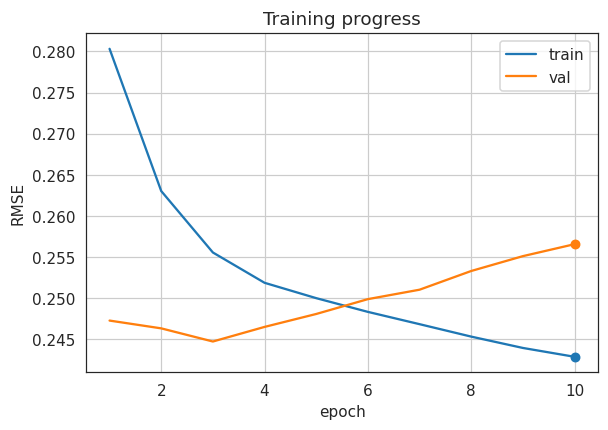

Epoch 1:   0%|          | 0/60 [00:03<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2803 MAE=0.2138 R2=0.0654 | Acc=0.7132 Prec=0.4286 Rec=0.2061 F1=0.2783 AUROC=0.6461
VALID→ RMSE=0.2473 MAE=0.1870 R2=0.2375 | Acc=0.7611 Prec=0.6726 Rec=0.2465 F1=0.3607 AUROC=0.7391


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2630 MAE=0.2010 R2=0.1771 | Acc=0.7564 Prec=0.6024 Rec=0.2712 F1=0.3740 AUROC=0.7154
VALID→ RMSE=0.2463 MAE=0.1818 R2=0.2433 | Acc=0.7639 Prec=0.6724 Rec=0.2661 F1=0.3813 AUROC=0.7458


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2556 MAE=0.1941 R2=0.2232 | Acc=0.7623 Prec=0.6222 Rec=0.2912 F1=0.3967 AUROC=0.7383
VALID→ RMSE=0.2447 MAE=0.1850 R2=0.2531 | Acc=0.7657 Prec=0.6647 Rec=0.2892 F1=0.4030 AUROC=0.7497


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2519 MAE=0.1912 R2=0.2454 | Acc=0.7660 Prec=0.6319 Rec=0.3065 F1=0.4128 AUROC=0.7505
VALID→ RMSE=0.2465 MAE=0.1811 R2=0.2422 | Acc=0.7645 Prec=0.6870 Rec=0.2549 F1=0.3718 AUROC=0.7498


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2500 MAE=0.1890 R2=0.2566 | Acc=0.7683 Prec=0.6400 Rec=0.3122 F1=0.4196 AUROC=0.7574
VALID→ RMSE=0.2481 MAE=0.1810 R2=0.2325 | Acc=0.7622 Prec=0.6878 Rec=0.2387 F1=0.3544 AUROC=0.7478


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2483 MAE=0.1873 R2=0.2664 | Acc=0.7703 Prec=0.6454 Rec=0.3201 F1=0.4279 AUROC=0.7629
VALID→ RMSE=0.2499 MAE=0.1814 R2=0.2213 | Acc=0.7594 Prec=0.6704 Rec=0.2366 F1=0.3498 AUROC=0.7450


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2469 MAE=0.1860 R2=0.2752 | Acc=0.7718 Prec=0.6474 Rec=0.3289 F1=0.4362 AUROC=0.7677
VALID→ RMSE=0.2510 MAE=0.1838 R2=0.2142 | Acc=0.7553 Prec=0.6293 Rec=0.2558 F1=0.3637 AUROC=0.7412


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2453 MAE=0.1847 R2=0.2841 | Acc=0.7738 Prec=0.6521 Rec=0.3371 F1=0.4444 AUROC=0.7721
VALID→ RMSE=0.2533 MAE=0.1884 R2=0.1999 | Acc=0.7501 Prec=0.5863 Rec=0.2934 F1=0.3910 AUROC=0.7348


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2440 MAE=0.1838 R2=0.2921 | Acc=0.7754 Prec=0.6531 Rec=0.3477 F1=0.4538 AUROC=0.7762
VALID→ RMSE=0.2551 MAE=0.1918 R2=0.1884 | Acc=0.7465 Prec=0.5638 Rec=0.3216 F1=0.4096 AUROC=0.7318


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2429 MAE=0.1828 R2=0.2983 | Acc=0.7768 Prec=0.6553 Rec=0.3553 F1=0.4608 AUROC=0.7794
VALID→ RMSE=0.2566 MAE=0.1924 R2=0.1792 | Acc=0.7454 Prec=0.5604 Rec=0.3208 F1=0.4080 AUROC=0.7287
Early stopping at epoch 10
✅ Final best model (_fin) saved: AAPL_0.24475_fin.pth
Delete variables to free memory...


[I 2025-09-23 06:17:37,488] Trial 48 finished with value: 0.24474532902240753 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.057022454614040735, 'DROPOUT_LONG': 0.26812801647753054, 'ATT_DROPOUT': 0.2893312043758849, 'INITIAL_LR': 0.0008140837459562894, 'ETA_MIN': 7.495576726734549e-06, 'WEIGHT_DECAY': 0.0008095747969488297, 'CLIPNORM': 9.434607011700523}. Best is trial 32 with value: 0.2442263513803482.



▶ Trial 49 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.13254108038883256, 'DROPOUT_LONG': 0.23753841416304272, 'ATT_DROPOUT': 0.2938117504311157, 'INITIAL_LR': 0.0008176083126894481, 'ETA_MIN': 7.530454999628014e-06, 'WEIGHT_DECAY': 0.0007865854803086249, 'CLIPNORM': 9.91671373481908}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


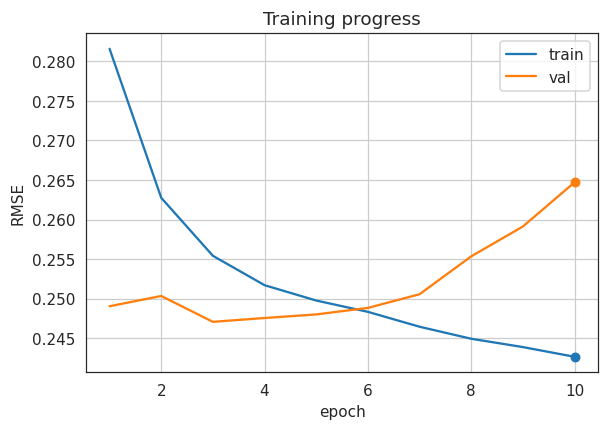

Epoch 1:   0%|          | 0/60 [00:04<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2816 MAE=0.2142 R2=0.0569 | Acc=0.7143 Prec=0.4482 Rec=0.2789 F1=0.3439 AUROC=0.6558
VALID→ RMSE=0.2490 MAE=0.1868 R2=0.2267 | Acc=0.7598 Prec=0.7067 Rec=0.2078 F1=0.3211 AUROC=0.7440


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2627 MAE=0.2005 R2=0.1789 | Acc=0.7572 Prec=0.6066 Rec=0.2712 F1=0.3748 AUROC=0.7130
VALID→ RMSE=0.2503 MAE=0.1830 R2=0.2186 | Acc=0.7614 Prec=0.7062 Rec=0.2185 F1=0.3337 AUROC=0.7501


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2554 MAE=0.1939 R2=0.2241 | Acc=0.7632 Prec=0.6249 Rec=0.2941 F1=0.3999 AUROC=0.7380
VALID→ RMSE=0.2471 MAE=0.1895 R2=0.2389 | Acc=0.7636 Prec=0.6603 Rec=0.2791 F1=0.3923 AUROC=0.7501


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2517 MAE=0.1910 R2=0.2465 | Acc=0.7664 Prec=0.6325 Rec=0.3091 F1=0.4152 AUROC=0.7515
VALID→ RMSE=0.2476 MAE=0.1867 R2=0.2359 | Acc=0.7620 Prec=0.6612 Rec=0.2658 F1=0.3792 AUROC=0.7472


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2498 MAE=0.1887 R2=0.2581 | Acc=0.7685 Prec=0.6387 Rec=0.3167 F1=0.4234 AUROC=0.7584
VALID→ RMSE=0.2480 MAE=0.1868 R2=0.2331 | Acc=0.7599 Prec=0.6356 Rec=0.2858 F1=0.3943 AUROC=0.7452


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2483 MAE=0.1875 R2=0.2665 | Acc=0.7703 Prec=0.6418 Rec=0.3263 F1=0.4326 AUROC=0.7631
VALID→ RMSE=0.2488 MAE=0.1878 R2=0.2280 | Acc=0.7572 Prec=0.6161 Rec=0.2977 F1=0.4014 AUROC=0.7440


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2464 MAE=0.1860 R2=0.2776 | Acc=0.7722 Prec=0.6453 Rec=0.3361 F1=0.4420 AUROC=0.7686
VALID→ RMSE=0.2506 MAE=0.1919 R2=0.2172 | Acc=0.7513 Prec=0.5816 Rec=0.3223 F1=0.4148 AUROC=0.7415


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2449 MAE=0.1848 R2=0.2865 | Acc=0.7741 Prec=0.6496 Rec=0.3438 F1=0.4496 AUROC=0.7727
VALID→ RMSE=0.2553 MAE=0.1950 R2=0.1870 | Acc=0.7418 Prec=0.5485 Rec=0.3165 F1=0.4014 AUROC=0.7333


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2439 MAE=0.1837 R2=0.2926 | Acc=0.7757 Prec=0.6538 Rec=0.3493 F1=0.4553 AUROC=0.7756
VALID→ RMSE=0.2591 MAE=0.1973 R2=0.1628 | Acc=0.7358 Prec=0.5288 Rec=0.3112 F1=0.3918 AUROC=0.7261


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2426 MAE=0.1826 R2=0.2997 | Acc=0.7775 Prec=0.6582 Rec=0.3557 F1=0.4618 AUROC=0.7787
VALID→ RMSE=0.2647 MAE=0.1989 R2=0.1263 | Acc=0.7311 Prec=0.5153 Rec=0.2822 F1=0.3647 AUROC=0.7146
Early stopping at epoch 10
✅ Final best model (_fin) saved: AAPL_0.24707_fin.pth
Delete variables to free memory...


[I 2025-09-23 06:34:15,946] Trial 49 finished with value: 0.24706800282001495 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.13254108038883256, 'DROPOUT_LONG': 0.23753841416304272, 'ATT_DROPOUT': 0.2938117504311157, 'INITIAL_LR': 0.0008176083126894481, 'ETA_MIN': 7.530454999628014e-06, 'WEIGHT_DECAY': 0.0007865854803086249, 'CLIPNORM': 9.91671373481908}. Best is trial 32 with value: 0.2442263513803482.



▶ Trial 50 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.09400470284630238, 'DROPOUT_LONG': 0.26916779356017717, 'ATT_DROPOUT': 0.2698365037758368, 'INITIAL_LR': 8.39638268754243e-05, 'ETA_MIN': 1.1580385471973982e-06, 'WEIGHT_DECAY': 0.0011239492966490306, 'CLIPNORM': 9.226549970230511}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


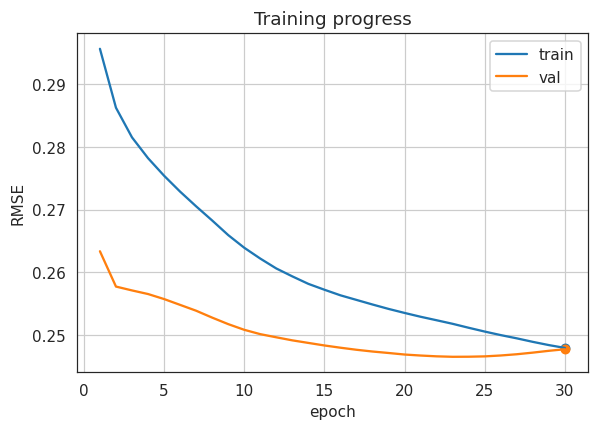

Epoch 1:   0%|          | 0/60 [00:03<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2956 MAE=0.2283 R2=-0.0394 | Acc=0.6990 Prec=0.3480 Rec=0.1391 F1=0.1988 AUROC=0.5710
VALID→ RMSE=0.2634 MAE=0.1860 R2=0.1351 | Acc=0.7265 Prec=0.0000 Rec=0.0000 F1=0.0000 AUROC=0.6860


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2862 MAE=0.2197 R2=0.0255 | Acc=0.7310 Prec=0.4500 Rec=0.0109 F1=0.0212 AUROC=0.5321
VALID→ RMSE=0.2577 MAE=0.1830 R2=0.1716 | Acc=0.7282 Prec=0.9257 Rec=0.0064 F1=0.0127 AUROC=0.7181


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2815 MAE=0.2160 R2=0.0574 | Acc=0.7325 Prec=0.5277 Rec=0.0317 F1=0.0599 AUROC=0.5763
VALID→ RMSE=0.2571 MAE=0.1825 R2=0.1756 | Acc=0.7443 Prec=0.7283 Rec=0.1036 F1=0.1813 AUROC=0.7297


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2782 MAE=0.2135 R2=0.0795 | Acc=0.7356 Prec=0.5627 Rec=0.0671 F1=0.1199 AUROC=0.6098
VALID→ RMSE=0.2566 MAE=0.1822 R2=0.1793 | Acc=0.7540 Prec=0.6733 Rec=0.1948 F1=0.3022 AUROC=0.7343


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2754 MAE=0.2113 R2=0.0979 | Acc=0.7397 Prec=0.5819 Rec=0.1070 F1=0.1807 AUROC=0.6333
VALID→ RMSE=0.2558 MAE=0.1822 R2=0.1844 | Acc=0.7570 Prec=0.6495 Rec=0.2419 F1=0.3525 AUROC=0.7363


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2729 MAE=0.2095 R2=0.1144 | Acc=0.7431 Prec=0.5875 Rec=0.1436 F1=0.2308 AUROC=0.6500
VALID→ RMSE=0.2548 MAE=0.1821 R2=0.1903 | Acc=0.7577 Prec=0.6359 Rec=0.2665 F1=0.3756 AUROC=0.7375


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2705 MAE=0.2076 R2=0.1295 | Acc=0.7463 Prec=0.5950 Rec=0.1716 F1=0.2664 AUROC=0.6631
VALID→ RMSE=0.2539 MAE=0.1822 R2=0.1962 | Acc=0.7580 Prec=0.6298 Rec=0.2790 F1=0.3867 AUROC=0.7387


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2683 MAE=0.2057 R2=0.1440 | Acc=0.7490 Prec=0.6015 Rec=0.1916 F1=0.2907 AUROC=0.6743
VALID→ RMSE=0.2528 MAE=0.1825 R2=0.2031 | Acc=0.7584 Prec=0.6286 Rec=0.2846 F1=0.3918 AUROC=0.7396


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2659 MAE=0.2037 R2=0.1588 | Acc=0.7514 Prec=0.6079 Rec=0.2079 F1=0.3099 AUROC=0.6849
VALID→ RMSE=0.2518 MAE=0.1829 R2=0.2096 | Acc=0.7586 Prec=0.6288 Rec=0.2862 F1=0.3933 AUROC=0.7404


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2639 MAE=0.2019 R2=0.1715 | Acc=0.7537 Prec=0.6145 Rec=0.2208 F1=0.3249 AUROC=0.6939
VALID→ RMSE=0.2509 MAE=0.1834 R2=0.2153 | Acc=0.7589 Prec=0.6290 Rec=0.2880 F1=0.3951 AUROC=0.7412


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2622 MAE=0.2003 R2=0.1823 | Acc=0.7556 Prec=0.6202 Rec=0.2306 F1=0.3362 AUROC=0.7017
VALID→ RMSE=0.2502 MAE=0.1838 R2=0.2196 | Acc=0.7590 Prec=0.6290 Rec=0.2889 F1=0.3960 AUROC=0.7419


Epoch 12:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 012
TRAIN→ RMSE=0.2606 MAE=0.1990 R2=0.1921 | Acc=0.7572 Prec=0.6246 Rec=0.2391 F1=0.3458 AUROC=0.7091
VALID→ RMSE=0.2497 MAE=0.1840 R2=0.2228 | Acc=0.7592 Prec=0.6292 Rec=0.2906 F1=0.3976 AUROC=0.7427


Epoch 13:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 013
TRAIN→ RMSE=0.2594 MAE=0.1978 R2=0.1999 | Acc=0.7585 Prec=0.6269 Rec=0.2470 F1=0.3544 AUROC=0.7153
VALID→ RMSE=0.2492 MAE=0.1842 R2=0.2258 | Acc=0.7596 Prec=0.6300 Rec=0.2926 F1=0.3996 AUROC=0.7435


Epoch 14:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 014
TRAIN→ RMSE=0.2582 MAE=0.1966 R2=0.2072 | Acc=0.7597 Prec=0.6296 Rec=0.2542 F1=0.3621 AUROC=0.7209
VALID→ RMSE=0.2488 MAE=0.1844 R2=0.2283 | Acc=0.7598 Prec=0.6308 Rec=0.2933 F1=0.4004 AUROC=0.7441


Epoch 15:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 015
TRAIN→ RMSE=0.2572 MAE=0.1957 R2=0.2129 | Acc=0.7607 Prec=0.6316 Rec=0.2602 F1=0.3686 AUROC=0.7252
VALID→ RMSE=0.2484 MAE=0.1845 R2=0.2308 | Acc=0.7601 Prec=0.6317 Rec=0.2943 F1=0.4015 AUROC=0.7447


Epoch 16:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 016
TRAIN→ RMSE=0.2564 MAE=0.1949 R2=0.2184 | Acc=0.7617 Prec=0.6334 Rec=0.2657 F1=0.3743 AUROC=0.7292
VALID→ RMSE=0.2480 MAE=0.1848 R2=0.2331 | Acc=0.7605 Prec=0.6323 Rec=0.2964 F1=0.4036 AUROC=0.7451


Epoch 17:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 017
TRAIN→ RMSE=0.2556 MAE=0.1942 R2=0.2228 | Acc=0.7623 Prec=0.6334 Rec=0.2709 F1=0.3795 AUROC=0.7328
VALID→ RMSE=0.2477 MAE=0.1850 R2=0.2351 | Acc=0.7608 Prec=0.6334 Rec=0.2975 F1=0.4049 AUROC=0.7454


Epoch 18:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 018
TRAIN→ RMSE=0.2549 MAE=0.1936 R2=0.2273 | Acc=0.7629 Prec=0.6339 Rec=0.2756 F1=0.3842 AUROC=0.7361
VALID→ RMSE=0.2474 MAE=0.1852 R2=0.2368 | Acc=0.7612 Prec=0.6347 Rec=0.2984 F1=0.4059 AUROC=0.7459


Epoch 19:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 019
TRAIN→ RMSE=0.2542 MAE=0.1930 R2=0.2315 | Acc=0.7634 Prec=0.6341 Rec=0.2803 F1=0.3888 AUROC=0.7392
VALID→ RMSE=0.2472 MAE=0.1854 R2=0.2382 | Acc=0.7615 Prec=0.6354 Rec=0.2996 F1=0.4072 AUROC=0.7463


Epoch 20:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 020
TRAIN→ RMSE=0.2535 MAE=0.1924 R2=0.2354 | Acc=0.7640 Prec=0.6343 Rec=0.2851 F1=0.3934 AUROC=0.7419
VALID→ RMSE=0.2469 MAE=0.1857 R2=0.2398 | Acc=0.7616 Prec=0.6352 Rec=0.3016 F1=0.4090 AUROC=0.7467


Epoch 21:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 021
TRAIN→ RMSE=0.2529 MAE=0.1919 R2=0.2390 | Acc=0.7644 Prec=0.6340 Rec=0.2888 F1=0.3969 AUROC=0.7443
VALID→ RMSE=0.2468 MAE=0.1859 R2=0.2407 | Acc=0.7618 Prec=0.6353 Rec=0.3024 F1=0.4097 AUROC=0.7471


Epoch 22:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 022
TRAIN→ RMSE=0.2524 MAE=0.1914 R2=0.2424 | Acc=0.7652 Prec=0.6352 Rec=0.2937 F1=0.4017 AUROC=0.7465
VALID→ RMSE=0.2466 MAE=0.1860 R2=0.2415 | Acc=0.7620 Prec=0.6361 Rec=0.3029 F1=0.4103 AUROC=0.7475


Epoch 23:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 023
TRAIN→ RMSE=0.2518 MAE=0.1909 R2=0.2458 | Acc=0.7656 Prec=0.6351 Rec=0.2974 F1=0.4051 AUROC=0.7487
VALID→ RMSE=0.2466 MAE=0.1863 R2=0.2420 | Acc=0.7622 Prec=0.6366 Rec=0.3035 F1=0.4111 AUROC=0.7479


Epoch 24:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 024
TRAIN→ RMSE=0.2512 MAE=0.1903 R2=0.2496 | Acc=0.7663 Prec=0.6364 Rec=0.3012 F1=0.4089 AUROC=0.7511
VALID→ RMSE=0.2466 MAE=0.1867 R2=0.2419 | Acc=0.7622 Prec=0.6356 Rec=0.3060 F1=0.4131 AUROC=0.7481


Epoch 25:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 025
TRAIN→ RMSE=0.2506 MAE=0.1898 R2=0.2532 | Acc=0.7669 Prec=0.6366 Rec=0.3059 F1=0.4132 AUROC=0.7530
VALID→ RMSE=0.2466 MAE=0.1871 R2=0.2416 | Acc=0.7623 Prec=0.6351 Rec=0.3076 F1=0.4145 AUROC=0.7483


Epoch 26:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 026
TRAIN→ RMSE=0.2500 MAE=0.1893 R2=0.2565 | Acc=0.7675 Prec=0.6372 Rec=0.3102 F1=0.4172 AUROC=0.7550
VALID→ RMSE=0.2468 MAE=0.1873 R2=0.2407 | Acc=0.7625 Prec=0.6352 Rec=0.3089 F1=0.4156 AUROC=0.7482


Epoch 27:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 027
TRAIN→ RMSE=0.2495 MAE=0.1888 R2=0.2596 | Acc=0.7681 Prec=0.6376 Rec=0.3146 F1=0.4214 AUROC=0.7571
VALID→ RMSE=0.2470 MAE=0.1874 R2=0.2395 | Acc=0.7626 Prec=0.6351 Rec=0.3096 F1=0.4163 AUROC=0.7481


Epoch 28:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 028
TRAIN→ RMSE=0.2489 MAE=0.1883 R2=0.2629 | Acc=0.7688 Prec=0.6386 Rec=0.3189 F1=0.4254 AUROC=0.7587
VALID→ RMSE=0.2472 MAE=0.1875 R2=0.2379 | Acc=0.7626 Prec=0.6349 Rec=0.3101 F1=0.4167 AUROC=0.7476


Epoch 29:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 029
TRAIN→ RMSE=0.2484 MAE=0.1879 R2=0.2660 | Acc=0.7693 Prec=0.6389 Rec=0.3229 F1=0.4290 AUROC=0.7606
VALID→ RMSE=0.2475 MAE=0.1874 R2=0.2361 | Acc=0.7625 Prec=0.6351 Rec=0.3090 F1=0.4157 AUROC=0.7469


Epoch 30:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 030
TRAIN→ RMSE=0.2480 MAE=0.1875 R2=0.2686 | Acc=0.7697 Prec=0.6391 Rec=0.3260 F1=0.4318 AUROC=0.7620
VALID→ RMSE=0.2478 MAE=0.1873 R2=0.2346 | Acc=0.7625 Prec=0.6348 Rec=0.3094 F1=0.4161 AUROC=0.7462
Early stopping at epoch 30
✅ Final best model (_fin) saved: AAPL_0.24656_fin.pth
Delete variables to free memory...


[I 2025-09-23 07:04:25,273] Trial 50 finished with value: 0.24656330049037933 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.09400470284630238, 'DROPOUT_LONG': 0.26916779356017717, 'ATT_DROPOUT': 0.2698365037758368, 'INITIAL_LR': 8.39638268754243e-05, 'ETA_MIN': 1.1580385471973982e-06, 'WEIGHT_DECAY': 0.0011239492966490306, 'CLIPNORM': 9.226549970230511}. Best is trial 32 with value: 0.2442263513803482.



▶ Trial 51 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.0831062778116389, 'DROPOUT_LONG': 0.33806382821131403, 'ATT_DROPOUT': 0.31313724946239135, 'INITIAL_LR': 0.0009942389241539092, 'ETA_MIN': 6.385239554456597e-06, 'WEIGHT_DECAY': 0.00018036738120377088, 'CLIPNORM': 8.123702034873652}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


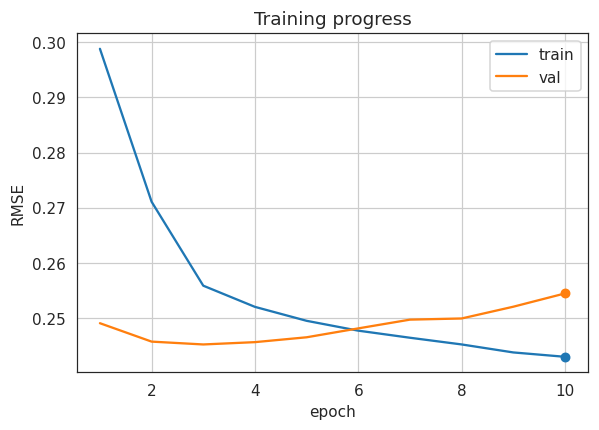

Epoch 1:   0%|          | 0/60 [00:03<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2988 MAE=0.2287 R2=-0.0618 | Acc=0.6814 Prec=0.3424 Rec=0.2030 F1=0.2549 AUROC=0.5982
VALID→ RMSE=0.2491 MAE=0.1830 R2=0.2264 | Acc=0.7600 Prec=0.6642 Rec=0.2473 F1=0.3604 AUROC=0.7386


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2711 MAE=0.2089 R2=0.1260 | Acc=0.7499 Prec=0.5786 Rec=0.2513 F1=0.3504 AUROC=0.6898
VALID→ RMSE=0.2457 MAE=0.1889 R2=0.2470 | Acc=0.7656 Prec=0.6343 Rec=0.3376 F1=0.4407 AUROC=0.7498


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2559 MAE=0.1953 R2=0.2213 | Acc=0.7626 Prec=0.6202 Rec=0.2979 F1=0.4025 AUROC=0.7369
VALID→ RMSE=0.2452 MAE=0.1868 R2=0.2502 | Acc=0.7654 Prec=0.6368 Rec=0.3302 F1=0.4349 AUROC=0.7525


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2520 MAE=0.1914 R2=0.2445 | Acc=0.7671 Prec=0.6351 Rec=0.3106 F1=0.4172 AUROC=0.7498
VALID→ RMSE=0.2456 MAE=0.1836 R2=0.2476 | Acc=0.7657 Prec=0.6563 Rec=0.3008 F1=0.4125 AUROC=0.7534


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2495 MAE=0.1892 R2=0.2595 | Acc=0.7698 Prec=0.6424 Rec=0.3211 F1=0.4281 AUROC=0.7581
VALID→ RMSE=0.2465 MAE=0.1844 R2=0.2422 | Acc=0.7641 Prec=0.6564 Rec=0.2885 F1=0.4008 AUROC=0.7511


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2477 MAE=0.1873 R2=0.2701 | Acc=0.7718 Prec=0.6476 Rec=0.3285 F1=0.4359 AUROC=0.7638
VALID→ RMSE=0.2481 MAE=0.1851 R2=0.2323 | Acc=0.7614 Prec=0.6439 Rec=0.2852 F1=0.3953 AUROC=0.7459


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2464 MAE=0.1861 R2=0.2776 | Acc=0.7731 Prec=0.6484 Rec=0.3374 F1=0.4439 AUROC=0.7679
VALID→ RMSE=0.2497 MAE=0.1875 R2=0.2224 | Acc=0.7598 Prec=0.6245 Rec=0.3047 F1=0.4096 AUROC=0.7402


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2452 MAE=0.1849 R2=0.2847 | Acc=0.7742 Prec=0.6486 Rec=0.3461 F1=0.4514 AUROC=0.7718
VALID→ RMSE=0.2499 MAE=0.1902 R2=0.2211 | Acc=0.7577 Prec=0.6028 Rec=0.3338 F1=0.4297 AUROC=0.7400


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2438 MAE=0.1838 R2=0.2932 | Acc=0.7760 Prec=0.6518 Rec=0.3554 F1=0.4600 AUROC=0.7763
VALID→ RMSE=0.2521 MAE=0.1914 R2=0.2078 | Acc=0.7532 Prec=0.5842 Rec=0.3386 F1=0.4287 AUROC=0.7342


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2430 MAE=0.1833 R2=0.2977 | Acc=0.7768 Prec=0.6500 Rec=0.3647 F1=0.4672 AUROC=0.7787
VALID→ RMSE=0.2545 MAE=0.1943 R2=0.1926 | Acc=0.7484 Prec=0.5653 Rec=0.3459 F1=0.4292 AUROC=0.7287
Early stopping at epoch 10
✅ Final best model (_fin) saved: AAPL_0.24523_fin.pth
Delete variables to free memory...


[I 2025-09-23 07:19:54,592] Trial 51 finished with value: 0.2452274113893509 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.0831062778116389, 'DROPOUT_LONG': 0.33806382821131403, 'ATT_DROPOUT': 0.31313724946239135, 'INITIAL_LR': 0.0009942389241539092, 'ETA_MIN': 6.385239554456597e-06, 'WEIGHT_DECAY': 0.00018036738120377088, 'CLIPNORM': 8.123702034873652}. Best is trial 32 with value: 0.2442263513803482.



▶ Trial 52 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.05836826117770111, 'DROPOUT_LONG': 0.29051269645484395, 'ATT_DROPOUT': 0.3105593065028529, 'INITIAL_LR': 0.0009136423652402616, 'ETA_MIN': 6.423741242953866e-06, 'WEIGHT_DECAY': 0.0001702487979751773, 'CLIPNORM': 8.129422943406746}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


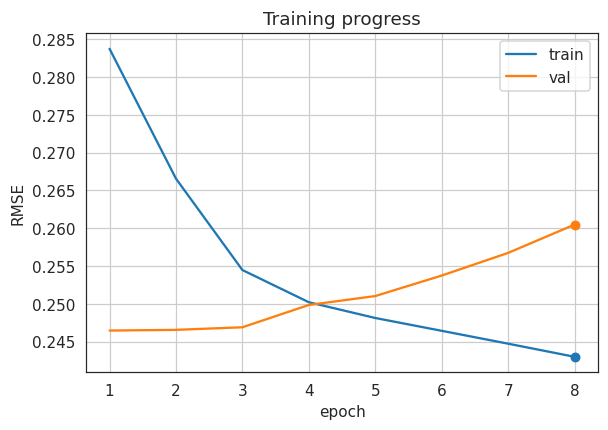

Epoch 1:   0%|          | 0/60 [00:06<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2837 MAE=0.2164 R2=0.0424 | Acc=0.7124 Prec=0.4244 Rec=0.2009 F1=0.2727 AUROC=0.6358
VALID→ RMSE=0.2465 MAE=0.1888 R2=0.2426 | Acc=0.7636 Prec=0.6659 Rec=0.2721 F1=0.3863 AUROC=0.7444


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2666 MAE=0.2052 R2=0.1549 | Acc=0.7532 Prec=0.5822 Rec=0.2852 F1=0.3829 AUROC=0.7066
VALID→ RMSE=0.2466 MAE=0.1859 R2=0.2420 | Acc=0.7649 Prec=0.6311 Rec=0.3375 F1=0.4398 AUROC=0.7453


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2545 MAE=0.1939 R2=0.2298 | Acc=0.7632 Prec=0.6168 Rec=0.3109 F1=0.4135 AUROC=0.7412
VALID→ RMSE=0.2469 MAE=0.1862 R2=0.2399 | Acc=0.7624 Prec=0.6237 Rec=0.3305 F1=0.4320 AUROC=0.7482


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2502 MAE=0.1892 R2=0.2554 | Acc=0.7682 Prec=0.6349 Rec=0.3208 F1=0.4263 AUROC=0.7556
VALID→ RMSE=0.2498 MAE=0.1862 R2=0.2217 | Acc=0.7575 Prec=0.6153 Rec=0.3021 F1=0.4052 AUROC=0.7444


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2481 MAE=0.1873 R2=0.2678 | Acc=0.7702 Prec=0.6409 Rec=0.3268 F1=0.4329 AUROC=0.7630
VALID→ RMSE=0.2510 MAE=0.1877 R2=0.2143 | Acc=0.7548 Prec=0.6007 Rec=0.3084 F1=0.4075 AUROC=0.7415


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2464 MAE=0.1859 R2=0.2777 | Acc=0.7724 Prec=0.6457 Rec=0.3366 F1=0.4425 AUROC=0.7685
VALID→ RMSE=0.2537 MAE=0.1903 R2=0.1972 | Acc=0.7508 Prec=0.5815 Rec=0.3166 F1=0.4100 AUROC=0.7327


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2447 MAE=0.1844 R2=0.2877 | Acc=0.7747 Prec=0.6503 Rec=0.3469 F1=0.4525 AUROC=0.7739
VALID→ RMSE=0.2567 MAE=0.1925 R2=0.1781 | Acc=0.7472 Prec=0.5664 Rec=0.3220 F1=0.4106 AUROC=0.7245


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2430 MAE=0.1831 R2=0.2978 | Acc=0.7769 Prec=0.6525 Rec=0.3606 F1=0.4645 AUROC=0.7791
VALID→ RMSE=0.2605 MAE=0.1932 R2=0.1540 | Acc=0.7437 Prec=0.5530 Rec=0.3275 F1=0.4114 AUROC=0.7208
Early stopping at epoch 8
✅ Final best model (_fin) saved: AAPL_0.24646_fin.pth
Delete variables to free memory...


[I 2025-09-23 07:33:04,607] Trial 52 finished with value: 0.24645905196666718 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.05836826117770111, 'DROPOUT_LONG': 0.29051269645484395, 'ATT_DROPOUT': 0.3105593065028529, 'INITIAL_LR': 0.0009136423652402616, 'ETA_MIN': 6.423741242953866e-06, 'WEIGHT_DECAY': 0.0001702487979751773, 'CLIPNORM': 8.129422943406746}. Best is trial 32 with value: 0.2442263513803482.



▶ Trial 53 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.09968781982716221, 'DROPOUT_LONG': 0.30617687611129324, 'ATT_DROPOUT': 0.29158385433091266, 'INITIAL_LR': 0.000728519424801294, 'ETA_MIN': 5.148350567769447e-06, 'WEIGHT_DECAY': 0.0005141586946581827, 'CLIPNORM': 8.865263281356167}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


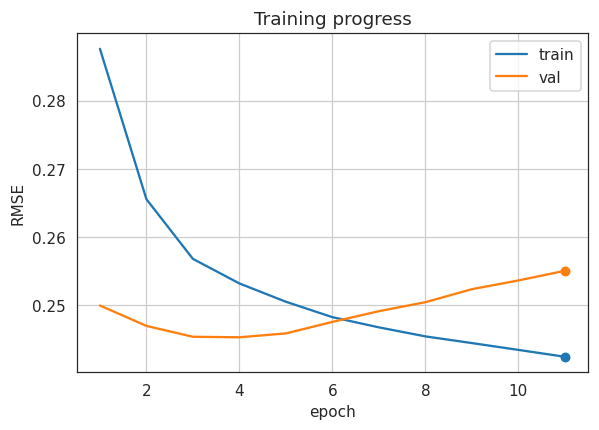

Epoch 1:   0%|          | 0/60 [00:05<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2876 MAE=0.2197 R2=0.0164 | Acc=0.7114 Prec=0.4230 Rec=0.2064 F1=0.2774 AUROC=0.6343
VALID→ RMSE=0.2500 MAE=0.1888 R2=0.2208 | Acc=0.7612 Prec=0.6428 Rec=0.2853 F1=0.3952 AUROC=0.7428


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2656 MAE=0.2022 R2=0.1613 | Acc=0.7533 Prec=0.5951 Rec=0.2529 F1=0.3550 AUROC=0.7065
VALID→ RMSE=0.2470 MAE=0.1862 R2=0.2393 | Acc=0.7636 Prec=0.6387 Rec=0.3119 F1=0.4191 AUROC=0.7485


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2568 MAE=0.1955 R2=0.2156 | Acc=0.7614 Prec=0.6207 Rec=0.2853 F1=0.3909 AUROC=0.7346
VALID→ RMSE=0.2454 MAE=0.1869 R2=0.2490 | Acc=0.7650 Prec=0.6320 Rec=0.3370 F1=0.4396 AUROC=0.7522


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2532 MAE=0.1928 R2=0.2374 | Acc=0.7644 Prec=0.6251 Rec=0.3055 F1=0.4104 AUROC=0.7472
VALID→ RMSE=0.2453 MAE=0.1875 R2=0.2495 | Acc=0.7644 Prec=0.6264 Rec=0.3429 F1=0.4432 AUROC=0.7524


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2505 MAE=0.1901 R2=0.2534 | Acc=0.7674 Prec=0.6340 Rec=0.3150 F1=0.4209 AUROC=0.7557
VALID→ RMSE=0.2459 MAE=0.1841 R2=0.2460 | Acc=0.7637 Prec=0.6291 Rec=0.3307 F1=0.4335 AUROC=0.7544


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2483 MAE=0.1880 R2=0.2668 | Acc=0.7699 Prec=0.6393 Rec=0.3269 F1=0.4326 AUROC=0.7627
VALID→ RMSE=0.2476 MAE=0.1885 R2=0.2357 | Acc=0.7589 Prec=0.5989 Rec=0.3580 F1=0.4481 AUROC=0.7515


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2468 MAE=0.1867 R2=0.2756 | Acc=0.7718 Prec=0.6428 Rec=0.3372 F1=0.4423 AUROC=0.7676
VALID→ RMSE=0.2492 MAE=0.1903 R2=0.2259 | Acc=0.7556 Prec=0.5854 Rec=0.3642 F1=0.4491 AUROC=0.7494


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2455 MAE=0.1855 R2=0.2834 | Acc=0.7736 Prec=0.6466 Rec=0.3446 F1=0.4496 AUROC=0.7716
VALID→ RMSE=0.2505 MAE=0.1924 R2=0.2177 | Acc=0.7533 Prec=0.5754 Rec=0.3735 F1=0.4530 AUROC=0.7470


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2445 MAE=0.1846 R2=0.2891 | Acc=0.7752 Prec=0.6502 Rec=0.3511 F1=0.4560 AUROC=0.7745
VALID→ RMSE=0.2524 MAE=0.1938 R2=0.2058 | Acc=0.7506 Prec=0.5652 Rec=0.3810 F1=0.4552 AUROC=0.7441


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2435 MAE=0.1836 R2=0.2949 | Acc=0.7766 Prec=0.6538 Rec=0.3564 F1=0.4614 AUROC=0.7772
VALID→ RMSE=0.2537 MAE=0.1949 R2=0.1977 | Acc=0.7485 Prec=0.5563 Rec=0.3965 F1=0.4630 AUROC=0.7439


Epoch 11:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 011
TRAIN→ RMSE=0.2425 MAE=0.1826 R2=0.3007 | Acc=0.7780 Prec=0.6570 Rec=0.3614 F1=0.4663 AUROC=0.7801
VALID→ RMSE=0.2551 MAE=0.1955 R2=0.1887 | Acc=0.7467 Prec=0.5500 Rec=0.4050 F1=0.4665 AUROC=0.7421
Early stopping at epoch 11
✅ Final best model (_fin) saved: AAPL_0.24533_fin.pth
Delete variables to free memory...


[I 2025-09-23 07:51:53,574] Trial 53 finished with value: 0.24533489346504211 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.09968781982716221, 'DROPOUT_LONG': 0.30617687611129324, 'ATT_DROPOUT': 0.29158385433091266, 'INITIAL_LR': 0.000728519424801294, 'ETA_MIN': 5.148350567769447e-06, 'WEIGHT_DECAY': 0.0005141586946581827, 'CLIPNORM': 8.865263281356167}. Best is trial 32 with value: 0.2442263513803482.



▶ Trial 54 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.07688009821005828, 'DROPOUT_LONG': 0.27875770118994053, 'ATT_DROPOUT': 0.29190144168746895, 'INITIAL_LR': 0.0005066174568436093, 'ETA_MIN': 5.14346198351844e-06, 'WEIGHT_DECAY': 0.0005443797541367974, 'CLIPNORM': 8.936469200186949}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


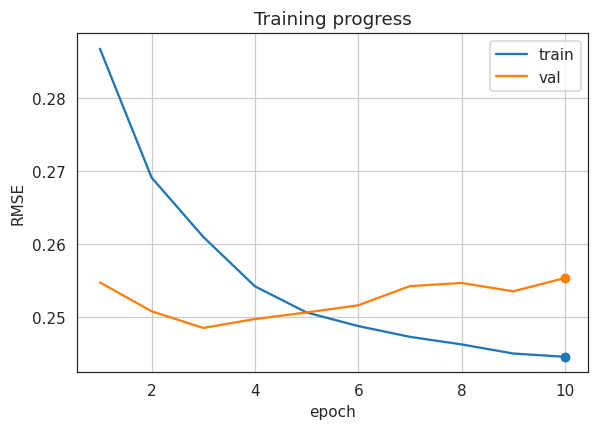

Epoch 1:   0%|          | 0/60 [00:05<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2867 MAE=0.2188 R2=0.0222 | Acc=0.7071 Prec=0.3703 Rec=0.1306 F1=0.1931 AUROC=0.6141
VALID→ RMSE=0.2547 MAE=0.1809 R2=0.1908 | Acc=0.7580 Prec=0.7060 Rec=0.1970 F1=0.3080 AUROC=0.7412


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2691 MAE=0.2041 R2=0.1387 | Acc=0.7489 Prec=0.5855 Rec=0.2200 F1=0.3198 AUROC=0.6901
VALID→ RMSE=0.2508 MAE=0.1834 R2=0.2157 | Acc=0.7618 Prec=0.6752 Rec=0.2482 F1=0.3630 AUROC=0.7409


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2610 MAE=0.2000 R2=0.1899 | Acc=0.7566 Prec=0.5986 Rec=0.2821 F1=0.3835 AUROC=0.7182
VALID→ RMSE=0.2485 MAE=0.1839 R2=0.2299 | Acc=0.7627 Prec=0.6578 Rec=0.2754 F1=0.3882 AUROC=0.7425


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2542 MAE=0.1932 R2=0.2314 | Acc=0.7632 Prec=0.6195 Rec=0.3046 F1=0.4084 AUROC=0.7416
VALID→ RMSE=0.2497 MAE=0.1835 R2=0.2224 | Acc=0.7620 Prec=0.6625 Rec=0.2642 F1=0.3778 AUROC=0.7401


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2506 MAE=0.1900 R2=0.2529 | Acc=0.7675 Prec=0.6325 Rec=0.3188 F1=0.4240 AUROC=0.7545
VALID→ RMSE=0.2506 MAE=0.1845 R2=0.2167 | Acc=0.7599 Prec=0.6591 Rec=0.2530 F1=0.3656 AUROC=0.7386


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2488 MAE=0.1880 R2=0.2639 | Acc=0.7698 Prec=0.6378 Rec=0.3296 F1=0.4346 AUROC=0.7609
VALID→ RMSE=0.2516 MAE=0.1849 R2=0.2106 | Acc=0.7577 Prec=0.6551 Rec=0.2406 F1=0.3520 AUROC=0.7367


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2473 MAE=0.1865 R2=0.2726 | Acc=0.7714 Prec=0.6428 Rec=0.3337 F1=0.4393 AUROC=0.7655
VALID→ RMSE=0.2542 MAE=0.1839 R2=0.1940 | Acc=0.7549 Prec=0.6532 Rec=0.2212 F1=0.3305 AUROC=0.7330


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 008
TRAIN→ RMSE=0.2463 MAE=0.1854 R2=0.2787 | Acc=0.7728 Prec=0.6467 Rec=0.3380 F1=0.4440 AUROC=0.7687
VALID→ RMSE=0.2547 MAE=0.1835 R2=0.1913 | Acc=0.7540 Prec=0.6481 Rec=0.2199 F1=0.3284 AUROC=0.7339


Epoch 9:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 009
TRAIN→ RMSE=0.2450 MAE=0.1845 R2=0.2860 | Acc=0.7743 Prec=0.6493 Rec=0.3460 F1=0.4514 AUROC=0.7723
VALID→ RMSE=0.2535 MAE=0.1848 R2=0.1985 | Acc=0.7531 Prec=0.6242 Rec=0.2440 F1=0.3509 AUROC=0.7355


Epoch 10:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 010
TRAIN→ RMSE=0.2446 MAE=0.1834 R2=0.2886 | Acc=0.7747 Prec=0.6509 Rec=0.3464 F1=0.4522 AUROC=0.7742
VALID→ RMSE=0.2553 MAE=0.1844 R2=0.1870 | Acc=0.7516 Prec=0.6214 Rec=0.2347 F1=0.3407 AUROC=0.7346
Early stopping at epoch 10
✅ Final best model (_fin) saved: AAPL_0.24851_fin.pth
Delete variables to free memory...


[I 2025-09-23 08:08:08,608] Trial 54 finished with value: 0.24851495027542114 and parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.07688009821005828, 'DROPOUT_LONG': 0.27875770118994053, 'ATT_DROPOUT': 0.29190144168746895, 'INITIAL_LR': 0.0005066174568436093, 'ETA_MIN': 5.14346198351844e-06, 'WEIGHT_DECAY': 0.0005443797541367974, 'CLIPNORM': 8.936469200186949}. Best is trial 32 with value: 0.2442263513803482.



▶ Trial 55 starting with:
{'look_back': 120, 'DROPOUT_SHORT': 0.11169152300295014, 'DROPOUT_LONG': 0.3054263868445397, 'ATT_DROPOUT': 0.18334072696380388, 'INITIAL_LR': 0.0009494032555750688, 'ETA_MIN': 5.899826675601087e-06, 'WEIGHT_DECAY': 0.00027505555898221914, 'CLIPNORM': 9.411656275351655}

Build LSTM input tensors (disk-backed memmaps)...
Inside build_tensors, features: ['sma_pct_14', 'atr_pct_14', 'rsi_14', 'bb_w_20', 'plus_di_14', 'range_pct', 'eng_ma', 'minus_di_14', 'macd_diff_12_26_9', 'ret', 'eng_macd', 'macd_line_12_26_9', 'obv_diff_14', 'eng_atr_div', 'eng_adx', 'hour', 'adx_14']


Counting windows:   0%|          | 0/5400 [00:00<?, ?it/s]

Writing memmaps:   0%|          | 0/5400 [00:00<?, ?it/s]

Split into train/val/test by calendar day...
Carve `end_times` into the same three splits...
Build DataLoaders over calendar‐days...


Creating DayWindowDatasets:   0%|          | 0/3 [00:00<?, ?split/s]

Instantiate the stateful DualMemoryLSTM...
Build optimizer, LR scheduler, AMP scaler, and gradient‐clip norm...
Run the custom stateful training loop...


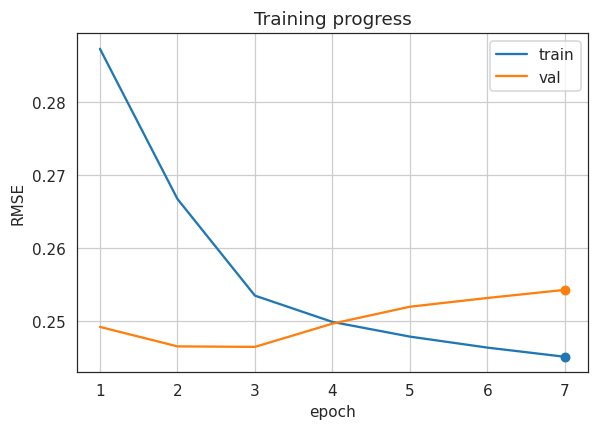

Epoch 1:   0%|          | 0/60 [00:04<?, ?batch/s]

Epoch 001
TRAIN→ RMSE=0.2873 MAE=0.2205 R2=0.0184 | Acc=0.7130 Prec=0.4156 Rec=0.1706 F1=0.2419 AUROC=0.6298
VALID→ RMSE=0.2492 MAE=0.1833 R2=0.2259 | Acc=0.7612 Prec=0.6709 Rec=0.2486 F1=0.3628 AUROC=0.7404


Epoch 2:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 002
TRAIN→ RMSE=0.2667 MAE=0.2056 R2=0.1540 | Acc=0.7534 Prec=0.5841 Rec=0.2813 F1=0.3798 AUROC=0.7060
VALID→ RMSE=0.2465 MAE=0.1840 R2=0.2424 | Acc=0.7650 Prec=0.6630 Rec=0.2863 F1=0.3999 AUROC=0.7514


Epoch 3:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 003
TRAIN→ RMSE=0.2534 MAE=0.1926 R2=0.2360 | Acc=0.7650 Prec=0.6299 Rec=0.3011 F1=0.4074 AUROC=0.7451
VALID→ RMSE=0.2464 MAE=0.1819 R2=0.2428 | Acc=0.7647 Prec=0.6631 Rec=0.2838 F1=0.3975 AUROC=0.7530


Epoch 4:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 004
TRAIN→ RMSE=0.2498 MAE=0.1892 R2=0.2576 | Acc=0.7686 Prec=0.6381 Rec=0.3186 F1=0.4250 AUROC=0.7577
VALID→ RMSE=0.2496 MAE=0.1832 R2=0.2231 | Acc=0.7610 Prec=0.6508 Rec=0.2723 F1=0.3839 AUROC=0.7436


Epoch 5:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 005
TRAIN→ RMSE=0.2478 MAE=0.1873 R2=0.2695 | Acc=0.7711 Prec=0.6434 Rec=0.3296 F1=0.4359 AUROC=0.7643
VALID→ RMSE=0.2519 MAE=0.1845 R2=0.2086 | Acc=0.7583 Prec=0.6337 Rec=0.2752 F1=0.3838 AUROC=0.7352


Epoch 6:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 006
TRAIN→ RMSE=0.2463 MAE=0.1859 R2=0.2783 | Acc=0.7730 Prec=0.6476 Rec=0.3381 F1=0.4443 AUROC=0.7695
VALID→ RMSE=0.2531 MAE=0.1865 R2=0.2011 | Acc=0.7557 Prec=0.6108 Rec=0.2940 F1=0.3969 AUROC=0.7310


Epoch 7:   0%|          | 0/60 [00:00<?, ?batch/s]

Epoch 007
TRAIN→ RMSE=0.2451 MAE=0.1847 R2=0.2857 | Acc=0.7745 Prec=0.6517 Rec=0.3433 F1=0.4497 AUROC=0.7735
VALID→ RMSE=0.2542 MAE=0.1873 R2=0.1940 | Acc=0.7535 Prec=0.5974 Rec=0.3027 F1=0.4018 AUROC=0.7294


Epoch 8:   0%|          | 0/60 [00:00<?, ?batch/s]

[W 2025-09-23 08:22:47,843] Trial 55 failed with parameters: {'look_back': 120, 'DROPOUT_SHORT': 0.11169152300295014, 'DROPOUT_LONG': 0.3054263868445397, 'ATT_DROPOUT': 0.18334072696380388, 'INITIAL_LR': 0.0009494032555750688, 'ETA_MIN': 5.899826675601087e-06, 'WEIGHT_DECAY': 0.00027505555898221914, 'CLIPNORM': 9.411656275351655} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/optuna/study/_optimize.py", line 201, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/tmp/ipykernel_1071/2237797113.py", line 103, in objective
    best_val_rmse  = dual_lstm.lstm_training_loop(
                     ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/workspace/my_models/Trading/_Stock_Analysis_/libs/models/dual_lstm.py", line 801, in lstm_training_loop
    scaler.scale(loss).backward()
  File "/usr/local/lib/python3.12/dist-packages/torch/_tensor.py", line 648, in backward
    tor

KeyboardInterrupt: 

In [7]:
# importlib.reload(dual_lstm) ########################

# ──────────────────────────────────────────────────────────────────────────────
#  Create Optuna study and run optimization
# ──────────────────────────────────────────────────────────────────────────────

study = optuna.create_study(
    storage="sqlite:///optuna_study.db",    # Point it at an SQLite file so it writes out each result immediately instead of buffering in RAM
    load_if_exists=True,
    direction="minimize",
    pruner=MedianPruner(n_startup_trials=6, n_warmup_steps=12),
)

        
study.optimize(
    objective,
    n_trials = 100,
    n_jobs   = 1,
    callbacks=[live_cb, plots.cleanup_callback],
)

plt.close('all')   # safe here; the final image remains displayed in the notebook output
gc.collect()       # optional extra sweep



In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
#  Print out the best hyperparameters & result
# ──────────────────────────────────────────────────────────────────────────────
print("Best hyperparameters:", study.best_params)
print("Best validation RMSE:", study.best_value)

# ──────────────────────────────────────────────────────────────────────────────
#  Compute and print parameter importances
# ──────────────────────────────────────────────────────────────────────────────
imps = get_param_importances(study)
print("\nHyperparameter importances (higher ⇒ more impact on RMSE):")
for name, score in sorted(imps.items(), key=lambda x: x[1], reverse=True):
    print(f"  {name:20s} : {score:.3f}")

# ──────────────────────────────────────────────────────────────────────────────
#  Dump study results to JSON
# ──────────────────────────────────────────────────────────────────────────────
# 1) Build your session‐only DataFrame once
session_df = df.between_time(params.regular_start,
                             params.regular_end)

# 2) Derive the trading‐day boundaries
first_day = session_df.index.normalize().min()
last_day  = session_df.index.normalize().max()

# 3) Format your file name
start_date = first_day.strftime("%Y%m%d")
end_date   = last_day.strftime("%Y%m%d")
file_name  = f"{params.ticker}_{start_date}-{end_date}_optuna_model_hpars.json"
file_path  = os.path.join(results_folder, file_name)


# ------------------------------------------------------------------
# Dump study results (including importances)
# ------------------------------------------------------------------

with open(file_path, "w") as f:
    json.dump(
        {
            "best_params": study.best_params,
            "best_value" : study.best_value,
            "importances": imps,
            "trials": [
                {"number": t.number, "value": t.value, "params": t.params, 
                 "state": t.state.name}
                for t in study.trials
            ],
        },
        f,
        indent=4,
    )

print(f"\nOptuna results (and importances) saved to: {file_path}")
